In [1167]:
#(thlu = theta leg upper, thll = theta leg lower)


%reset
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thlu,thll = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg_upper}','\\theta_{leg_lower}']) 
dx,dy,dthb,dthlu,dthll = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg_upper}','\dot{\\theta}_{leg_lower}']) 
ddx,ddy,ddthb,ddthlu,ddthll = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg_upper}','\ddot{\\theta}_{leg_lower}']) 

q = sym.Matrix([[x],[y],[thb],[thlu],[thll]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthlu],[dthll]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthlu],[ddthll]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
tau_hip,tau_knee,GRFx,GRFy = sym.symbols(['\\tau_hip','\\tau_knee','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - 0.5*ll1*sym.cos(thb + thlu)],
                [y - 0.5*ll1*sym.sin(thb + thlu)],
                [thb + thlu]])

rl2 = sym.Matrix([[x - ll1*sym.cos(thb + thlu)-(0.5*ll2)*sym.cos(thb + thlu+thll)],
                [y - ll1*sym.sin(thb + thlu)-(0.5*ll2)*sym.sin(thb + thlu+thll)],
                [thb + thlu+thll]])



# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_body = sym.Matrix([[0],[0],[-tau_hip]])
tau_l1 = sym.Matrix([[0],[0],[tau_hip - tau_knee]])
tau_l2 = sym.Matrix([[0],[0],[tau_knee]])

# F_l1 = sym.Matrix([[-F*sym.sin(thb+thlu)],[F*sym.cos(thb+thlu)],[0]])
# F_l2 = sym.Matrix([[+F*sym.cos(thb+thlu+thll)],[F*sym.sin(thb+thlu+thll)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[(0.5*ll2*sym.sin(thb+thlu+thll)*GRFx) - (0.5*ll2*sym.cos(thb+thlu+thll)*GRFy)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_body.transpose()*Jb[:,j]+(tau_l1).transpose()*Jl1[:,j]+(GRF_l2+tau_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1154]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thlu,thll,
            dx,dy,dthb,dthlu,dthll,
            ddx,ddy,ddthb,ddthlu,ddthll,
            tau_hip,tau_knee,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thlu = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_thll = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [1155]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 250
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_lu','theta_ll'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)

In [1156]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [1157]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 0.5) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
#         L = 0.5*m.len[('leg',1)]  + 0.5*m.len[('leg',2)] # total leg length
#         thA = m.q[n,'theta_b'] + m.q[n,'theta_lu'] + m.q[n,'theta_ll'] # absolute leg angle
        thA=(m.q[n,'theta_b'] + m.q[n,'theta_lu'])
        thB=(m.q[n,'theta_b'] +m.q[n,'theta_lu']+ m.q[n,'theta_ll'])

        return m.footp[n,dof] ==  m.q[n,'y'] - (m.len[('leg',1)]*sin(thA))-(m.len[('leg',2)]*sin(thB))
        
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)

# lambdify the foot velocity
thA=(thb + thlu)
thB=(thb + thlu + thll)

#footx = sym.Matrix([x + (0.5*ll1+0.5*ll2)*sym.sin(thb + thlu + thll)])
footx = sym.Matrix([x - (ll1*sym.cos(thA))-(ll2*sym.cos(thB))])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

In [1158]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# parameters
hip_bound = [0,np.pi]
m.hip_bound = Param(m.joint_constraints, initialize = {'up':hip_bound[1],'lo':hip_bound[0]}) 

knee_bound = [-np.pi/2,np.pi/2]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'theta_lu'].setlb(hip_bound[0])
    m.q[n,'theta_lu'].setub(hip_bound[1])
    m.q[n,'theta_ll'].setlb(hip_bound[0])
    m.q[n,'theta_ll'].setub(hip_bound[1])

# variables
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
#m.tau_r1 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque

m.tau_b = Var(m.N, bounds = (-2,2)) # actuator torque at knee
#m.tau_r2 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque


# m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
# m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# # complementarity
# def hip_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT angle
#             return m.joint_penalty[n,'hip',jc] == (m.hip_bound['up'] - m.q[n+1,'theta_lu']-m.q[n+1,'theta_ll'])*m.tau_r1[n,'ng']
#         else:
#             return m.joint_penalty[n,'hip',jc] == (m.q[n+1,'theta_lu'] + m.q[n+1,'theta_ll']- m.hip_bound['lo'])*m.tau_r1[n,'ps']
#     else:
#         return Constraint.Skip
# m.hip_limits = Constraint(m.N, m.joint_constraints, rule = hip_limits)

# def knee_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT distance
#             return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] )*m.F_r[n,'ng']
#         else:
#             return m.joint_penalty[n,'knee',jc] == ( - m.knee_bound['lo'])*m.F_r[n,'ps']
#     else:
#         return Constraint.Skip
# m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

# #bound contact forces at last node
# for sgn in signs:
#     m.F_r[N,sgn].value = 0
#     m.F_r[N,sgn].fixed = True

# for sgn in signs:
#     m.tau_r1[N,sgn].value = 0
#     m.tau_r1[N,sgn].fixed = True
#     m.tau_r2[N,sgn].value = 0
#     m.tau_r2[N,sgn].fixed = True

In [1159]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
#    T = sum(m.h[n] for n in range(1,N+1))       #time constraint
    penalty_sum = 0
    penalty_torque = 0
    for n in range(1,N+1):
        penalty_torque += ((m.tau_a[n]**2)+(m.tau_b[n]**2))
        for gc in ground_constraints:             #ground constraints
            penalty_sum += m.ground_penalty[n,gc] #ground constraints  
#         for jc in joint_constraints:              #hard stop constraints
#             for j in joints:                       #hard stop constraints
#                 penalty_sum += m.joint_penalty[n,j,jc] #hard stop constraints
    #return T+1000*penalty_sum
    return ((1000*penalty_sum) +(1000*penalty_torque))
m.Cost = Objective(rule = CostFun)

In [1160]:
# def CostFun(m):
#     torque_sum = 0
#     for n in range(1,N+1):
#             torque_sum += (m.tau_a[n]+m.tau_a[n])**2
#     return torque_sum
# m.Cost = Objective(rule = CostFun)

In [1161]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    
#     tau_hip = S*(m.tau_a[n]  + m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
#     tau_knee= S*(m.tau_b[n]  + m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, rule = EOM_x)

def EOM_y(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, rule = EOM_y)

def EOM_thb(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, rule = EOM_thb)

def EOM_thlu(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thlu(*var_list) == 0
m.EOM_thlu = Constraint(m.N, rule = EOM_thlu)

def EOM_thll(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])    
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thll(*var_list) == 0
m.EOM_thll = Constraint(m.N, rule = EOM_thll)

In [1162]:
# INITIALIZE ----------------------------------------------------------------------------------------------------------------
guide = np.linspace(0,5.0,N)
for n in range(1,N+1):
    m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
    m.q[n,'y'].value  = np.random.uniform(0,3)
    m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/4,np.pi/4)
    m.q[n,'theta_lu'].value  = np.random.uniform(np.pi/4,(6*np.pi/8))
    m.q[n,'theta_ll'].value  = np.random.uniform(-np.pi/4,np.pi/4)
    
    m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
    m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value

#      m.GRF[n,'Y','ps'].value = 0
#      m.GRF[n,'X','ps'].value = 0

In [1163]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'y'].value = 1.0
m.q[1,'theta_b'].value = 0
m.q[1,'theta_lu'].value = np.pi/2
m.q[1,'theta_ll'].value = 0

m.ddq[1,'theta_b'].value = 0.0
m.ddq[1,'theta_b'].fixed = True
m.ddq[1,'theta_lu'].value = 0.0
m.ddq[1,'theta_lu'].fixed = True
m.ddq[1,'theta_ll'].value = 0.0
m.ddq[1,'theta_ll'].fixed = True

# m.tau_r1[n,'ps'].value = 0.0
# m.tau_r1[n,'ps'].fixed = True
# m.tau_r1[n,'ng'].value = 0.0
# m.tau_r1[n,'ng'].fixed = True

# m.tau_r2[n,'ps'].value = 0.0
# m.tau_r2[n,'ps'].fixed = True
# m.tau_r2[n,'ng'].value = 0.0
# m.tau_r2[n,'ng'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

for dof in DOFs:
    m.q[1,dof].fixed = True
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
 
    
# for n in range(1,N+1):
# #     m.F_a[n].value = 0.0
# #     m.F_a[n].fixed = True
#     m.tau_a[n].value = 0.0
#     m.tau_a[n].fixed = True
#     m.tau_b[n].value = 0.0
#     m.tau_b[n].fixed = True
    
#     m.tau_r1[n,'ps'].value = 0.0
#     m.tau_r1[n,'ps'].fixed = True
#     m.tau_r1[n,'ng'].value = 0.0
#     m.tau_r1[n,'ng'].fixed = True

#     m.tau_r2[n,'ps'].value = 0.0
#     m.tau_r2[n,'ps'].fixed = True
#     m.tau_r2[n,'ng'].value = 0.0
#     m.tau_r2[n,'ng'].fixed = True

    
# m.q[N,'x'].value = 0.0
# m.q[N,'y'].value = 0.0
# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
    
#m.pprint()






#hope test part

# final condition
#m.q[N,'y'].setlb(1.3)







#Tax day sprint

# final condition
m.q[N,'x'].setlb(5.0)

m.dq[N,'x'].value = 0.0
m.dq[N,'x'].fixed = True
m.dq[N,'theta_b'].value = 0.0
m.dq[N,'theta_b'].fixed = True
m.dq[N,'theta_lu'].value = 0.0
m.dq[N,'theta_lu'].fixed = True
m.dq[N,'theta_ll'].value = 0.0
m.dq[N,'theta_ll'].fixed = True

m.q[N,'theta_b'].value = 0.0
m.q[N,'theta_lu'].value = np.pi/2
m.q[N,'theta_ll'].value = 0.0
m.q[N,'theta_b'].fixed = True
m.q[N,'theta_lu'].fixed = True
m.q[N,'theta_ll'].fixed = True

m.footp[N,'Y'].value = 0.0
m.footp[N,'Y'].fixed = True
    
#m.pprint()







In [1166]:
# solving
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Yousuf/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options['OF_hessian_approximation'] = 'limited-memory'
opt.options['OF_print_frequency_time'] = 10
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.12.12: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06
option_file_name=C:\Users\Yousuf\AppData\Local\Temp\tmp9pryb74k_ipopt.opt

Using option file "C:\Users\Yousuf\AppData\Local\Temp\tmp9pryb74k_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    13511
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     2875
                

  75  4.9227805e+03 1.78e+00 4.61e+04  -0.5 4.41e+01    -  1.00e+00 9.37e-01f  1
  76  4.9418607e+03 7.86e-01 1.14e+06  -0.5 3.04e+01    -  6.29e-01 1.00e+00h  1
  77  4.8762620e+03 2.48e+00 7.30e+04  -0.5 3.40e+01    -  1.00e+00 1.00e+00f  1
  78  4.9589992e+03 1.22e-01 1.27e+05  -0.5 3.33e+01    -  8.48e-01 1.00e+00H  1
  79  4.9359208e+03 8.39e-01 1.51e+05  -0.5 3.05e+01    -  9.26e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  4.9022511e+03 6.76e-01 3.59e+05  -0.5 1.06e+02    -  1.69e-01 1.08e-01f  3
  81  5.4113579e+03 1.03e+00 3.79e+06  -0.5 6.19e+01    -  2.99e-01 8.60e-01H  1
  82  5.0976030e+03 8.55e-01 5.51e+05  -0.5 4.10e+01    -  1.00e+00 7.98e-01F  1
  83  4.9822959e+03 7.42e-01 7.77e+04  -0.5 1.49e+02    -  5.04e-02 9.54e-02f  3
  84  4.9490500e+03 4.09e-01 2.41e+05  -0.5 4.57e+01    -  5.91e-01 1.00e+00H  1
  85  4.8822281e+03 1.94e+00 1.50e+06  -0.5 6.10e+01    -  1.93e-01 4.67e-01f  2
  86  4.8735797e+03 1.13e+00

 175  4.7277436e+04 6.31e+00 2.53e+07   0.8 4.84e+01    -  1.00e+00 8.27e-01f  1
 176  4.7773678e+04 8.14e-01 4.58e+06   0.8 6.91e-01    -  2.03e-01 1.00e+00f  1
 177  4.7869060e+04 1.29e-02 1.85e+05   0.8 4.38e-01    -  1.00e+00 1.00e+00f  1
 178  3.0934713e+04 1.57e-01 1.60e+08   0.1 2.03e+00    -  6.19e-01 5.61e-01f  1
 179  1.8649472e+04 7.02e-01 5.92e+07   0.1 5.34e+00    -  6.92e-01 7.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.3746622e+04 7.87e-01 1.23e+07   0.1 4.64e+00    -  7.20e-01 9.25e-01f  1
 181  1.3510147e+04 8.00e-02 2.68e+06   0.1 2.04e+00    -  1.00e+00 1.00e+00f  1
 182  1.2138734e+04 4.39e+00 6.35e+06   0.1 4.75e+01    -  4.18e-01 5.54e-01f  1
 183  1.1774622e+04 3.12e+00 7.40e+06   0.1 3.65e+01    -  2.39e-01 5.17e-01f  1
 184  1.1755399e+04 1.33e+00 5.23e+06   0.1 1.76e+01    -  1.00e+00 1.00e+00f  1
 185  1.1822121e+04 8.04e-01 2.21e+06   0.1 1.42e+01    -  1.00e+00 1.00e+00f  1
 186  1.1784810e+04 1.87e-01

 269  2.4687035e+03 2.86e-01 2.44e+04  -1.3 5.19e+01    -  4.13e-01 4.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  2.4680452e+03 2.87e-01 1.82e+04  -1.3 3.95e+01    -  9.76e-02 7.59e-02f  2
 271  2.4640140e+03 2.26e-01 8.97e+03  -1.3 2.34e+01    -  4.09e-01 7.13e-01h  1
 272  2.4647773e+03 2.64e-01 1.45e+04  -1.3 6.13e+01    -  4.83e-01 2.24e-01f  3
 273  2.4642547e+03 1.28e-01 1.28e+04  -1.3 1.23e+01    -  4.38e-01 9.26e-01h  1
 274  2.4843899e+03 2.55e-02 1.91e+04  -1.3 1.76e+01    -  1.00e+00 9.33e-01H  1
 275  2.4626852e+03 8.78e-02 8.76e+03  -1.3 1.23e+01    -  3.74e-01 8.26e-01f  1
 276  2.4906709e+03 6.16e-02 1.61e+04  -1.3 3.47e+01    -  3.51e-01 7.87e-01H  1
 277  2.5055250e+03 4.39e-02 2.52e+04  -1.3 1.39e+01    -  8.28e-01 9.03e-01H  1
 278  2.4863397e+03 5.55e-02 2.63e+04  -1.3 6.19e+01    -  2.71e-02 1.36e-01f  3
 279  2.4745415e+03 9.15e-02 4.68e+04  -1.3 8.32e+01    -  8.10e-01 1.35e-01f  3
iter    objective    inf_pr 

 368  2.3035251e+03 1.76e-01 2.53e+04  -1.6 2.72e+01    -  1.62e-01 3.15e-01f  1
 369  2.2902837e+03 1.68e-01 2.37e+04  -1.6 1.92e+02    -  8.11e-02 6.28e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  2.2821302e+03 1.87e-01 2.30e+04  -1.6 4.57e+01    -  5.63e-02 9.17e-02f  3
 371  2.2802760e+03 1.30e-01 1.89e+04  -1.6 3.59e+01    -  1.79e-01 1.84e-01f  2
 372  2.2779453e+03 1.45e-01 1.27e+04  -1.6 3.69e+01    -  6.78e-01 1.67e-01f  3
 373  2.2743281e+03 8.86e-02 1.69e+04  -1.6 7.23e+01    -  2.02e-01 1.79e-01f  1
 374  2.2816166e+03 6.46e-03 3.76e+04  -1.6 2.32e+01    -  1.00e+00 1.00e+00H  1
 375  2.8351866e+03 1.78e+00 4.30e+05  -0.6 1.21e+02    -  2.21e-01 2.38e-01f  1
 376  2.5925221e+03 1.51e+00 4.43e+04  -1.2 1.65e+01    -  1.00e+00 1.00e+00f  1
 377  2.5617277e+03 2.53e-01 6.42e+04  -1.2 2.59e+01    -  6.82e-01 1.00e+00h  1
 378  2.6194851e+03 4.49e-02 3.33e+04  -1.2 3.94e+01    -  5.64e-01 1.00e+00H  1
 379  2.6170737e+03 3.85e-01

 462  2.5516761e+03 1.88e-01 2.79e+05  -1.2 1.70e+02    -  5.61e-01 8.70e-02f  3
 463  2.5301006e+03 3.74e-01 2.35e+05  -1.2 7.04e+02    -  1.60e-01 4.11e-02f  3
 464  2.5169894e+03 9.59e-01 1.79e+05  -1.2 1.53e+02    -  4.67e-01 1.94e-01f  2
 465  2.5113365e+03 1.09e+00 3.44e+04  -1.2 2.21e+02    -  2.72e-01 6.81e-02f  3
 466  2.5182725e+03 4.95e-01 3.11e+04  -1.2 6.64e+01    -  1.00e+00 7.48e-01H  1
 467  2.7092147e+03 7.26e-02 5.78e+04  -1.2 4.41e+01    -  3.22e-01 8.64e-01H  1
 468  2.5559001e+03 1.17e-01 4.19e+04  -1.2 5.27e+01    -  3.67e-01 1.00e+00F  1
 469  2.5490901e+03 1.52e-01 1.38e+05  -1.2 2.18e+02    -  3.16e-01 3.10e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  2.5145533e+03 6.74e-01 9.53e+04  -1.2 9.33e+01    -  3.41e-01 4.14e-01F  1
 471  2.5058593e+03 1.31e+00 2.59e+04  -1.2 1.72e+02    -  5.07e-01 2.24e-01f  2
 472  2.5005327e+03 1.13e+00 8.74e+04  -1.2 4.29e+01    -  1.00e+00 1.40e-01h  1
 473  2.7441958e+03 6.08e-02

 556  2.3970318e+03 1.50e-01 1.40e+05  -1.3 9.29e+00    -  8.86e-01 1.00e+00f  1
 557  2.3926915e+03 1.46e-01 2.30e+04  -1.3 1.12e+01    -  1.00e+00 7.38e-01f  1
 558  2.4511320e+03 6.16e-02 1.89e+04  -1.3 2.41e+01    -  1.00e+00 8.57e-01H  1
 559  2.4235407e+03 1.85e-01 1.59e+04  -1.3 3.53e+01    -  2.28e-01 6.75e-01F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560  2.4014826e+03 2.01e-01 6.49e+04  -1.3 6.62e+01    -  3.38e-01 7.02e-02f  2
 561  2.3980505e+03 1.76e-01 4.27e+04  -1.3 1.98e+01    -  4.03e-01 4.67e-01f  1
 562  2.4234041e+03 7.29e-02 1.89e+04  -1.3 1.05e+01    -  5.13e-01 6.63e-01H  1
 563  2.4156796e+03 1.44e-01 1.95e+04  -1.3 6.45e+01    -  1.32e-01 3.50e-01f  2
 564  2.4049567e+03 1.76e-01 1.64e+04  -1.3 7.51e+01    -  1.98e-01 6.74e-02f  3
 565  2.4245760e+03 7.26e-02 1.80e+04  -1.3 2.59e+01    -  8.12e-01 7.02e-01H  1
 566  2.4162354e+03 7.93e-02 1.39e+04  -1.3 5.84e+01    -  3.12e-01 1.11e-01f  3
 567  2.3986794e+03 9.02e-02

 654  2.0681666e+03 9.34e-02 1.94e+04  -1.9 8.80e+00    -  1.00e+00 1.00e+00f  1
 655  2.0725292e+03 7.04e-02 8.83e+04  -2.0 3.07e+00    -  5.83e-01 9.11e-01h  1
 656  2.0479851e+03 6.31e-02 1.03e+04  -2.0 2.02e+00    -  1.00e+00 1.00e+00f  1
 657  2.0486276e+03 4.24e-02 4.89e+03  -2.0 3.03e+00    -  1.00e+00 3.32e-01h  1
 658  2.0489172e+03 8.13e-03 8.25e+03  -2.0 1.54e+00    -  1.00e+00 1.00e+00f  1
 659  2.0481344e+03 1.38e-02 2.50e+03  -2.0 1.83e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660  2.0363312e+03 9.93e-03 4.72e+05  -2.3 4.01e+00    -  1.00e+00 2.43e-01f  1
 661  2.0044801e+03 8.35e-03 1.10e+05  -2.4 2.76e+00    -  1.00e+00 7.92e-01f  1
 662  1.9834163e+03 1.85e-02 7.07e+04  -2.8 2.25e+00    -  1.00e+00 8.01e-01f  1
 663  1.9804232e+03 1.85e-02 9.92e+04  -8.7 8.09e+00    -  4.23e-01 1.71e-01f  1
 664  1.9767746e+03 1.96e-02 1.10e+05  -3.7 1.08e+01    -  7.59e-01 2.60e-01f  1
 665  1.9744362e+03 1.33e-02

 752  1.9670434e+03 9.19e-04 1.63e+02  -3.1 4.61e-01    -  1.00e+00 1.00e+00h  1
 753  1.9670332e+03 9.07e-04 6.73e+03  -3.1 3.41e+00    -  1.00e+00 1.28e-02h  6
 754  1.9634619e+03 3.67e-03 1.47e+04  -3.6 2.52e-01    -  1.00e+00 7.67e-01f  1
 755  1.9629790e+03 2.41e-03 2.36e+04  -3.6 7.21e-01    -  9.99e-01 3.87e-01h  1
 756  1.9628513e+03 1.71e-03 1.27e+04  -3.6 3.18e+00    -  5.20e-01 2.24e-01h  1
 757  1.9639451e+03 3.50e-03 2.30e+04  -3.1 3.93e+00    -  7.51e-01 2.99e-01f  1
 758  1.9644101e+03 4.18e-04 3.48e+04  -3.3 3.54e+00    -  2.13e-01 9.87e-01H  1
 759  1.9652653e+03 3.36e-03 2.76e+04  -3.0 5.07e+00    -  2.68e-01 2.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 760  1.9650779e+03 2.79e-03 7.64e+03  -3.2 5.05e+00    -  1.00e+00 2.08e-01h  3
 761  1.9648603e+03 6.74e-03 7.13e+03  -3.2 2.13e+01    -  8.42e-02 1.13e-01f  3
 762  1.9647857e+03 6.08e-03 6.62e+03  -3.2 1.26e+00    -  5.65e-01 9.93e-02h  1
 763  1.9647685e+03 5.92e-03

 855  1.9722842e+03 1.65e-03 9.56e+02  -2.8 6.09e+01    -  1.12e-01 1.56e-02f  4
 856  1.9721520e+03 1.65e-03 8.91e+02  -2.8 3.38e+01    -  2.01e-01 2.36e-02h  4
 857  1.9726963e+03 8.88e-04 9.08e+02  -2.8 1.28e+01    -  2.58e-01 1.00e+00H  1
 858  1.9724126e+03 9.19e-04 8.62e+02  -2.8 4.99e+00    -  5.29e-02 6.13e-02f  3
 859  1.9718938e+03 3.66e-03 2.34e+03  -2.8 4.51e+00    -  7.73e-01 2.50e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860  1.9717047e+03 3.49e-03 2.98e+03  -2.8 1.29e+02    -  1.40e-01 5.64e-03f  5
 861  1.9716152e+03 3.28e-03 1.00e+03  -2.8 5.99e+00    -  1.00e+00 5.75e-02h  3
 862  1.9715027e+03 3.08e-03 7.63e+02  -2.8 1.48e+01    -  2.96e-01 3.74e-02h  4
 863  1.9713207e+03 5.51e-03 1.67e+03  -2.8 2.40e+01    -  5.64e-01 1.12e-01h  2
 864  1.9712847e+03 5.34e-03 1.13e+03  -2.8 2.00e+01    -  2.77e-01 1.76e-02h  5
 865  1.9710547e+03 2.61e-02 1.17e+03  -2.8 3.28e+00    -  6.72e-01 8.50e-01h  1
 866  1.9710452e+03 2.37e-02

 949  1.9663924e+03 2.07e-03 4.51e+02  -3.1 2.64e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950  1.9665160e+03 6.20e-04 8.67e+02  -3.1 8.23e-01    -  1.00e+00 8.81e-01H  1
 951  1.9666247e+03 4.31e-05 4.53e+02  -3.1 9.81e-01    -  1.00e+00 1.00e+00F  1
 952  1.9668156e+03 5.70e-05 1.27e+02  -3.1 1.08e+00    -  1.00e+00 1.00e+00H  1
 953  1.9666465e+03 7.70e-06 2.02e+02  -3.1 1.76e+00    -  1.00e+00 1.00e+00F  1
 954  1.9718741e+03 1.82e-02 1.05e+05  -2.6 1.67e+00    -  1.00e+00 4.08e-01f  1
 955  1.9747663e+03 3.37e-03 1.07e+03  -2.7 5.83e-01    -  1.00e+00 1.00e+00h  1
 956  1.9739630e+03 4.78e-03 2.66e+02  -2.7 3.16e-01    -  9.26e-01 8.90e-01h  1
 957  1.9737773e+03 5.53e-03 1.16e+03  -2.7 1.82e+00    -  2.50e-01 2.07e-01f  2
 958  1.9735850e+03 3.60e-03 5.27e+02  -2.7 5.80e-01    -  1.00e+00 1.00e+00h  1
 959  1.9737757e+03 2.75e-03 6.60e+02  -2.7 4.58e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

1050  1.9604391e+03 1.28e-03 2.68e+00  -4.5 6.35e-01    -  1.00e+00 1.00e+00f  1
1051  1.9604288e+03 1.72e-03 1.10e+01  -4.6 3.42e+00    -  1.95e-01 1.83e-01h  1
1052  1.9604133e+03 3.35e-03 3.54e+01  -4.6 2.81e+00    -  1.69e-01 1.18e-01h  1
1053  1.9604057e+03 3.23e-03 1.96e+02  -4.6 4.89e-01    -  4.38e-01 5.01e-02f  1
1054  1.9604599e+03 6.07e-04 1.54e+02  -4.6 1.06e+00    -  1.69e-01 8.87e-01H  1
1055  1.9604431e+03 1.04e-03 1.44e+02  -4.6 2.34e+01    -  5.71e-02 1.48e-02f  3
1056  1.9604394e+03 1.04e-03 1.34e+02  -4.6 1.41e+00    -  5.42e-02 8.06e-03h  4
1057  1.9603828e+03 2.00e-03 1.12e+02  -4.6 5.42e-01    -  3.77e-01 1.00e+00h  1
1058  1.9603161e+03 1.38e-02 1.07e+02  -4.6 2.04e+00    -  5.15e-02 2.83e-01h  1
1059  1.9602901e+03 2.27e-02 2.45e+01  -4.6 7.51e-01    -  7.88e-01 5.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1060  1.9603482e+03 6.59e-03 4.72e+01  -4.6 7.67e-01    -  3.61e-03 1.00e+00h  1
1061  1.9603132e+03 8.88e-03

1153  1.9603051e+03 8.79e-04 1.71e+00  -4.8 3.91e+00    -  1.82e-01 2.15e-01h  2
1154  1.9603040e+03 8.70e-04 5.71e+00  -4.8 5.95e+01    -  4.18e-01 5.57e-02h  2
1155  1.9603625e+03 5.61e-04 1.97e+01  -4.8 8.08e+00    -  2.14e-01 8.89e-01H  1
1156  1.9602837e+03 2.29e-03 7.48e+00  -4.8 2.35e+00    -  3.36e-01 6.65e-01f  1
1157  1.9602765e+03 2.86e-03 4.76e+00  -4.8 3.19e+01    -  8.04e-02 1.13e-01h  3
1158  1.9602756e+03 2.85e-03 4.21e+00  -4.8 6.80e+01    -  1.92e-01 3.10e-03h  1
1159  1.9602759e+03 2.78e-03 5.39e+00  -4.8 6.61e+01    -  2.18e-01 2.72e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1160  1.9602479e+03 3.14e-03 5.40e+00  -4.8 5.17e+00    -  4.46e-01 2.94e-01h  1
1161  1.9602474e+03 3.13e-03 6.30e+00  -4.8 2.23e+02    -  7.02e-03 1.11e-02h  1
1162  1.9602494e+03 2.50e-03 2.05e+00  -4.8 7.96e+00    -  2.86e-01 2.50e-01f  3
1163  1.9602492e+03 2.26e-03 3.63e+00  -4.8 8.12e+00    -  1.10e-01 7.25e-02h  2
1164  1.9602480e+03 2.25e-03

1250  1.9602580e+03 4.02e-03 1.01e+01  -4.8 1.05e+01    -  1.01e-01 1.28e-01h  1
1251  1.9602506e+03 4.06e-03 8.95e+00  -4.8 1.50e+02    -  3.37e-02 1.97e-02f  3
1252  1.9602463e+03 4.18e-03 8.81e+00  -4.8 1.70e+02    -  3.91e-02 3.27e-02h  3
1253  1.9602464e+03 3.46e-03 6.50e+00  -4.8 5.05e+00    -  1.18e-01 2.27e-01h  2
1254  1.9602460e+03 3.41e-03 4.92e+00  -4.8 2.49e+01    -  2.86e-01 1.53e-02h  1
1255  1.9604326e+03 2.23e-04 4.61e+00  -4.8 5.84e+00    -  6.72e-01 9.43e-01H  1
1256  1.9604013e+03 1.86e-03 1.26e+01  -4.8 4.44e+00    -  2.99e-01 2.08e-01F  1
1257  1.9603410e+03 1.57e-03 9.92e+00  -4.8 2.68e+01    -  1.48e-01 2.10e-01f  1
1258  1.9603143e+03 1.55e-03 1.15e+01  -4.8 2.36e+02    -  5.72e-03 1.46e-02f  1
1259  1.9603124e+03 1.58e-03 7.98e+00  -4.8 1.10e+02    -  2.38e-02 1.45e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260  1.9602898e+03 1.67e-03 5.02e+00  -4.8 5.17e+01    -  2.37e-02 8.69e-02h  3
1261  1.9602862e+03 1.69e-03

1348  1.9602430e+03 7.03e-03 7.56e+00  -4.8 1.40e+01    -  5.05e-01 1.04e-01h  2
1349  1.9602702e+03 3.52e-03 4.25e+00  -4.8 4.01e+00    -  3.66e-01 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350  1.9602722e+03 3.31e-03 3.37e+00  -4.8 1.33e+01    -  1.78e-01 1.93e-01h  3
1351  1.9602749e+03 3.12e-03 4.32e+00  -4.8 5.06e+01    -  2.47e-01 6.46e-02h  4
1352  1.9602752e+03 3.11e-03 5.12e+00  -4.8 4.87e+01    -  1.48e-01 7.74e-02h  2
1353  1.9602970e+03 2.20e-04 2.61e-01  -4.8 1.36e+00    -  1.00e+00 1.00e+00h  1
1354  1.9602994e+03 2.95e-05 1.11e+00  -4.8 2.52e-01    -  1.00e+00 1.00e+00h  1
1355  1.9602998e+03 3.51e-05 1.80e+00  -4.8 1.53e-01    -  1.00e+00 1.00e+00h  1
1356  1.9603011e+03 1.05e-07 8.00e-01  -4.8 1.03e+00    -  1.00e+00 1.00e+00H  1
1357  1.9605783e+03 1.11e-02 1.35e+03  -3.8 4.85e+01    -  3.30e-01 2.31e-01f  1
1358  1.9605538e+03 4.97e-03 2.79e+01  -4.3 2.74e+01    -  1.00e+00 1.00e+00h  1
1359  1.9604823e+03 7.81e-03

1447  1.9614197e+03 1.64e-03 3.46e+03  -3.7 8.81e+00    -  4.26e-01 6.90e-01f  1
1448  1.9612834e+03 1.50e-03 3.74e+03  -4.0 5.47e+01    -  7.85e-01 1.67e-01h  1
1449  1.9610904e+03 8.48e-04 2.10e+03  -4.0 2.52e+01    -  1.28e-01 4.50e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450  1.9610698e+03 8.21e-04 2.02e+03  -4.0 4.25e+00    -  8.27e-03 4.46e-02f  1
1451  1.9610565e+03 1.13e-03 1.90e+03  -4.0 1.08e+02    -  4.54e-02 3.63e-02f  1
1452  1.9610490e+03 1.83e-03 1.70e+03  -4.0 2.04e+01    -  8.10e-02 1.03e-01f  3
1453  1.9610362e+03 2.06e-03 2.35e+03  -4.0 1.36e+02    -  3.22e-01 9.00e-02h  3
1454  1.9610764e+03 1.19e-04 5.52e+02  -4.0 6.16e+00    -  4.13e-01 1.00e+00H  1
1455  1.9610325e+03 7.34e-04 6.88e+02  -4.0 2.07e+00    -  1.57e-01 8.75e-02h  3
1456  1.9609355e+03 2.35e-03 4.31e+02  -4.0 1.08e+02    -  1.74e-01 5.98e-02f  1
1457  1.9609239e+03 2.56e-03 4.12e+02  -4.0 3.33e+02    -  5.45e-02 1.65e-02f  3
1458  1.9608851e+03 6.76e-03

1545  1.9608640e+03 3.34e-03 2.54e+02  -4.0 3.40e+01    -  1.45e-01 2.85e-02f  1
1546  1.9608598e+03 3.38e-03 3.09e+02  -4.0 5.37e+02    -  5.16e-02 1.83e-02f  2
1547  1.9608702e+03 3.41e-03 2.59e+02  -4.0 4.35e+01    -  1.00e-01 1.22e-01h  2
1548  1.9608501e+03 3.38e-03 2.24e+02  -4.0 4.53e+01    -  2.34e-01 1.05e-01h  2
1549  1.9608332e+03 5.73e-03 2.17e+02  -4.0 4.88e+01    -  5.16e-02 6.56e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1550  1.9608364e+03 4.87e-03 1.56e+02  -4.0 3.57e+01    -  4.69e-01 1.56e-01f  2
1551  1.9608596e+03 3.46e-03 9.97e+01  -4.0 2.30e+00    -  5.68e-01 3.40e-01h  1
1552  1.9609141e+03 1.11e-03 5.28e+01  -4.0 6.42e+00    -  1.00e+00 8.63e-01h  1
1553  1.9609152e+03 1.09e-03 1.25e+02  -4.0 2.62e+02    -  1.30e-01 3.52e-02f  3
1554  1.9611197e+03 3.34e-04 2.19e+02  -4.0 1.25e+01    -  1.00e+00 1.00e+00H  1
1555  1.9610671e+03 6.83e-04 1.68e+02  -4.0 3.85e+00    -  1.35e-01 1.23e-01h  2
1556  1.9609849e+03 7.22e-04

1648  1.9609024e+03 5.96e-04 6.02e+01  -4.0 7.72e+01    -  4.41e-01 2.02e-02h  4
1649  1.9608997e+03 5.85e-04 1.92e+02  -4.0 1.14e+01    -  3.26e-01 3.63e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1650  1.9608887e+03 1.53e-03 5.27e+01  -4.0 3.27e+01    -  2.64e-01 8.16e-02h  2
1651  1.9608909e+03 1.31e-03 1.65e+02  -4.0 3.81e+00    -  5.90e-01 1.47e-01h  3
1652  1.9608903e+03 1.26e-03 1.02e+02  -4.0 1.15e+01    -  2.90e-01 4.53e-02h  3
1653  1.9608886e+03 1.19e-03 1.76e+02  -4.0 4.73e+01    -  5.00e-01 5.72e-02h  3
1654  1.9609883e+03 1.45e-03 1.58e+02  -4.0 2.64e+02    -  1.00e-01 9.92e-02w  1
1655  1.9616898e+03 1.52e-03 1.28e+02  -4.0 1.46e+02    -  8.21e-02 1.10e-01w  1
1656  1.9618720e+03 1.86e-02 3.06e+02  -4.0 7.74e+01    -  2.48e-01 7.41e-01w  1
1657  1.9608854e+03 1.18e-03 1.64e+02  -4.0 1.66e+02    -  1.00e-01 2.48e-02h  2
1658  1.9608846e+03 1.23e-03 5.94e+01  -4.0 5.65e+01    -  1.39e-01 1.37e-02h  5
1659  1.9609178e+03 1.10e-03

1749  1.9606425e+03 1.26e-02 2.05e+02  -4.0 3.15e+02    -  4.30e-02 2.54e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1750  1.9615278e+03 9.81e-03 2.23e+02  -4.0 2.20e+02    -  8.64e-02 2.26e-01h  1
1751  1.9613692e+03 8.87e-03 1.79e+02  -4.0 4.75e+01    -  3.73e-01 1.07e-01f  1
1752  1.9609869e+03 4.42e-03 2.61e+02  -4.0 6.38e+01    -  1.49e-01 5.23e-01h  1
1753  1.9609811e+03 4.42e-03 2.47e+02  -4.0 5.54e+02    -  8.21e-03 2.98e-04h  1
1754  1.9609864e+03 4.36e-03 2.48e+02  -4.0 3.52e+02    -  6.31e-03 1.58e-02f  2
1755  1.9609757e+03 4.40e-03 1.80e+02  -4.0 5.47e+02    -  6.10e-02 8.89e-03h  1
1756  1.9609528e+03 4.41e-03 1.96e+02  -4.0 1.03e+02    -  2.00e-02 3.46e-02f  2
1757  1.9607957e+03 4.43e-03 1.31e+02  -4.0 1.70e+02    -  2.02e-02 5.88e-02h  1
1758  1.9607608e+03 4.78e-03 1.20e+02  -4.0 3.79e+01    -  1.02e-01 1.08e-01h  1
1759  1.9608942e+03 4.98e-03 1.10e+02  -4.0 2.44e+02    -  7.93e-02 7.77e-02h  2
iter    objective    inf_pr 

1843  1.9611633e+03 1.50e-04 1.41e+02  -4.0 2.65e+01    -  6.72e-02 3.06e-03h  5
1844  1.9611509e+03 1.50e-04 1.32e+02  -4.0 3.44e+01    -  3.18e-02 2.09e-03h  6
1845  1.9611491e+03 1.51e-04 1.26e+02  -4.0 1.19e+03    -  3.53e-02 3.22e-04h  6
1846  1.9611477e+03 1.50e-04 3.71e+02  -4.0 4.19e+02    -  1.00e+00 1.24e-02h  6
1847  1.9652386e+03 2.01e-02 5.28e+02  -4.0 3.11e+02    -  4.10e-01 2.15e-01w  1
1848  1.9653154e+03 2.57e-02 5.32e+02  -4.0 2.88e+02    -  2.11e-02 3.58e-02w  1
1849  1.9650713e+03 2.53e-02 4.79e+02  -4.0 1.02e+02    -  2.51e-03 1.62e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1850  1.9610913e+03 4.07e-04 8.29e+02  -4.0 1.41e+02    -  4.10e-01 2.69e-02f  3
1851  1.9610022e+03 1.59e-03 5.41e+02  -4.0 6.60e+00    -  3.56e-01 2.72e-01h  1
1852  1.9609757e+03 1.59e-03 5.22e+02  -4.0 3.39e+02    -  3.01e-02 9.74e-03h  3
1853  1.9609732e+03 1.59e-03 4.74e+02  -4.0 5.93e+03    -  2.29e-02 1.18e-03h  6
1854  1.9609572e+03 1.67e-03

1943  1.9609159e+03 1.38e-03 4.75e+02  -4.0 2.80e+00    -  1.72e-01 1.55e-01h  3
1944  1.9609096e+03 2.62e-03 4.19e+02  -4.0 3.89e+01    -  9.13e-02 7.20e-02h  3
1945  1.9609050e+03 2.99e-03 3.17e+02  -4.0 9.59e+01    -  1.56e-01 2.84e-02h  3
1946  1.9616323e+03 2.08e-04 1.39e+02  -4.0 1.79e+01    -  4.91e-01 1.00e+00H  1
1947  1.9616089e+03 2.03e-04 1.48e+02  -4.0 1.87e+01    -  5.40e-02 1.06e-02h  4
1948  1.9615994e+03 1.98e-04 1.19e+02  -4.0 1.69e+03    -  1.61e-02 6.75e-03f  4
1949  1.9614032e+03 5.42e-04 1.77e+02  -4.0 1.68e+02    -  3.69e-02 9.49e-03f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1950  1.9613035e+03 9.06e-04 1.86e+02  -4.0 1.97e+02    -  6.03e-03 7.41e-03f  3
1951  1.9612878e+03 9.27e-04 2.33e+02  -4.0 2.38e+02    -  6.56e-02 6.16e-03h  4
1952  1.9612581e+03 9.91e-04 2.92e+02  -4.0 1.70e+02    -  8.51e-02 3.75e-03h  4
1953  1.9612264e+03 9.24e-04 4.00e+02  -4.0 8.37e+01    -  2.05e-01 2.98e-02h  2
1954  1.9609333e+03 3.50e-03

2039  1.9612659e+03 2.24e-02 1.58e+02  -4.0 2.59e+00    -  1.01e-01 8.33e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2040  1.9640292e+03 4.40e-02 1.94e+02  -4.0 8.41e+01    -  7.42e-02 2.66e-01w  1
2041  1.9630782e+03 4.04e-02 2.72e+02  -4.0 5.85e+01    -  8.04e-03 1.65e-01w  1
2042  1.9608856e+03 1.45e-03 1.12e+02  -4.0 1.40e+03    -  1.01e-01 1.04e-01h  3
2043  1.9608864e+03 1.44e-03 5.28e+01  -4.0 4.22e+02    -  1.79e-01 8.12e-03h  5
2044  1.9608727e+03 1.97e-03 7.92e+01  -4.0 9.77e+01    -  8.53e-02 2.78e-02h  2
2045  1.9608748e+03 1.96e-03 6.27e+01  -4.0 5.28e+02    -  1.92e-01 3.33e-03h  5
2046  1.9608742e+03 1.95e-03 2.38e+02  -4.0 1.50e+01    -  3.12e-01 4.34e-03h  7
2047  1.9608762e+03 1.82e-03 1.72e+02  -4.0 5.97e+00    -  1.84e-01 6.48e-02h  4
2048  1.9608792e+03 1.81e-03 1.84e+02  -4.0 5.31e+01    -  6.20e-01 3.79e-02h  4
2049  1.9608784e+03 1.79e-03 1.83e+02  -4.0 1.56e+01    -  2.53e-01 1.38e-02h  6
iter    objective    inf_pr 

2133  1.9609361e+03 5.55e-03 4.44e+02  -4.0 3.44e+01    -  1.00e+00 3.65e-01h  2
2134  1.9609262e+03 6.03e-03 5.16e+01  -4.0 4.72e+01    -  1.26e-01 3.23e-01h  1
2135  1.9609095e+03 5.05e-03 1.51e+03  -4.0 8.46e+01    -  7.57e-01 1.73e-01f  1
2136  1.9608474e+03 5.65e-03 1.35e+03  -4.0 1.26e+01    -  9.40e-02 7.95e-02h  2
2137  1.9608446e+03 5.64e-03 1.30e+03  -4.0 2.40e+01    -  3.78e-02 3.43e-02h  3
2138  1.9608333e+03 5.23e-03 9.16e+02  -4.0 5.39e+00    -  2.43e-01 7.81e-02h  1
2139  1.9608259e+03 5.12e-03 7.53e+02  -4.0 4.67e+01    -  1.76e-01 9.92e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2140  1.9608264e+03 4.84e-03 6.67e+02  -4.0 6.23e+01    -  1.10e-01 8.61e-02h  3
2141  1.9608120e+03 4.88e-03 6.10e+02  -4.0 5.43e+01    -  4.36e-02 1.02e-02h  3
2142  1.9608100e+03 4.88e-03 5.14e+02  -4.0 9.42e+02    -  4.49e-02 4.65e-03h  5
2143  1.9608098e+03 4.69e-03 4.05e+02  -4.0 7.73e+00    -  1.34e-01 5.47e-02h  4
2144  1.9608076e+03 4.68e-03

2229  1.9613253e+03 2.52e-02 8.27e+02  -4.0 7.90e+01    -  5.67e-02 3.35e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2230  1.9612447e+03 2.47e-02 8.73e+02  -4.0 4.15e+01    -  1.07e-01 1.95e-02w  1
2231  1.9608346e+03 5.49e-03 7.11e+02  -4.0 3.95e+01    -  6.78e-02 2.92e-02h  3
2232  1.9608280e+03 5.42e-03 5.61e+02  -4.0 1.44e+02    -  1.69e-01 1.20e-02h  4
2233  1.9608268e+03 5.49e-03 4.43e+02  -4.0 2.27e+03    -  4.89e-02 2.97e-03h  4
2234  1.9608268e+03 5.48e-03 4.60e+02  -4.0 4.51e+02    -  9.06e-02 3.04e-03h  7
2235  1.9609309e+03 2.38e-03 6.07e+00  -4.0 7.56e+00    -  1.00e+00 1.00e+00h  1
2236  1.9609175e+03 2.16e-03 3.77e+01  -4.0 6.81e+00    -  5.32e-02 4.45e-01h  2
2237  1.9608836e+03 2.28e-03 3.41e+01  -4.0 5.33e+01    -  4.84e-02 2.14e-02h  4
2238  1.9608783e+03 2.46e-03 5.50e+01  -4.0 4.76e+02    -  7.35e-02 6.24e-03h  4
2239  1.9608773e+03 2.42e-03 1.33e+02  -4.0 4.73e+01    -  1.42e-01 1.57e-02h  5
iter    objective    inf_pr 

2321  1.9607689e+03 1.03e-02 2.36e+02  -4.0 5.31e+02    -  5.44e-02 6.70e-03h  3
2322  1.9607856e+03 1.00e-02 1.05e+02  -4.0 7.65e+01    -  3.63e-01 3.49e-02h  3
2323  1.9607831e+03 9.99e-03 2.13e+02  -4.0 5.96e+01    -  2.55e-01 4.70e-03h  2
2324  1.9607795e+03 9.97e-03 1.87e+02  -4.0 9.92e+02    -  7.43e-02 2.12e-03h  5
2325  1.9607940e+03 8.44e-03 1.52e+02  -4.0 3.14e+01    -  2.10e-01 1.60e-01h  1
2326  1.9608490e+03 3.72e-03 9.99e+01  -4.0 1.92e+00    -  9.19e-02 6.63e-01h  1
2327  1.9608784e+03 3.51e-03 8.82e+01  -4.0 2.25e+02    -  7.79e-02 5.96e-02h  3
2328  1.9608787e+03 3.40e-03 9.22e+01  -4.0 9.90e+01    -  4.22e-02 2.95e-02h  5
2329  1.9608718e+03 3.53e-03 1.02e+02  -4.0 1.01e+02    -  1.20e-01 1.09e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2330  1.9608663e+03 3.50e-03 2.01e+02  -4.0 1.93e+02    -  8.39e-02 1.05e-02h  5
2331  1.9608736e+03 3.38e-03 8.90e+01  -4.0 9.05e+01    -  2.08e-01 5.88e-02h  2
2332  1.9608585e+03 3.34e-03

2424  1.9607238e+03 1.46e-02 1.41e+02  -4.0 8.10e+02    -  7.98e-03 3.85e-03f  2
2425  1.9607355e+03 1.45e-02 3.14e+02  -4.0 5.89e+02    -  1.30e-01 9.04e-03h  3
2426  1.9607510e+03 1.45e-02 5.03e+02  -4.0 2.99e+02    -  2.58e-01 2.76e-02h  2
2427  1.9606650e+03 1.44e-02 4.99e+02  -4.0 9.90e+02    -  8.47e-03 8.02e-03h  3
2428  1.9606605e+03 1.45e-02 4.48e+02  -4.0 5.97e+02    -  3.64e-02 1.23e-02h  3
2429  1.9606527e+03 1.46e-02 3.92e+02  -4.0 5.27e+01    -  4.29e-02 1.71e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2430  1.9606070e+03 1.45e-02 2.09e+02  -4.0 4.84e+01    -  1.86e-01 9.51e-02h  1
2431  1.9610746e+03 1.34e-02 1.83e+02  -4.0 1.94e+01    -  3.57e-01 1.00e+00h  1
2432  1.9611063e+03 1.33e-02 3.25e+02  -4.0 3.06e+02    -  1.51e-01 2.37e-02h  4
2433  1.9610749e+03 1.32e-02 3.62e+02  -4.0 1.81e+03    -  3.55e-02 3.99e-03h  5
2434  1.9610606e+03 2.22e-02 3.55e+02  -4.0 2.94e+02    -  1.47e-02 1.26e-02f  1
2435  1.9610383e+03 2.22e-02

2518  1.9607648e+03 1.11e-02 1.90e+02  -4.0 2.86e+01    -  7.91e-01 1.24e-01h  1
2519  1.9607619e+03 1.03e-02 1.54e+02  -4.0 7.40e+00    -  1.06e-01 8.12e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2520  1.9607593e+03 1.03e-02 1.38e+02  -4.0 4.18e+01    -  8.75e-03 2.17e-02f  2
2521  1.9607570e+03 1.02e-02 1.03e+02  -4.0 4.49e+02    -  1.21e-01 1.14e-02h  3
2522  1.9607763e+03 9.15e-03 9.01e+01  -4.0 3.71e+01    -  1.27e-01 1.28e-01h  1
2523  1.9607613e+03 1.02e-02 1.00e+02  -4.0 3.54e+02    -  9.97e-03 4.66e-02h  1
2524  1.9607662e+03 1.03e-02 9.53e+01  -4.0 1.19e+02    -  4.24e-02 3.87e-02f  3
2525  1.9608257e+03 5.76e-03 1.41e+02  -4.0 1.50e+01    -  2.13e-01 5.93e-01h  1
2526  1.9607995e+03 6.86e-03 1.76e+02  -4.0 7.77e+01    -  1.47e-01 4.65e-02h  1
2527  1.9608024e+03 6.51e-03 2.94e+02  -4.0 9.25e+00    -  3.87e-01 5.56e-02h  1
2528  1.9607924e+03 6.41e-03 3.13e+02  -4.0 2.00e+02    -  5.47e-02 1.56e-02h  3
2529  1.9607854e+03 6.31e-03

2616  1.9606782e+03 1.10e-02 2.43e+02  -4.0 2.07e+02    -  2.56e-01 1.65e-02h  4
2617  1.9606781e+03 1.10e-02 1.84e+02  -4.0 2.37e+03    -  2.89e-02 2.34e-03h  5
2618  1.9606756e+03 1.09e-02 3.03e+02  -4.0 3.46e+02    -  3.02e-01 1.16e-02h  1
2619  1.9610745e+03 4.35e-03 3.99e+02  -4.0 1.79e+01    -  4.58e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2620  1.9609582e+03 5.95e-03 3.10e+02  -4.0 5.41e+00    -  2.67e-01 2.11e-01h  1
2621  1.9608915e+03 4.14e-03 1.81e+02  -4.0 3.03e+00    -  2.75e-01 3.39e-01f  1
2622  1.9608753e+03 4.19e-03 1.71e+02  -4.0 9.74e+02    -  7.47e-03 2.99e-03h  4
2623  1.9608737e+03 4.36e-03 3.07e+02  -4.0 5.79e+02    -  3.65e-02 3.83e-03h  5
2624  1.9608667e+03 4.38e-03 3.32e+02  -4.0 8.66e+01    -  1.19e-02 5.99e-03f  2
2625  1.9608650e+03 4.37e-03 2.45e+02  -4.0 1.87e+03    -  1.55e-01 1.86e-03h  7
2626  1.9608409e+03 4.36e-03 3.97e+02  -4.0 1.89e+03    -  4.22e-02 3.39e-03h  3
2627  1.9608441e+03 3.44e-03

2719  1.9611750e+03 4.97e-03 1.17e+02  -4.0 5.84e+03    -  9.48e-03 1.13e-03f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2720  1.9611686e+03 5.48e-03 1.23e+02  -4.0 1.65e+03    -  3.88e-03 7.09e-03h  3
2721  1.9609671e+03 9.67e-03 2.08e+02  -4.0 9.36e+01    -  7.06e-03 1.07e-01h  1
2722  1.9609486e+03 9.46e-03 2.02e+02  -4.0 2.31e+01    -  2.22e-02 1.79e-02f  2
2723  1.9608816e+03 9.56e-03 2.41e+02  -4.0 5.19e+03    -  8.88e-03 1.46e-03f  3
2724  1.9609033e+03 9.53e-03 3.01e+02  -4.0 3.75e+02    -  7.06e-02 3.36e-03h  6
2725  1.9608847e+03 1.35e-02 4.43e+02  -4.0 2.83e+01    -  2.17e-01 8.84e-02H  1
2726  1.9609358e+03 1.34e-02 3.72e+02  -4.0 1.56e+03    -  3.19e-01 9.59e-03h  5
2727  1.9609261e+03 1.34e-02 3.60e+02  -4.0 9.49e+02    -  6.02e-02 3.67e-03h  4
2728  1.9607479e+03 1.37e-02 4.06e+02  -4.0 2.31e+02    -  9.41e-02 2.55e-02h  1
2729  1.9608506e+03 6.11e-03 3.99e+02  -4.0 1.14e+01    -  2.05e-01 6.68e-01h  1
iter    objective    inf_pr 

2817  1.9607852e+03 5.45e-03 2.99e+02  -4.0 1.49e+01    -  1.36e-01 4.91e-02h  1
2818  1.9607834e+03 5.36e-03 2.73e+02  -4.0 2.20e+02    -  4.57e-02 2.02e-02h  1
2819  1.9618926e+03 9.64e-05 1.20e+03  -4.0 6.71e+00    -  4.18e-02 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2820  1.9617204e+03 2.13e-04 1.11e+03  -4.0 4.61e+01    -  1.57e-01 9.03e-02f  1
2821  1.9615472e+03 1.63e-03 1.12e+03  -4.0 1.15e+03    -  5.53e-03 2.02e-02f  2
2822  1.9614569e+03 2.06e-03 1.08e+03  -4.0 1.57e+03    -  1.38e-02 6.23e-03f  2
2823  1.9614138e+03 2.10e-03 9.79e+02  -4.0 2.31e+02    -  4.67e-02 2.30e-02h  2
2824  1.9613417e+03 2.09e-03 1.03e+03  -4.0 2.41e+02    -  8.03e-03 2.39e-03h  1
2825  1.9612982e+03 2.10e-03 1.37e+03  -4.0 1.33e+03    -  5.56e-02 2.51e-03f  4
2826  1.9612663e+03 2.08e-03 1.37e+03  -4.0 9.18e+01    -  3.36e-02 1.42e-02h  3
2827  1.9612288e+03 2.07e-03 1.31e+03  -4.0 1.68e+02    -  4.38e-02 6.64e-03h  3
2828  1.9612125e+03 2.07e-03

2913  1.9609621e+03 2.07e-03 1.87e+02  -4.0 2.75e+02    -  5.13e-02 2.68e-02h  1
2914  1.9609033e+03 2.69e-03 3.19e+02  -4.0 1.80e+01    -  7.69e-02 2.18e-01f  1
2915  1.9608997e+03 2.71e-03 2.93e+02  -4.0 4.50e+02    -  3.67e-02 5.58e-03h  3
2916  1.9608848e+03 2.74e-03 5.29e+02  -4.0 7.46e+01    -  1.55e-01 2.62e-02h  1
2917  1.9608488e+03 3.00e-03 5.52e+02  -4.0 2.34e+00    -  6.08e-02 4.97e-01f  1
2918  1.9608518e+03 2.97e-03 5.56e+02  -4.0 4.65e+02    -  6.77e-02 9.38e-03f  6
2919  1.9608829e+03 2.85e-03 4.22e+02  -4.0 1.66e+02    -  4.53e-01 4.51e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2920  1.9609837e+03 1.05e-03 2.53e+02  -4.0 1.95e+01    -  2.48e-01 6.82e-01H  1
2921  1.9609783e+03 1.14e-03 2.55e+02  -4.0 6.20e+01    -  9.31e-02 4.87e-02f  3
2922  1.9609809e+03 1.34e-03 3.17e+02  -4.0 3.82e+01    -  7.40e-02 1.42e-01h  2
2923  1.9609465e+03 1.39e-03 2.56e+02  -4.0 7.67e+01    -  9.76e-02 4.58e-02h  1
2924  1.9608984e+03 2.65e-03

3008  1.9608118e+03 4.40e-03 4.67e+02  -4.0 1.57e+02    -  1.06e-01 1.05e-02h  4
3009  1.9607895e+03 4.95e-03 4.68e+02  -4.0 4.66e+03    -  4.48e-03 2.12e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3010  1.9607889e+03 4.88e-03 4.44e+02  -4.0 1.85e+02    -  1.15e-01 1.66e-02h  2
3011  1.9607956e+03 5.65e-03 3.87e+02  -4.0 5.46e+01    -  1.36e-01 9.79e-02h  1
3012  1.9609489e+03 3.50e-03 4.05e+02  -4.0 2.06e+01    -  5.06e-02 4.03e-01h  1
3013  1.9609586e+03 3.47e-03 3.83e+02  -4.0 6.50e+02    -  1.38e-01 8.63e-03h  3
3014  1.9609247e+03 3.70e-03 3.02e+02  -4.0 3.99e+01    -  1.02e-01 7.24e-02h  1
3015  1.9608756e+03 3.60e-03 2.09e+02  -4.0 8.00e+01    -  3.01e-02 6.27e-02f  1
3016  1.9608682e+03 3.57e-03 2.05e+02  -4.0 2.46e+02    -  2.20e-02 2.41e-02f  3
3017  1.9608513e+03 3.79e-03 1.59e+02  -4.0 1.48e+02    -  2.00e-02 8.17e-03h  1
3018  1.9608397e+03 3.77e-03 1.58e+02  -4.0 7.24e+02    -  1.90e-02 8.29e-03f  3
3019  1.9608123e+03 4.16e-03

3100  1.9608956e+03 5.99e-03 2.89e+02  -4.0 1.34e+01    -  1.51e-01 2.44e-02h  3
3101  1.9608943e+03 6.11e-03 2.83e+02  -4.0 5.32e+02    -  4.30e-02 1.07e-02h  3
3102  1.9608823e+03 6.55e-03 2.38e+02  -4.0 5.42e+02    -  8.10e-02 1.48e-02h  2
3103  1.9608837e+03 6.01e-03 2.54e+02  -4.0 8.10e+01    -  2.48e-01 8.15e-02h  2
3104  1.9608416e+03 5.61e-03 2.37e+02  -4.0 1.35e+01    -  7.48e-02 7.42e-02h  2
3105  1.9608039e+03 5.73e-03 2.27e+02  -4.0 2.07e+01    -  6.74e-02 7.81e-02h  1
3106  1.9608104e+03 5.64e-03 2.70e+02  -4.0 5.20e+01    -  5.51e-01 1.54e-02h  6
3107  1.9608133e+03 5.38e-03 2.50e+02  -4.0 1.12e+01    -  6.78e-02 4.71e-02h  4
3108  1.9631289e+03 7.76e-04 3.79e+02  -4.0 7.34e+01    -  1.81e-01 1.00e+00H  1
3109  1.9628904e+03 2.08e-03 4.09e+02  -4.0 1.46e+02    -  2.48e-01 5.18e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3110  1.9627118e+03 2.74e-03 3.64e+02  -4.0 4.70e+02    -  5.79e-03 1.99e-02f  3
3111  1.9624780e+03 2.69e-03

3197  1.9608745e+03 4.98e-03 1.33e+02  -4.0 4.92e+00    -  2.78e-01 7.56e-02h  2
3198  1.9608478e+03 5.04e-03 1.37e+02  -4.0 3.71e+01    -  7.70e-02 2.91e-02h  2
3199  1.9607847e+03 7.62e-03 1.58e+02  -4.0 1.16e+02    -  3.64e-02 7.30e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3200  1.9607979e+03 7.53e-03 3.22e+02  -4.0 5.58e+02    -  1.08e-01 1.70e-02h  3
3201  1.9607915e+03 7.47e-03 2.80e+02  -4.0 2.23e+02    -  8.46e-02 9.07e-03h  2
3202  1.9607812e+03 8.42e-03 2.84e+02  -4.0 1.66e+03    -  1.99e-02 5.59e-03h  2
3203  1.9607823e+03 8.29e-03 2.53e+02  -4.0 4.91e+01    -  1.26e-01 1.58e-02h  6
3204  1.9609828e+03 2.70e-02 2.19e+02  -4.0 6.57e+01    -  7.80e-02 1.67e-01w  1
3205  1.9607578e+03 4.75e-02 1.82e+02  -4.0 9.33e+00    -  9.24e-01 7.68e-01h  1
3206  1.9606522e+03 4.62e-02 1.69e+02  -4.0 6.68e+01    -  4.60e-02 3.04e-02h  1
3207  1.9607276e+03 4.46e-02 3.13e+02  -4.0 4.30e+02    -  1.63e-01 3.53e-02h  3
3208  1.9607148e+03 4.29e-02

3300  1.9608845e+03 3.77e-03 5.50e+02  -4.0 5.99e+01    -  3.24e-01 2.74e-02f  2
3301  1.9608633e+03 3.03e-03 5.41e+02  -4.0 9.01e+00    -  3.92e-02 2.81e-01h  1
3302  1.9608728e+03 3.02e-03 4.67e+02  -4.0 1.94e+02    -  8.13e-01 3.69e-02h  1
3303  1.9608735e+03 2.62e-03 4.44e+02  -4.0 1.82e+01    -  1.02e-01 1.35e-01h  1
3304  1.9608691e+03 3.38e-03 4.89e+02  -4.0 1.45e+01    -  3.87e-02 1.46e-01f  2
3305  1.9609131e+03 2.62e-03 3.80e+02  -4.0 2.90e+01    -  5.55e-01 3.44e-01h  1
3306  1.9608984e+03 2.55e-03 3.50e+02  -4.0 2.74e+01    -  1.16e-01 2.81e-02f  5
3307  1.9608986e+03 2.50e-03 1.33e+02  -4.0 2.75e+01    -  2.07e-01 2.36e-02h  3
3308  1.9608888e+03 2.23e-03 1.45e+02  -4.0 1.35e+01    -  3.78e-01 1.79e-01h  1
3309  1.9608761e+03 2.34e-03 2.01e+02  -4.0 6.83e+02    -  4.33e-02 1.12e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3310  1.9608750e+03 2.30e-03 2.40e+02  -4.0 7.26e+01    -  2.48e-01 2.78e-02h  5
3311  1.9608735e+03 2.46e-03

3397  1.9608277e+03 2.41e-03 2.91e+02  -4.0 1.10e+03    -  6.02e-02 3.88e-03f  6
3398  1.9608341e+03 2.44e-03 1.42e+02  -4.0 9.54e+01    -  2.28e-02 6.24e-03h  3
3399  1.9608447e+03 2.92e-03 1.42e+02  -4.0 8.02e+00    -  1.01e-01 2.13e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3400  1.9608480e+03 2.84e-03 7.65e+02  -4.0 2.27e+01    -  1.00e+00 2.66e-02f  4
3401  1.9611113e+03 1.23e-04 6.93e+02  -4.0 5.30e+00    -  1.20e-01 1.00e+00H  1
3402  1.9610081e+03 6.27e-04 3.48e+02  -4.0 3.00e+01    -  5.48e-01 4.99e-01h  1
3403  1.9609186e+03 2.41e-03 2.82e+02  -4.0 7.48e+01    -  4.57e-02 2.85e-02f  2
3404  1.9609156e+03 2.34e-03 2.61e+02  -4.0 2.18e+02    -  6.78e-02 2.92e-02h  3
3405  1.9609037e+03 2.32e-03 2.31e+02  -4.0 2.18e+02    -  5.72e-02 1.01e-02h  1
3406  1.9608875e+03 3.38e-03 6.33e+02  -4.0 6.67e+00    -  4.68e-02 2.44e-01f  1
3407  1.9608746e+03 3.15e-03 5.89e+02  -4.0 1.27e+01    -  1.03e-01 6.84e-02f  2
3408  1.9608034e+03 1.25e-02

3497  1.9608848e+03 2.05e-03 4.90e+02  -4.0 6.12e+01    -  9.12e-02 1.13e-02h  6
3498  1.9608805e+03 2.38e-03 4.59e+02  -4.0 4.89e+01    -  9.56e-02 3.28e-02h  2
3499  1.9608787e+03 2.33e-03 4.04e+02  -4.0 6.11e+01    -  1.21e-01 2.97e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3500  1.9608786e+03 2.33e-03 3.63e+02  -4.0 3.62e+02    -  6.30e-02 3.24e-03h  6
3501  1.9608740e+03 2.40e-03 2.84e+02  -4.0 2.30e+02    -  4.19e-02 8.44e-03h  2
3502  1.9608613e+03 2.81e-03 2.75e+02  -4.0 1.87e+02    -  2.90e-02 2.61e-02h  1
3503  1.9608611e+03 2.46e-03 2.21e+02  -4.0 5.48e+00    -  3.51e-01 1.26e-01f  2
3504  1.9608638e+03 2.27e-03 1.59e+02  -4.0 2.53e+00    -  7.11e-01 8.04e-02h  4
3505  1.9608651e+03 2.16e-03 2.30e+02  -4.0 4.42e+01    -  2.29e-01 5.20e-02h  3
3506  1.9608675e+03 1.97e-03 1.41e+02  -4.0 3.86e+01    -  3.52e-01 9.58e-02h  4
3507  1.9608655e+03 2.13e-03 1.77e+02  -4.0 5.49e+01    -  1.95e-01 3.34e-02h  2
3508  1.9608623e+03 2.22e-03

3593  1.9611133e+03 3.82e-04 1.10e+03  -4.0 4.13e+01    -  1.00e-01 9.56e-03h  2
3594  1.9611029e+03 4.68e-04 1.22e+03  -4.0 1.02e+01    -  6.25e-02 6.57e-03h  4
3595  1.9610882e+03 4.64e-04 1.22e+03  -4.0 1.20e+01    -  3.96e-02 7.67e-03h  4
3596  1.9610846e+03 4.64e-04 1.20e+03  -4.0 1.12e+03    -  3.15e-02 6.80e-04h  5
3597  1.9610620e+03 4.64e-04 1.20e+03  -4.0 5.72e+03    -  1.35e-02 8.00e-04f  4
3598  1.9610592e+03 4.66e-04 1.18e+03  -4.0 1.22e+03    -  3.20e-02 5.89e-03h  2
3599  1.9610552e+03 4.86e-04 1.12e+03  -4.0 6.44e+02    -  8.61e-02 2.34e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3600  1.9609999e+03 1.59e-03 1.11e+03  -4.0 8.05e+01    -  3.33e-02 4.81e-02h  1
3601  1.9609296e+03 6.57e-03 1.10e+03  -4.0 1.42e+01    -  8.09e-02 3.64e-02f  1
3602  1.9608883e+03 6.48e-03 1.11e+03  -4.0 2.45e+01    -  3.58e-02 1.37e-02f  1
3603  1.9608937e+03 5.81e-03 9.83e+02  -4.0 4.65e+01    -  8.59e-02 1.30e-01f  3
3604  1.9608873e+03 5.80e-03

3690  1.9609101e+03 4.11e-03 6.48e+02  -4.0 1.34e+02    -  9.38e-02 5.46e-02f  2
3691  1.9609042e+03 4.10e-03 6.38e+02  -4.0 3.50e+01    -  1.08e-01 1.19e-02h  3
3692  1.9608685e+03 5.44e-03 5.92e+02  -4.0 2.02e+01    -  1.53e-01 7.27e-02h  1
3693  1.9608848e+03 3.61e-03 7.40e+02  -4.0 5.54e+00    -  1.35e-01 3.91e-01h  1
3694  1.9608612e+03 3.53e-03 7.14e+02  -4.0 1.51e+02    -  3.43e-02 3.52e-02f  4
3695  1.9608568e+03 3.53e-03 8.19e+02  -4.0 2.12e+03    -  7.70e-02 3.24e-03h  5
3696  1.9608486e+03 3.52e-03 8.58e+02  -4.0 1.54e+02    -  4.24e-02 1.53e-02h  2
3697  1.9608460e+03 3.52e-03 1.19e+03  -4.0 8.69e+02    -  1.06e-01 2.96e-03h  5
3698  1.9608461e+03 3.49e-03 1.13e+03  -4.0 2.09e+01    -  5.96e-02 8.36e-03h  5
3699  1.9608136e+03 5.32e-03 1.05e+03  -4.0 1.79e+01    -  6.53e-02 7.42e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3700  1.9609705e+03 1.80e-03 7.00e+02  -4.0 6.31e+00    -  3.88e-02 1.00e+00h  1
3701  1.9609408e+03 1.35e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3790  1.9608873e+03 1.21e-02 1.55e+02  -4.0 1.59e+03    -  2.06e-02 9.83e-04h  5
3791  1.9608524e+03 1.21e-02 3.34e+02  -4.0 2.46e+03    -  2.24e-02 2.52e-03h  1
3792  1.9608581e+03 1.21e-02 2.61e+02  -4.0 6.43e+03    -  5.80e-03 6.78e-04f  5
3793  1.9608625e+03 1.21e-02 2.91e+02  -4.0 2.46e+03    -  1.86e-03 5.79e-05f  7
3794  1.9608603e+03 1.21e-02 3.03e+02  -4.0 2.73e+03    -  1.03e-02 1.87e-03h  5
3795  1.9608565e+03 1.21e-02 2.72e+02  -4.0 1.52e+01    -  1.01e-01 5.08e-03h  1
3796  1.9608597e+03 1.21e-02 2.91e+02  -4.0 1.68e+03    -  2.34e-02 2.77e-03f  5
3797  1.9608539e+03 1.21e-02 2.46e+02  -4.0 1.49e+03    -  1.22e-02 5.08e-04h  5
3798  1.9608408e+03 1.20e-02 2.58e+02  -4.0 5.03e+02    -  1.88e-02 5.03e-03h  2
3799  1.9608356e+03 1.20e-02 2.63e+02  -4.0 2.82e+03    -  2.68e-02 5.44e-04h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3800  1.9608284e+03 1.21e-02

3883  1.9607982e+03 4.73e-03 1.10e+02  -4.0 1.36e+02    -  5.53e-02 5.44e-02h  1
3884  1.9608152e+03 4.59e-03 4.79e+02  -4.0 1.38e+02    -  7.23e-01 3.95e-02h  4
3885  1.9608270e+03 4.40e-03 2.90e+02  -4.0 4.82e+01    -  2.55e-01 4.54e-02h  3
3886  1.9608456e+03 4.62e-03 2.61e+02  -4.0 5.00e+01    -  2.53e-01 1.63e-01h  1
3887  1.9608540e+03 4.26e-03 2.69e+02  -4.0 4.50e+01    -  7.52e-02 1.03e-01h  1
3888  1.9608497e+03 3.69e-03 2.71e+02  -4.0 1.31e+01    -  1.95e-01 1.55e-01f  1
3889  1.9608531e+03 5.08e-03 2.57e+02  -4.0 2.36e+02    -  3.75e-02 3.93e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3890  1.9608707e+03 4.90e-03 4.49e+02  -4.0 9.22e+01    -  2.71e-01 3.58e-02h  5
3891  1.9608699e+03 4.74e-03 4.08e+02  -4.0 8.05e+01    -  9.46e-02 4.44e-02h  3
3892  1.9608614e+03 4.75e-03 3.69e+02  -4.0 4.98e+01    -  2.82e-02 6.07e-03h  4
3893  1.9608532e+03 4.84e-03 2.42e+02  -4.0 9.76e+02    -  3.99e-02 4.88e-03h  4
3894  1.9608525e+03 4.89e-03

3978  1.9710178e+03 7.62e-04 7.36e+02  -4.0 2.36e+02    -  7.94e-02 4.39e-02f  2
3979  1.9706719e+03 7.62e-04 6.89e+02  -4.0 1.56e+03    -  3.73e-03 4.08e-04f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3980  1.9702176e+03 8.93e-04 9.58e+02  -4.0 1.52e+02    -  7.97e-02 9.69e-03f  2
3981  1.9701137e+03 9.16e-04 7.42e+02  -4.0 3.31e+02    -  1.31e-02 2.50e-03f  3
3982  1.9699520e+03 9.23e-04 5.92e+02  -4.0 5.65e+03    -  3.01e-03 4.52e-04f  3
3983  1.9682199e+03 2.77e-03 7.36e+02  -4.0 1.06e+04    -  5.30e-03 2.58e-03f  1
3984  1.9681211e+03 2.76e-03 7.53e+02  -4.0 4.15e+01    -  9.03e-03 3.28e-03f  1
3985  1.9667299e+03 1.26e-02 7.68e+02  -4.0 5.35e+03    -  4.10e-04 4.74e-03f  1
3986  1.9659091e+03 1.47e-02 8.30e+02  -4.0 1.14e+03    -  4.63e-03 9.01e-03f  1
3987  1.9656269e+03 1.47e-02 8.40e+02  -4.0 8.79e+02    -  6.68e-03 2.40e-03f  1
3988  1.9647075e+03 1.47e-02 7.31e+02  -4.0 6.35e+01    -  3.12e-04 6.24e-02f  1
3989  1.9647093e+03 1.47e-02

4077  1.9608392e+03 1.17e-02 2.46e+02  -4.0 2.75e+02    -  3.78e-02 2.05e-03h  5
4078  1.9609161e+03 1.13e-02 1.18e+02  -4.0 2.16e+02    -  2.11e-01 9.09e-02h  2
4079  1.9608724e+03 1.15e-02 1.24e+02  -4.0 2.27e+02    -  4.12e-02 1.05e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4080  1.9608661e+03 1.17e-02 2.19e+02  -4.0 4.20e+02    -  2.38e-02 5.45e-03h  3
4081  1.9607725e+03 9.59e-03 2.29e+02  -4.0 2.97e+01    -  9.50e-02 1.99e-01h  1
4082  1.9607677e+03 9.50e-03 3.85e+02  -4.0 6.24e+01    -  4.59e-02 7.01e-03h  3
4083  1.9607677e+03 9.48e-03 4.90e+02  -4.0 8.60e+02    -  1.99e-01 3.74e-03h  4
4084  1.9607611e+03 9.51e-03 4.30e+02  -4.0 1.39e+02    -  3.04e-01 1.98e-02h  3
4085  1.9607329e+03 9.74e-03 4.02e+02  -4.0 8.67e+02    -  5.14e-02 1.61e-02h  2
4086  1.9607614e+03 9.58e-03 3.25e+02  -4.0 4.27e+01    -  4.82e-01 1.16e-01h  2
4087  1.9607578e+03 9.58e-03 2.71e+02  -4.0 7.60e+02    -  1.84e-02 1.72e-03h  6
4088  1.9608616e+03 1.05e-02

4173  1.9608127e+03 6.26e-03 5.89e+02  -4.0 2.48e+00    -  3.14e-01 6.71e-02h  1
4174  1.9608098e+03 6.35e-03 5.70e+02  -4.0 2.79e+02    -  3.08e-02 2.70e-03h  4
4175  1.9608102e+03 6.39e-03 5.24e+02  -4.0 3.12e+02    -  3.95e-02 3.70e-03h  6
4176  1.9607995e+03 6.49e-03 4.65e+02  -4.0 4.17e+03    -  3.30e-02 1.11e-03h  4
4177  1.9607993e+03 6.48e-03 4.46e+02  -4.0 9.78e+02    -  1.80e-02 2.20e-03h  6
4178  1.9607999e+03 6.42e-03 4.21e+02  -4.0 7.89e+01    -  9.57e-02 1.35e-02h  4
4179  1.9608123e+03 6.38e-03 4.14e+02  -4.0 5.12e+02    -  2.28e-01 1.17e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4180  1.9608094e+03 6.30e-03 3.62e+02  -4.0 1.08e+01    -  8.71e-02 2.31e-02h  4
4181  1.9608125e+03 6.29e-03 3.47e+02  -4.0 5.40e+01    -  1.25e-01 1.35e-02h  5
4182  1.9608126e+03 6.31e-03 3.21e+02  -4.0 2.10e+02    -  1.43e-01 5.09e-03h  4
4183  1.9608191e+03 6.34e-03 3.13e+02  -4.0 5.32e+02    -  6.81e-02 7.11e-03h  3
4184  1.9609503e+03 9.40e-03

4267  1.9607942e+03 9.87e-03 1.12e+03  -4.0 5.74e+02    -  1.65e-01 3.24e-03h  7
4268  1.9607907e+03 9.66e-03 1.11e+03  -4.0 8.00e+01    -  7.53e-02 2.89e-02h  3
4269  1.9607881e+03 9.77e-03 1.07e+03  -4.0 4.08e+02    -  6.23e-02 6.55e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4270  1.9607739e+03 9.70e-03 9.15e+02  -4.0 4.08e+01    -  4.12e-02 6.61e-03h  1
4271  1.9607637e+03 9.96e-03 6.98e+02  -4.0 3.94e+00    -  2.32e-01 1.83e-01f  1
4272  1.9610602e+03 7.70e-03 8.85e+02  -4.0 1.25e+01    -  6.67e-01 3.10e-01H  1
4273  1.9610453e+03 7.83e-03 8.14e+02  -4.0 1.20e+03    -  5.16e-02 5.96e-03h  3
4274  1.9610325e+03 7.36e-03 4.61e+02  -4.0 1.25e+02    -  3.57e-01 6.15e-02h  4
4275  1.9609471e+03 7.35e-03 5.07e+02  -4.0 6.40e+02    -  2.24e-02 2.58e-03h  1
4276  1.9609217e+03 7.40e-03 5.86e+02  -4.0 3.44e+02    -  4.97e-02 1.26e-02f  4
4277  1.9609133e+03 7.62e-03 4.29e+02  -4.0 2.76e+02    -  1.10e-01 1.21e-02h  3
4278  1.9608750e+03 7.86e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4360  1.9607265e+03 1.21e-02 3.27e+02  -4.0 5.16e+01    -  2.11e-01 6.40e-02h  2
4361  1.9607511e+03 1.17e-02 1.38e+02  -4.0 1.09e+02    -  5.15e-01 4.93e-02h  3
4362  1.9607428e+03 1.17e-02 1.29e+02  -4.0 4.65e+02    -  3.44e-02 2.99e-03h  5
4363  1.9607497e+03 1.08e-02 5.96e+01  -4.0 8.12e+00    -  2.50e-01 7.51e-02h  2
4364  1.9607493e+03 1.08e-02 1.77e+02  -4.0 1.44e+03    -  6.39e-02 2.11e-03h  7
4365  1.9607544e+03 9.69e-03 7.36e+02  -4.0 1.59e+00    -  8.70e-01 1.02e-01h  1
4366  1.9607721e+03 9.26e-03 6.80e+02  -4.0 1.20e+02    -  7.73e-02 5.56e-02h  5
4367  1.9607679e+03 1.01e-02 6.32e+02  -4.0 7.84e+01    -  6.28e-02 5.40e-02h  3
4368  1.9607620e+03 1.00e-02 5.60e+02  -4.0 4.24e+02    -  4.27e-02 1.05e-02h  5
4369  1.9607751e+03 9.52e-03 5.55e+02  -4.0 2.26e+01    -  1.00e+00 5.14e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4370  1.9616428e+03 1.60e-04

4454  1.9608467e+03 8.70e-03 1.23e+02  -4.0 7.94e+02    -  2.70e-02 6.59e-03h  5
4455  1.9608382e+03 8.67e-03 1.52e+02  -4.0 3.34e+02    -  6.25e-02 9.82e-03h  3
4456  1.9608355e+03 8.80e-03 3.50e+01  -4.0 3.83e+02    -  4.11e-02 1.15e-02h  4
4457  1.9608291e+03 8.86e-03 5.72e+01  -4.0 6.25e+02    -  3.95e-02 6.77e-03h  3
4458  1.9608139e+03 8.87e-03 1.64e+02  -4.0 8.56e+01    -  1.81e-01 1.08e-02h  3
4459  1.9608071e+03 8.82e-03 2.63e+02  -4.0 4.19e+01    -  1.49e-01 1.32e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4460  1.9607992e+03 8.81e-03 3.09e+02  -4.0 2.84e+02    -  2.96e-02 3.79e-03h  5
4461  1.9608003e+03 8.79e-03 2.64e+02  -4.0 1.03e+03    -  6.34e-02 3.13e-03h  5
4462  1.9617944e+03 8.42e-03 2.55e+02  -4.0 1.27e+03    -  2.77e-02 1.58e-02w  1
4463  1.9618841e+03 9.94e-03 2.83e+02  -4.0 3.94e+02    -  1.89e-02 3.83e-02w  1
4464  1.9613537e+03 9.29e-03 1.55e+03  -4.0 5.39e+01    -  9.25e-01 1.06e-01w  1
4465  1.9607962e+03 8.78e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4560  1.9607209e+03 1.51e-02 1.94e+02  -4.0 7.37e+01    -  2.52e-03 4.05e-02f  1
4561  1.9607731e+03 1.48e-02 1.87e+02  -4.0 1.37e+02    -  3.54e-02 4.28e-02h  3
4562  1.9607756e+03 1.47e-02 1.31e+02  -4.0 1.71e+02    -  5.25e-02 1.86e-02h  2
4563  1.9607574e+03 1.46e-02 9.00e+01  -4.0 6.73e+02    -  3.41e-02 5.58e-03h  1
4564  1.9607581e+03 1.46e-02 1.56e+02  -4.0 5.65e+03    -  6.47e-02 7.39e-04h  5
4565  1.9615008e+03 1.32e-02 7.34e+02  -4.0 1.27e+02    -  7.92e-01 1.56e-01h  1
4566  1.9617353e+03 2.21e-04 1.27e+03  -4.0 1.07e+01    -  2.08e-01 1.00e+00H  1
4567  1.9615033e+03 4.82e-03 1.23e+03  -4.0 5.62e+01    -  3.66e-02 9.42e-02f  1
4568  1.9614640e+03 8.75e-03 1.32e+03  -4.0 2.51e+02    -  9.14e-02 4.79e-02f  2
4569  1.9613683e+03 8.89e-03 3.36e+02  -4.0 2.43e+02    -  1.89e-01 3.66e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4570  1.9612560e+03 8.42e-03

4659  1.9605613e+03 1.97e-02 2.58e+03  -4.0 8.82e+00    -  2.57e-01 5.42e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4660  1.9605567e+03 1.89e-02 2.44e+03  -4.0 4.90e+01    -  7.30e-02 4.33e-02h  2
4661  1.9605424e+03 1.87e-02 2.36e+03  -4.0 5.02e+02    -  3.21e-02 2.45e-02h  3
4662  1.9604669e+03 1.83e-02 2.41e+03  -4.0 3.87e+02    -  4.81e-02 1.96e-02h  1
4663  1.9607033e+03 1.25e-02 1.69e+03  -4.0 3.71e+01    -  3.01e-01 3.13e-01H  1
4664  1.9607631e+03 1.18e-02 1.48e+03  -4.0 1.69e+01    -  1.47e-01 2.21e-01h  1
4665  1.9607325e+03 1.15e-02 1.46e+03  -4.0 1.90e+02    -  5.91e-03 2.36e-02h  2
4666  1.9607229e+03 1.19e-02 1.22e+03  -4.0 1.83e+02    -  4.44e-02 1.93e-02h  4
4667  1.9607406e+03 1.17e-02 1.36e+03  -4.0 1.64e+02    -  8.60e-02 1.78e-02h  2
4668  1.9607616e+03 1.13e-02 4.99e+02  -4.0 3.00e+02    -  2.26e-01 4.69e-02h  2
4669  1.9607354e+03 1.12e-02 5.30e+02  -4.0 4.61e+02    -  2.21e-02 7.65e-03h  3
iter    objective    inf_pr 

4756  1.9608797e+03 2.97e-03 5.54e+02  -4.0 3.07e+01    -  1.04e-01 3.50e-02h  4
4757  1.9608808e+03 2.96e-03 5.43e+02  -4.0 1.82e+03    -  4.20e-02 2.97e-03h  5
4758  1.9608760e+03 2.94e-03 4.92e+02  -4.0 6.33e+01    -  1.51e-01 1.96e-02h  3
4759  1.9608679e+03 2.88e-03 5.28e+02  -4.0 7.34e+01    -  2.67e-01 2.11e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4760  1.9608625e+03 2.80e-03 1.95e+03  -4.0 1.89e+01    -  3.87e-01 3.92e-02h  3
4761  1.9608534e+03 3.12e-03 1.69e+03  -4.0 5.96e+01    -  1.44e-01 7.93e-02h  2
4762  1.9608562e+03 2.85e-03 1.16e+03  -4.0 5.23e+00    -  3.52e-01 9.19e-02h  2
4763  1.9608542e+03 2.79e-03 4.59e+02  -4.0 3.54e+01    -  7.36e-01 2.18e-02h  4
4764  1.9624446e+03 2.63e-03 2.87e+02  -4.0 9.42e+02    -  2.22e-01 9.66e-02w  1
4765  1.9612700e+03 1.59e-03 1.51e+02  -4.0 8.71e+01    -  2.31e-01 5.10e-01w  1
4766  1.9612398e+03 2.63e-03 1.23e+02  -4.0 5.26e+01    -  9.64e-02 9.45e-02w  1
4767  1.9608543e+03 2.78e-03

4855  1.9607408e+03 2.77e-02 6.50e+02  -4.0 4.99e+02    -  1.59e-02 1.04e-02h  3
4856  1.9606815e+03 3.60e-02 7.23e+02  -4.0 7.65e+02    -  2.31e-03 1.56e-02h  1
4857  1.9606746e+03 3.54e-02 6.91e+02  -4.0 9.77e+01    -  3.29e-02 3.37e-02f  3
4858  1.9606671e+03 3.52e-02 5.94e+02  -4.0 4.03e+02    -  3.50e-02 5.92e-03h  4
4859  1.9606688e+03 3.51e-02 6.17e+02  -4.0 1.06e+03    -  8.68e-02 3.24e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4860  1.9606284e+03 3.51e-02 5.38e+02  -4.0 1.10e+03    -  9.21e-03 3.49e-03h  4
4861  1.9606356e+03 3.48e-02 2.28e+02  -4.0 2.10e+02    -  9.16e-02 2.17e-02h  3
4862  1.9606269e+03 3.48e-02 2.31e+02  -4.0 7.04e+03    -  1.09e-02 9.62e-04h  5
4863  1.9604876e+03 4.12e-02 2.06e+02  -4.0 9.19e+02    -  2.31e-02 1.28e-02h  1
4864  1.9605252e+03 3.85e-02 2.16e+02  -4.0 4.64e+01    -  1.00e+00 6.89e-02h  1
4865  1.9606172e+03 3.17e-02 1.78e+02  -4.0 1.92e+01    -  4.30e-01 1.78e-01h  3
4866  1.9606161e+03 3.16e-02

4956  1.9608620e+03 1.97e-03 2.41e+02  -4.0 1.08e+01    -  1.77e-01 4.48e-02h  2
4957  1.9608526e+03 2.66e-03 2.56e+02  -4.0 1.09e+02    -  6.09e-02 1.62e-02h  3
4958  1.9608493e+03 2.61e-03 2.13e+02  -4.0 4.19e+01    -  6.76e-02 2.27e-02h  3
4959  1.9608292e+03 4.95e-03 1.55e+02  -4.0 9.80e+01    -  7.06e-02 2.95e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4960  1.9608352e+03 5.02e-03 1.40e+02  -4.0 2.39e+02    -  4.48e-02 2.84e-02f  3
4961  1.9608368e+03 4.95e-03 8.66e+01  -4.0 2.81e+02    -  2.42e-01 1.33e-02h  4
4962  1.9608369e+03 4.91e-03 1.30e+02  -4.0 4.17e+01    -  1.67e-01 3.07e-02h  2
4963  1.9608342e+03 4.79e-03 8.09e+01  -4.0 2.60e+01    -  1.13e-01 2.64e-02h  3
4964  1.9608299e+03 4.69e-03 2.00e+02  -4.0 1.87e+01    -  3.22e-01 2.25e-02h  2
4965  1.9608260e+03 4.52e-03 1.82e+02  -4.0 2.19e+01    -  1.05e-01 9.93e-02h  1
4966  1.9608264e+03 4.68e-03 1.97e+02  -4.0 1.18e+01    -  9.92e-02 3.96e-02f  3
4967  1.9608254e+03 5.36e-03

5050  1.9607748e+03 1.30e-02 3.81e+02  -4.0 1.73e+02    -  2.77e-03 2.23e-02h  2
5051  1.9607720e+03 1.29e-02 2.15e+02  -4.0 3.16e+02    -  1.22e-01 1.30e-02h  3
5052  1.9607422e+03 1.28e-02 2.01e+02  -4.0 9.76e+01    -  4.44e-02 2.40e-02h  1
5053  1.9607820e+03 1.32e-02 1.83e+02  -4.0 7.07e+01    -  3.88e-02 1.26e-01h  2
5054  1.9607091e+03 1.30e-02 1.93e+02  -4.0 7.48e+02    -  6.74e-02 1.40e-02h  1
5055  1.9607197e+03 1.20e-02 1.38e+02  -4.0 9.42e+01    -  2.49e-01 7.78e-02h  2
5056  1.9607201e+03 1.19e-02 1.47e+02  -4.0 9.92e+01    -  2.67e-02 1.37e-02h  2
5057  1.9606866e+03 1.17e-02 6.98e+02  -4.0 2.30e+01    -  4.44e-01 7.80e-02h  1
5058  1.9607221e+03 1.04e-02 5.42e+02  -4.0 1.44e+02    -  1.58e-01 1.10e-01H  1
5059  1.9607724e+03 1.09e-02 5.21e+02  -4.0 4.32e+01    -  4.84e-02 9.18e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5060  1.9607604e+03 8.19e-03 3.50e+02  -4.0 5.74e+00    -  2.29e-02 2.36e-01f  1
5061  1.9607559e+03 8.19e-03

5143  1.9609131e+03 1.33e-03 1.15e+03  -4.0 7.37e+00    -  1.00e+00 9.73e-02h  3
5144  1.9609127e+03 1.33e-03 1.03e+03  -4.0 7.60e+02    -  1.01e-01 1.27e-03h  7
5145  1.9609108e+03 7.22e-04 6.18e+02  -4.0 7.76e+00    -  3.94e-01 5.50e-01h  1
5146  1.9609030e+03 7.10e-04 5.70e+02  -4.0 1.17e+02    -  1.75e-01 1.29e-02h  4
5147  1.9609034e+03 6.54e-04 3.95e+02  -4.0 3.48e+01    -  2.99e-01 7.82e-02h  3
5148  1.9608978e+03 6.72e-04 4.80e+02  -4.0 1.22e+02    -  9.69e-02 1.77e-02h  3
5149  1.9608966e+03 6.39e-04 4.41e+02  -4.0 2.61e+00    -  5.98e-01 8.16e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5150  1.9608934e+03 6.49e-04 4.18e+02  -4.0 1.16e+01    -  1.03e-01 2.01e-02h  4
5151  1.9613677e+03 1.51e-06 6.44e+02  -4.0 2.35e+01    -  1.76e-01 1.00e+00H  1
5152  1.9613568e+03 4.59e-05 5.27e+02  -4.0 1.88e+02    -  1.30e-01 9.58e-03f  4
5153  1.9613533e+03 4.60e-05 5.75e+02  -4.0 2.64e+02    -  4.00e-02 3.03e-04f  7
5154  1.9613491e+03 4.61e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5240  1.9605706e+03 2.71e-02 7.46e+02  -4.0 1.24e+03    -  4.75e-02 6.85e-03h  4
5241  1.9605746e+03 2.69e-02 1.01e+03  -4.0 4.42e+02    -  9.03e-02 1.15e-02h  3
5242  1.9605379e+03 3.03e-02 1.03e+03  -4.0 1.98e+03    -  1.75e-02 7.32e-03h  1
5243  1.9605372e+03 2.72e-02 1.10e+03  -4.0 3.16e+01    -  2.80e-02 1.27e-01h  1
5244  1.9605505e+03 2.74e-02 1.05e+03  -4.0 3.96e+01    -  7.93e-03 2.70e-02h  2
5245  1.9605570e+03 2.73e-02 9.47e+02  -4.0 9.87e+02    -  4.71e-02 5.30e-03h  1
5246  1.9605528e+03 2.73e-02 9.30e+02  -4.0 4.26e+02    -  2.23e-02 1.43e-02f  1
5247  1.9605597e+03 2.70e-02 8.02e+02  -4.0 6.75e+02    -  3.92e-02 1.29e-02h  4
5248  1.9605551e+03 2.70e-02 9.07e+02  -4.0 1.08e+03    -  2.58e-02 4.45e-03h  3
5249  1.9605263e+03 2.73e-02 9.03e+02  -4.0 1.82e+03    -  2.70e-03 3.27e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5250  1.9605537e+03 2.55e-02

5336  1.9607295e+03 1.19e-02 1.37e+02  -4.0 8.05e+01    -  1.07e-01 4.74e-02h  2
5337  1.9607330e+03 1.17e-02 1.00e+02  -4.0 1.59e+02    -  7.40e-02 2.30e-02h  5
5338  1.9606875e+03 1.24e-02 6.38e+01  -4.0 2.62e+02    -  1.05e-02 6.00e-03h  3
5339  1.9606968e+03 1.24e-02 6.06e+01  -4.0 7.23e+01    -  2.33e-02 1.57e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5340  1.9606759e+03 1.24e-02 7.02e+01  -4.0 3.44e+02    -  4.85e-02 1.34e-02h  2
5341  1.9607458e+03 1.02e-02 5.83e+01  -4.0 4.45e+01    -  2.24e-01 2.36e-01h  1
5342  1.9607902e+03 8.94e-03 3.36e+02  -4.0 1.22e+01    -  5.47e-01 2.84e-01h  1
5343  1.9607329e+03 8.21e-03 3.15e+02  -4.0 3.01e+01    -  7.88e-02 8.28e-02h  1
5344  1.9608706e+03 6.14e-03 6.90e+02  -4.0 6.76e+01    -  1.40e-01 3.70e-01h  1
5345  1.9608659e+03 6.11e-03 8.53e+02  -4.0 6.70e+02    -  7.79e-02 6.67e-03h  1
5346  1.9608169e+03 8.49e-03 9.09e+02  -4.0 1.82e+01    -  6.93e-03 2.42e-01f  1
5347  1.9608521e+03 8.00e-03

5432  1.9608817e+03 1.72e-03 4.14e+02  -4.0 1.18e+02    -  3.88e-02 2.13e-02h  2
5433  1.9610159e+03 6.65e-03 3.74e+02  -4.0 1.25e+02    -  1.01e-01 9.56e-02w  1
5434  1.9609490e+03 4.80e-03 2.84e+02  -4.0 1.45e+00    -  1.47e-01 2.91e-01w  1
5435  1.9608704e+03 5.77e-03 2.85e+02  -4.0 3.16e+02    -  1.57e-02 1.99e-02w  1
5436  1.9608800e+03 1.76e-03 3.94e+02  -4.0 1.94e+02    -  1.01e-01 1.19e-02h  3
5437  1.9608798e+03 1.76e-03 3.27e+02  -4.0 7.05e+02    -  1.40e-01 1.27e-03h  6
5438  1.9608809e+03 1.72e-03 2.46e+02  -4.0 1.05e+02    -  6.10e-01 4.36e-02h  3
5439  1.9608777e+03 1.92e-03 2.07e+02  -4.0 2.58e+01    -  1.02e-01 3.57e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5440  1.9608487e+03 3.13e-03 1.92e+02  -4.0 2.08e+01    -  9.00e-02 7.92e-02h  1
5441  1.9610999e+03 1.34e-04 1.97e+02  -4.0 6.13e+00    -  4.67e-01 1.00e+00H  1
5442  1.9609110e+03 2.00e-03 1.96e+02  -4.0 1.45e+00    -  4.36e-01 7.20e-01H  1
5443  1.9609047e+03 2.02e-03

5533  1.9606153e+03 1.38e-02 4.01e+02  -4.0 1.55e+02    -  7.43e-02 6.59e-02h  2
5534  1.9605749e+03 1.39e-02 4.51e+02  -4.0 9.49e+01    -  3.83e-02 1.37e-02h  1
5535  1.9606002e+03 1.31e-02 4.24e+02  -4.0 1.02e+01    -  5.34e-02 6.68e-02h  3
5536  1.9606519e+03 1.26e-02 3.95e+02  -4.0 3.28e+01    -  1.19e-02 4.39e-02h  2
5537  1.9606494e+03 1.25e-02 5.22e+02  -4.0 2.81e+02    -  8.35e-02 1.27e-02h  2
5538  1.9606291e+03 1.26e-02 6.26e+02  -4.0 1.46e+02    -  1.92e-01 4.46e-02h  2
5539  1.9605796e+03 1.26e-02 6.06e+02  -4.0 2.96e+01    -  3.11e-02 3.38e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5540  1.9605679e+03 1.23e-02 6.43e+02  -4.0 1.36e+02    -  3.09e-02 7.40e-02h  1
5541  1.9605684e+03 1.23e-02 6.78e+02  -4.0 2.85e+02    -  1.97e-02 4.82e-03h  4
5542  1.9605895e+03 1.18e-02 2.46e+02  -4.0 6.21e+01    -  1.00e+00 1.24e-01h  2
5543  1.9606304e+03 1.08e-02 2.08e+02  -4.0 6.17e+01    -  1.20e-01 8.57e-02h  2
5544  1.9606414e+03 1.08e-02

5628  1.9609050e+03 5.43e-03 6.14e+02  -4.0 6.45e+00    -  2.88e-01 1.00e+00f  1
5629  1.9608946e+03 5.29e-03 5.55e+02  -4.0 1.01e+01    -  9.81e-02 1.01e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5630  1.9608908e+03 5.22e-03 5.32e+02  -4.0 5.58e+01    -  2.39e-01 9.74e-02h  3
5631  1.9608878e+03 5.22e-03 3.51e+02  -4.0 5.42e+02    -  5.31e-02 1.46e-03h  5
5632  1.9609138e+03 3.81e-03 1.88e+03  -4.0 2.07e+01    -  9.74e-01 2.51e-01h  2
5633  1.9609159e+03 3.73e-03 1.66e+03  -4.0 1.28e+02    -  1.24e-01 5.13e-02h  4
5634  1.9609094e+03 3.52e-03 1.26e+03  -4.0 8.33e+01    -  2.29e-01 9.86e-02h  2
5635  1.9608693e+03 4.07e-03 1.18e+03  -4.0 3.91e+01    -  9.44e-02 1.26e-01h  1
5636  1.9608749e+03 3.83e-03 1.18e+03  -4.0 1.74e+01    -  1.73e-01 6.06e-02f  2
5637  1.9608462e+03 5.48e-03 9.49e+02  -4.0 2.97e+01    -  2.13e-01 2.26e-01h  1
5638  1.9608625e+03 5.46e-03 1.08e+03  -4.0 3.72e+02    -  1.59e-01 5.39e-03h  5
5639  1.9608715e+03 4.37e-03

5731  1.9608660e+03 3.25e-03 6.04e+02  -4.0 5.10e+01    -  1.98e-01 1.92e-02h  4
5732  1.9608655e+03 3.24e-03 6.33e+02  -4.0 9.83e+02    -  3.50e-02 4.30e-03h  4
5733  1.9608665e+03 3.23e-03 6.41e+02  -4.0 3.52e+02    -  1.01e-01 6.17e-03h  5
5734  1.9608590e+03 2.82e-03 1.75e+02  -4.0 2.39e+01    -  5.23e-01 1.38e-01h  2
5735  1.9608462e+03 4.84e-03 9.85e+01  -4.0 9.26e+01    -  1.65e-01 8.51e-02h  1
5736  1.9608424e+03 4.08e-03 1.39e+02  -4.0 1.17e+01    -  2.55e-02 1.58e-01h  1
5737  1.9609119e+03 3.76e-03 8.32e+01  -4.0 2.03e+01    -  2.31e-01 2.76e-01h  1
5738  1.9609018e+03 3.72e-03 5.25e+01  -4.0 2.53e+02    -  3.89e-02 1.56e-02h  1
5739  1.9608399e+03 6.21e-03 1.02e+02  -4.0 2.71e+00    -  1.77e-01 2.32e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5740  1.9608368e+03 6.18e-03 2.45e+02  -4.0 1.03e+03    -  5.58e-02 5.56e-03h  5
5741  1.9609426e+03 2.25e-03 1.20e+03  -4.0 8.87e+00    -  2.13e-01 1.00e+00h  1
5742  1.9608867e+03 3.42e-03

5829  1.9609097e+03 2.30e-03 4.18e+02  -4.0 9.08e+01    -  1.77e-01 2.29e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5830  1.9609089e+03 2.10e-03 3.75e+02  -4.0 1.81e+01    -  1.02e-01 8.88e-02h  3
5831  1.9608919e+03 2.72e-03 2.79e+02  -4.0 2.69e+00    -  7.33e-01 2.54e-01h  2
5832  1.9608806e+03 2.55e-03 3.24e+02  -4.0 5.46e+01    -  1.15e-01 4.06e-02h  3
5833  1.9608661e+03 4.58e-03 3.41e+02  -4.0 2.20e+01    -  9.94e-02 1.80e-01h  1
5834  1.9608690e+03 4.50e-03 6.89e+01  -4.0 1.99e+02    -  4.56e-01 2.36e-02f  4
5835  1.9608555e+03 4.42e-03 6.62e+01  -4.0 1.06e+01    -  2.21e-01 2.46e-01h  2
5836  1.9608291e+03 4.38e-03 1.29e+02  -4.0 9.45e+01    -  2.42e-01 6.18e-02h  1
5837  1.9608336e+03 4.20e-03 1.61e+02  -4.0 2.98e+01    -  1.85e-01 4.14e-02f  2
5838  1.9608360e+03 4.18e-03 3.81e+02  -4.0 6.14e+00    -  4.54e-01 4.65e-02h  3
5839  1.9608482e+03 3.69e-03 3.89e+02  -4.0 1.61e+01    -  4.74e-01 1.18e-01h  3
iter    objective    inf_pr 

5924  1.9608585e+03 2.44e-03 5.77e+01  -4.0 1.17e+01    -  6.50e-01 7.53e-01h  1
5925  1.9608587e+03 2.43e-03 7.56e+01  -4.0 4.31e+02    -  7.30e-02 2.82e-03h  6
5926  1.9608469e+03 3.19e-03 6.80e+01  -4.0 2.83e+01    -  3.69e-02 2.65e-02h  3
5927  1.9608466e+03 3.19e-03 7.17e+01  -4.0 6.49e+01    -  1.44e-01 3.78e-03h  6
5928  1.9608473e+03 3.17e-03 6.62e+01  -4.0 1.45e+02    -  1.44e-01 1.58e-02h  6
5929  1.9608490e+03 2.99e-03 1.29e+02  -4.0 7.97e+00    -  2.32e-01 5.67e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5930  1.9608445e+03 3.01e-03 3.10e+02  -4.0 1.51e+02    -  1.54e-01 2.20e-02h  3
5931  1.9608324e+03 3.06e-03 3.79e+02  -4.0 5.35e+02    -  9.66e-02 1.19e-02h  2
5932  1.9608329e+03 3.05e-03 3.20e+02  -4.0 4.57e+02    -  5.81e-02 2.71e-03h  6
5933  1.9608570e+03 4.31e-03 2.05e+02  -4.0 5.33e+00    -  1.89e-01 3.48e-01h  1
5934  1.9608561e+03 4.10e-03 1.39e+02  -4.0 2.81e+01    -  2.04e-01 5.02e-02f  4
5935  1.9608494e+03 3.38e-03

6019  1.9608424e+03 4.03e-03 1.95e+02  -4.0 5.01e+02    -  1.13e-01 1.88e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6020  1.9608333e+03 3.75e-03 1.85e+02  -4.0 4.14e+00    -  7.14e-02 8.87e-02h  1
6021  1.9608453e+03 3.25e-03 1.59e+02  -4.0 2.96e+01    -  1.39e-01 1.30e-01h  3
6022  1.9608446e+03 3.13e-03 1.54e+02  -4.0 1.01e+02    -  2.85e-02 2.89e-02h  2
6023  1.9608470e+03 3.10e-03 1.51e+02  -4.0 2.94e+02    -  5.13e-02 7.17e-03h  4
6024  1.9608463e+03 3.07e-03 1.45e+02  -4.0 1.96e+02    -  6.91e-02 1.29e-02h  3
6025  1.9620937e+03 5.19e-04 2.89e+02  -4.0 5.02e+01    -  2.24e-01 1.00e+00H  1
6026  1.9620691e+03 3.49e-03 3.45e+02  -4.0 3.34e+02    -  1.08e-01 5.42e-02h  2
6027  1.9620663e+03 3.45e-03 3.49e+02  -4.0 1.01e+03    -  9.65e-03 3.69e-03h  4
6028  1.9619645e+03 3.40e-03 2.93e+02  -4.0 8.31e+01    -  1.93e-02 9.68e-03h  1
6029  1.9619136e+03 3.37e-03 3.10e+02  -4.0 2.93e+02    -  2.39e-02 1.44e-03f  4
iter    objective    inf_pr 

6123  1.9610604e+03 4.67e-03 5.31e+02  -4.0 2.91e+02    -  5.04e-02 7.28e-02f  1
6124  1.9609195e+03 7.20e-03 4.76e+02  -4.0 2.76e+02    -  1.30e-02 3.04e-02f  1
6125  1.9608726e+03 6.04e-03 8.55e+02  -4.0 9.11e+00    -  2.22e-02 1.59e-01f  3
6126  1.9608299e+03 6.09e-03 5.02e+02  -4.0 9.33e+01    -  1.22e-01 3.06e-02h  2
6127  1.9608206e+03 6.98e-03 3.94e+02  -4.0 2.10e+02    -  4.48e-02 1.49e-02h  2
6128  1.9608122e+03 7.13e-03 2.04e+02  -4.0 1.59e+02    -  1.39e-01 2.11e-02h  2
6129  1.9608039e+03 7.11e-03 1.63e+02  -4.0 6.87e+02    -  1.71e-02 3.78e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6130  1.9607842e+03 7.08e-03 5.85e+02  -4.0 3.60e+03    -  1.90e-02 4.80e-03h  2
6131  1.9607963e+03 6.19e-03 4.57e+02  -4.0 2.67e+01    -  1.51e-01 1.97e-01h  1
6132  1.9608218e+03 5.47e-03 2.37e+02  -4.0 6.43e+00    -  4.57e-01 1.63e-01h  2
6133  1.9608137e+03 4.99e-03 2.53e+02  -4.0 2.21e+01    -  2.95e-01 1.01e-01h  1
6134  1.9608842e+03 1.62e-03

6220  1.9608017e+03 6.84e-03 4.04e+02  -4.0 2.69e+01    -  2.03e-01 2.08e-01f  1
6221  1.9608005e+03 6.28e-03 3.63e+02  -4.0 2.43e+01    -  1.42e-01 8.31e-02h  1
6222  1.9608206e+03 3.59e-03 2.12e+02  -4.0 9.93e+00    -  2.67e-01 4.61e-01h  1
6223  1.9608430e+03 3.34e-03 1.35e+02  -4.0 3.04e+01    -  2.87e-01 2.62e-01h  1
6224  1.9609673e+03 3.98e-03 1.39e+02  -4.0 1.49e+02    -  1.52e-01 1.03e-01h  3
6225  1.9609536e+03 3.88e-03 2.92e+02  -4.0 2.43e+01    -  4.19e-01 6.25e-02h  4
6226  1.9608941e+03 4.02e-03 2.21e+02  -4.0 1.91e+02    -  8.74e-02 1.72e-02h  1
6227  1.9608862e+03 4.26e-03 1.55e+02  -4.0 5.26e+01    -  1.28e-01 3.63e-02f  3
6228  1.9608818e+03 4.25e-03 1.35e+02  -4.0 5.98e+01    -  3.65e-01 7.96e-02h  3
6229  1.9609259e+03 3.07e-03 5.19e+02  -4.0 3.71e+01    -  2.59e-01 4.25e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6230  1.9609304e+03 3.22e-03 4.67e+02  -4.0 3.93e+01    -  3.35e-02 2.38e-01h  1
6231  1.9609110e+03 3.17e-03

6320  1.9609754e+03 3.10e-06 3.42e+02  -4.0 1.23e+01    -  5.81e-01 1.00e+00H  1
6321  1.9609370e+03 9.22e-04 2.43e+02  -4.0 2.11e+01    -  1.12e-01 1.60e-01f  2
6322  1.9609120e+03 1.20e-03 2.77e+02  -4.0 1.31e+01    -  5.68e-02 8.26e-02h  2
6323  1.9609037e+03 1.22e-03 3.08e+02  -4.0 2.29e+02    -  5.77e-02 8.91e-03h  5
6324  1.9608995e+03 1.31e-03 9.28e+02  -4.0 3.22e+01    -  7.48e-01 1.38e-01h  3
6325  1.9608809e+03 1.51e-03 6.84e+02  -4.0 1.81e+02    -  7.37e-02 1.04e-02h  2
6326  1.9608794e+03 1.47e-03 9.52e+02  -4.0 1.48e+01    -  2.30e-01 3.49e-02h  3
6327  1.9608850e+03 6.20e-04 4.61e+02  -4.0 5.89e+00    -  5.82e-01 6.99e-01h  1
6328  1.9608909e+03 4.97e-04 2.29e+02  -4.0 3.49e+00    -  5.12e-01 5.00e-01f  2
6329  1.9608893e+03 4.35e-04 2.10e+02  -4.0 3.85e+00    -  4.07e-01 1.28e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6330  1.9608871e+03 4.77e-04 7.53e+02  -4.0 1.49e+01    -  6.17e-01 1.21e-01h  3
6331  1.9608873e+03 4.89e-04

6424  1.9608674e+03 3.36e-03 2.09e+02  -4.0 2.96e+02    -  2.40e-02 3.37e-02f  3
6425  1.9608763e+03 2.77e-03 2.33e+02  -4.0 6.53e+00    -  7.01e-01 1.92e-01h  1
6426  1.9608747e+03 2.75e-03 3.13e+02  -4.0 4.91e+02    -  1.23e-01 7.28e-03h  5
6427  1.9608709e+03 2.96e-03 2.15e+02  -4.0 3.37e+02    -  1.25e-01 2.18e-02h  2
6428  1.9608682e+03 2.92e-03 2.17e+02  -4.0 1.17e+02    -  7.76e-02 3.03e-02h  3
6429  1.9609808e+03 1.41e-04 1.36e+03  -4.0 6.63e+00    -  1.67e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6430  1.9609585e+03 4.33e-04 1.44e+03  -4.0 2.63e+02    -  7.42e-02 1.67e-02h  3
6431  1.9609533e+03 4.15e-04 1.35e+03  -4.0 2.05e+01    -  1.13e-01 4.36e-02h  4
6432  1.9609028e+03 2.14e-03 1.35e+03  -4.0 2.79e+01    -  4.00e-01 1.42e-01h  2
6433  1.9609020e+03 2.13e-03 1.36e+03  -4.0 3.11e+02    -  1.32e-01 4.19e-03h  6
6434  1.9608980e+03 2.17e-03 1.29e+03  -4.0 1.32e+02    -  1.05e-01 2.29e-02h  4
6435  1.9608973e+03 2.19e-03

6523  1.9607703e+03 1.20e-02 3.25e+02  -4.0 4.68e+01    -  1.63e-01 1.91e-01f  1
6524  1.9608514e+03 1.31e-02 2.91e+02  -4.0 1.47e+02    -  7.02e-02 8.65e-02h  3
6525  1.9608101e+03 1.26e-02 2.79e+02  -4.0 1.13e+02    -  5.40e-02 5.14e-02h  1
6526  1.9606690e+03 1.29e-02 4.40e+02  -4.0 5.39e+01    -  1.69e-01 1.11e-01f  1
6527  1.9606739e+03 1.28e-02 2.05e+02  -4.0 3.20e+01    -  1.84e-01 1.80e-02h  3
6528  1.9607575e+03 1.17e-02 2.58e+02  -4.0 5.94e+01    -  3.94e-01 1.02e-01h  2
6529  1.9608098e+03 1.14e-02 2.40e+02  -4.0 1.65e+02    -  1.47e-01 1.22e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6530  1.9607106e+03 1.31e-02 4.43e+02  -4.0 2.11e+02    -  6.43e-02 9.96e-02f  1
6531  1.9606785e+03 1.35e-02 5.59e+02  -4.0 4.20e+01    -  7.44e-02 4.30e-02f  2
6532  1.9606720e+03 1.20e-02 4.89e+02  -4.0 6.96e+01    -  4.69e-01 1.32e-01h  1
6533  1.9606546e+03 1.27e-02 5.31e+02  -4.0 1.09e+01    -  1.09e-01 4.89e-02h  2
6534  1.9607351e+03 1.00e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6620  1.9608727e+03 2.52e-03 2.19e+02  -4.0 2.85e+01    -  3.00e-01 6.55e-02h  2
6621  1.9614759e+03 3.74e-03 1.37e+02  -4.0 5.58e+01    -  2.10e-01 2.60e-01w  1
6622  1.9610291e+03 1.43e-03 1.46e+02  -4.0 2.36e+01    -  6.04e-01 1.00e+00w  1
6623  1.9614657e+03 1.19e-02 1.58e+02  -4.0 1.30e+03    -  1.30e-02 2.47e-02w  1
6624  1.9608736e+03 2.48e-03 3.14e+02  -4.0 1.13e+03    -  2.10e-01 1.62e-02h  4
6625  1.9608738e+03 2.42e-03 2.79e+02  -4.0 5.46e+01    -  1.59e-01 2.54e-02h  6
6626  1.9608736e+03 2.41e-03 2.90e+02  -4.0 8.82e+02    -  4.12e-02 9.82e-04h  8
6627  1.9608631e+03 2.44e-03 3.67e+02  -4.0 1.05e+02    -  6.30e-02 1.38e-02h  4
6628  1.9608693e+03 2.26e-03 2.13e+02  -4.0 1.39e+00    -  1.00e+00 7.73e-02h  4
6629  1.9608692e+03 2.25e-03 1.49e+02  -4.0 3.48e+02    -  1.19e-01 4.98e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6630  1.9609025e+03 8.00e-05

6722  1.9609026e+03 4.11e-04 2.13e+02  -4.0 1.19e+02    -  3.68e-01 1.33e-02h  3
6723  1.9609028e+03 3.92e-04 5.17e+01  -4.0 7.80e+00    -  7.79e-01 4.59e-02h  3
6724  1.9609016e+03 3.95e-04 6.04e+01  -4.0 3.69e+02    -  7.37e-02 6.84e-03h  5
6725  1.9609047e+03 3.18e-04 5.88e+01  -4.0 3.52e+00    -  7.44e-01 1.00e+00h  1
6726  1.9609045e+03 3.10e-04 2.45e+02  -4.0 1.01e+01    -  7.42e-01 3.87e-02h  5
6727  1.9608927e+03 4.52e-04 2.01e+02  -4.0 1.98e+01    -  1.97e-01 3.27e-02h  1
6728  1.9608987e+03 5.35e-04 1.52e+02  -4.0 3.90e+01    -  2.62e-01 7.62e-02f  3
6729  1.9608974e+03 5.21e-04 1.45e+02  -4.0 1.79e+02    -  3.25e-01 3.76e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6730  1.9608962e+03 5.20e-04 2.75e+02  -4.0 2.86e+01    -  2.26e-01 2.86e-02h  5
6731  1.9608955e+03 5.10e-04 1.09e+02  -4.0 5.78e+01    -  5.27e-01 1.92e-02h  5
6732  1.9609302e+03 1.22e-05 3.09e+01  -4.0 2.19e+00    -  5.69e-01 1.00e+00H  1
6733  1.9609285e+03 8.11e-05

6816  1.9606344e+03 3.04e-02 7.75e+02  -4.0 5.03e+01    -  4.46e-02 1.75e-02h  1
6817  1.9606294e+03 3.03e-02 7.15e+02  -4.0 6.62e+02    -  1.92e-01 6.77e-03h  2
6818  1.9606048e+03 2.86e-02 6.90e+02  -4.0 1.92e+00    -  1.14e-01 5.82e-02h  1
6819  1.9608521e+03 5.74e-03 1.56e+03  -4.0 7.41e+00    -  6.12e-02 9.07e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6820  1.9608379e+03 6.10e-03 1.49e+03  -4.0 4.89e+01    -  8.36e-02 2.25e-02h  1
6821  1.9608379e+03 5.21e-03 1.27e+03  -4.0 2.88e+01    -  1.17e-01 1.52e-01f  1
6822  1.9608455e+03 3.41e-03 3.46e+02  -4.0 1.63e+01    -  9.20e-01 3.57e-01h  1
6823  1.9608369e+03 2.96e-03 2.80e+02  -4.0 3.96e+01    -  1.77e-01 2.07e-01h  1
6824  1.9608669e+03 4.17e-03 1.93e+02  -4.0 1.04e+01    -  4.04e-01 4.61e-01h  1
6825  1.9608543e+03 3.70e-03 2.17e+02  -4.0 7.15e+01    -  9.75e-02 1.25e-01f  3
6826  1.9608577e+03 3.03e-03 1.45e+02  -4.0 7.40e+00    -  3.85e-01 4.70e-01h  1
6827  1.9609186e+03 2.02e-03

6918  1.9608908e+03 9.86e-04 2.35e+02  -4.0 1.02e+03    -  5.53e-02 2.22e-03h  6
6919  1.9608970e+03 8.99e-04 1.60e+02  -4.0 4.33e+01    -  6.91e-01 9.83e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6920  1.9613876e+03 1.31e-04 4.09e+02  -4.0 2.01e+01    -  2.05e-01 1.00e+00H  1
6921  1.9613385e+03 4.92e-04 3.93e+02  -4.0 3.18e+01    -  2.11e-01 9.37e-02h  3
6922  1.9612905e+03 4.79e-04 4.84e+02  -4.0 5.54e+01    -  2.19e-01 2.54e-02h  4
6923  1.9612676e+03 5.75e-04 5.31e+02  -4.0 4.97e+02    -  2.27e-02 2.10e-03f  4
6924  1.9612557e+03 5.98e-04 4.92e+02  -4.0 3.65e+01    -  4.02e-02 1.76e-03h  5
6925  1.9612532e+03 5.97e-04 5.75e+02  -4.0 5.00e+03    -  3.46e-02 9.71e-04h  6
6926  1.9612417e+03 6.04e-04 8.39e+02  -4.0 5.04e+02    -  2.79e-01 4.46e-03h  5
6927  1.9612345e+03 6.04e-04 7.53e+02  -4.0 7.38e+01    -  3.80e-02 1.86e-03h  7
6928  1.9612277e+03 6.06e-04 5.19e+02  -4.0 5.94e+00    -  1.07e-01 2.95e-03h  6
6929  1.9612240e+03 6.06e-04

7010  1.9608735e+03 1.29e-03 1.46e+02  -4.0 1.59e+01    -  4.08e-01 1.53e-01h  2
7011  1.9608754e+03 1.27e-03 8.25e+01  -4.0 1.43e+02    -  3.25e-01 2.21e-02h  4
7012  1.9608804e+03 1.28e-03 1.22e+02  -4.0 4.12e+00    -  1.00e+00 1.01e-01h  3
7013  1.9611163e+03 1.79e-03 4.06e+01  -4.0 1.76e+01    -  9.75e-01 1.00e+00w  1
7014  1.9610870e+03 8.20e-03 1.89e+02  -4.0 4.74e+01    -  1.29e-01 1.98e-01w  1
7015  1.9610808e+03 8.67e-03 3.50e+02  -4.0 4.96e+00    -  5.37e-03 2.64e-01w  1
7016  1.9608965e+03 1.01e-03 8.65e+01  -4.0 3.25e+02    -  9.75e-01 2.50e-01h  2
7017  1.9608912e+03 1.38e-03 3.50e+01  -4.0 2.40e+01    -  2.15e-01 1.42e-01h  2
7018  1.9608829e+03 1.32e-03 9.09e+01  -4.0 4.06e+01    -  1.79e-01 4.66e-02h  4
7019  1.9608820e+03 1.34e-03 9.60e+01  -4.0 5.23e+02    -  1.16e-01 5.04e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7020  1.9608817e+03 1.31e-03 8.20e+01  -4.0 7.48e+01    -  4.04e-01 3.12e-02h  4
7021  1.9608858e+03 1.12e-03

7108  1.9608651e+03 1.89e-03 9.83e+02  -4.0 4.65e+01    -  2.20e-01 9.13e-03h  6
7109  1.9608609e+03 1.97e-03 8.71e+02  -4.0 1.59e+03    -  4.68e-02 5.54e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7110  1.9608782e+03 1.99e-03 3.36e+02  -4.0 5.70e+00    -  6.98e-01 5.50e-01h  1
7111  1.9608714e+03 1.91e-03 2.14e+02  -4.0 4.19e+01    -  2.31e-01 4.65e-02h  2
7112  1.9608950e+03 1.74e-03 2.19e+02  -4.0 4.88e+00    -  3.36e-01 6.96e-01h  1
7113  1.9608905e+03 1.75e-03 6.40e+01  -4.0 3.03e+03    -  2.04e-02 7.36e-04h  7
7114  1.9608983e+03 1.39e-03 1.71e+02  -4.0 1.13e+01    -  1.00e+00 7.49e-01h  1
7115  1.9608964e+03 1.37e-03 1.97e+02  -4.0 1.62e+01    -  1.39e-01 2.27e-02h  4
7116  1.9608920e+03 1.50e-03 3.24e+02  -4.0 1.67e+02    -  1.33e-01 2.18e-02h  4
7117  1.9608899e+03 1.46e-03 6.67e+02  -4.0 9.48e+01    -  4.86e-01 2.60e-02h  4
7118  1.9608950e+03 1.64e-03 9.84e+02  -4.0 1.93e+01    -  6.30e-02 2.10e-02h  3
7119  1.9608940e+03 1.72e-03

7207  1.9607699e+03 1.07e-02 5.90e+02  -4.0 1.39e+02    -  1.61e-02 1.11e-02h  2
7208  1.9607733e+03 1.07e-02 5.88e+02  -4.0 4.93e+02    -  5.08e-03 4.83e-03h  3
7209  1.9607716e+03 1.01e-02 6.04e+02  -4.0 4.36e+00    -  1.42e-01 6.13e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7210  1.9607881e+03 9.30e-03 3.94e+02  -4.0 4.52e+01    -  3.28e-01 1.19e-01h  2
7211  1.9607408e+03 1.02e-02 3.83e+02  -4.0 4.02e+02    -  1.35e-02 6.36e-03h  2
7212  1.9607349e+03 1.02e-02 4.14e+02  -4.0 2.25e+03    -  7.68e-02 2.18e-03h  5
7213  1.9607323e+03 1.02e-02 3.79e+02  -4.0 6.24e+02    -  7.18e-02 3.97e-03h  6
7214  1.9607303e+03 1.27e-02 3.61e+02  -4.0 7.27e+01    -  3.68e-02 2.87e-02h  2
7215  1.9607263e+03 1.26e-02 3.61e+02  -4.0 1.06e+03    -  4.37e-02 2.05e-03w  1
7216  1.9606962e+03 1.21e-02 3.49e+02  -4.0 7.11e+00    -  4.79e-02 6.05e-02h  1
7217  1.9607258e+03 1.04e-02 3.04e+02  -4.0 2.86e+01    -  5.02e-03 2.39e-01h  1
7218  1.9607310e+03 1.05e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7310  1.9609909e+03 3.26e-03 2.25e+02  -4.0 6.02e+01    -  2.50e-01 2.00e-01h  1
7311  1.9609793e+03 3.23e-03 2.20e+02  -4.0 3.91e+01    -  1.25e-02 4.79e-02h  1
7312  1.9609226e+03 2.76e-03 4.61e+02  -4.0 6.37e+01    -  1.00e-02 1.49e-01f  3
7313  1.9608932e+03 2.48e-03 4.80e+02  -4.0 1.21e+02    -  1.62e-02 7.98e-03h  2
7314  1.9608871e+03 2.62e-03 4.46e+02  -4.0 3.22e+02    -  8.39e-02 5.53e-03h  4
7315  1.9608742e+03 2.59e-03 4.86e+02  -4.0 5.09e+01    -  3.47e-02 1.37e-02h  1
7316  1.9608703e+03 2.62e-03 3.46e+02  -4.0 5.28e+01    -  8.25e-02 1.08e-02f  4
7317  1.9608642e+03 2.60e-03 4.57e+02  -4.0 2.53e+02    -  7.90e-02 1.13e-02h  2
7318  1.9609019e+03 1.73e-03 2.73e+02  -4.0 1.02e+01    -  5.63e-01 7.45e-01h  1
7319  1.9609039e+03 2.39e-03 2.54e+02  -4.0 5.00e+02    -  4.38e-02 1.79e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7320  1.9609085e+03 5.36e-03

7403  1.9608859e+03 3.94e-03 3.94e+02  -4.0 2.19e+01    -  2.41e-02 2.53e-01f  1
7404  1.9608772e+03 3.89e-03 4.51e+02  -4.0 2.97e+02    -  1.18e-01 1.48e-02h  2
7405  1.9608700e+03 3.90e-03 4.37e+02  -4.0 6.93e+01    -  1.60e-02 2.35e-02h  4
7406  1.9608581e+03 4.20e-03 4.10e+02  -4.0 8.24e+01    -  4.31e-02 6.00e-02h  2
7407  1.9608365e+03 4.10e-03 1.72e+02  -4.0 1.88e+01    -  5.05e-01 1.08e-01h  2
7408  1.9608325e+03 4.15e-03 1.62e+02  -4.0 3.52e+01    -  1.96e-01 9.28e-02h  2
7409  1.9608220e+03 4.02e-03 2.05e+02  -4.0 1.63e+02    -  2.72e-01 3.02e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7410  1.9608256e+03 3.84e-03 1.55e+02  -4.0 4.26e+01    -  1.27e-01 4.80e-02h  2
7411  1.9608373e+03 3.85e-03 1.20e+02  -4.0 1.41e+02    -  2.04e-01 4.11e-02h  4
7412  1.9608567e+03 3.85e-03 1.22e+02  -4.0 5.53e+01    -  1.38e-01 8.56e-02h  2
7413  1.9608498e+03 4.70e-03 1.43e+02  -4.0 2.22e+02    -  9.64e-02 3.39e-02h  2
7414  1.9610414e+03 1.37e-02

7501  1.9608616e+03 2.36e-03 7.72e+01  -4.0 1.72e+02    -  5.12e-02 3.88e-03h  3
7502  1.9608617e+03 2.35e-03 7.64e+01  -4.0 5.42e+02    -  3.73e-02 4.40e-03h  6
7503  1.9608774e+03 2.00e-03 6.57e+01  -4.0 8.75e-01    -  1.00e+00 5.17e-01h  1
7504  1.9608750e+03 1.90e-03 5.81e+01  -4.0 4.63e+01    -  1.40e-01 9.06e-02f  2
7505  1.9608718e+03 1.87e-03 1.45e+02  -4.0 6.12e+01    -  9.59e-02 1.60e-02h  3
7506  1.9608971e+03 1.91e-03 1.04e+02  -4.0 3.01e+00    -  3.61e-01 5.46e-01h  1
7507  1.9608828e+03 2.16e-03 1.39e+02  -4.0 2.43e+01    -  1.55e-01 6.57e-02f  2
7508  1.9608836e+03 2.03e-03 2.61e+02  -4.0 1.06e+01    -  5.52e-01 5.86e-02h  4
7509  1.9608832e+03 2.03e-03 1.38e+02  -4.0 1.93e+03    -  1.76e-01 6.71e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7510  1.9609097e+03 1.47e-03 7.40e+01  -4.0 1.43e+01    -  3.15e-01 2.54e-01H  1
7511  1.9609082e+03 1.46e-03 9.49e+01  -4.0 6.73e+02    -  9.62e-02 2.55e-03h  6
7512  1.9608895e+03 8.85e-04

7600  1.9610685e+03 1.95e-03 2.92e+02  -4.0 6.56e+02    -  5.97e-03 1.03e-02f  1
7601  1.9610363e+03 1.88e-03 2.87e+02  -4.0 3.41e+03    -  5.40e-03 4.89e-03f  3
7602  1.9609455e+03 2.73e-03 3.15e+02  -4.0 5.75e+02    -  4.00e-03 8.21e-03f  1
7603  1.9608679e+03 7.13e-03 1.25e+02  -4.0 1.25e+03    -  1.72e-04 5.29e-03f  1
7604  1.9608531e+03 7.20e-03 1.26e+02  -4.0 2.31e+03    -  5.08e-03 2.47e-03f  2
7605  1.9608457e+03 7.27e-03 1.31e+02  -4.0 1.66e+02    -  2.62e-03 9.07e-03h  3
7606  1.9608255e+03 7.93e-03 4.44e+02  -4.0 5.41e+02    -  4.34e-02 6.10e-03h  1
7607  1.9608147e+03 7.90e-03 4.29e+02  -4.0 6.90e+02    -  9.58e-03 3.57e-03h  1
7608  1.9608115e+03 7.98e-03 4.21e+02  -4.0 2.81e+03    -  2.06e-03 4.14e-03f  2
7609  1.9608242e+03 7.89e-03 4.69e+02  -4.0 6.17e+01    -  2.04e-02 5.86e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7610  1.9607960e+03 8.56e-03 4.63e+02  -4.0 4.22e+02    -  1.17e-02 1.14e-02h  1
7611  1.9607932e+03 8.56e-03

7697  1.9608481e+03 2.05e-03 1.01e+02  -4.0 3.36e+01    -  7.99e-02 2.11e-02f  3
7698  1.9608669e+03 1.51e-03 4.02e+02  -4.0 1.47e+00    -  3.57e-01 7.07e-01h  1
7699  1.9608628e+03 1.36e-03 3.21e+02  -4.0 3.17e+01    -  2.74e-01 2.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7700  1.9608598e+03 1.36e-03 5.28e+02  -4.0 5.51e+01    -  3.16e-01 3.63e-02h  2
7701  1.9608930e+03 1.15e-03 4.14e+02  -4.0 4.48e+01    -  2.09e-01 1.93e-01h  3
7702  1.9608860e+03 1.08e-03 4.56e+02  -4.0 3.43e+01    -  3.32e-01 8.09e-02h  3
7703  1.9608768e+03 1.12e-03 3.10e+02  -4.0 3.84e+02    -  4.54e-02 5.60e-03h  4
7704  1.9608767e+03 1.12e-03 3.18e+02  -4.0 3.55e+01    -  1.41e-01 1.98e-02h  4
7705  1.9608787e+03 8.66e-04 4.75e+02  -4.0 8.80e+00    -  6.35e-01 2.30e-01h  1
7706  1.9608542e+03 1.24e-03 3.58e+02  -4.0 1.18e+02    -  1.06e-01 3.83e-02f  2
7707  1.9608564e+03 1.19e-03 3.01e+02  -4.0 4.53e+01    -  4.77e-01 4.48e-02h  3
7708  1.9608564e+03 1.16e-03

7794  1.9608612e+03 1.15e-02 2.41e+02  -4.0 8.60e+01    -  6.71e-02 5.03e-02h  3
7795  1.9608358e+03 1.15e-02 5.05e+02  -4.0 9.79e+02    -  2.89e-02 3.96e-03h  2
7796  1.9608069e+03 1.10e-02 5.10e+02  -4.0 5.15e+01    -  8.11e-02 4.93e-02h  3
7797  1.9607902e+03 1.19e-02 4.34e+02  -4.0 2.22e+01    -  1.22e-01 2.03e-02h  1
7798  1.9607830e+03 1.17e-02 2.51e+02  -4.0 2.77e+02    -  6.02e-02 2.05e-02f  3
7799  1.9607849e+03 1.12e-02 2.37e+02  -4.0 1.37e+02    -  1.95e-02 5.58e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7800  1.9607612e+03 1.12e-02 2.44e+02  -4.0 1.49e+02    -  2.22e-02 3.43e-02h  2
7801  1.9607593e+03 1.13e-02 2.55e+02  -4.0 5.85e+02    -  1.81e-02 5.70e-03h  4
7802  1.9607577e+03 1.13e-02 2.62e+02  -4.0 5.35e+02    -  2.64e-02 1.83e-03h  5
7803  1.9607508e+03 1.13e-02 2.74e+02  -4.0 2.47e+02    -  4.26e-02 6.54e-03h  3
7804  1.9607464e+03 1.15e-02 2.94e+02  -4.0 1.46e+01    -  1.05e-01 2.81e-02h  2
7805  1.9607418e+03 1.15e-02

7897  1.9607746e+03 9.81e-03 1.37e+02  -4.0 4.69e+01    -  2.20e-01 1.15e-01h  1
7898  1.9607762e+03 9.83e-03 3.02e+02  -4.0 8.81e+01    -  1.61e-01 2.31e-02h  3
7899  1.9612353e+03 5.39e-03 1.62e+02  -4.0 5.59e+01    -  4.65e-01 4.94e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7900  1.9612036e+03 5.31e-03 1.48e+02  -4.0 1.77e+02    -  1.09e-02 4.02e-02f  2
7901  1.9611853e+03 5.74e-03 1.42e+02  -4.0 4.67e+01    -  2.98e-02 1.58e-02h  3
7902  1.9610955e+03 6.37e-03 1.42e+02  -4.0 1.70e+02    -  1.60e-02 1.47e-02h  2
7903  1.9610701e+03 6.38e-03 1.23e+02  -4.0 4.93e+02    -  3.31e-02 8.35e-03h  3
7904  1.9609679e+03 6.37e-03 1.54e+02  -4.0 3.82e+03    -  1.13e-02 1.97e-03f  3
7905  1.9608417e+03 1.22e-02 1.63e+02  -4.0 9.28e+02    -  5.12e-03 1.32e-02f  1
7906  1.9608815e+03 1.61e-02 4.69e+02  -4.0 1.09e+01    -  2.76e-01 1.44e-01h  1
7907  1.9608003e+03 1.44e-02 5.69e+02  -4.0 6.80e+01    -  4.44e-02 1.07e-01f  1
7908  1.9607613e+03 1.47e-02

7997  1.9612966e+03 1.04e-02 1.37e+02  -4.0 1.33e+03    -  1.35e-02 3.75e-03f  1
7998  1.9611165e+03 1.05e-02 1.33e+02  -4.0 5.46e+02    -  1.75e-02 1.39e-02f  1
7999  1.9608738e+03 1.20e-02 1.33e+02  -4.0 6.60e+01    -  1.69e-02 3.25e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8000  1.9608295e+03 1.23e-02 1.41e+02  -4.0 3.74e+03    -  6.11e-04 3.89e-03f  4
8001  1.9608124e+03 1.21e-02 2.41e+02  -4.0 2.19e+02    -  1.04e-01 1.16e-02h  1
8002  1.9608045e+03 1.21e-02 2.23e+02  -4.0 1.35e+02    -  7.46e-02 7.71e-03f  2
8003  1.9608566e+03 1.28e-02 1.67e+02  -4.0 5.80e+01    -  1.10e-02 1.45e-01h  2
8004  1.9607963e+03 1.27e-02 1.79e+02  -4.0 8.04e+02    -  2.41e-02 8.09e-03h  3
8005  1.9607925e+03 1.35e-02 1.77e+02  -4.0 9.20e+02    -  3.27e-02 7.92e-03h  2
8006  1.9607933e+03 1.32e-02 1.62e+02  -4.0 2.01e+01    -  8.27e-02 1.08e-01h  3
8007  1.9607887e+03 1.33e-02 1.73e+02  -4.0 4.37e+03    -  1.76e-02 1.90e-03h  4
8008  1.9607598e+03 1.34e-02

8093  1.9605543e+03 2.37e-02 7.02e+02  -4.0 9.23e+00    -  1.63e-01 7.90e-02h  1
8094  1.9625228e+03 1.36e-03 1.28e+03  -4.0 1.92e+01    -  4.67e-01 1.00e+00H  1
8095  1.9623519e+03 5.66e-03 1.23e+03  -4.0 4.76e+01    -  7.92e-02 4.81e-02h  1
8096  1.9621388e+03 5.58e-03 1.01e+03  -4.0 4.70e+02    -  6.29e-03 3.83e-02f  1
8097  1.9621026e+03 5.73e-03 9.89e+02  -4.0 6.72e+03    -  3.87e-03 2.30e-03f  4
8098  1.9617200e+03 5.69e-03 1.37e+03  -4.0 9.80e+02    -  3.27e-02 9.32e-03f  1
8099  1.9615171e+03 1.35e-02 1.39e+03  -4.0 3.46e+02    -  2.40e-02 5.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8100  1.9611493e+03 1.23e-02 1.05e+03  -4.0 1.88e+01    -  1.77e-01 2.28e-01f  1
8101  1.9608327e+03 2.40e-02 5.65e+02  -4.0 1.04e+02    -  5.79e-03 1.49e-01f  1
8102  1.9607733e+03 2.38e-02 6.03e+02  -4.0 1.62e+02    -  9.19e-03 3.22e-02h  2
8103  1.9607613e+03 2.36e-02 3.34e+02  -4.0 6.26e+02    -  1.01e-01 1.14e-02h  3
8104  1.9610262e+03 2.09e-02

8194  1.9606944e+03 2.63e-02 9.45e+02  -4.0 3.62e+02    -  2.49e-01 8.98e-03h  1
8195  1.9606318e+03 2.37e-02 4.13e+02  -4.0 8.93e+01    -  2.61e-01 1.27e-01f  1
8196  1.9606388e+03 2.09e-02 4.74e+02  -4.0 1.81e+01    -  2.72e-01 1.52e-01h  1
8197  1.9606181e+03 2.17e-02 5.78e+02  -4.0 1.22e+03    -  3.89e-02 7.07e-03h  2
8198  1.9609133e+03 1.90e-02 7.80e+02  -4.0 1.84e+01    -  7.82e-02 5.01e-01h  1
8199  1.9608219e+03 1.22e-02 7.55e+02  -4.0 2.39e+01    -  8.59e-02 4.06e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8200  1.9608317e+03 1.09e-02 4.60e+02  -4.0 4.87e+01    -  1.87e-02 1.34e-01h  1
8201  1.9608252e+03 1.11e-02 5.11e+02  -4.0 1.16e+02    -  2.95e-02 5.03e-03h  1
8202  1.9608397e+03 1.07e-02 7.27e+02  -4.0 2.06e+02    -  5.63e-03 8.95e-02h  2
8203  1.9607783e+03 1.06e-02 4.64e+02  -4.0 1.04e+02    -  8.73e-02 5.95e-02h  1
8204  1.9607617e+03 1.06e-02 5.05e+02  -4.0 1.31e+03    -  9.52e-02 3.58e-03h  1
8205  1.9608510e+03 6.41e-03

8294  1.9609340e+03 6.46e-04 2.66e+03  -4.0 4.53e+01    -  3.37e-01 8.67e-02h  4
8295  1.9609266e+03 1.41e-03 2.55e+03  -4.0 1.20e+02    -  8.43e-02 2.87e-02h  2
8296  1.9609077e+03 3.77e-03 2.00e+03  -4.0 1.30e+02    -  4.85e-01 7.57e-02h  1
8297  1.9608875e+03 2.37e-03 1.34e+03  -4.0 3.42e+00    -  1.88e-01 5.04e-01f  1
8298  1.9608915e+03 2.07e-03 1.04e+03  -4.0 3.30e+01    -  2.55e-01 1.25e-01f  4
8299  1.9608755e+03 2.70e-03 2.20e+02  -4.0 6.59e+01    -  3.70e-01 8.56e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8300  1.9608757e+03 2.71e-03 2.00e+02  -4.0 2.71e+02    -  6.28e-02 1.25e-02h  5
8301  1.9608823e+03 2.63e-03 2.43e+02  -4.0 6.85e+01    -  4.26e-01 5.02e-02h  5
8302  1.9608760e+03 2.57e-03 5.74e+02  -4.0 1.13e+02    -  1.86e-01 2.47e-02h  4
8303  1.9608576e+03 8.21e-03 4.21e+02  -4.0 6.32e+00    -  2.53e-01 2.73e-01h  1
8304  1.9608584e+03 6.33e-03 2.64e+02  -4.0 1.15e+01    -  7.09e-02 2.97e-01h  1
8305  1.9608586e+03 5.90e-03

8394  1.9616083e+03 3.43e-04 3.01e+02  -4.0 2.62e+01    -  3.15e-01 1.17e-01f  2
8395  1.9614437e+03 4.01e-04 5.85e+02  -4.0 8.66e+03    -  1.08e-02 1.22e-03f  5
8396  1.9614280e+03 4.01e-04 6.89e+02  -4.0 2.29e+02    -  1.73e-02 1.55e-03h  6
8397  1.9614196e+03 4.08e-04 7.36e+02  -4.0 5.24e+02    -  1.07e-02 3.00e-04f  6
8398  1.9614133e+03 4.11e-04 5.82e+02  -4.0 1.72e+02    -  1.03e-01 1.99e-03h  6
8399  1.9614093e+03 2.57e-03 5.64e+02  -4.0 2.87e+02    -  3.08e-02 2.23e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8400  1.9613244e+03 2.66e-03 3.92e+02  -4.0 2.11e+02    -  9.10e-02 1.29e-02h  1
8401  1.9610505e+03 6.78e-03 1.85e+02  -4.0 1.73e+02    -  1.38e-02 1.44e-01f  1
8402  1.9608900e+03 6.75e-03 1.54e+02  -4.0 3.23e+02    -  3.93e-03 9.00e-03f  1
8403  1.9608765e+03 9.24e-03 3.92e+02  -4.0 1.39e+02    -  8.56e-02 5.10e-02f  2
8404  1.9609560e+03 4.95e-03 5.35e+02  -4.0 1.78e+01    -  1.66e-01 7.33e-01H  1
8405  1.9609417e+03 5.04e-03

8489  1.9609102e+03 2.69e-03 7.30e+01  -4.0 1.44e+03    -  8.49e-03 3.95e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8490  1.9609133e+03 2.67e-03 1.30e+02  -4.0 9.22e+01    -  8.75e-02 1.92e-02h  4
8491  1.9609079e+03 2.69e-03 1.60e+02  -4.0 7.50e+00    -  4.61e-02 2.86e-03h  5
8492  1.9608950e+03 2.66e-03 1.58e+02  -4.0 5.75e+00    -  7.01e-02 2.62e-02h  4
8493  1.9608898e+03 2.65e-03 1.39e+02  -4.0 1.88e+02    -  5.62e-02 8.99e-03h  4
8494  1.9608849e+03 2.54e-03 6.30e+02  -4.0 5.35e+00    -  8.32e-01 6.33e-02h  2
8495  1.9608855e+03 2.65e-03 4.51e+02  -4.0 3.11e+00    -  3.26e-01 4.12e-01h  1
8496  1.9608910e+03 2.63e-03 3.73e+02  -4.0 2.38e+02    -  2.36e-01 2.77e-02h  5
8497  1.9608880e+03 2.62e-03 3.20e+02  -4.0 2.71e+02    -  5.53e-02 5.23e-03h  4
8498  1.9608775e+03 2.82e-03 3.06e+02  -4.0 1.37e+01    -  1.44e-01 9.17e-02h  3
8499  1.9608814e+03 1.06e-03 8.15e+01  -4.0 6.07e+00    -  7.30e-01 6.60e-01h  1
iter    objective    inf_pr 

8582  1.9608861e+03 2.76e-03 1.56e+02  -4.0 3.69e+01    -  8.09e-02 1.40e-01h  2
8583  1.9608746e+03 2.87e-03 3.62e+01  -4.0 6.08e+01    -  8.81e-02 3.10e-02h  4
8584  1.9608609e+03 3.91e-03 5.06e+01  -4.0 1.41e+02    -  4.47e-02 2.26e-02h  2
8585  1.9608610e+03 3.91e-03 1.83e+02  -4.0 3.23e+02    -  3.01e-01 2.34e-03h  6
8586  1.9608591e+03 3.78e-03 1.75e+02  -4.0 1.76e+01    -  2.11e-02 3.19e-02h  5
8587  1.9608532e+03 3.53e-03 1.83e+02  -4.0 2.74e+01    -  5.73e-01 8.35e-02h  1
8588  1.9608577e+03 3.85e-03 1.07e+02  -4.0 1.63e+01    -  4.04e-01 2.04e-01f  2
8589  1.9608536e+03 3.82e-03 9.42e+01  -4.0 2.50e+02    -  1.11e-01 1.14e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8590  1.9608589e+03 3.75e-03 2.66e+02  -4.0 1.01e+02    -  6.05e-01 1.89e-02h  2
8591  1.9608613e+03 3.42e-03 3.00e+02  -4.0 2.19e+01    -  6.44e-01 9.15e-02H  1
8592  1.9608637e+03 3.41e-03 2.21e+02  -4.0 5.52e+02    -  1.32e-01 2.87e-03h  7
8593  1.9610096e+03 1.20e-03

8677  1.9608842e+03 7.63e-04 2.42e+02  -4.0 5.52e+01    -  3.38e-01 2.21e-02h  4
8678  1.9608850e+03 9.06e-04 2.00e+02  -4.0 1.07e+01    -  5.09e-01 8.34e-02h  4
8679  1.9616904e+03 1.86e-04 2.67e+01  -4.0 1.55e+01    -  8.18e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8680  1.9616103e+03 2.36e-04 3.39e+01  -4.0 5.82e+00    -  3.07e-01 5.72e-02h  1
8681  1.9615804e+03 3.07e-04 3.06e+02  -4.0 1.59e+02    -  1.18e-01 7.30e-03f  4
8682  1.9615435e+03 3.62e-04 5.06e+02  -4.0 5.98e+01    -  5.82e-02 5.22e-03h  5
8683  1.9615352e+03 3.65e-04 4.79e+02  -4.0 5.19e+03    -  6.99e-02 7.94e-04h  6
8684  1.9615099e+03 3.68e-04 3.54e+02  -4.0 6.77e+01    -  9.89e-02 7.17e-03h  5
8685  1.9614831e+03 3.81e-04 4.18e+02  -4.0 3.10e+02    -  8.06e-02 4.88e-03h  4
8686  1.9613318e+03 1.08e-03 4.12e+02  -4.0 2.91e+01    -  1.06e-02 1.31e-02f  1
8687  1.9612617e+03 1.16e-03 3.97e+02  -4.0 4.73e+01    -  3.19e-02 2.61e-02f  1
8688  1.9612116e+03 1.93e-03

8774  1.9607389e+03 6.92e-03 5.78e+02  -4.0 9.11e+02    -  1.82e-02 1.13e-02h  2
8775  1.9607830e+03 5.43e-03 3.82e+02  -4.0 1.16e+01    -  3.69e-01 4.13e-01h  1
8776  1.9607784e+03 5.39e-03 3.81e+02  -4.0 9.47e+01    -  5.14e-03 7.99e-03h  5
8777  1.9607675e+03 9.90e-03 5.76e+02  -4.0 2.52e+01    -  1.00e+00 3.40e-01h  1
8778  1.9607664e+03 9.50e-03 4.66e+02  -4.0 3.53e+01    -  1.60e-01 7.52e-02h  2
8779  1.9607621e+03 9.46e-03 3.36e+02  -4.0 3.02e+02    -  6.20e-02 1.60e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8780  1.9607761e+03 8.94e-03 8.16e+02  -4.0 4.40e+01    -  8.79e-01 5.77e-02h  4
8781  1.9607840e+03 8.85e-03 6.12e+02  -4.0 2.59e+01    -  2.51e-01 1.11e-01h  3
8782  1.9607978e+03 8.34e-03 7.00e+02  -4.0 6.66e+01    -  4.93e-01 1.14e-01h  1
8783  1.9613404e+03 3.21e-03 3.39e+02  -4.0 1.31e+01    -  5.62e-01 6.67e-01H  1
8784  1.9611740e+03 2.65e-03 3.16e+02  -4.0 5.36e+01    -  1.02e-01 2.31e-01f  1
8785  1.9609818e+03 4.34e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8870  1.9617617e+03 2.39e-03 4.90e+02  -4.0 7.85e+02    -  1.15e-02 2.03e-02f  1
8871  1.9615169e+03 1.44e-02 5.43e+02  -4.0 5.33e+02    -  4.00e-03 2.46e-02f  1
8872  1.9613756e+03 1.42e-02 6.16e+02  -4.0 5.74e+01    -  4.51e-03 1.73e-02f  1
8873  1.9612040e+03 1.44e-02 5.47e+02  -4.0 6.66e+02    -  1.94e-02 1.04e-02f  1
8874  1.9611017e+03 1.43e-02 5.44e+02  -4.0 5.43e+03    -  4.54e-03 4.66e-03f  3
8875  1.9608841e+03 2.52e-02 6.18e+02  -4.0 8.39e+02    -  3.04e-03 1.35e-02h  1
8876  1.9606813e+03 2.47e-02 8.19e+02  -4.0 3.71e+03    -  4.53e-05 9.21e-03f  1
8877  1.9607254e+03 2.39e-02 8.14e+02  -4.0 2.79e+02    -  1.47e-03 3.23e-02h  2
8878  1.9607118e+03 2.39e-02 7.61e+02  -4.0 2.85e+02    -  1.00e-01 4.21e-03h  1
8879  1.9606554e+03 2.22e-02 6.51e+02  -4.0 5.72e+01    -  5.27e-02 7.19e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8880  1.9606294e+03 2.26e-02

8964  1.9608721e+03 1.03e-03 1.77e+01  -4.0 6.61e+00    -  4.32e-01 5.19e-01h  1
8965  1.9608773e+03 1.08e-03 3.32e+01  -4.0 2.94e+02    -  7.71e-02 2.26e-02f  4
8966  1.9608791e+03 1.05e-03 4.55e+01  -4.0 4.93e+00    -  2.39e-01 1.26e-01h  2
8967  1.9608720e+03 1.01e-03 1.75e+01  -4.0 2.84e+01    -  4.25e-01 2.53e-01h  2
8968  1.9608765e+03 9.28e-04 2.22e+02  -4.0 3.20e+01    -  5.91e-01 8.25e-02h  4
8969  1.9608742e+03 8.74e-04 1.08e+02  -4.0 1.13e+01    -  1.00e+00 1.39e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8970  1.9608733e+03 8.43e-04 7.41e+01  -4.0 2.28e+01    -  2.79e-01 4.12e-02h  3
8971  1.9608691e+03 9.35e-04 6.10e+01  -4.0 1.90e+01    -  2.45e-01 1.14e-01h  2
8972  1.9608789e+03 7.39e-04 7.93e+01  -4.0 2.01e+01    -  8.40e-01 2.34e-01h  3
8973  1.9608793e+03 7.58e-04 7.96e+01  -4.0 7.43e+00    -  4.70e-01 6.88e-02h  4
8974  1.9608783e+03 7.77e-04 3.98e+01  -4.0 3.14e+00    -  2.73e-01 1.54e-01h  3
8975  1.9610217e+03 1.36e-03

9060  1.9609260e+03 6.45e-05 3.56e+02  -4.0 2.77e+01    -  8.59e-01 2.54e-01h  2
9061  1.9609260e+03 5.86e-05 3.22e+02  -4.0 5.05e+02    -  9.43e-02 1.02e-02h  4
9062  1.9609239e+03 7.40e-04 1.54e+02  -4.0 8.33e+00    -  1.56e-01 4.13e-01h  2
9063  1.9609056e+03 7.62e-04 3.23e+02  -4.0 1.01e+02    -  8.97e-02 2.39e-02h  3
9064  1.9609020e+03 6.43e-04 2.90e+02  -4.0 2.22e+01    -  1.53e-01 1.08e-01h  3
9065  1.9608982e+03 6.38e-04 2.23e+02  -4.0 1.36e+02    -  7.62e-02 1.10e-02h  3
9066  1.9608842e+03 9.92e-04 3.27e+02  -4.0 8.23e+00    -  5.21e-01 1.64e-01h  1
9067  1.9608859e+03 1.01e-03 2.59e+02  -4.0 5.24e+02    -  4.97e-02 1.51e-02h  4
9068  1.9608823e+03 1.01e-03 3.19e+02  -4.0 4.86e+02    -  3.69e-02 6.78e-03h  4
9069  1.9608812e+03 1.01e-03 3.37e+02  -4.0 6.65e+01    -  5.46e-02 9.84e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9070  1.9608812e+03 9.66e-04 2.33e+02  -4.0 3.44e+01    -  1.98e-01 4.61e-02h  3
9071  1.9608809e+03 9.20e-04

9155  1.9609310e+03 1.00e-02 4.12e+02  -4.0 1.20e+03    -  4.38e-02 4.52e-03h  3
9156  1.9609081e+03 1.12e-02 2.90e+02  -4.0 4.12e+01    -  1.85e-01 1.52e-01h  2
9157  1.9607484e+03 3.01e-02 3.83e+02  -4.0 1.59e+02    -  7.52e-03 1.46e-02f  1
9158  1.9607965e+03 3.00e-02 2.02e+02  -4.0 9.30e+00    -  1.37e-01 3.65e-01h  2
9159  1.9608436e+03 2.79e-02 2.50e+02  -4.0 2.15e+02    -  2.65e-02 6.76e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9160  1.9608456e+03 2.76e-02 2.25e+02  -4.0 1.09e+02    -  2.99e-02 9.54e-03h  3
9161  1.9608267e+03 2.52e-02 1.90e+02  -4.0 6.41e+01    -  2.03e-01 1.03e-01h  2
9162  1.9608236e+03 2.51e-02 4.37e+02  -4.0 4.61e+02    -  1.24e-01 6.23e-03h  4
9163  1.9608614e+03 2.43e-02 3.25e+02  -4.0 1.24e+02    -  1.95e-01 1.03e-01h  1
9164  1.9608354e+03 2.41e-02 3.51e+02  -4.0 6.56e+01    -  8.17e-02 2.57e-02h  2
9165  1.9608257e+03 2.39e-02 2.67e+02  -4.0 1.02e+02    -  1.21e-01 1.20e-02h  3
9166  1.9608250e+03 2.38e-02

9249  1.9607759e+03 5.79e-03 2.72e+02  -4.0 2.13e+01    -  3.28e-01 4.65e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9250  1.9607743e+03 6.10e-03 2.62e+02  -4.0 4.78e+02    -  5.49e-02 9.70e-03h  3
9251  1.9609186e+03 5.29e-03 2.23e+02  -4.0 2.74e+01    -  4.51e-01 2.87e-01H  1
9252  1.9609072e+03 5.42e-03 3.14e+02  -4.0 2.54e+02    -  2.14e-01 2.23e-02h  2
9253  1.9610201e+03 3.68e-03 2.91e+02  -4.0 2.49e+01    -  1.77e-01 3.69e-01h  2
9254  1.9609869e+03 4.75e-03 2.75e+02  -4.0 5.08e+02    -  4.13e-02 8.19e-03h  2
9255  1.9609831e+03 4.72e-03 2.44e+02  -4.0 1.45e+02    -  1.90e-01 1.20e-02h  5
9256  1.9609762e+03 4.67e-03 2.26e+02  -4.0 8.94e+01    -  6.65e-02 1.04e-02h  5
9257  1.9610052e+03 4.64e-03 2.18e+02  -4.0 9.48e+01    -  9.58e-02 1.69e-01h  2
9258  1.9609614e+03 4.75e-03 2.25e+02  -4.0 2.59e+02    -  1.61e-02 5.55e-03h  4
9259  1.9609582e+03 4.76e-03 2.29e+02  -4.0 1.57e+03    -  6.51e-02 2.46e-03h  5
iter    objective    inf_pr 

9342  1.9608597e+03 2.62e-03 2.31e+02  -4.0 9.31e+02    -  3.74e-02 5.52e-03h  4
9343  1.9608608e+03 2.60e-03 1.81e+02  -4.0 5.92e+01    -  2.18e-01 1.91e-02h  5
9344  1.9610292e+03 7.55e-03 1.08e+02  -4.0 2.73e+00    -  1.00e+00 1.00e+00w  1
9345  1.9611649e+03 8.58e-03 2.93e+02  -4.0 6.05e+00    -  3.08e-01 7.14e-01w  1
9346  1.9636538e+03 9.56e-03 2.12e+02  -4.0 1.47e+03    -  4.53e-02 5.74e-02w  1
9347  1.9608621e+03 2.37e-03 5.44e+02  -4.0 1.23e+02    -  1.00e+00 1.25e-01h  3
9348  1.9608812e+03 1.47e-03 1.68e+02  -4.0 2.94e+00    -  1.00e+00 4.84e-01h  1
9349  1.9608865e+03 1.45e-03 2.00e+02  -4.0 2.39e+02    -  1.59e-01 1.88e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9350  1.9608882e+03 1.48e-03 2.00e+02  -4.0 8.18e+01    -  3.56e-02 7.23e-03h  5
9351  1.9608862e+03 1.48e-03 2.02e+02  -4.0 4.41e+00    -  5.93e-01 6.92e-02h  3
9352  1.9608775e+03 1.50e-03 1.95e+02  -4.0 1.70e+02    -  4.89e-02 1.43e-02h  3
9353  1.9608844e+03 1.29e-03

9435  1.9609056e+03 1.25e-03 1.01e+02  -4.0 2.35e+01    -  2.41e-01 1.74e-01h  1
9436  1.9608855e+03 1.25e-03 7.44e+01  -4.0 1.02e+02    -  6.40e-02 5.03e-02h  3
9437  1.9608749e+03 1.48e-03 1.14e+02  -4.0 1.16e+02    -  1.30e-01 5.15e-02h  2
9438  1.9608723e+03 1.47e-03 3.84e+02  -4.0 1.75e+02    -  2.03e-01 1.27e-02h  4
9439  1.9608755e+03 1.23e-03 3.53e+02  -4.0 5.76e+00    -  5.95e-01 1.98e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9440  1.9608673e+03 1.17e-03 2.85e+02  -4.0 1.08e+01    -  2.71e-01 7.61e-02h  2
9441  1.9609271e+03 2.60e-04 1.87e+01  -4.0 8.99e+00    -  1.00e+00 1.00e+00h  1
9442  1.9608951e+03 2.34e-04 1.79e+00  -4.0 1.13e+01    -  1.00e+00 1.00e+00h  1
9443  1.9608998e+03 1.58e-04 3.36e+01  -4.0 5.63e+00    -  3.67e-01 1.00e+00h  1
9444  1.9608965e+03 1.62e-04 6.94e+02  -4.0 9.31e+00    -  1.00e+00 1.38e-01h  3
9445  1.9609365e+03 2.53e-06 4.35e+02  -4.0 7.46e+00    -  5.84e-01 9.99e-01H  1
9446  1.9609162e+03 1.46e-04

9530  1.9608837e+03 6.35e-04 6.17e+01  -4.0 3.33e+00    -  1.98e-01 1.00e+00h  1
9531  1.9609760e+03 4.36e-05 7.53e+01  -4.0 2.34e+00    -  9.04e-01 1.00e+00H  1
9532  1.9609757e+03 8.33e-05 3.10e+02  -4.0 1.63e+02    -  2.73e-01 4.20e-02h  4
9533  1.9608742e+03 4.12e-03 5.33e+02  -4.0 2.90e+00    -  9.08e-02 2.73e-01H  1
9534  1.9608724e+03 4.59e-03 4.27e+02  -4.0 1.46e+02    -  5.83e-02 2.81e-02f  4
9535  1.9608693e+03 4.50e-03 4.01e+02  -4.0 4.87e+01    -  9.55e-02 4.07e-02h  5
9536  1.9608606e+03 4.49e-03 3.95e+02  -4.0 6.28e+01    -  1.41e-01 3.47e-02h  2
9537  1.9608601e+03 3.96e-03 3.51e+02  -4.0 7.47e+00    -  4.13e-01 1.45e-01h  2
9538  1.9608566e+03 3.72e-03 4.24e+02  -4.0 2.43e+01    -  3.06e-01 6.34e-02h  2
9539  1.9608617e+03 3.20e-03 4.26e+02  -4.0 3.68e+01    -  4.94e-01 1.41e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9540  1.9608574e+03 2.80e-03 3.97e+02  -4.0 1.37e+01    -  4.92e-01 1.67e-01h  2
9541  1.9608719e+03 2.06e-03

9626  1.9609176e+03 1.54e-03 6.49e+02  -4.0 1.05e+02    -  6.55e-02 4.03e-02h  2
9627  1.9609020e+03 1.69e-03 6.34e+02  -4.0 4.90e+02    -  2.28e-02 1.97e-02h  2
9628  1.9608938e+03 3.13e-03 3.13e+02  -4.0 9.16e+01    -  6.10e-01 6.45e-02h  2
9629  1.9608728e+03 2.34e-03 2.04e+02  -4.0 7.37e+00    -  3.03e-01 2.61e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9630  1.9608568e+03 5.19e-03 1.11e+02  -4.0 7.45e+00    -  1.66e-01 2.59e-01f  2
9631  1.9608734e+03 4.66e-03 9.97e+01  -4.0 8.13e+01    -  1.04e-01 1.04e-01h  3
9632  1.9607734e+03 9.84e-03 1.25e+02  -4.0 2.48e+01    -  1.22e-01 1.55e-01h  1
9633  1.9607699e+03 9.51e-03 2.87e+02  -4.0 1.46e+01    -  1.94e-01 3.63e-02h  3
9634  1.9607811e+03 9.34e-03 4.30e+02  -4.0 4.90e+01    -  4.65e-01 5.21e-02h  1
9635  1.9607806e+03 9.17e-03 3.61e+02  -4.0 2.41e+02    -  9.43e-02 1.87e-02h  3
9636  1.9608257e+03 5.28e-03 3.44e+02  -4.0 5.05e+00    -  1.10e-01 4.29e-01h  1
9637  1.9607944e+03 6.94e-03

9720  1.9608478e+03 2.88e-03 2.18e+02  -4.0 1.17e+01    -  2.04e-01 1.71e-01h  2
9721  1.9608946e+03 3.74e-04 1.20e+02  -4.0 4.62e-01    -  6.74e-01 1.00e+00h  1
9722  1.9608925e+03 4.84e-04 1.29e+02  -4.0 5.79e+00    -  3.30e-01 1.55e-01h  2
9723  1.9608919e+03 4.45e-04 2.06e+02  -4.0 1.35e+01    -  4.40e-01 1.03e-01h  3
9724  1.9609091e+03 1.44e-05 1.09e+02  -4.0 8.35e-01    -  5.95e-01 1.00e+00H  1
9725  1.9609078e+03 4.47e-05 2.50e+02  -4.0 4.95e+01    -  3.15e-01 7.39e-02h  3
9726  1.9609050e+03 1.77e-04 2.85e+02  -4.0 7.03e+01    -  3.64e-01 5.69e-02h  3
9727  1.9609038e+03 1.67e-04 2.43e+02  -4.0 9.47e+00    -  3.97e-01 6.07e-02h  4
9728  1.9610048e+03 3.61e-07 9.65e+01  -4.0 2.27e+00    -  3.38e-01 1.00e+00H  1
9729  1.9609962e+03 3.38e-05 2.76e+02  -4.0 2.39e+00    -  2.64e-01 2.46e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9730  1.9609924e+03 3.34e-05 1.80e+02  -4.0 2.99e+01    -  1.85e-01 1.02e-02h  5
9731  1.9609899e+03 3.34e-05

9822  1.9608851e+03 1.15e-03 6.60e+02  -4.0 2.85e+01    -  1.00e+00 2.70e-01h  1
9823  1.9608747e+03 2.06e-03 4.53e+02  -4.0 4.00e+01    -  1.68e-01 8.77e-02f  2
9824  1.9608645e+03 2.00e-03 3.79e+02  -4.0 5.49e+01    -  1.22e-01 2.99e-02h  4
9825  1.9608593e+03 1.86e-03 3.56e+02  -4.0 1.61e+00    -  2.92e-01 1.21e-01h  2
9826  1.9608712e+03 1.65e-03 3.11e+02  -4.0 1.29e+01    -  5.03e-01 1.38e-01h  2
9827  1.9608624e+03 1.54e-03 3.02e+02  -4.0 3.69e+01    -  1.31e-01 7.97e-02h  3
9828  1.9608754e+03 1.93e-03 1.33e+02  -4.0 4.10e+01    -  1.45e-01 2.66e-01H  1
9829  1.9608822e+03 1.76e-03 4.95e+02  -4.0 4.75e+01    -  1.00e+00 8.76e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9830  1.9608607e+03 1.89e-03 2.78e+02  -4.0 8.98e+01    -  1.75e-01 5.92e-02h  2
9831  1.9609233e+03 3.20e-03 3.48e+01  -4.0 1.06e+01    -  1.00e+00 1.00e+00h  1
9832  1.9609083e+03 3.10e-03 6.10e+01  -4.0 1.36e+02    -  8.22e-02 3.20e-02h  2
9833  1.9608988e+03 2.99e-03

9925  1.9608597e+03 1.49e-03 2.83e+02  -4.0 2.00e+01    -  1.00e+00 4.07e-02h  4
9926  1.9608586e+03 1.49e-03 5.78e+02  -4.0 2.12e+02    -  1.48e-01 4.72e-03h  5
9927  1.9608598e+03 1.47e-03 3.11e+02  -4.0 1.86e+01    -  5.98e-01 3.95e-02h  4
9928  1.9608937e+03 1.99e-03 1.38e+02  -4.0 6.21e+00    -  6.65e-01 1.00e+00w  1
9929  1.9609625e+03 1.26e-03 5.39e+01  -4.0 1.93e+01    -  4.97e-01 8.16e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9930  1.9608999e+03 7.01e-03 3.77e+02  -4.0 1.97e+01    -  2.06e-01 9.17e-01w  1
9931  1.9608658e+03 1.11e-03 8.38e+01  -4.0 1.47e+02    -  6.65e-01 2.50e-01h  2
9932  1.9608661e+03 1.09e-03 7.81e+01  -4.0 5.73e+01    -  4.41e-01 2.68e-02h  3
9933  1.9608662e+03 1.08e-03 1.29e+02  -4.0 8.65e+01    -  5.66e-01 3.33e-03h  8
9934  1.9612686e+03 1.35e-04 1.14e+02  -4.0 9.02e+00    -  7.26e-01 1.00e+00H  1
9935  1.9612531e+03 1.35e-04 2.02e+02  -4.0 4.73e+00    -  4.61e-01 2.03e-02h  4
9936  1.9612303e+03 1.42e-04

10018  1.9609152e+03 8.04e-04 7.99e+02  -4.0 6.87e+01    -  1.00e+00 1.61e-01h  3
10019  1.9608985e+03 5.32e-03 4.92e+02  -4.0 1.98e+01    -  3.37e-01 1.59e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10020  1.9608547e+03 4.71e-03 4.28e+02  -4.0 8.70e+00    -  1.35e-01 1.16e-01h  1
10021  1.9608601e+03 3.83e-03 3.49e+02  -4.0 2.11e+01    -  2.75e-01 1.90e-01f  2
10022  1.9608380e+03 3.60e-03 3.29e+02  -4.0 5.90e+00    -  9.05e-02 6.16e-02h  1
10023  1.9610545e+03 6.52e-05 1.04e+03  -4.0 2.70e+00    -  9.75e-02 1.00e+00H  1
10024  1.9610228e+03 4.71e-04 9.69e+02  -4.0 3.38e+01    -  9.34e-02 6.46e-02h  3
10025  1.9610127e+03 5.55e-04 9.63e+02  -4.0 1.14e+03    -  1.40e-02 4.53e-03h  5
10026  1.9610023e+03 5.43e-04 1.10e+03  -4.0 1.01e+01    -  3.72e-01 3.54e-02h  5
10027  1.9609358e+03 5.53e-04 1.07e+03  -4.0 4.33e+02    -  8.97e-03 4.14e-03f  3
10028  1.9609271e+03 8.22e-04 3.37e+02  -4.0 4.86e+01    -  3.90e-01 4.39e-02h  3
10029  1.9609111e

10121  1.9605532e+03 3.05e-02 6.04e+02  -4.0 1.34e+02    -  3.35e-02 1.73e-02h  3
10122  1.9606133e+03 2.61e-02 4.97e+02  -4.0 2.22e+01    -  1.62e-01 1.75e-01h  1
10123  1.9607127e+03 2.07e-02 3.41e+02  -4.0 4.37e+01    -  4.88e-01 3.19e-01h  1
10124  1.9607577e+03 1.13e-02 4.56e+02  -4.0 4.86e+00    -  1.81e-01 4.59e-01h  2
10125  1.9607494e+03 1.08e-02 4.96e+02  -4.0 7.32e+01    -  2.14e-01 7.69e-02h  3
10126  1.9607568e+03 1.01e-02 7.54e+02  -4.0 7.25e+01    -  2.59e-01 6.15e-02h  1
10127  1.9607812e+03 9.37e-03 5.40e+02  -4.0 5.59e+01    -  2.33e-01 1.90e-01h  2
10128  1.9607521e+03 1.04e-02 4.55e+02  -4.0 1.28e+02    -  3.71e-02 1.46e-02h  2
10129  1.9607520e+03 1.05e-02 1.09e+02  -4.0 4.41e+01    -  2.27e-01 6.84e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10130  1.9607510e+03 1.01e-02 1.02e+02  -4.0 1.30e+02    -  4.85e-02 4.59e-02h  1
10131  1.9607332e+03 9.57e-03 2.76e+02  -4.0 4.67e+01    -  1.63e-01 7.50e-02f  1
10132  1.9607206e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10220  1.9615716e+03 3.14e-03 1.02e+03  -4.0 1.36e+02    -  5.71e-02 1.70e-02f  1
10221  1.9615314e+03 5.71e-03 1.06e+03  -4.0 4.70e+02    -  1.22e-02 2.02e-02f  2
10222  1.9610726e+03 2.51e-02 6.70e+02  -4.0 2.83e+02    -  7.53e-03 1.76e-02f  1
10223  1.9608345e+03 2.59e-02 6.56e+02  -4.0 5.37e+02    -  1.68e-02 3.21e-02f  1
10224  1.9607647e+03 2.50e-02 6.62e+02  -4.0 1.61e+01    -  3.21e-02 6.43e-02f  1
10225  1.9610118e+03 2.42e-02 5.09e+02  -4.0 1.08e+03    -  1.02e-01 3.84e-02h  2
10226  1.9609450e+03 2.41e-02 4.91e+02  -4.0 2.68e+02    -  1.79e-02 1.07e-02h  2
10227  1.9609158e+03 2.35e-02 5.47e+02  -4.0 4.51e+01    -  6.74e-02 3.21e-02h  2
10228  1.9609156e+03 2.28e-02 4.03e+02  -4.0 3.05e+02    -  2.15e-02 3.56e-02h  1
10229  1.9608370e+03 2.44e-02 5.37e+02  -4.0 3.04e+01    -  9.79e-02 2.66e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10230  1.9608141e+

10316  1.9609894e+03 6.53e-04 2.28e+02  -4.0 2.03e+01    -  6.28e-02 1.53e-02h  5
10317  1.9609763e+03 7.43e-04 2.27e+02  -4.0 7.17e+01    -  1.24e-01 1.22e-02h  3
10318  1.9609671e+03 9.62e-04 3.68e+02  -4.0 4.18e+01    -  1.81e-01 3.02e-02h  4
10319  1.9609473e+03 1.09e-03 4.14e+02  -4.0 6.21e+02    -  2.84e-02 3.05e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10320  1.9609302e+03 1.25e-03 4.33e+02  -4.0 1.29e+02    -  1.40e-01 6.10e-02h  2
10321  1.9608864e+03 7.60e-03 4.22e+02  -4.0 3.22e+02    -  3.40e-02 3.95e-02h  1
10322  1.9608784e+03 7.30e-03 7.55e+02  -4.0 2.94e+01    -  1.00e+00 1.82e-01f  1
10323  1.9608951e+03 4.84e-03 6.84e+02  -4.0 5.20e+00    -  2.52e-01 3.62e-01h  1
10324  1.9608827e+03 4.77e-03 5.42e+02  -4.0 1.37e+02    -  5.54e-02 1.51e-02h  3
10325  1.9608179e+03 1.75e-02 1.14e+03  -4.0 4.64e+00    -  1.55e-01 7.08e-01h  1
10326  1.9608093e+03 1.86e-02 1.20e+03  -4.0 7.51e+01    -  1.69e-02 8.94e-02h  2
10327  1.9608391e

10416  1.9608326e+03 4.32e-03 7.95e+00  -4.0 4.21e+00    -  1.00e+00 1.00e+00h  1
10417  1.9608332e+03 4.26e-03 4.11e+01  -4.0 2.62e+01    -  1.29e-01 4.37e-02h  3
10418  1.9608360e+03 3.98e-03 1.15e+02  -4.0 3.50e+01    -  3.12e-01 1.57e-01h  2
10419  1.9608354e+03 3.88e-03 4.02e+02  -4.0 2.05e+02    -  3.06e-01 2.72e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10420  1.9608664e+03 3.63e-03 3.36e+02  -4.0 8.21e+01    -  1.70e-01 6.96e-02h  4
10421  1.9608692e+03 9.98e-04 3.03e+02  -4.0 6.51e+00    -  4.57e-01 8.91e-01h  1
10422  1.9608716e+03 1.92e-03 3.06e+02  -4.0 2.83e+00    -  1.67e-01 2.50e-01f  3
10423  1.9608711e+03 2.01e-03 3.93e+02  -4.0 1.60e+01    -  3.04e-01 6.26e-02h  4
10424  1.9608724e+03 1.96e-03 4.25e+02  -4.0 2.57e+01    -  6.68e-01 3.83e-02h  4
10425  1.9608698e+03 2.15e-03 2.68e+02  -4.0 1.52e+01    -  3.48e-01 9.26e-02h  3
10426  1.9608692e+03 2.16e-03 3.53e+02  -4.0 4.53e+02    -  7.89e-02 8.73e-03h  4
10427  1.9608633e

10513  1.9608366e+03 5.78e-03 2.90e+02  -4.0 1.59e+02    -  4.41e-02 1.13e-02f  1
10514  1.9608407e+03 5.09e-03 4.70e+02  -4.0 7.29e+00    -  1.15e-02 1.56e-01h  1
10515  1.9608446e+03 4.87e-03 5.68e+02  -4.0 1.42e+01    -  2.11e-01 5.27e-02f  4
10516  1.9608442e+03 4.93e-03 5.87e+02  -4.0 1.38e+02    -  1.15e-01 5.45e-02h  3
10517  1.9608326e+03 4.85e-03 5.59e+02  -4.0 1.63e+02    -  2.77e-02 1.54e-02h  3
10518  1.9608307e+03 4.91e-03 4.32e+02  -4.0 4.64e+01    -  1.58e-01 1.97e-01h  2
10519  1.9608149e+03 8.01e-03 3.44e+02  -4.0 9.69e+01    -  1.25e-01 1.01e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10520  1.9607989e+03 7.78e-03 3.34e+02  -4.0 1.06e+02    -  3.63e-02 4.49e-02f  2
10521  1.9607756e+03 7.48e-03 5.71e+02  -4.0 3.58e+01    -  1.62e-01 3.99e-02h  1
10522  1.9607470e+03 6.66e-03 4.58e+02  -4.0 9.14e+01    -  6.87e-02 1.10e-01f  1
10523  1.9609567e+03 4.16e-03 6.10e+02  -4.0 5.28e+00    -  6.67e-02 1.00e+00h  1
10524  1.9609478e

10610  1.9606863e+03 1.13e-02 1.01e+02  -4.0 1.59e+02    -  1.24e-02 6.13e-02h  1
10611  1.9606802e+03 1.10e-02 9.95e+01  -4.0 2.64e+01    -  5.90e-02 5.21e-02h  3
10612  1.9606802e+03 1.09e-02 2.16e+02  -4.0 1.55e+03    -  6.32e-02 1.54e-03h  5
10613  1.9606920e+03 1.05e-02 2.16e+02  -4.0 2.74e+01    -  1.22e-01 4.76e-02h  3
10614  1.9606932e+03 1.04e-02 5.01e+02  -4.0 2.83e+02    -  2.09e-01 4.89e-03h  6
10615  1.9607510e+03 6.58e-03 3.23e+02  -4.0 2.05e+00    -  3.45e-01 3.88e-01h  1
10616  1.9607922e+03 5.60e-03 2.56e+02  -4.0 2.12e+01    -  1.90e-01 2.50e-01h  3
10617  1.9608196e+03 5.36e-03 1.04e+02  -4.0 3.17e+01    -  5.75e-01 2.22e-01h  2
10618  1.9608128e+03 5.19e-03 1.49e+02  -4.0 1.94e+01    -  1.83e-01 9.04e-02h  2
10619  1.9608193e+03 5.10e-03 1.05e+02  -4.0 1.64e+02    -  3.32e-01 2.34e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10620  1.9607962e+03 4.88e-03 1.22e+02  -4.0 3.98e+01    -  7.31e-02 5.03e-02h  1
10621  1.9608116e

10703  1.9608482e+03 1.83e-03 8.10e+01  -4.0 1.88e+01    -  2.44e-01 4.59e-02h  3
10704  1.9608262e+03 5.28e-03 9.08e+01  -4.0 7.57e+01    -  1.03e-01 8.45e-02h  2
10705  1.9608264e+03 4.81e-03 2.40e+02  -4.0 7.17e+00    -  3.52e-01 9.31e-02h  2
10706  1.9608267e+03 4.76e-03 8.64e+01  -4.0 1.32e+02    -  3.48e-01 1.04e-02h  5
10707  1.9607995e+03 5.20e-03 1.74e+02  -4.0 8.35e+00    -  3.13e-01 9.72e-02h  1
10708  1.9607997e+03 5.19e-03 1.73e+02  -4.0 7.75e+02    -  4.65e-02 4.09e-03h  6
10709  1.9608781e+03 5.47e-04 5.35e+01  -4.0 1.03e+00    -  4.41e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10710  1.9608777e+03 8.12e-04 7.70e+01  -4.0 1.85e+01    -  2.71e-01 1.21e-01h  3
10711  1.9608776e+03 7.85e-04 3.28e+01  -4.0 2.07e+01    -  1.24e-01 5.60e-02h  4
10712  1.9608781e+03 7.34e-04 3.08e+01  -4.0 1.06e+01    -  1.09e-01 5.97e-02h  4
10713  1.9608767e+03 7.47e-04 9.22e+01  -4.0 1.31e+02    -  1.25e-01 4.66e-03h  4
10714  1.9608768e

10796  1.9615437e+03 3.31e-04 1.74e+02  -4.0 2.08e+02    -  1.34e-01 2.39e-02h  3
10797  1.9615091e+03 3.25e-04 1.70e+02  -4.0 8.10e+01    -  1.18e-02 2.63e-03f  5
10798  1.9614662e+03 3.27e-04 1.63e+02  -4.0 3.85e+02    -  1.58e-03 2.42e-03f  4
10799  1.9614451e+03 3.34e-04 1.65e+02  -4.0 2.20e+03    -  1.43e-03 3.61e-04f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10800  1.9614391e+03 3.35e-04 1.66e+02  -4.0 2.36e+03    -  1.50e-02 3.44e-04h  3
10801  1.9614072e+03 3.47e-04 1.67e+02  -4.0 1.70e+02    -  1.56e-02 2.06e-03f  1
10802  1.9610281e+03 8.16e-03 2.77e+02  -4.0 9.03e+00    -  2.70e-02 2.88e-01f  1
10803  1.9610220e+03 8.11e-03 2.48e+02  -4.0 6.32e+02    -  2.20e-02 6.68e-03h  2
10804  1.9609860e+03 8.04e-03 2.42e+02  -4.0 2.79e+01    -  2.21e-02 2.25e-02h  1
10805  1.9609868e+03 8.02e-03 2.36e+02  -4.0 4.67e+02    -  3.56e-02 6.05e-03f  4
10806  1.9609765e+03 8.30e-03 2.45e+02  -4.0 2.32e+02    -  2.94e-02 1.16e-02h  3
10807  1.9609602e

10894  1.9608420e+03 4.08e-03 5.23e+02  -4.0 1.13e+02    -  1.81e-02 1.65e-02h  5
10895  1.9608474e+03 4.04e-03 5.87e+02  -4.0 5.16e+02    -  3.63e-01 1.03e-02h  5
10896  1.9608531e+03 3.96e-03 4.93e+02  -4.0 8.45e+00    -  9.78e-02 6.87e-02h  2
10897  1.9608171e+03 7.95e-03 4.42e+02  -4.0 3.65e+01    -  7.72e-02 2.39e-01h  1
10898  1.9608141e+03 7.94e-03 4.39e+02  -4.0 2.87e+02    -  6.66e-03 7.20e-03h  4
10899  1.9607863e+03 8.35e-03 4.55e+02  -4.0 4.53e+00    -  3.65e-02 9.01e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
10900  1.9607919e+03 8.50e-03 4.25e+02  -4.0 2.25e+02    -  6.71e-02 2.71e-02h  3
10901  1.9607893e+03 8.48e-03 4.08e+02  -4.0 4.79e+02    -  3.25e-02 2.38e-03h  6
10902  1.9607853e+03 8.44e-03 3.44e+02  -4.0 1.08e+03    -  8.44e-02 3.93e-03h  6
10903  1.9607576e+03 8.44e-03 3.46e+02  -4.0 1.99e+02    -  1.05e-02 5.75e-03h  3
10904  1.9606808e+03 1.13e-02 3.44e+02  -4.0 4.78e+02    -  1.90e-02 1.48e-02h  1
10905  1.9606990e

10991  1.9608741e+03 2.90e-03 2.42e+02  -4.0 1.72e+01    -  1.01e-01 5.52e-02h  3
10992  1.9608741e+03 3.36e-03 2.32e+02  -4.0 8.62e+01    -  5.71e-02 6.57e-02h  2
10993  1.9608692e+03 2.65e-03 1.13e+02  -4.0 1.18e+01    -  2.30e-01 3.94e-01H  1
10994  1.9608671e+03 2.00e-03 2.11e+02  -4.0 1.30e+01    -  1.16e-02 2.59e-01f  1
10995  1.9608681e+03 1.99e-03 1.60e+02  -4.0 7.64e+02    -  5.57e-02 5.53e-03h  5
10996  1.9608676e+03 1.98e-03 3.47e+02  -4.0 9.18e+02    -  4.66e-02 5.67e-03h  5
10997  1.9608615e+03 1.98e-03 3.31e+02  -4.0 2.67e+02    -  4.45e-03 2.71e-03f  2
10998  1.9608569e+03 2.04e-03 3.20e+02  -4.0 3.55e+01    -  4.69e-02 2.18e-02h  2
10999  1.9608495e+03 2.03e-03 5.47e+02  -4.0 3.27e+02    -  1.66e-01 8.12e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11000  1.9608408e+03 2.18e-03 4.86e+02  -4.0 9.43e+01    -  7.48e-02 2.59e-02h  1
11001  1.9608359e+03 2.24e-03 4.80e+02  -4.0 1.08e+02    -  2.57e-02 1.50e-02f  3
11002  1.9608349e

11084  1.9607580e+03 9.69e-03 7.85e+02  -4.0 4.45e+02    -  7.86e-02 2.33e-03h  5
11085  1.9607442e+03 9.65e-03 7.74e+02  -4.0 2.52e+02    -  6.44e-02 4.22e-03h  4
11086  1.9607195e+03 9.58e-03 8.98e+02  -4.0 4.94e+01    -  2.56e-01 6.15e-02h  2
11087  1.9607152e+03 9.52e-03 8.91e+02  -4.0 1.39e+03    -  1.70e-02 6.23e-03h  4
11088  1.9607458e+03 8.44e-03 4.12e+02  -4.0 5.68e+00    -  3.99e-01 1.62e-01h  1
11089  1.9607402e+03 8.37e-03 3.81e+02  -4.0 1.23e+02    -  1.04e-01 3.22e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11090  1.9607528e+03 7.86e-03 2.06e+02  -4.0 5.24e+01    -  4.06e-01 6.16e-02h  3
11091  1.9607535e+03 7.83e-03 1.96e+02  -4.0 2.22e+02    -  1.28e-01 4.67e-03h  6
11092  1.9607884e+03 7.73e-03 2.49e+02  -4.0 1.74e+02    -  1.30e-01 1.36e-02h  3
11093  1.9607866e+03 7.63e-03 2.13e+02  -4.0 5.55e+01    -  1.21e-01 1.92e-02h  5
11094  1.9607872e+03 7.59e-03 2.05e+02  -4.0 9.80e+02    -  4.83e-02 4.58e-03h  4
11095  1.9607819e

11189  1.9608727e+03 1.95e-03 1.90e+02  -4.0 2.58e+01    -  1.00e+00 2.52e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11190  1.9608666e+03 1.82e-03 1.63e+02  -4.0 4.43e+01    -  2.29e-01 1.52e-01h  2
11191  1.9608625e+03 1.81e-03 4.26e+02  -4.0 1.33e+02    -  2.84e-01 1.12e-02h  4
11192  1.9608637e+03 1.50e-03 2.33e+02  -4.0 2.22e+00    -  4.13e-01 1.71e-01h  2
11193  1.9608602e+03 1.46e-03 3.98e+02  -4.0 1.39e+01    -  3.49e-01 2.80e-02h  4
11194  1.9608598e+03 1.78e-03 3.29e+02  -4.0 7.89e+01    -  8.62e-02 2.67e-02h  3
11195  1.9608711e+03 1.28e-03 1.20e+02  -4.0 9.70e-01    -  6.93e-01 5.00e-01h  2
11196  1.9608685e+03 1.26e-03 6.55e+02  -4.0 2.83e+02    -  2.87e-01 1.61e-02h  5
11197  1.9608640e+03 1.24e-03 7.48e+02  -4.0 1.00e+02    -  1.30e-01 2.03e-02h  2
11198  1.9608670e+03 1.21e-03 7.04e+02  -4.0 8.76e+01    -  7.92e-01 2.70e-02h  4
11199  1.9608653e+03 1.20e-03 6.99e+02  -4.0 3.98e+01    -  8.20e-02 7.05e-03h  5
iter    objective

11288  1.9608402e+03 3.36e-03 1.01e+02  -4.0 9.24e+01    -  8.74e-02 1.13e-01f  2
11289  1.9608545e+03 3.03e-03 8.62e+01  -4.0 2.64e+01    -  1.54e-01 9.71e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11290  1.9609315e+03 1.90e-03 3.88e+02  -4.0 2.21e+00    -  1.17e-01 5.97e-01h  1
11291  1.9609301e+03 1.72e-03 4.60e+02  -4.0 1.66e+02    -  2.24e-01 4.28e-02f  3
11292  1.9609187e+03 1.80e-03 4.35e+02  -4.0 1.61e+01    -  5.05e-02 6.74e-02h  1
11293  1.9609213e+03 1.84e-03 4.19e+02  -4.0 2.38e+02    -  8.17e-02 1.37e-02f  4
11294  1.9609148e+03 1.80e-03 2.60e+02  -4.0 2.23e+01    -  2.91e-01 5.50e-02h  4
11295  1.9609294e+03 1.79e-03 1.48e+02  -4.0 1.17e+03    -  1.07e-01 5.48e-03h  6
11296  1.9609264e+03 1.78e-03 8.22e+01  -4.0 1.87e+02    -  1.41e-01 5.44e-03h  5
11297  1.9609110e+03 1.80e-03 2.94e+02  -4.0 7.13e+01    -  8.77e-02 4.03e-03h  4
11298  1.9609071e+03 1.82e-03 3.23e+02  -4.0 1.54e+03    -  4.43e-02 3.37e-03h  4
11299  1.9608832e

11380  1.9606242e+03 3.10e-02 2.63e+02  -4.0 5.35e+02    -  6.37e-03 5.50e-02h  2
11381  1.9605988e+03 3.14e-02 4.62e+02  -4.0 1.21e+03    -  2.78e-02 5.51e-03h  3
11382  1.9605647e+03 3.15e-02 4.61e+02  -4.0 1.33e+03    -  5.74e-03 3.34e-03h  3
11383  1.9605331e+03 3.09e-02 4.70e+02  -4.0 4.39e+01    -  8.63e-02 3.22e-02h  1
11384  1.9604649e+03 3.04e-02 4.43e+02  -4.0 1.89e+02    -  3.39e-02 1.48e-02f  1
11385  1.9604151e+03 2.94e-02 2.55e+02  -4.0 1.33e+02    -  7.26e-02 3.31e-02h  1
11386  1.9604606e+03 2.87e-02 2.80e+02  -4.0 2.69e+02    -  3.60e-02 4.08e-02h  1
11387  1.9604468e+03 2.85e-02 2.98e+02  -4.0 1.44e+02    -  1.24e-02 7.48e-03h  3
11388  1.9603676e+03 2.89e-02 3.77e+02  -4.0 5.51e+03    -  9.55e-03 2.80e-03h  1
11389  1.9604887e+03 2.71e-02 9.66e+02  -4.0 7.86e+01    -  3.20e-02 1.33e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11390  1.9605268e+03 2.76e-02 9.70e+02  -4.0 4.95e+01    -  9.97e-02 1.77e-01h  1
11391  1.9604839e

11477  1.9608407e+03 2.74e-03 7.33e+01  -4.0 9.99e+01    -  4.71e-01 1.63e-02h  4
11478  1.9608369e+03 2.73e-03 7.23e+01  -4.0 3.60e+03    -  4.93e-02 1.02e-03h  5
11479  1.9608326e+03 2.73e-03 7.12e+01  -4.0 2.05e+02    -  1.61e-01 8.26e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11480  1.9608358e+03 2.68e-03 1.69e+02  -4.0 1.70e+02    -  3.03e-01 1.81e-02h  6
11481  1.9608314e+03 2.63e-03 1.85e+02  -4.0 6.47e+00    -  1.50e-01 2.51e-02h  3
11482  1.9608296e+03 2.61e-03 1.35e+02  -4.0 1.61e+02    -  7.85e-02 7.19e-03h  6
11483  1.9608295e+03 2.58e-03 1.06e+02  -4.0 5.44e+00    -  3.22e-01 1.62e-02h  4
11484  1.9608289e+03 2.58e-03 1.04e+02  -4.0 5.39e+02    -  6.16e-02 1.54e-03h  5
11485  1.9608323e+03 2.54e-03 5.93e+01  -4.0 2.02e+02    -  6.30e-01 1.51e-02h  4
11486  1.9608406e+03 2.43e-03 5.16e+01  -4.0 5.35e+01    -  2.26e-01 5.36e-02h  4
11487  1.9622147e+03 1.92e-02 7.82e+01  -4.0 1.02e+03    -  1.18e-01 5.22e-02w  1
11488  1.9614973e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11570  1.9608417e+03 1.95e-03 5.40e+02  -4.0 2.62e+02    -  1.58e-01 7.22e-03h  5
11571  1.9608406e+03 1.94e-03 6.85e+02  -4.0 4.45e+02    -  2.13e-01 3.94e-03h  5
11572  1.9608362e+03 1.96e-03 5.84e+02  -4.0 1.22e+02    -  6.37e-02 6.42e-03h  5
11573  1.9608362e+03 1.96e-03 5.29e+02  -4.0 3.08e+02    -  1.02e-01 9.23e-03h  6
11574  1.9608287e+03 2.11e-03 5.19e+02  -4.0 1.47e+01    -  8.60e-02 4.03e-02h  2
11575  1.9608365e+03 2.10e-03 5.10e+02  -4.0 5.81e+02    -  6.95e-02 6.08e-03h  6
11576  1.9608358e+03 2.10e-03 3.95e+02  -4.0 1.93e+02    -  1.60e-01 4.09e-03h  6
11577  1.9608341e+03 2.10e-03 4.26e+02  -4.0 8.59e+02    -  8.38e-02 1.44e-03h  6
11578  1.9608352e+03 2.08e-03 4.68e+02  -4.0 2.34e+02    -  4.28e-01 6.89e-03h  6
11579  1.9642908e+03 4.78e-02 4.24e+02  -4.0 1.13e+02    -  9.30e-02 9.43e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11580  1.9621559e+

11663  1.9608908e+03 9.07e-04 1.91e+02  -4.0 4.06e+02    -  9.77e-02 5.41e-03h  5
11664  1.9608985e+03 9.24e-04 8.66e+01  -4.0 3.10e+00    -  1.00e+00 1.00e+00h  1
11665  1.9608964e+03 9.19e-04 8.60e+01  -4.0 5.33e+01    -  4.04e-02 6.20e-03h  5
11666  1.9608953e+03 9.09e-04 6.59e+01  -4.0 1.30e+02    -  3.10e-02 1.54e-02h  5
11667  1.9608970e+03 8.16e-04 5.31e+01  -4.0 8.77e+00    -  4.68e-01 1.03e-01h  2
11668  1.9608766e+03 5.25e-03 1.40e+02  -4.0 8.02e+00    -  1.18e-01 2.46e-01h  1
11669  1.9608722e+03 5.13e-03 1.10e+02  -4.0 7.51e+01    -  3.09e-01 2.48e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11670  1.9608721e+03 4.99e-03 1.01e+02  -4.0 9.58e+01    -  7.72e-02 6.15e-02h  3
11671  1.9608674e+03 4.98e-03 1.02e+02  -4.0 1.39e+02    -  7.16e-02 6.88e-03h  2
11672  1.9609108e+03 1.24e-03 1.89e+02  -4.0 8.92e+00    -  2.29e-01 8.10e-01H  1
11673  1.9609148e+03 1.20e-03 1.24e+02  -4.0 5.43e+01    -  5.81e-01 4.34e-02f  4
11674  1.9609053e

11755  1.9608286e+03 4.14e-03 5.67e+02  -4.0 8.34e+01    -  8.93e-02 2.61e-02h  3
11756  1.9608367e+03 4.16e-03 3.97e+02  -4.0 4.98e+01    -  2.39e-01 4.78e-02h  2
11757  1.9608134e+03 4.82e-03 3.56e+02  -4.0 2.79e+01    -  9.73e-02 6.77e-02h  1
11758  1.9608081e+03 4.76e-03 2.17e+02  -4.0 9.80e+01    -  1.72e-01 9.75e-03h  5
11759  1.9608085e+03 4.77e-03 2.09e+02  -4.0 7.47e+03    -  5.81e-03 1.83e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11760  1.9608030e+03 4.78e-03 1.98e+02  -4.0 5.03e+03    -  1.40e-02 1.06e-03h  5
11761  1.9607990e+03 4.78e-03 3.31e+02  -4.0 1.40e+03    -  6.87e-02 1.85e-03h  3
11762  1.9608224e+03 4.02e-03 2.33e+02  -4.0 1.17e+01    -  7.44e-02 2.01e-01h  1
11763  1.9608102e+03 4.02e-03 2.35e+02  -4.0 1.76e+02    -  1.33e-02 2.93e-03h  4
11764  1.9608051e+03 4.66e-03 2.29e+02  -4.0 1.88e+02    -  2.56e-02 1.51e-02h  3
11765  1.9608060e+03 4.65e-03 2.20e+02  -4.0 1.42e+02    -  1.42e-01 4.23e-03h  5
11766  1.9608055e

11858  1.9621609e+03 6.28e-03 2.33e+02  -3.6 2.71e+01    -  6.21e-01 6.40e-01h  1
11859  1.9620698e+03 7.87e-03 1.78e+02  -3.6 1.92e+02    -  1.81e-01 8.59e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11860  1.9620591e+03 7.38e-03 1.48e+02  -3.6 1.44e+02    -  6.63e-02 8.84e-02h  1
11861  1.9620201e+03 6.22e-03 1.79e+02  -3.6 2.59e+00    -  1.20e-01 1.71e-01f  1
11862  1.9620270e+03 6.36e-03 1.47e+02  -3.6 1.42e+02    -  1.96e-01 4.48e-02f  2
11863  1.9621521e+03 6.07e-03 1.44e+02  -3.6 1.53e+02    -  5.28e-02 4.83e-02h  4
11864  1.9621645e+03 6.02e-03 1.77e+02  -3.6 2.80e+02    -  7.01e-02 2.05e-02h  3
11865  1.9621361e+03 5.80e-03 5.84e+02  -3.6 1.01e+02    -  2.56e-01 4.29e-02h  5
11866  1.9621038e+03 5.88e-03 5.95e+02  -3.6 1.27e+03    -  1.97e-02 2.91e-03h  4
11867  1.9621776e+03 5.08e-03 6.25e+02  -3.6 5.35e+01    -  5.20e-01 1.53e-01h  1
11868  1.9620940e+03 4.95e-03 1.31e+03  -3.6 2.19e+02    -  1.74e-01 3.87e-02f  1
11869  1.9620942e

11955  1.9721702e+03 4.66e-02 6.07e+02  -3.6 2.68e+03    -  2.05e-02 6.18e-02w  1
11956  1.9684074e+03 5.34e-02 5.55e+02  -3.6 5.58e+01    -  2.38e-01 2.15e-01w  1
11957  1.9622456e+03 2.92e-03 4.49e+02  -3.6 1.44e+03    -  2.03e-01 2.57e-02h  3
11958  1.9622076e+03 3.17e-03 4.45e+02  -3.6 1.76e+01    -  1.66e-01 9.94e-02h  3
11959  1.9621981e+03 3.37e-03 5.66e+02  -3.6 4.60e+02    -  1.87e-01 1.09e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
11960  1.9621805e+03 3.39e-03 4.46e+02  -3.6 2.13e+01    -  3.77e-01 1.71e-01h  2
11961  1.9621129e+03 3.70e-03 2.60e+02  -3.6 3.99e+01    -  4.29e-01 2.15e-01h  1
11962  1.9620802e+03 4.55e-03 2.37e+02  -3.6 1.19e+03    -  7.24e-02 1.19e-02h  1
11963  1.9620717e+03 4.34e-03 1.97e+02  -3.6 7.29e+01    -  1.68e-01 1.68e-01f  2
11964  1.9620760e+03 4.05e-03 4.17e+02  -3.6 7.14e+01    -  7.48e-01 9.58e-02h  2
11965  1.9620800e+03 4.04e-03 3.39e+02  -3.6 2.61e+01    -  2.03e-01 1.10e-01h  4
11966  1.9620767e

12054  1.9634690e+03 6.34e-02 5.31e+02  -3.6 6.25e+03    -  5.24e-03 1.89e-03f  4
12055  1.9632982e+03 6.13e-02 1.06e+03  -3.6 8.36e+01    -  7.93e-02 3.28e-02h  1
12056  1.9629146e+03 4.18e-02 1.04e+03  -3.6 1.55e+03    -  2.53e-02 1.82e-02f  1
12057  1.9630418e+03 2.87e-02 6.72e+02  -3.6 2.10e+01    -  2.33e-01 3.14e-01h  1
12058  1.9631176e+03 2.75e-02 6.31e+02  -3.6 6.00e+02    -  6.10e-02 6.15e-02h  1
12059  1.9626796e+03 2.48e-02 6.07e+02  -3.6 5.44e+01    -  9.42e-02 1.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12060  1.9625378e+03 2.20e-02 5.55e+02  -3.6 3.43e+02    -  3.61e-02 6.37e-02h  1
12061  1.9625285e+03 2.18e-02 2.34e+02  -3.6 1.34e+03    -  1.05e-01 5.42e-03f  4
12062  1.9622621e+03 1.96e-02 3.66e+02  -3.6 3.23e+01    -  5.00e-02 1.42e-01h  1
12063  1.9622111e+03 1.67e-02 7.20e+02  -3.6 2.19e+02    -  1.71e-02 7.90e-02h  1
12064  1.9622253e+03 1.67e-02 7.37e+02  -3.6 1.93e+02    -  1.38e-02 1.88e-03f  6
12065  1.9622022e

12150  1.9622354e+03 4.66e-03 4.93e+02  -3.6 3.02e+03    -  8.13e-03 1.42e-03f  4
12151  1.9620262e+03 5.68e-03 4.93e+02  -3.6 2.91e+03    -  1.63e-03 1.46e-03f  1
12152  1.9620244e+03 5.66e-03 4.96e+02  -3.6 2.04e+03    -  1.22e-02 3.22e-03f  4
12153  1.9620255e+03 5.32e-03 5.40e+02  -3.6 7.74e+02    -  4.06e-02 3.23e-03h  3
12154  1.9620032e+03 5.04e-03 4.49e+02  -3.6 1.43e+03    -  6.08e-02 3.97e-03h  3
12155  1.9619849e+03 5.18e-03 4.83e+02  -3.6 3.24e+01    -  1.14e-01 2.60e-02h  3
12156  1.9619794e+03 5.19e-03 4.50e+02  -3.6 1.29e+03    -  1.20e-01 1.71e-03h  6
12157  1.9619690e+03 5.22e-03 3.47e+02  -3.6 6.46e+02    -  1.30e-01 9.08e-03h  5
12158  1.9619623e+03 5.21e-03 3.58e+02  -3.6 3.65e+02    -  3.72e-02 3.43e-03h  5
12159  1.9619595e+03 5.22e-03 2.97e+02  -3.6 3.00e+03    -  7.28e-02 1.24e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12160  1.9619684e+03 5.29e-03 2.68e+02  -3.6 1.76e+02    -  2.75e-01 1.73e-02h  5
12161  1.9619697e

12244  1.9616775e+03 2.53e-02 1.03e+03  -3.6 2.64e+04    -  1.14e-02 3.85e-04h  7
12245  1.9616376e+03 2.67e-02 1.10e+03  -3.6 1.69e+02    -  9.03e-02 1.19e-02h  1
12246  1.9732519e+03 2.22e-03 1.59e+02  -3.6 3.70e+01    -  1.00e+00 1.00e+00H  1
12247  1.9730153e+03 5.48e-03 3.94e+02  -3.6 4.76e+02    -  1.41e-01 1.79e-02f  3
12248  1.9727039e+03 9.93e-03 3.33e+02  -3.6 1.74e+03    -  1.61e-02 3.81e-03f  2
12249  1.9725693e+03 9.94e-03 4.87e+02  -3.6 1.47e+04    -  7.78e-03 1.23e-03f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12250  1.9717047e+03 9.29e-03 4.77e+02  -3.6 3.60e+02    -  5.02e-02 6.11e-02f  2
12251  1.9688072e+03 2.02e-02 4.81e+02  -3.6 5.39e+03    -  3.61e-03 5.12e-03f  1
12252  1.9677643e+03 1.88e-02 3.82e+02  -3.6 1.63e+04    -  7.33e-03 1.74e-03f  2
12253  1.9662272e+03 1.92e-02 4.27e+02  -3.6 1.77e+02    -  1.03e-02 2.01e-02f  2
12254  1.9648321e+03 2.66e-02 3.33e+02  -3.6 9.49e+01    -  1.76e-02 2.08e-01h  1
12255  1.9638696e

12338  1.9620223e+03 2.02e-02 4.93e+02  -3.6 3.03e+02    -  5.54e-02 3.09e-02h  2
12339  1.9620185e+03 1.92e-02 3.20e+02  -3.6 1.37e+01    -  3.78e-01 9.58e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12340  1.9620046e+03 1.92e-02 5.73e+02  -3.6 3.33e+03    -  4.36e-02 1.08e-03h  6
12341  1.9620970e+03 1.89e-02 6.01e+02  -3.6 1.16e+02    -  3.86e-01 5.64e-02h  3
12342  1.9620411e+03 1.30e-02 1.97e+02  -3.6 1.83e+01    -  5.60e-01 3.79e-01h  1
12343  1.9621894e+03 1.32e-02 3.00e+02  -3.6 4.77e+02    -  2.96e-01 5.46e-02h  4
12344  1.9623066e+03 1.28e-02 3.14e+02  -3.6 1.03e+02    -  2.23e-01 1.69e-01H  1
12345  1.9622618e+03 1.25e-02 4.65e+02  -3.6 1.88e+02    -  1.31e-01 2.54e-02f  2
12346  1.9622023e+03 1.22e-02 9.66e+02  -3.6 2.96e+01    -  3.75e-01 4.52e-02h  2
12347  1.9622750e+03 1.23e-02 7.13e+02  -3.6 2.24e+02    -  1.88e-01 4.04e-02h  3
12348  1.9621665e+03 9.29e-03 5.87e+02  -3.6 8.13e+00    -  4.80e-01 2.42e-01h  1
12349  1.9621289e

12437  1.9627637e+03 1.64e-02 6.17e+02  -3.6 6.12e+02    -  1.64e-01 3.25e-02h  4
12438  1.9625613e+03 1.65e-02 4.34e+02  -3.6 1.06e+02    -  1.25e-01 2.94e-02h  1
12439  1.9625215e+03 1.65e-02 4.31e+02  -3.6 1.72e+03    -  5.33e-03 3.35e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12440  1.9624908e+03 1.65e-02 4.10e+02  -3.6 8.34e+02    -  3.21e-02 4.83e-03h  4
12441  1.9623015e+03 1.59e-02 4.02e+02  -3.6 4.88e+01    -  5.24e-02 3.92e-02h  2
12442  1.9622254e+03 1.58e-02 5.08e+02  -3.6 1.78e+02    -  6.04e-02 9.39e-03h  3
12443  1.9622026e+03 1.58e-02 5.19e+02  -3.6 3.18e+03    -  6.50e-03 2.96e-04h  5
12444  1.9621864e+03 1.57e-02 2.59e+02  -3.6 1.71e+03    -  4.36e-02 2.73e-03h  4
12445  1.9621346e+03 1.54e-02 4.39e+02  -3.6 8.64e+01    -  5.47e-01 4.91e-02h  1
12446  1.9621321e+03 1.53e-02 3.88e+02  -3.6 2.79e+01    -  4.74e-02 5.51e-03h  1
12447  1.9621200e+03 1.51e-02 3.91e+02  -3.6 5.29e+02    -  1.94e-02 1.45e-02f  3
12448  1.9619900e

12535  1.9624999e+03 9.30e-04 4.03e+02  -3.6 4.01e+01    -  1.00e+00 9.86e-01F  1
12536  1.9624044e+03 7.87e-04 4.05e+02  -3.6 2.75e+03    -  1.92e-02 1.87e-03f  5
12537  1.9623155e+03 7.72e-04 3.62e+02  -3.6 3.09e+03    -  2.79e-02 4.35e-03f  4
12538  1.9623099e+03 7.71e-04 3.67e+02  -3.6 6.96e+01    -  3.89e-02 8.02e-03f  2
12539  1.9622784e+03 1.09e-03 2.28e+02  -3.6 6.58e+01    -  1.60e-01 7.77e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12540  1.9622666e+03 1.09e-03 3.09e+02  -3.6 7.89e+02    -  5.58e-02 1.89e-03h  6
12541  1.9622456e+03 1.12e-03 3.49e+02  -3.6 5.20e+01    -  2.81e-02 2.49e-03h  6
12542  1.9622421e+03 1.12e-03 2.28e+02  -3.6 1.61e+02    -  1.26e-01 1.38e-03h  6
12543  1.9622397e+03 1.12e-03 2.13e+02  -3.6 8.08e+02    -  5.87e-02 2.65e-04h  7
12544  1.9622200e+03 1.06e-03 4.78e+02  -3.6 4.05e+01    -  5.97e-01 6.39e-02h  3
12545  1.9621282e+03 1.96e-03 5.80e+02  -3.6 7.17e+02    -  1.07e-01 1.87e-02h  2
12546  1.9663836e

12629  1.9630393e+03 5.33e-03 4.79e+02  -3.6 1.03e+02    -  4.16e-01 3.43e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12630  1.9629556e+03 5.35e-03 4.55e+02  -3.6 7.03e+02    -  5.29e-02 9.92e-03h  3
12631  1.9628690e+03 5.34e-03 4.51e+02  -3.6 5.87e+02    -  3.62e-02 2.89e-03h  5
12632  1.9627536e+03 5.24e-03 4.63e+02  -3.6 9.46e+01    -  9.06e-02 2.47e-02h  4
12633  1.9627137e+03 5.20e-03 4.49e+02  -3.6 7.39e+01    -  8.37e-02 7.79e-03h  3
12634  1.9626450e+03 5.42e-03 4.14e+02  -3.6 2.53e+02    -  1.72e-02 2.12e-02f  1
12635  1.9624957e+03 5.53e-03 4.06e+02  -3.6 2.95e+02    -  4.54e-02 1.53e-02f  1
12636  1.9623667e+03 1.11e-02 3.87e+02  -3.6 4.13e+02    -  4.55e-02 4.42e-02f  1
12637  1.9623555e+03 1.11e-02 3.06e+02  -3.6 5.72e+03    -  1.87e-02 4.79e-03f  1
12638  1.9622012e+03 1.66e-02 4.36e+02  -3.6 4.66e+02    -  9.75e-03 2.10e-02f  3
12639  1.9620293e+03 1.62e-02 4.20e+02  -3.6 2.36e+02    -  3.36e-02 3.38e-02h  2
iter    objective

12723  1.9619038e+03 1.45e-02 8.00e+02  -3.6 2.22e+02    -  1.72e-01 1.04e-02h  4
12724  1.9618835e+03 1.40e-02 7.54e+02  -3.6 6.79e+01    -  5.81e-02 4.08e-02h  4
12725  1.9618783e+03 1.38e-02 9.77e+02  -3.6 2.07e+02    -  2.80e-01 1.12e-02h  4
12726  1.9618841e+03 1.34e-02 8.65e+02  -3.6 1.37e+01    -  1.93e-01 3.65e-02h  5
12727  1.9619886e+03 1.20e-02 9.81e+01  -3.6 7.72e+01    -  6.55e-01 1.62e-01h  3
12728  1.9656087e+03 4.17e-02 4.00e+02  -3.6 2.42e+02    -  1.76e-01 4.06e-01w  1
12729  1.9647237e+03 4.19e-02 4.44e+02  -3.6 4.75e+01    -  3.45e-01 2.73e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12730  1.9640886e+03 4.17e-02 1.02e+03  -3.6 1.84e+03    -  7.20e-02 1.01e-02w  1
12731  1.9619937e+03 1.17e-02 1.51e+02  -3.6 2.57e+02    -  1.76e-01 2.54e-02h  4
12732  1.9627238e+03 9.86e-04 1.45e+02  -3.6 6.90e+00    -  1.00e+00 1.00e+00H  1
12733  1.9626930e+03 4.11e-04 2.42e+02  -3.6 2.60e+02    -  2.21e-01 3.58e-02h  3
12734  1.9626431e

12827  1.9619549e+03 1.25e-02 5.21e+03  -3.6 7.49e+03    -  3.57e-02 1.55e-03h  5
12828  1.9619544e+03 1.25e-02 1.94e+03  -3.6 1.03e+02    -  2.76e-01 1.74e-02h  5
12829  1.9619580e+03 1.26e-02 1.82e+03  -3.6 1.08e+03    -  1.12e-01 4.38e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12830  1.9620668e+03 1.50e-02 1.66e+03  -3.6 4.76e+00    -  3.12e-01 7.39e-01h  1
12831  1.9620807e+03 1.36e-02 1.68e+03  -3.6 1.58e+01    -  2.48e-02 9.92e-02h  4
12832  1.9619054e+03 3.71e-02 9.85e+02  -3.6 1.47e+02    -  2.73e-02 4.41e-02f  1
12833  1.9619181e+03 3.70e-02 9.36e+02  -3.6 2.12e+02    -  1.41e-02 5.79e-03f  5
12834  1.9619219e+03 3.68e-02 1.23e+03  -3.6 1.44e+03    -  1.68e-01 4.84e-03h  6
12835  1.9618613e+03 3.65e-02 1.95e+03  -3.6 3.76e+01    -  1.15e-01 1.41e-02h  1
12836  1.9617629e+03 3.23e-02 1.89e+03  -3.6 6.14e+01    -  9.03e-02 1.28e-01f  1
12837  1.9617698e+03 3.22e-02 1.92e+03  -3.6 1.88e+03    -  8.72e-02 4.19e-03h  5
12838  1.9617913e

12920  1.9621553e+03 5.99e-03 6.84e+02  -3.6 5.08e+02    -  2.13e-03 1.96e-02f  1
12921  1.9621460e+03 5.79e-03 5.77e+02  -3.6 3.83e+02    -  1.31e-03 3.40e-02f  3
12922  1.9621394e+03 7.67e-03 1.52e+02  -3.6 5.61e+02    -  7.48e-02 2.09e-02h  2
12923  1.9621355e+03 7.65e-03 1.60e+02  -3.6 3.50e+02    -  6.96e-02 4.45e-03h  5
12924  1.9620813e+03 7.46e-03 4.74e+02  -3.6 5.67e+01    -  3.86e-02 2.05e-02h  2
12925  1.9620837e+03 7.33e-03 9.61e+02  -3.6 7.05e+02    -  7.57e-02 1.56e-02h  3
12926  1.9620743e+03 8.40e-03 1.30e+03  -3.6 2.24e+02    -  6.71e-02 4.48e-02h  2
12927  1.9620301e+03 8.54e-03 1.39e+03  -3.6 7.08e+02    -  1.28e-02 4.42e-03h  4
12928  1.9619966e+03 8.99e-03 1.28e+03  -3.6 1.39e+03    -  1.33e-02 7.21e-03h  3
12929  1.9619500e+03 1.09e-02 1.27e+03  -3.6 1.13e+03    -  1.00e-02 4.69e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
12930  1.9619166e+03 1.41e-02 8.33e+02  -3.6 8.87e+01    -  1.87e-01 5.09e-02h  1
12931  1.9626732e

13018  1.9620696e+03 4.17e-03 1.06e+03  -3.6 5.63e+01    -  6.92e-02 9.55e-02f  4
13019  1.9621327e+03 5.19e-03 9.03e+02  -3.6 2.44e+01    -  6.36e-02 1.20e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13020  1.9621628e+03 5.01e-03 3.08e+02  -3.6 1.45e+02    -  5.31e-01 6.97e-02h  3
13021  1.9621011e+03 4.86e-03 7.27e+02  -3.6 5.36e+01    -  1.19e-01 3.58e-02h  3
13022  1.9620626e+03 4.82e-03 1.36e+03  -3.6 8.82e+02    -  9.26e-02 7.24e-03h  3
13023  1.9620481e+03 4.92e-03 1.35e+03  -3.6 4.65e+02    -  4.50e-02 1.87e-02h  4
13024  1.9620320e+03 5.56e-03 1.30e+03  -3.6 3.08e+02    -  6.65e-02 1.46e-02h  2
13025  1.9620332e+03 5.51e-03 9.03e+02  -3.6 1.63e+02    -  9.70e-02 9.98e-03h  6
13026  1.9620427e+03 5.15e-03 8.52e+02  -3.6 4.27e+01    -  6.40e-01 6.35e-02h  4
13027  1.9620230e+03 5.16e-03 8.77e+02  -3.6 4.57e+02    -  1.43e-01 9.71e-03h  4
13028  1.9653642e+03 3.62e-02 4.78e+02  -3.6 1.54e+02    -  7.70e-02 1.31e-01w  1
13029  1.9717727e

13115  1.9619213e+03 1.33e-02 4.58e+02  -3.6 1.24e+02    -  2.80e-01 9.98e-02h  1
13116  1.9649419e+03 7.66e-03 4.51e+02  -3.6 1.30e+02    -  1.82e-01 8.55e-01H  1
13117  1.9643029e+03 7.20e-03 3.82e+02  -3.6 9.59e+01    -  1.16e-01 1.01e-01f  1
13118  1.9642520e+03 7.01e-03 3.81e+02  -3.6 3.72e+02    -  7.43e-03 2.63e-02f  3
13119  1.9638507e+03 7.84e-03 4.47e+02  -3.6 2.76e+02    -  2.47e-02 9.62e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13120  1.9629924e+03 7.98e-03 4.77e+02  -3.6 1.11e+03    -  4.78e-02 3.58e-02f  2
13121  1.9629025e+03 7.95e-03 4.55e+02  -3.6 1.01e+02    -  3.15e-02 2.86e-02h  3
13122  1.9627150e+03 8.87e-03 4.57e+02  -3.6 3.74e+02    -  5.72e-03 3.56e-03f  3
13123  1.9626573e+03 9.06e-03 4.81e+02  -3.6 1.95e+02    -  1.15e-01 1.46e-02h  4
13124  1.9625630e+03 9.09e-03 3.10e+02  -3.6 1.02e+03    -  2.46e-02 2.89e-03h  4
13125  1.9625392e+03 9.16e-03 4.96e+02  -3.6 1.67e+03    -  2.82e-02 4.10e-03f  3
13126  1.9622560e

13209  1.9660495e+03 4.16e-04 1.11e+03  -3.6 4.05e+01    -  4.12e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13210  1.9657029e+03 1.35e-03 1.03e+03  -3.6 2.15e+02    -  6.90e-02 6.56e-02f  2
13211  1.9644722e+03 1.74e-03 1.12e+03  -3.6 6.50e+02    -  2.45e-02 9.28e-03f  1
13212  1.9643751e+03 1.73e-03 1.20e+03  -3.6 3.45e+02    -  3.84e-02 1.07e-02h  3
13213  1.9641060e+03 1.73e-03 1.21e+03  -3.6 4.31e+03    -  5.90e-03 3.48e-03f  4
13214  1.9640136e+03 1.73e-03 1.47e+03  -3.6 1.34e+03    -  1.13e-02 5.94e-04f  5
13215  1.9639747e+03 1.72e-03 1.53e+03  -3.6 1.57e+01    -  7.11e-02 4.82e-03h  4
13216  1.9639495e+03 1.72e-03 1.69e+03  -3.6 6.97e+02    -  1.87e-02 5.50e-04h  5
13217  1.9637981e+03 2.43e-03 1.97e+03  -3.6 7.13e+02    -  7.69e-02 1.21e-02f  2
13218  1.9631845e+03 4.13e-03 1.62e+03  -3.6 4.65e+02    -  3.70e-02 1.83e-02f  1
13219  1.9630533e+03 5.15e-03 1.35e+03  -3.6 8.30e+02    -  2.87e-02 1.10e-02f  2
iter    objective

13305  1.9620401e+03 6.51e-03 7.62e+02  -3.6 3.38e+01    -  2.25e-01 8.52e-03h  5
13306  1.9620407e+03 6.61e-03 1.25e+03  -3.6 2.25e+02    -  5.08e-01 3.79e-02h  4
13307  1.9620203e+03 6.74e-03 1.44e+03  -3.6 6.16e+02    -  8.54e-02 9.27e-03h  2
13308  1.9620231e+03 6.64e-03 1.14e+03  -3.6 1.38e+02    -  2.04e-01 1.64e-02h  5
13309  1.9620200e+03 6.65e-03 1.17e+03  -3.6 1.68e+03    -  6.81e-02 1.03e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13310  1.9620130e+03 6.56e-03 7.29e+02  -3.6 9.39e+01    -  2.45e-01 1.49e-02h  4
13311  1.9636835e+03 4.54e-03 3.85e+02  -3.6 1.09e+02    -  4.90e-01 4.22e-01w  1
13312  1.9637628e+03 3.13e-02 2.95e+02  -3.6 4.28e+01    -  2.48e-01 2.88e-01w  1
13313  1.9634023e+03 3.22e-02 3.70e+02  -3.6 4.59e+03    -  3.00e-02 1.06e-02w  1
13314  1.9624301e+03 5.03e-03 4.26e+02  -3.6 2.59e+03    -  4.90e-01 2.11e-01h  1
13315  1.9622889e+03 5.16e-03 4.54e+02  -3.6 1.65e+03    -  2.21e-02 3.59e-03f  3
13316  1.9622512e

13403  1.9620402e+03 1.51e-02 3.60e+02  -3.6 2.04e+02    -  4.64e-01 9.13e-02h  2
13404  1.9628978e+03 1.36e-02 2.23e+02  -3.6 4.32e+01    -  3.56e-01 4.21e-01H  1
13405  1.9628393e+03 1.40e-02 2.77e+02  -3.6 5.13e+02    -  9.50e-02 3.75e-02h  2
13406  1.9627956e+03 1.44e-02 3.29e+02  -3.6 2.98e+02    -  5.85e-02 1.50e-02h  3
13407  1.9627975e+03 1.43e-02 3.25e+02  -3.6 1.00e+03    -  8.71e-02 3.57e-03h  2
13408  1.9629353e+03 1.24e-02 4.02e+02  -3.6 2.48e+02    -  1.60e-01 1.13e-01h  1
13409  1.9628687e+03 1.22e-02 4.13e+02  -3.6 6.55e+02    -  6.23e-02 8.28e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13410  1.9627847e+03 1.22e-02 4.13e+02  -3.6 9.96e+02    -  8.42e-03 2.35e-03h  1
13411  1.9625002e+03 1.21e-02 4.50e+02  -3.6 1.70e+02    -  5.59e-02 2.53e-02f  1
13412  1.9625189e+03 1.25e-02 4.80e+02  -3.6 1.69e+03    -  2.12e-02 4.34e-03f  4
13413  1.9627446e+03 1.18e-02 3.44e+02  -3.6 4.02e+01    -  3.36e-01 3.71e-01h  1
13414  1.9627344e

13499  1.9622006e+03 1.65e-02 1.24e+03  -3.6 6.85e+02    -  2.11e-02 7.00e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13500  1.9639156e+03 2.74e-02 1.38e+03  -3.6 7.96e+02    -  2.25e-01 8.10e-02w  1
13501  1.9783316e+03 6.74e-02 1.18e+03  -3.6 3.94e+02    -  1.40e-01 1.31e-01w  1
13502  1.9711041e+03 7.96e-02 9.18e+02  -3.6 6.26e+01    -  1.41e-01 3.17e-01w  1
13503  1.9621932e+03 1.64e-02 1.60e+03  -3.6 1.05e+03    -  2.25e-01 5.06e-03h  4
13504  1.9621601e+03 1.63e-02 1.25e+03  -3.6 3.83e+02    -  1.07e-01 9.57e-03h  4
13505  1.9621442e+03 1.63e-02 1.25e+03  -3.6 1.92e+03    -  1.68e-02 1.46e-03h  5
13506  1.9621422e+03 1.62e-02 1.03e+03  -3.6 4.53e+02    -  1.10e-01 9.22e-04h  7
13507  1.9621312e+03 1.61e-02 8.60e+02  -3.6 3.66e+02    -  1.05e-01 1.25e-02h  4
13508  1.9620960e+03 1.56e-02 7.98e+02  -3.6 1.11e+02    -  6.21e-02 2.27e-02h  4
13509  1.9620912e+03 1.54e-02 9.74e+02  -3.6 1.10e+02    -  2.60e-01 1.46e-02h  3
iter    objective

13591  1.9618936e+03 1.73e-02 4.08e+02  -3.6 1.09e+01    -  9.96e-02 5.47e-01h  1
13592  1.9618661e+03 1.81e-02 4.19e+02  -3.6 4.26e+02    -  4.95e-02 1.05e-02h  2
13593  1.9619900e+03 1.71e-02 3.44e+02  -3.6 2.20e+02    -  3.57e-01 6.63e-02h  4
13594  1.9621614e+03 1.64e-02 2.81e+02  -3.6 4.77e+02    -  2.08e-01 4.76e-02h  3
13595  1.9621545e+03 1.56e-02 1.43e+02  -3.6 6.91e+01    -  3.71e-01 1.38e-01h  2
13596  1.9620978e+03 1.59e-02 3.93e+02  -3.6 6.96e+02    -  9.63e-02 1.20e-02h  2
13597  1.9623489e+03 1.52e-02 3.29e+02  -3.6 1.51e+02    -  1.65e-01 8.15e-02h  2
13598  1.9621398e+03 1.46e-02 3.08e+02  -3.6 1.25e+02    -  8.90e-02 1.06e-01h  1
13599  1.9621035e+03 1.46e-02 2.95e+02  -3.6 1.56e+03    -  1.41e-02 4.40e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13600  1.9620483e+03 1.65e-02 2.66e+02  -3.6 9.30e+00    -  1.33e-01 5.37e-02h  1
13601  1.9620545e+03 1.60e-02 2.20e+02  -3.6 2.53e+02    -  8.55e-02 3.42e-02f  5
13602  1.9620434e

13688  1.9620349e+03 6.55e-03 4.21e+02  -3.6 1.01e+02    -  8.67e-02 1.45e-02h  4
13689  1.9620093e+03 6.53e-03 6.06e+02  -3.6 6.69e+03    -  2.96e-02 1.40e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13690  1.9620372e+03 6.18e-03 5.47e+02  -3.6 7.26e+01    -  1.11e-01 5.83e-02h  4
13691  1.9620260e+03 6.12e-03 5.17e+02  -3.6 6.28e+01    -  9.48e-02 2.51e-02h  4
13692  1.9620179e+03 6.20e-03 6.99e+02  -3.6 1.11e+03    -  7.83e-02 4.48e-03h  6
13693  1.9620170e+03 5.73e-03 4.26e+02  -3.6 4.56e+01    -  2.22e-01 7.76e-02h  2
13694  1.9620145e+03 5.73e-03 8.92e+02  -3.6 3.24e+03    -  8.28e-02 1.55e-03h  6
13695  1.9620954e+03 5.55e-03 6.33e+02  -3.6 1.03e+02    -  1.98e-01 3.19e-02h  2
13696  1.9769187e+03 8.56e-03 5.80e+02  -3.6 1.52e+03    -  1.08e-01 1.20e-01w  1
13697  1.9757744e+03 8.22e-03 5.47e+02  -3.6 3.16e+02    -  1.82e-01 4.14e-02w  1
13698  1.9708535e+03 9.57e-03 4.82e+02  -3.6 4.71e+02    -  3.45e-02 3.28e-02w  1
13699  1.9621369e

13783  1.9626551e+03 1.06e-03 6.91e+02  -3.6 2.86e+03    -  2.52e-02 3.97e-03f  1
13784  1.9623489e+03 4.69e-03 1.08e+03  -3.6 2.52e+01    -  2.85e-02 3.42e-01f  1
13785  1.9621886e+03 5.15e-03 7.55e+02  -3.6 6.97e+03    -  1.82e-02 1.96e-03f  3
13786  1.9623500e+03 4.94e-03 1.01e+03  -3.6 4.25e+02    -  7.50e-01 6.44e-02h  2
13787  1.9622732e+03 4.71e-03 9.31e+02  -3.6 7.62e+01    -  7.01e-02 5.19e-02h  3
13788  1.9619500e+03 1.13e-02 7.86e+02  -3.6 1.43e+02    -  8.62e-02 7.08e-02h  1
13789  1.9635669e+03 5.97e-04 1.40e+03  -3.6 5.66e+01    -  1.56e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13790  1.9635469e+03 7.62e-04 1.38e+03  -3.6 2.94e+02    -  6.46e-02 3.46e-02f  3
13791  1.9633081e+03 1.16e-03 1.15e+03  -3.6 2.84e+01    -  6.16e-02 1.72e-02f  3
13792  1.9632937e+03 1.16e-03 1.06e+03  -3.6 3.25e+03    -  5.37e-02 3.44e-03f  4
13793  1.9627085e+03 6.16e-03 8.72e+02  -3.6 1.92e+03    -  1.02e-01 2.43e-02f  1
13794  1.9625084e

13883  1.9630629e+03 8.69e-03 4.79e+02  -3.6 1.64e+02    -  1.80e-01 3.87e-01h  1
13884  1.9629658e+03 8.53e-03 4.95e+02  -3.6 6.46e+02    -  3.58e-02 2.28e-02f  1
13885  1.9628578e+03 8.42e-03 7.75e+02  -3.6 1.06e+02    -  9.77e-02 1.61e-02h  3
13886  1.9627192e+03 9.23e-03 7.37e+02  -3.6 3.90e+02    -  5.61e-02 7.71e-02h  2
13887  1.9625726e+03 8.98e-03 5.89e+02  -3.6 3.27e+01    -  1.24e-01 2.71e-02h  3
13888  1.9624666e+03 1.06e-02 5.93e+02  -3.6 1.35e+02    -  2.75e-02 1.65e-02h  2
13889  1.9622965e+03 1.08e-02 5.88e+02  -3.6 1.35e+03    -  7.36e-03 6.83e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13890  1.9622039e+03 1.15e-02 6.09e+02  -3.6 4.67e+02    -  2.94e-02 6.41e-03h  3
13891  1.9621960e+03 1.15e-02 5.62e+02  -3.6 1.02e+03    -  4.42e-02 7.11e-03h  3
13892  1.9621872e+03 1.04e-02 8.39e+02  -3.6 3.56e+01    -  2.62e-01 1.06e-01h  2
13893  1.9620899e+03 1.04e-02 8.66e+02  -3.6 3.73e+03    -  9.10e-03 3.64e-03f  4
13894  1.9619773e

13983  1.9621688e+03 1.75e-02 2.31e+02  -3.6 1.39e+01    -  1.48e-01 7.67e-02w  1
13984  1.9657525e+03 2.68e-02 2.43e+02  -3.6 3.39e+03    -  8.86e-03 1.70e-02w  1
13985  1.9620512e+03 1.10e-02 2.30e+02  -3.6 2.68e+01    -  2.20e-01 6.30e-02h  1
13986  1.9624489e+03 2.56e-03 9.89e+01  -3.6 1.64e+01    -  5.90e-01 1.00e+00h  1
13987  1.9624032e+03 2.51e-03 7.92e+01  -3.6 1.21e+02    -  1.21e-01 4.97e-02h  3
13988  1.9624005e+03 2.57e-03 1.43e+02  -3.6 1.43e+03    -  8.52e-02 8.85e-03h  4
13989  1.9623776e+03 2.73e-03 2.64e+02  -3.6 4.15e+02    -  9.38e-02 1.55e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
13990  1.9622110e+03 4.38e-03 2.57e+02  -3.6 2.21e+01    -  8.66e-02 5.99e-02h  1
13991  1.9621388e+03 4.22e-03 2.48e+02  -3.6 2.74e+01    -  8.12e-02 4.92e-02h  1
13992  1.9621476e+03 4.16e-03 3.49e+02  -3.6 2.48e+02    -  1.72e-01 2.05e-02f  3
13993  1.9621164e+03 6.83e-03 4.30e+02  -3.6 8.97e+01    -  1.36e-01 5.96e-02h  2
13994  1.9621136e

14076  1.9620029e+03 5.42e-03 1.93e+02  -3.6 6.30e+01    -  6.57e-01 8.00e-02h  4
14077  1.9620057e+03 5.00e-03 2.01e+02  -3.6 5.57e+01    -  2.37e-01 8.12e-02h  4
14078  1.9619986e+03 5.04e-03 2.44e+02  -3.6 8.50e+01    -  1.17e-01 1.33e-02h  4
14079  1.9619944e+03 5.05e-03 4.42e+02  -3.6 8.90e+02    -  1.37e-01 6.40e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14080  1.9619865e+03 5.02e-03 5.50e+02  -3.6 4.72e+02    -  5.22e-02 4.63e-03h  6
14081  1.9621265e+03 4.37e-03 1.35e+02  -3.6 7.28e-01    -  7.06e-01 8.36e-01h  1
14082  1.9621265e+03 4.50e-03 2.44e+02  -3.6 8.32e+00    -  6.26e-01 7.68e-02f  4
14083  1.9621069e+03 5.60e-03 2.35e+02  -3.6 7.65e+01    -  3.57e-01 9.14e-02h  2
14084  1.9621065e+03 5.58e-03 3.07e+02  -3.6 4.39e+02    -  1.09e-01 1.62e-02h  5
14085  1.9620853e+03 4.80e-03 2.16e+02  -3.6 1.13e+01    -  4.03e-01 1.42e-01h  1
14086  1.9621409e+03 3.26e-03 7.93e+01  -3.6 3.53e+01    -  1.00e+00 5.00e-01h  2
14087  1.9621235e

14178  1.9624380e+03 9.21e-05 1.36e+03  -3.6 1.27e+03    -  6.00e-02 5.27e-03f  4
14179  1.9624081e+03 8.10e-05 1.25e+03  -3.6 2.06e+01    -  1.12e-01 6.77e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14180  1.9623002e+03 4.20e-04 1.37e+03  -3.6 1.36e+03    -  1.15e-02 3.29e-03f  3
14181  1.9622765e+03 5.63e-04 1.36e+03  -3.6 6.07e+02    -  1.86e-02 6.01e-03h  5
14182  1.9622740e+03 5.68e-04 1.30e+03  -3.6 3.22e+02    -  9.76e-02 9.60e-03h  5
14183  1.9621352e+03 3.31e-03 1.24e+03  -3.6 1.45e+02    -  2.29e-02 3.09e-02f  2
14184  1.9621270e+03 3.28e-03 8.60e+02  -3.6 1.16e+02    -  3.13e-01 1.11e-02h  4
14185  1.9621333e+03 3.21e-03 4.56e+02  -3.6 2.41e+02    -  4.57e-01 2.21e-02h  5
14186  1.9620590e+03 3.50e-03 5.15e+02  -3.6 4.85e+02    -  1.39e-01 2.25e-02h  3
14187  1.9620173e+03 3.40e-03 6.35e+02  -3.6 9.26e+01    -  2.34e-01 3.77e-02h  4
14188  1.9624607e+03 8.82e-03 4.96e+02  -3.6 8.66e+01    -  6.75e-01 2.63e-01w  1
14189  1.9620765e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14270  1.9629633e+03 3.38e-02 2.57e+02  -3.6 1.14e+02    -  1.49e-02 5.56e-01w  1
14271  1.9629463e+03 3.53e-02 2.74e+02  -3.6 5.11e+03    -  1.38e-02 5.34e-03w  1
14272  1.9617413e+03 1.82e-02 3.99e+02  -3.6 2.51e+02    -  9.09e-02 4.85e-03h  5
14273  1.9617532e+03 1.81e-02 5.36e+02  -3.6 1.08e+03    -  8.72e-02 6.06e-03h  6
14274  1.9617696e+03 1.79e-02 3.52e+02  -3.6 2.13e+02    -  3.00e-01 1.56e-02h  4
14275  1.9623297e+03 8.95e-03 2.97e+02  -3.6 8.90e+00    -  1.00e+00 5.00e-01h  2
14276  1.9622938e+03 8.77e-03 1.93e+02  -3.6 6.59e+00    -  2.08e-01 4.03e-02h  4
14277  1.9620989e+03 9.36e-03 1.61e+02  -3.6 1.78e+02    -  4.74e-02 2.39e-02h  1
14278  1.9619594e+03 9.68e-03 1.38e+02  -3.6 9.50e+02    -  5.61e-02 7.23e-03f  2
14279  1.9620062e+03 2.09e-02 1.49e+02  -3.6 3.33e+00    -  6.79e-01 8.61e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14280  1.9620029e+

14367  1.9618844e+03 2.44e-02 9.51e+02  -3.6 2.54e+03    -  3.92e-02 5.21e-03h  3
14368  1.9618882e+03 2.42e-02 8.87e+02  -3.6 6.39e+02    -  1.12e-01 1.18e-02h  3
14369  1.9618115e+03 2.42e-02 9.08e+02  -3.6 3.46e+03    -  1.96e-02 1.92e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14370  1.9618184e+03 2.32e-02 8.32e+02  -3.6 1.16e+02    -  7.62e-02 8.82e-02h  1
14371  1.9617184e+03 2.26e-02 7.65e+02  -3.6 1.08e+02    -  7.33e-02 7.57e-02h  2
14372  1.9616730e+03 2.85e-02 9.54e+01  -3.6 1.52e+01    -  4.17e-01 1.48e-01h  1
14373  1.9624792e+03 2.51e-02 9.07e+01  -3.6 1.15e+02    -  2.12e-01 2.67e-01h  1
14374  1.9624656e+03 2.51e-02 1.58e+02  -3.6 1.68e+03    -  9.95e-02 5.17e-03h  3
14375  1.9624041e+03 2.31e-02 1.43e+02  -3.6 1.04e+02    -  2.02e-01 1.20e-01h  1
14376  1.9623651e+03 2.30e-02 2.91e+02  -3.6 8.19e+02    -  6.96e-02 7.36e-03h  2
14377  1.9623465e+03 2.10e-02 2.44e+02  -3.6 1.10e+02    -  1.95e-01 8.39e-02h  1
14378  1.9623135e

14465  1.9620073e+03 2.17e-02 1.57e+03  -3.6 1.96e+00    -  4.81e-01 1.92e-01h  1
14466  1.9621155e+03 1.90e-02 1.40e+03  -3.6 8.73e+01    -  5.42e-01 1.71e-01h  1
14467  1.9621525e+03 1.78e-02 8.56e+02  -3.6 2.23e+02    -  2.99e-01 6.66e-02h  4
14468  1.9620179e+03 1.68e-02 8.25e+02  -3.6 2.26e+01    -  1.15e-01 6.65e-02h  2
14469  1.9621126e+03 1.60e-02 5.00e+02  -3.6 5.25e+01    -  3.14e-01 5.29e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14470  1.9620878e+03 1.57e-02 4.01e+02  -3.6 1.30e+02    -  9.13e-02 1.92e-02h  3
14471  1.9621027e+03 1.56e-02 4.43e+02  -3.6 2.45e+02    -  1.03e-01 1.38e-02h  5
14472  1.9620903e+03 1.51e-02 5.19e+02  -3.6 2.08e+02    -  7.43e-02 3.06e-02h  2
14473  1.9620419e+03 1.43e-02 1.81e+02  -3.6 1.02e+02    -  2.76e-01 5.81e-02h  1
14474  1.9620137e+03 1.34e-02 2.52e+02  -3.6 2.04e+01    -  2.42e-01 7.68e-02f  1
14475  1.9620066e+03 1.33e-02 1.42e+02  -3.6 5.26e+02    -  8.14e-02 8.58e-03h  5
14476  1.9620045e

14560  1.9621429e+03 4.28e-04 1.68e+02  -3.6 2.93e+02    -  1.91e-01 8.57e-03h  6
14561  1.9621415e+03 6.74e-04 1.32e+02  -3.6 9.68e+01    -  2.62e-01 7.03e-02h  3
14562  1.9621326e+03 7.48e-04 3.17e+02  -3.6 1.63e+02    -  2.80e-01 4.62e-02h  3
14563  1.9620832e+03 7.96e-04 2.46e+02  -3.6 1.87e+01    -  1.33e-01 1.73e-01h  2
14564  1.9620822e+03 7.92e-04 2.14e+02  -3.6 8.41e+01    -  8.51e-01 6.12e-03h  6
14565  1.9621290e+03 8.89e-04 1.06e+02  -3.6 3.39e+00    -  1.00e+00 1.00e+00h  1
14566  1.9621274e+03 8.59e-04 1.97e+02  -3.6 1.43e+01    -  2.37e-01 1.37e-02h  6
14567  1.9621291e+03 8.54e-04 6.10e+02  -3.6 5.75e+02    -  4.18e-01 3.67e-03h  8
14568  1.9621217e+03 7.93e-04 5.41e+02  -3.6 2.49e+01    -  4.01e-01 9.43e-02h  3
14569  1.9621188e+03 8.30e-04 5.54e+02  -3.6 1.22e+02    -  2.36e-01 7.80e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14570  1.9621031e+03 8.36e-04 6.82e+02  -3.6 4.61e+01    -  1.35e-01 1.81e-02h  3
14571  1.9621024e

14653  1.9630439e+03 7.60e-06 5.36e+02  -3.6 7.42e+00    -  2.27e-01 1.00e+00H  1
14654  1.9629948e+03 7.18e-05 5.57e+02  -3.6 8.78e+01    -  1.79e-01 1.86e-02f  4
14655  1.9629675e+03 8.56e-05 7.97e+02  -3.6 1.12e+03    -  4.14e-02 2.75e-03f  5
14656  1.9629501e+03 8.67e-05 9.39e+02  -3.6 5.92e+02    -  3.70e-02 2.64e-03f  5
14657  1.9629312e+03 8.68e-05 3.94e+02  -3.6 2.41e+02    -  5.54e-02 9.60e-04f  6
14658  1.9628424e+03 2.18e-03 4.12e+02  -3.6 5.25e+01    -  5.36e-02 2.72e-02f  2
14659  1.9628012e+03 2.84e-03 6.22e+02  -3.6 2.57e+02    -  1.85e-01 3.17e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14660  1.9621394e+03 1.69e-02 4.67e+02  -3.6 3.24e+01    -  5.12e-02 1.08e-01f  1
14661  1.9620834e+03 1.66e-02 4.58e+02  -3.6 3.09e+02    -  3.23e-02 1.91e-02f  3
14662  1.9620648e+03 1.65e-02 6.35e+02  -3.6 1.04e+03    -  6.72e-02 1.34e-02h  3
14663  1.9620511e+03 1.64e-02 7.02e+02  -3.6 5.59e+02    -  5.56e-02 1.91e-02h  2
14664  1.9620111e

14747  1.9623809e+03 1.76e-02 1.43e+03  -3.6 3.82e+02    -  2.71e-02 5.23e-03f  2
14748  1.9623722e+03 1.76e-02 1.20e+03  -3.6 9.11e+03    -  4.14e-02 5.94e-04h  6
14749  1.9623027e+03 1.73e-02 1.18e+03  -3.6 5.53e+02    -  1.25e-02 1.32e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14750  1.9622738e+03 1.74e-02 9.26e+02  -3.6 4.72e+01    -  2.33e-01 8.42e-03h  5
14751  1.9622713e+03 1.74e-02 9.63e+02  -3.6 8.01e+02    -  3.35e-02 7.93e-03h  4
14752  1.9621600e+03 1.73e-02 1.11e+03  -3.6 3.54e+03    -  1.12e-02 1.49e-03h  3
14753  1.9621658e+03 1.68e-02 1.02e+03  -3.6 3.03e+02    -  1.08e-01 3.46e-02h  3
14754  1.9621490e+03 1.67e-02 7.76e+02  -3.6 9.07e+01    -  3.78e-02 4.87e-03h  4
14755  1.9623261e+03 1.63e-02 6.55e+02  -3.6 6.15e+02    -  1.44e-01 2.74e-02h  2
14756  1.9622971e+03 1.54e-02 5.39e+02  -3.6 1.15e+02    -  3.54e-01 5.70e-02h  1
14757  1.9622236e+03 1.56e-02 8.38e+02  -3.6 1.11e+03    -  3.29e-02 5.45e-03h  5
14758  1.9622118e

14848  1.9622441e+03 4.11e-03 6.57e+02  -3.6 6.27e+01    -  4.54e-02 1.51e-03h  7
14849  1.9622197e+03 4.06e-03 4.51e+02  -3.6 2.96e+02    -  1.58e-01 2.87e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14850  1.9622060e+03 4.06e-03 3.30e+02  -3.6 1.21e+03    -  4.30e-02 1.85e-03h  7
14851  1.9621863e+03 4.11e-03 3.21e+02  -3.6 2.75e+02    -  1.98e-03 5.70e-03h  5
14852  1.9621826e+03 4.11e-03 2.76e+02  -3.6 3.50e+02    -  1.25e-02 2.16e-04h  8
14853  1.9621791e+03 4.07e-03 2.38e+02  -3.6 1.60e+02    -  6.97e-02 1.40e-02h  4
14854  1.9620431e+03 4.73e-03 2.35e+02  -3.6 1.52e+02    -  1.42e-02 1.04e-02f  1
14855  1.9620356e+03 4.85e-03 2.62e+02  -3.6 8.29e+01    -  2.62e-02 6.92e-03f  4
14856  1.9620379e+03 4.84e-03 2.40e+02  -3.6 8.76e+02    -  1.07e-01 7.44e-03h  5
14857  1.9620408e+03 4.84e-03 6.92e+02  -3.6 2.47e+03    -  5.07e-02 5.79e-04h  9
14858  1.9619897e+03 7.17e-03 8.10e+02  -3.6 2.99e+02    -  7.10e-02 3.47e-02h  2
14859  1.9619125e

14943  1.9620754e+03 5.98e-03 7.22e+02  -3.6 2.40e+01    -  3.07e-01 1.60e-01h  1
14944  1.9673886e+03 1.70e-05 6.78e+02  -3.6 1.53e+02    -  4.01e-01 1.00e+00H  1
14945  1.9671333e+03 3.43e-04 6.75e+02  -3.6 2.64e+02    -  1.40e-02 1.96e-02f  3
14946  1.9669557e+03 3.79e-04 8.55e+02  -3.6 7.25e+02    -  2.90e-02 3.75e-03f  2
14947  1.9666723e+03 3.78e-04 1.09e+03  -3.6 2.20e+03    -  1.22e-02 2.03e-03f  4
14948  1.9665961e+03 4.54e-04 1.10e+03  -3.6 6.66e+02    -  2.94e-03 1.03e-03f  4
14949  1.9663534e+03 2.22e-02 9.85e+02  -3.6 6.35e+02    -  1.03e-01 9.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
14950  1.9652229e+03 2.20e-02 1.00e+03  -3.6 4.05e+03    -  5.09e-03 3.54e-03f  1
14951  1.9649698e+03 2.18e-02 9.87e+02  -3.6 5.22e+02    -  1.45e-03 8.86e-03f  1
14952  1.9648736e+03 2.12e-02 9.71e+02  -3.6 7.79e+02    -  1.85e-02 1.81e-02f  1
14953  1.9647876e+03 2.10e-02 9.72e+02  -3.6 1.21e+02    -  7.07e-03 1.38e-02f  1
14954  1.9641573e

15046  1.9803017e+03 1.22e-02 3.12e+02  -3.6 5.50e+03    -  1.29e-02 2.03e-03f  1
15047  1.9785159e+03 1.23e-02 4.44e+02  -3.6 5.62e+03    -  5.57e-03 2.32e-03f  1
15048  1.9779799e+03 1.40e-02 4.82e+02  -3.6 3.54e+02    -  4.79e-03 9.54e-03f  1
15049  1.9776331e+03 4.13e-02 6.96e+02  -3.6 1.70e+03    -  2.34e-02 3.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15050  1.9746314e+03 3.00e-02 6.58e+02  -3.6 2.58e+03    -  3.73e-03 1.17e-02f  1
15051  1.9743249e+03 2.99e-02 6.56e+02  -3.6 3.55e+03    -  3.38e-03 4.08e-03f  3
15052  1.9741585e+03 2.95e-02 9.89e+02  -3.6 6.37e+02    -  3.61e-02 1.06e-02f  2
15053  1.9732912e+03 3.76e-02 1.01e+03  -3.6 8.38e+03    -  1.89e-03 7.54e-03f  2
15054  1.9706958e+03 3.79e-02 9.51e+02  -3.6 2.89e+04    -  1.74e-03 7.86e-04f  1
15055  1.9676356e+03 3.88e-02 1.26e+03  -3.6 1.05e+02    -  5.69e-03 1.72e-01f  1
15056  1.9674255e+03 3.88e-02 9.77e+02  -3.6 7.58e+03    -  3.10e-02 2.75e-03f  2
15057  1.9674073e

15145  1.9617081e+03 2.07e-02 4.16e+02  -3.6 7.06e+00    -  4.27e-02 2.03e-01h  1
15146  1.9618726e+03 1.23e-02 3.04e+02  -3.6 9.33e+00    -  8.88e-01 5.09e-01h  1
15147  1.9618459e+03 1.16e-02 2.03e+02  -3.6 2.81e+01    -  1.76e-01 6.39e-02h  3
15148  1.9618434e+03 1.16e-02 7.15e+01  -3.6 2.14e+02    -  1.66e-01 1.77e-02h  3
15149  1.9623065e+03 1.12e-02 1.66e+02  -3.6 8.00e+02    -  2.37e-01 6.31e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15150  1.9622371e+03 1.29e-02 3.69e+02  -3.6 9.15e+01    -  1.57e-01 2.26e-01h  1
15151  1.9619163e+03 1.26e-02 3.13e+02  -3.6 1.07e+03    -  3.04e-02 2.10e-02f  2
15152  1.9618821e+03 1.25e-02 3.33e+02  -3.6 8.90e+01    -  5.44e-02 1.91e-02h  1
15153  1.9618852e+03 1.28e-02 1.38e+03  -3.6 5.22e+02    -  2.14e-01 1.43e-02h  2
15154  1.9621953e+03 7.07e-03 1.09e+03  -3.6 5.56e+00    -  3.09e-01 5.00e-01h  2
15155  1.9621677e+03 7.17e-03 9.97e+02  -3.6 1.80e+02    -  6.79e-02 1.55e-02h  3
15156  1.9621475e

15245  1.9619846e+03 9.16e-03 4.23e+02  -3.6 7.86e+02    -  6.48e-02 1.84e-03h  5
15246  1.9619680e+03 9.12e-03 4.58e+02  -3.6 2.15e+03    -  3.34e-02 3.15e-03h  4
15247  1.9619563e+03 9.19e-03 3.85e+02  -3.6 8.26e+02    -  3.10e-02 6.57e-03h  3
15248  1.9619917e+03 1.06e-02 6.10e+02  -3.6 1.81e+02    -  1.64e-01 2.97e-02w  1
15249  1.9683007e+03 3.91e-02 6.62e+02  -3.6 2.30e+03    -  4.25e-02 6.44e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15250  1.9682572e+03 3.00e-02 6.41e+02  -3.6 3.35e+02    -  7.77e-02 4.20e-02w  1
15251  1.9619352e+03 9.40e-03 6.42e+02  -3.6 9.14e+02    -  1.64e-01 1.48e-02h  1
15252  1.9619526e+03 9.19e-03 5.92e+02  -3.6 1.67e+02    -  1.09e-01 2.52e-02h  4
15253  1.9619518e+03 9.19e-03 5.38e+02  -3.6 2.28e+03    -  2.88e-02 2.08e-03h  4
15254  1.9619413e+03 9.15e-03 6.85e+02  -3.6 4.21e+02    -  8.69e-02 4.34e-03h  5
15255  1.9619342e+03 9.13e-03 3.89e+02  -3.6 3.97e+01    -  9.59e-02 3.66e-03h  5
15256  1.9619290e

15338  1.9621275e+03 4.20e-03 4.91e+02  -3.6 4.19e+02    -  2.65e-01 5.71e-03h  6
15339  1.9621165e+03 3.59e-03 7.79e+02  -3.6 3.41e+00    -  1.00e+00 1.57e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15340  1.9621216e+03 3.15e-03 7.24e+02  -3.6 9.86e+00    -  4.47e-01 9.96e-02h  4
15341  1.9620863e+03 4.54e-03 6.82e+02  -3.6 3.73e+02    -  6.60e-02 8.77e-03h  3
15342  1.9759597e+03 3.04e-01 6.39e+02  -3.6 1.70e+03    -  9.38e-02 7.17e-02w  1
15343  1.9736295e+03 2.17e-01 4.03e+02  -3.6 3.39e+02    -  4.54e-01 3.53e-01w  1
15344  1.9714457e+03 2.15e-01 4.97e+02  -3.6 1.22e+04    -  1.17e-03 5.41e-03w  1
15345  1.9620852e+03 4.51e-03 7.02e+02  -3.6 1.29e+04    -  9.38e-02 2.24e-03h  5
15346  1.9620786e+03 4.51e-03 8.35e+02  -3.6 1.60e+03    -  9.18e-02 1.20e-03h  7
15347  1.9620817e+03 4.45e-03 5.63e+02  -3.6 4.51e+01    -  2.71e-01 2.66e-02h  5
15348  1.9620731e+03 4.74e-03 6.68e+02  -3.6 2.22e+02    -  7.42e-02 5.44e-03h  4
15349  1.9620667e

15434  1.9621101e+03 6.27e-04 1.64e+02  -3.6 1.23e+02    -  5.75e-01 3.01e-02h  6
15435  1.9621034e+03 6.55e-04 4.63e+02  -3.6 2.70e+02    -  2.14e-01 7.99e-03h  4
15436  1.9620808e+03 1.11e-03 1.08e+02  -3.6 1.68e+01    -  6.91e-01 1.50e-01h  3
15437  1.9620804e+03 1.11e-03 3.24e+02  -3.6 5.64e+02    -  2.62e-01 3.28e-03h  8
15438  1.9620787e+03 1.11e-03 2.41e+02  -3.6 3.90e+02    -  3.38e-01 4.14e-03h  6
15439  1.9620865e+03 1.09e-03 1.35e+02  -3.6 6.51e+01    -  5.40e-01 2.02e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15440  1.9732550e+03 6.20e-02 2.75e+02  -3.6 3.80e+02    -  1.53e-01 2.42e-01w  1
15441  1.9761644e+03 9.23e-02 2.97e+02  -3.6 3.98e+02    -  2.51e-01 4.82e-01w  1
15442  1.9682313e+03 9.16e-02 2.90e+02  -3.6 1.49e+03    -  3.24e-03 4.83e-03w  1
15443  1.9620850e+03 1.10e-03 3.17e+02  -3.6 3.11e+03    -  1.53e-01 3.79e-03h  6
15444  1.9620842e+03 1.10e-03 2.41e+02  -3.6 4.86e+02    -  7.90e-02 3.84e-04h  8
15445  1.9620842e

15531  1.9619558e+03 2.68e-02 2.85e+02  -3.6 7.27e+03    -  3.22e-02 1.17e-03h  4
15532  1.9619227e+03 2.65e-02 2.64e+02  -3.6 1.13e+02    -  3.38e-02 1.71e-02h  2
15533  1.9616716e+03 4.22e-02 2.61e+02  -3.6 7.16e+02    -  1.44e-02 1.15e-02h  1
15534  1.9616437e+03 4.16e-02 7.95e+02  -3.6 8.16e+01    -  3.11e-01 1.88e-02h  1
15535  1.9615807e+03 4.10e-02 8.74e+02  -3.6 5.56e+02    -  7.91e-02 1.66e-02h  3
15536  1.9615991e+03 4.07e-02 7.60e+02  -3.6 3.38e+02    -  9.20e-02 8.75e-03h  3
15537  1.9616316e+03 3.79e-02 7.00e+02  -3.6 3.50e+01    -  1.77e-01 6.91e-02h  1
15538  1.9618446e+03 3.34e-02 6.41e+02  -3.6 2.48e+02    -  8.46e-02 1.18e-01h  2
15539  1.9618308e+03 2.70e-02 3.11e+02  -3.6 3.37e+01    -  7.16e-01 1.93e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15540  1.9618225e+03 2.00e-02 2.42e+02  -3.6 7.32e+01    -  3.28e-01 2.59e-01h  1
15541  1.9618341e+03 1.98e-02 5.96e+02  -3.6 3.52e+02    -  9.80e-02 1.58e-02f  5
15542  1.9619316e

15627  1.9622092e+03 1.91e-03 9.25e+02  -3.6 5.41e+01    -  2.24e-01 2.32e-02h  3
15628  1.9621509e+03 1.82e-03 1.14e+03  -3.6 8.16e+01    -  3.31e-01 5.82e-02h  1
15629  1.9621188e+03 1.95e-03 1.23e+03  -3.6 8.80e+02    -  8.24e-02 5.19e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15630  1.9620908e+03 1.94e-03 1.15e+03  -3.6 1.17e+02    -  6.69e-02 5.03e-02h  2
15631  1.9620955e+03 1.94e-03 8.83e+02  -3.6 1.57e+02    -  8.63e-02 5.47e-03h  3
15632  1.9620892e+03 1.97e-03 1.00e+03  -3.6 2.52e+02    -  1.64e-01 7.31e-03h  5
15633  1.9620846e+03 1.96e-03 1.13e+03  -3.6 2.39e+02    -  1.18e-01 8.04e-03h  6
15634  1.9620903e+03 1.75e-03 2.83e+02  -3.6 5.14e+01    -  1.00e+00 1.54e-01h  1
15635  1.9620776e+03 1.72e-03 3.89e+02  -3.6 2.72e+02    -  1.47e-01 2.69e-02h  3
15636  1.9620770e+03 1.73e-03 3.41e+02  -3.6 1.53e+02    -  4.95e-01 1.51e-02h  4
15637  1.9620896e+03 1.65e-03 1.89e+02  -3.6 7.18e+01    -  7.30e-01 7.46e-02h  3
15638  1.9620914e

15724  1.9640931e+03 1.03e-02 1.15e+02  -3.6 2.17e+04    -  1.06e-02 1.33e-04f  1
15725  1.9639262e+03 1.04e-02 1.19e+02  -3.6 3.33e+03    -  4.41e-03 4.07e-03f  4
15726  1.9629794e+03 1.46e-02 3.95e+02  -3.6 1.96e+02    -  1.44e-03 7.92e-02f  1
15727  1.9627048e+03 7.86e-03 4.64e+02  -3.6 1.34e+02    -  1.72e-03 2.46e-02f  1
15728  1.9626601e+03 7.86e-03 2.89e+02  -3.6 2.27e+02    -  2.57e-02 2.37e-03f  1
15729  1.9624597e+03 9.51e-03 2.31e+02  -3.6 1.30e+02    -  3.09e-03 2.93e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15730  1.9624491e+03 9.44e-03 4.74e+02  -3.6 1.38e+03    -  6.90e-02 4.40e-03f  4
15731  1.9623763e+03 9.46e-03 4.54e+02  -3.6 2.45e+04    -  5.39e-03 8.29e-04f  5
15732  1.9620608e+03 6.79e-03 3.84e+02  -3.6 2.80e+01    -  1.58e-01 2.95e-01h  1
15733  1.9619314e+03 7.21e-03 4.21e+02  -3.6 6.68e+03    -  6.68e-03 3.19e-03f  3
15734  1.9619102e+03 7.32e-03 3.46e+02  -3.6 4.05e+01    -  7.84e-02 2.29e-02h  2
15735  1.9619857e

15817  1.9624349e+03 1.06e-03 2.87e+03  -3.6 4.16e+03    -  1.98e-02 1.21e-03f  5
15818  1.9623995e+03 1.13e-03 2.67e+03  -3.6 2.54e+02    -  1.23e-01 1.07e-02h  3
15819  1.9623896e+03 1.14e-03 2.48e+03  -3.6 5.08e+02    -  6.18e-02 1.10e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15820  1.9623824e+03 1.13e-03 1.45e+03  -3.6 4.00e+02    -  2.73e-01 6.33e-03h  5
15821  1.9623534e+03 1.13e-03 1.16e+03  -3.6 1.00e+01    -  1.46e-01 1.21e-02h  4
15822  1.9623410e+03 1.15e-03 1.09e+03  -3.6 1.58e+01    -  7.23e-02 3.54e-03h  5
15823  1.9623323e+03 1.15e-03 2.29e+03  -3.6 2.69e+02    -  9.53e-02 7.88e-04h  5
15824  1.9623274e+03 1.15e-03 2.36e+03  -3.6 3.36e+03    -  1.74e-02 1.98e-04h  8
15825  1.9655083e+03 3.46e-02 2.21e+03  -3.6 8.23e+02    -  5.45e-02 8.75e-02w  1
15826  1.9696363e+03 5.17e-02 2.03e+03  -3.6 5.90e+02    -  7.07e-02 8.35e-02w  1
15827  1.9768835e+03 1.16e-01 2.18e+03  -3.6 1.38e+03    -  1.97e-02 5.00e-02w  1
15828  1.9623226e

15913  1.9619766e+03 7.90e-03 4.35e+02  -3.6 1.64e+02    -  2.65e-02 2.53e-02f  2
15914  1.9619123e+03 8.57e-03 4.51e+02  -3.6 1.36e+02    -  6.74e-02 2.78e-02h  1
15915  1.9619012e+03 7.50e-03 3.58e+02  -3.6 6.04e+01    -  4.42e-01 1.27e-01f  1
15916  1.9619512e+03 6.35e-03 3.08e+02  -3.6 1.18e+02    -  1.13e-01 1.81e-01h  1
15917  1.9620436e+03 4.42e-03 2.50e+02  -3.6 3.40e+01    -  4.09e-02 3.14e-01h  2
15918  1.9620542e+03 4.41e-03 2.12e+02  -3.6 4.50e+02    -  1.30e-01 4.26e-03h  3
15919  1.9620096e+03 3.92e-03 3.96e+02  -3.6 4.72e-01    -  1.48e-01 8.81e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
15920  1.9619893e+03 3.87e-03 2.06e+02  -3.6 4.95e+01    -  2.01e-01 5.32e-02f  2
15921  1.9623869e+03 1.72e-03 2.44e+02  -3.6 1.62e+01    -  5.00e-01 7.73e-01H  1
15922  1.9623457e+03 3.53e-03 2.02e+02  -3.6 1.18e+01    -  7.40e-02 9.89e-02f  2
15923  1.9623515e+03 3.49e-03 3.22e+02  -3.6 1.36e+03    -  2.43e-01 1.13e-02h  3
15924  1.9622903e

16010  1.9620516e+03 1.60e-02 8.24e+03  -3.6 2.36e+03    -  4.89e-02 1.17e-03h  6
16011  1.9621606e+03 1.53e-02 4.73e+03  -3.6 1.88e+02    -  4.86e-01 7.20e-02h  4
16012  1.9621540e+03 1.54e-02 4.86e+03  -3.6 1.08e+03    -  5.61e-02 2.59e-03h  5
16013  1.9621480e+03 1.54e-02 5.20e+03  -3.6 3.68e+03    -  3.14e-02 2.35e-03h  6
16014  1.9667899e+03 1.21e-01 4.86e+03  -3.6 2.45e+02    -  1.08e-01 1.46e-01w  1
16015  1.9682856e+03 9.20e-02 8.19e+03  -3.6 7.80e+01    -  4.47e-03 8.56e-01w  1
16016  1.9657337e+03 1.01e-01 8.16e+03  -3.6 2.67e+03    -  4.43e-03 2.96e-03w  1
16017  1.9621362e+03 1.56e-02 4.04e+03  -3.6 8.64e+03    -  1.08e-01 9.12e-03h  4
16018  1.9620900e+03 1.63e-02 4.10e+03  -3.6 2.75e+03    -  1.10e-02 1.35e-03h  4
16019  1.9620721e+03 1.63e-02 3.88e+03  -3.6 6.46e+03    -  3.12e-02 2.05e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16020  1.9620701e+03 1.63e-02 2.65e+03  -3.6 5.03e+02    -  1.54e-01 5.83e-03h  5
16021  1.9620831e

16105  1.9621120e+03 3.15e-03 9.04e+02  -3.6 6.44e+02    -  1.20e-01 8.14e-03h  4
16106  1.9621165e+03 3.11e-03 1.90e+03  -3.6 2.97e+02    -  3.46e-01 1.63e-02h  5
16107  1.9621169e+03 3.09e-03 1.37e+03  -3.6 1.88e+02    -  1.93e-01 1.60e-02h  5
16108  1.9621002e+03 2.99e-03 2.20e+03  -3.6 2.92e+01    -  7.86e-02 3.11e-02h  4
16109  1.9620997e+03 2.94e-03 3.81e+03  -3.6 9.01e+01    -  4.11e-01 1.46e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16110  1.9621031e+03 2.66e-03 1.32e+03  -3.6 7.92e+00    -  1.00e+00 8.25e-02h  4
16111  1.9620978e+03 2.70e-03 8.14e+02  -3.6 4.63e+01    -  2.04e-01 2.36e-02h  5
16112  1.9650139e+03 1.43e-02 1.59e+03  -3.6 3.25e+02    -  4.22e-01 2.21e-01w  1
16113  1.9864330e+03 3.48e-02 2.16e+03  -3.6 1.87e+03    -  1.01e-01 1.29e-01w  1
16114  1.9824542e+03 3.17e-02 2.01e+03  -3.6 3.30e+02    -  7.18e-02 7.93e-02w  1
16115  1.9620965e+03 2.69e-03 2.79e+03  -3.6 2.59e+03    -  4.22e-01 6.92e-03h  5
16116  1.9620927e

16198  1.9620343e+03 4.84e-03 2.73e+02  -3.6 3.79e+01    -  4.71e-02 9.94e-02h  1
16199  1.9620367e+03 4.59e-03 2.86e+02  -3.6 7.32e+01    -  1.30e-01 5.35e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16200  1.9620398e+03 4.59e-03 4.19e+02  -3.6 2.85e+02    -  1.12e-01 2.51e-03h  6
16201  1.9620394e+03 4.57e-03 6.82e+02  -3.6 2.24e+02    -  4.17e-01 4.23e-03h  7
16202  1.9620478e+03 4.14e-03 1.39e+03  -3.6 1.13e+01    -  1.00e+00 9.53e-02h  4
16203  1.9620475e+03 4.12e-03 7.43e+02  -3.6 1.04e+03    -  1.30e-01 6.23e-03h  5
16204  1.9620381e+03 4.00e-03 2.92e+02  -3.6 7.18e+01    -  3.04e-01 3.69e-02h  3
16205  1.9619310e+03 1.01e-02 1.82e+02  -3.6 4.57e+01    -  2.19e-01 9.90e-02h  1
16206  1.9620088e+03 6.76e-03 1.90e+02  -3.6 2.61e+01    -  9.65e-02 3.35e-01h  1
16207  1.9620195e+03 6.67e-03 1.52e+02  -3.6 2.11e+02    -  5.34e-02 2.10e-02f  5
16208  1.9620194e+03 6.63e-03 2.07e+02  -3.6 3.74e+02    -  3.29e-02 4.66e-03h  4
16209  1.9620210e

16294  1.9620293e+03 1.52e-02 2.48e+02  -3.6 1.62e+01    -  9.86e-02 7.74e-01h  1
16295  1.9620751e+03 1.43e-02 6.71e+02  -3.6 2.05e+02    -  2.87e-01 6.61e-02h  3
16296  1.9620649e+03 1.42e-02 7.54e+02  -3.6 5.83e+02    -  3.77e-02 8.47e-03h  4
16297  1.9619119e+03 1.50e-02 6.92e+02  -3.6 3.17e+01    -  1.27e-01 6.48e-02h  1
16298  1.9619100e+03 1.46e-02 6.70e+02  -3.6 5.68e+01    -  6.65e-02 2.86e-02h  3
16299  1.9619105e+03 1.45e-02 1.06e+03  -3.6 6.84e+02    -  1.12e-01 9.58e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16300  1.9619055e+03 1.41e-02 1.00e+03  -3.6 2.40e+02    -  8.80e-02 2.60e-02h  4
16301  1.9618442e+03 1.44e-02 7.93e+02  -3.6 4.00e+02    -  3.05e-02 1.95e-02h  3
16302  1.9618174e+03 1.44e-02 5.87e+02  -3.6 8.53e+03    -  1.27e-02 8.16e-04h  5
16303  1.9618612e+03 1.36e-02 5.39e+02  -3.6 1.36e+02    -  1.43e-01 5.81e-02h  4
16304  1.9617476e+03 1.21e-02 3.96e+02  -3.6 5.37e+00    -  5.49e-01 2.42e-01h  1
16305  1.9618063e

16390  1.9620808e+03 2.54e-02 5.02e+02  -3.6 7.19e+01    -  6.02e-02 5.69e-02h  1
16391  1.9620817e+03 2.47e-02 2.82e+02  -3.6 3.74e+02    -  2.66e-01 2.79e-02h  3
16392  1.9620192e+03 2.33e-02 2.64e+02  -3.6 1.90e+03    -  1.30e-02 1.79e-02h  1
16393  1.9619522e+03 2.35e-02 2.72e+02  -3.6 4.49e+01    -  3.48e-03 4.09e-02f  2
16394  1.9619518e+03 2.33e-02 2.90e+02  -3.6 1.83e+02    -  7.45e-02 1.03e-02h  1
16395  1.9619979e+03 1.83e-02 3.48e+02  -3.6 7.04e+01    -  9.46e-02 1.45e-01h  1
16396  1.9619944e+03 1.83e-02 3.50e+02  -3.6 2.81e+03    -  5.34e-03 4.08e-03h  2
16397  1.9619514e+03 1.80e-02 3.49e+02  -3.6 2.09e+02    -  3.48e-03 3.11e-03h  2
16398  1.9619371e+03 1.80e-02 3.13e+02  -3.6 2.40e+03    -  3.49e-02 3.19e-03h  5
16399  1.9619030e+03 1.85e-02 3.26e+02  -3.6 5.84e+03    -  8.92e-03 3.96e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16400  1.9618535e+03 1.84e-02 5.32e+02  -3.6 1.33e+02    -  4.60e-02 5.70e-03h  1
16401  1.9619016e

16487  1.9621485e+03 1.61e-03 2.79e+02  -3.6 3.24e+02    -  4.92e-02 9.34e-03h  3
16488  1.9621477e+03 1.61e-03 2.35e+02  -3.6 4.18e+02    -  4.20e-02 7.36e-04h  6
16489  1.9621120e+03 5.51e-03 3.52e+02  -3.6 2.09e+01    -  1.50e-01 6.46e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16490  1.9621251e+03 5.37e-03 3.28e+02  -3.6 8.58e+01    -  2.18e-01 5.52e-02f  3
16491  1.9621094e+03 5.80e-03 2.02e+02  -3.6 2.14e+03    -  9.94e-03 3.33e-03h  5
16492  1.9621056e+03 6.01e-03 7.71e+02  -3.6 3.07e+03    -  7.43e-02 5.02e-03h  3
16493  1.9620966e+03 5.86e-03 7.44e+02  -3.6 1.42e+02    -  7.65e-02 1.30e-02h  5
16494  1.9620873e+03 5.98e-03 7.18e+02  -3.6 7.36e+02    -  3.23e-02 4.47e-03h  3
16495  1.9620905e+03 5.82e-03 4.66e+02  -3.6 2.33e+01    -  5.98e-01 5.44e-02h  4
16496  1.9620618e+03 6.29e-03 3.97e+02  -3.6 2.34e+01    -  6.77e-02 9.49e-02h  2
16497  1.9620497e+03 6.60e-03 3.36e+02  -3.6 1.53e+02    -  7.77e-02 2.94e-02h  3
16498  1.9620465e

16584  1.9621241e+03 5.01e-03 4.24e+02  -3.6 5.77e+02    -  6.32e-02 3.75e-02h  4
16585  1.9621256e+03 5.09e-03 5.55e+02  -3.6 1.64e+01    -  1.18e-01 4.72e-02h  3
16586  1.9620572e+03 4.92e-03 3.76e+02  -3.6 3.87e+00    -  1.56e-01 1.29e-01h  3
16587  1.9620149e+03 4.96e-03 3.57e+02  -3.6 1.85e+02    -  1.97e-02 7.64e-03h  3
16588  1.9620149e+03 4.80e-03 8.07e+02  -3.6 1.31e+02    -  3.40e-01 2.75e-02h  3
16589  1.9619692e+03 5.01e-03 6.72e+02  -3.6 2.63e+01    -  1.29e-01 1.09e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16590  1.9620270e+03 6.14e-03 2.92e+02  -3.6 1.88e+01    -  1.00e+00 5.20e-01h  1
16591  1.9620915e+03 4.86e-03 2.69e+02  -3.6 9.05e+01    -  6.43e-01 2.13e-01h  2
16592  1.9621018e+03 4.25e-03 1.49e+02  -3.6 4.90e+00    -  2.11e-01 2.08e-01h  3
16593  1.9620132e+03 3.77e-03 9.36e+01  -3.6 4.19e+01    -  1.67e-01 2.88e-01h  1
16594  1.9620174e+03 3.70e-03 2.77e+02  -3.6 8.32e+01    -  7.33e-02 1.67e-02f  4
16595  1.9620177e

16685  1.9619310e+03 1.05e-02 6.49e+02  -3.6 5.74e+01    -  1.82e-01 7.94e-02h  1
16686  1.9619234e+03 1.09e-02 5.21e+02  -3.6 8.56e+01    -  8.83e-02 6.34e-02h  3
16687  1.9625812e+03 2.24e-04 5.97e+02  -3.6 1.98e+01    -  1.14e-01 1.00e+00H  1
16688  1.9625742e+03 1.97e-04 8.62e+02  -3.6 8.28e+02    -  1.27e-01 3.20e-03h  5
16689  1.9625634e+03 1.79e-04 3.98e+02  -3.6 5.27e+02    -  8.65e-02 7.94e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16690  1.9625471e+03 9.43e-04 6.96e+02  -3.6 7.18e+01    -  2.76e-01 8.03e-02h  3
16691  1.9625448e+03 1.13e-03 1.19e+03  -3.6 1.20e+03    -  4.75e-02 5.34e-03h  5
16692  1.9625247e+03 1.56e-03 3.67e+03  -3.6 3.73e+02    -  1.52e-01 1.07e-02h  5
16693  1.9625107e+03 2.15e-03 4.80e+03  -3.6 3.79e+02    -  1.85e-01 3.55e-02h  3
16694  1.9622289e+03 2.31e-03 4.76e+03  -3.6 9.84e+02    -  8.12e-03 5.54e-03f  1
16695  1.9621915e+03 5.14e-03 4.53e+03  -3.6 4.11e+02    -  5.56e-02 1.77e-02f  2
16696  1.9621498e

16783  1.9620147e+03 3.87e-03 2.87e+02  -3.6 2.03e+02    -  1.10e-01 7.68e-03h  3
16784  1.9620155e+03 3.85e-03 5.13e+02  -3.6 1.31e+03    -  1.54e-01 3.13e-03h  7
16785  1.9620255e+03 3.83e-03 6.22e+02  -3.6 9.46e+02    -  7.20e-02 9.33e-03h  6
16786  1.9619962e+03 4.58e-03 5.45e+02  -3.6 2.06e+01    -  8.51e-02 6.51e-02h  3
16787  1.9622382e+03 3.13e-03 6.68e+02  -3.6 7.81e-01    -  2.18e-01 7.11e-01H  1
16788  1.9622305e+03 3.47e-03 5.29e+02  -3.6 3.39e+01    -  5.74e-01 4.78e-02h  3
16789  1.9621671e+03 3.17e-03 5.00e+02  -3.6 6.58e+01    -  7.12e-02 4.20e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16790  1.9621298e+03 3.08e-03 4.53e+02  -3.6 4.12e+01    -  2.35e-01 6.78e-02h  3
16791  1.9619626e+03 8.32e-03 2.85e+02  -3.6 1.30e+02    -  4.62e-02 6.38e-02h  1
16792  1.9619511e+03 8.35e-03 5.17e+02  -3.6 1.56e+03    -  8.74e-02 6.70e-03f  3
16793  1.9620084e+03 6.77e-03 3.55e+02  -3.6 2.46e+01    -  7.01e-01 1.98e-01h  3
16794  1.9619995e

16878  1.9637234e+03 6.88e-05 1.23e+02  -3.6 2.85e+02    -  4.17e-01 1.86e-02f  4
16879  1.9635127e+03 2.69e-05 1.20e+02  -3.6 6.95e+02    -  1.41e-02 3.59e-03f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16880  1.9635029e+03 2.97e-05 1.05e+02  -3.6 3.56e+03    -  5.94e-02 5.66e-04f  7
16881  1.9629681e+03 2.75e-03 1.25e+02  -3.6 8.72e+01    -  1.74e-01 1.30e-01f  1
16882  1.9626759e+03 4.32e-03 1.59e+02  -3.6 2.06e+03    -  1.45e-02 6.35e-03f  2
16883  1.9626752e+03 4.31e-03 2.00e+02  -3.6 5.01e+02    -  9.33e-02 1.46e-02h  2
16884  1.9622737e+03 3.92e-03 2.16e+02  -3.6 1.07e+02    -  5.93e-02 1.06e-01h  1
16885  1.9622714e+03 3.95e-03 2.97e+02  -3.6 1.16e+03    -  6.39e-02 6.58e-03h  4
16886  1.9621835e+03 6.68e-03 2.62e+02  -3.6 2.18e+01    -  7.56e-02 6.70e-02h  1
16887  1.9621509e+03 7.00e-03 2.73e+02  -3.6 1.89e+01    -  1.31e-01 7.89e-02f  1
16888  1.9621370e+03 6.96e-03 3.00e+02  -3.6 1.72e+03    -  4.63e-02 9.50e-03h  2
16889  1.9621313e

16971  1.9620766e+03 3.54e-03 2.48e+02  -3.6 6.33e+01    -  3.07e-01 3.82e-02h  3
16972  1.9620352e+03 5.82e-03 2.51e+02  -3.6 2.20e+01    -  9.08e-02 2.07e-01h  1
16973  1.9620255e+03 5.83e-03 2.25e+02  -3.6 8.61e+02    -  4.23e-02 7.73e-03h  3
16974  1.9620231e+03 5.78e-03 2.12e+02  -3.6 1.99e+02    -  1.33e-01 7.95e-03h  5
16975  1.9620194e+03 5.82e-03 2.00e+02  -3.6 3.42e+03    -  2.19e-02 1.69e-03h  4
16976  1.9620727e+03 3.04e-03 2.44e+02  -3.6 3.28e+00    -  1.00e+00 1.00e+00h  1
16977  1.9620808e+03 2.96e-03 2.14e+02  -3.6 1.21e+02    -  6.71e-02 3.33e-02h  1
16978  1.9620785e+03 2.94e-03 1.97e+02  -3.6 9.46e+01    -  1.20e-01 9.31e-03f  6
16979  1.9620685e+03 2.90e-03 9.63e+01  -3.6 4.06e+00    -  1.12e-01 2.36e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
16980  1.9620657e+03 2.77e-03 9.51e+01  -3.6 9.35e+01    -  1.96e-01 4.45e-02h  2
16981  1.9620595e+03 2.89e-03 2.81e+02  -3.6 1.61e+02    -  3.05e-01 2.24e-02h  4
16982  1.9620536e

17066  1.9639826e+03 1.30e-04 2.85e+02  -3.6 1.79e+02    -  9.91e-02 1.61e-03f  6
17067  1.9636405e+03 1.38e-03 1.94e+02  -3.6 2.40e+03    -  2.01e-02 5.63e-03f  1
17068  1.9627281e+03 1.75e-03 3.25e+02  -3.6 2.77e+02    -  3.02e-03 6.76e-02f  1
17069  1.9621589e+03 2.92e-02 1.13e+03  -3.6 3.84e+01    -  2.35e-02 7.77e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17070  1.9620688e+03 2.90e-02 9.84e+02  -3.6 7.89e+02    -  1.17e-03 2.21e-02f  2
17071  1.9618973e+03 3.12e-02 1.06e+03  -3.6 1.67e+02    -  3.26e-02 9.59e-03h  1
17072  1.9618732e+03 3.15e-02 1.07e+03  -3.6 2.63e+02    -  4.21e-02 8.67e-03f  3
17073  1.9620163e+03 2.29e-02 7.72e+02  -3.6 5.54e+01    -  3.75e-01 2.76e-01h  1
17074  1.9619736e+03 1.73e-02 7.14e+02  -3.6 2.27e+01    -  1.37e-01 3.94e-01f  1
17075  1.9623557e+03 1.60e-02 8.98e+02  -3.6 7.30e+02    -  1.34e-01 7.46e-02H  1
17076  1.9620925e+03 6.12e-03 5.71e+02  -3.6 3.74e+01    -  1.84e-01 6.36e-01f  1
17077  1.9620448e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17160  1.9619674e+03 1.08e-02 1.12e+03  -3.6 4.36e+01    -  7.91e-03 2.81e-01f  1
17161  1.9619676e+03 9.22e-03 9.19e+02  -3.6 2.51e+01    -  1.97e-01 1.45e-01f  2
17162  1.9619542e+03 8.85e-03 8.77e+02  -3.6 1.69e+02    -  5.71e-02 4.60e-02h  2
17163  1.9619360e+03 8.88e-03 4.48e+02  -3.6 5.55e+02    -  1.50e-01 1.58e-02h  2
17164  1.9619391e+03 8.67e-03 1.88e+02  -3.6 9.14e+01    -  2.68e-01 3.07e-02h  2
17165  1.9620658e+03 3.42e-03 7.41e+02  -3.6 1.12e+01    -  2.62e-01 1.00e+00h  1
17166  1.9620700e+03 3.05e-03 5.64e+02  -3.6 2.84e+01    -  3.05e-01 2.24e-01h  2
17167  1.9621509e+03 1.49e-03 2.20e+02  -3.6 4.37e+00    -  1.00e+00 7.35e-01H  1
17168  1.9621069e+03 5.91e-03 3.13e+02  -3.6 4.73e+00    -  2.05e-01 5.00e-01f  2
17169  1.9620663e+03 5.96e-03 3.23e+02  -3.6 1.27e+02    -  6.00e-02 2.44e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17170  1.9620654e+

17254  1.9620082e+03 4.91e-03 2.04e+02  -3.6 2.91e+01    -  1.25e-01 2.98e-01h  1
17255  1.9619667e+03 7.30e-03 1.93e+02  -3.6 4.22e+01    -  5.11e-02 4.32e-02f  2
17256  1.9764058e+03 8.36e-05 3.66e+02  -3.6 2.51e+02    -  3.43e-01 1.00e+00H  1
17257  1.9754940e+03 1.78e-04 3.06e+02  -3.6 2.97e+02    -  3.04e-01 3.19e-02f  2
17258  1.9741479e+03 7.88e-04 3.10e+02  -3.6 3.34e+03    -  7.83e-03 3.47e-03f  2
17259  1.9737860e+03 7.61e-04 2.79e+02  -3.6 5.22e+02    -  2.51e-02 7.67e-03f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17260  1.9737035e+03 7.69e-04 3.07e+02  -3.6 8.86e+02    -  1.03e-02 6.46e-04f  5
17261  1.9735896e+03 2.91e-03 4.32e+02  -3.6 1.55e+04    -  3.64e-03 1.05e-03f  4
17262  1.9731330e+03 2.89e-03 2.56e+02  -3.6 6.76e+03    -  7.97e-03 8.44e-04f  1
17263  1.9706468e+03 1.02e-02 3.98e+02  -3.6 4.19e+03    -  2.32e-03 6.83e-03f  1
17264  1.9704819e+03 1.55e-02 4.95e+02  -3.6 4.59e+02    -  3.21e-04 1.31e-02f  2
17265  1.9684679e

17355  1.9618939e+03 1.16e-02 7.81e+02  -3.6 9.14e+02    -  9.58e-02 2.13e-02h  2
17356  1.9619059e+03 1.06e-02 6.71e+02  -3.6 1.48e+01    -  1.22e-01 8.85e-02h  2
17357  1.9619060e+03 1.00e-02 4.58e+02  -3.6 2.76e+01    -  1.51e-01 5.32e-02h  3
17358  1.9618995e+03 1.00e-02 7.64e+02  -3.6 4.92e+02    -  8.78e-02 4.99e-03h  4
17359  1.9618838e+03 9.99e-03 1.03e+03  -3.6 5.13e+01    -  1.65e-01 4.37e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17360  1.9623870e+03 1.08e-02 9.49e+02  -3.6 2.69e+02    -  2.00e-01 5.04e-02w  1
17361  1.9629956e+03 4.28e-02 7.31e+02  -3.6 4.94e+00    -  1.96e-01 1.00e+00w  1
17362  1.9887567e+03 5.31e-02 8.11e+02  -3.6 7.48e+03    -  4.41e-02 4.91e-02w  1
17363  1.9618748e+03 9.91e-03 1.04e+03  -3.6 3.38e+02    -  2.00e-01 1.26e-02h  2
17364  1.9627542e+03 2.91e-04 7.08e+02  -3.6 1.14e+01    -  1.85e-01 1.00e+00H  1
17365  1.9626536e+03 1.68e-03 9.99e+02  -3.6 4.83e+01    -  6.81e-01 1.40e-01h  2
17366  1.9625115e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17450  1.9623735e+03 6.31e-03 9.20e+02  -3.6 8.35e+00    -  1.59e-01 4.61e-01h  1
17451  1.9621559e+03 6.04e-03 7.02e+02  -3.6 2.02e+02    -  9.37e-02 4.47e-02f  1
17452  1.9621975e+03 6.14e-03 1.62e+03  -3.6 9.85e+01    -  5.41e-01 2.28e-02h  3
17453  1.9621821e+03 6.12e-03 2.06e+03  -3.6 1.18e+03    -  7.16e-02 4.33e-03h  6
17454  1.9621763e+03 6.15e-03 1.87e+03  -3.6 9.04e+02    -  9.22e-02 6.44e-03h  5
17455  1.9620778e+03 5.65e-03 1.78e+03  -3.6 5.20e+01    -  2.93e-02 1.48e-01h  1
17456  1.9620788e+03 4.72e-03 1.37e+03  -3.6 8.84e+01    -  2.46e-01 1.76e-01h  1
17457  1.9620212e+03 4.82e-03 1.00e+03  -3.6 1.08e+01    -  2.50e-01 4.59e-02h  2
17458  1.9621752e+03 4.56e-03 6.86e+02  -3.6 1.56e+02    -  2.96e-01 7.63e-02h  3
17459  1.9621566e+03 4.58e-03 6.09e+02  -3.6 4.82e+02    -  1.30e-02 3.81e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17460  1.9622402e+

17547  1.9620996e+03 8.56e-03 9.14e+02  -3.6 1.43e+02    -  3.68e-02 1.85e-02h  3
17548  1.9620253e+03 8.51e-03 8.80e+02  -3.6 7.52e+01    -  3.91e-02 1.07e-02h  1
17549  1.9620479e+03 8.11e-03 8.81e+02  -3.6 3.41e+01    -  2.25e-02 5.86e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17550  1.9620327e+03 9.61e-03 6.67e+02  -3.6 9.60e+02    -  1.07e-01 1.29e-02h  2
17551  1.9619806e+03 8.21e-03 5.66e+02  -3.6 3.55e+00    -  1.46e-01 1.51e-01h  1
17552  1.9620245e+03 7.17e-03 2.76e+02  -3.6 1.00e+01    -  3.18e-01 1.44e-01h  3
17553  1.9620201e+03 7.17e-03 2.38e+02  -3.6 2.73e+03    -  2.17e-02 1.49e-03h  6
17554  1.9620312e+03 6.99e-03 2.41e+02  -3.6 1.27e+02    -  2.96e-01 2.56e-02h  3
17555  1.9620368e+03 6.71e-03 1.77e+02  -3.6 5.66e+01    -  3.00e-01 4.14e-02h  3
17556  1.9620212e+03 6.48e-03 1.25e+02  -3.6 4.37e+01    -  2.20e-01 3.36e-02h  3
17557  1.9620023e+03 6.60e-03 2.07e+02  -3.6 2.10e+03    -  1.83e-02 3.93e-03h  5
17558  1.9619977e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17650  1.9620320e+03 4.85e-03 1.71e+02  -3.6 2.17e+01    -  2.70e-01 1.32e-02h  6
17651  1.9621023e+03 4.71e-03 2.10e+02  -3.6 8.92e+01    -  3.68e-01 3.18e-02h  5
17652  1.9620729e+03 3.16e-03 1.59e+02  -3.6 4.30e+01    -  6.97e-01 5.93e-01h  1
17653  1.9620430e+03 4.62e-03 1.02e+02  -3.6 3.48e+01    -  6.49e-02 2.58e-01f  1
17654  1.9620234e+03 2.63e-03 1.89e+02  -3.6 1.58e+01    -  5.49e-02 6.20e-01f  1
17655  1.9620295e+03 2.60e-03 2.06e+02  -3.6 3.03e+01    -  1.44e-01 2.87e-02f  5
17656  1.9624736e+03 5.83e-04 2.97e+01  -3.6 5.50e+00    -  1.00e+00 1.00e+00H  1
17657  1.9624710e+03 5.93e-04 5.09e+01  -3.6 6.77e+01    -  2.34e-01 1.43e-02h  5
17658  1.9624458e+03 4.55e-04 2.79e+02  -3.6 1.17e+02    -  3.06e-01 5.80e-02h  3
17659  1.9623319e+03 1.07e-03 4.14e+02  -3.6 1.53e+02    -  4.35e-02 1.60e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17660  1.9622097e+

17746  1.9620662e+03 1.23e-02 1.82e+03  -3.6 2.28e+01    -  1.00e+00 2.26e-01h  1
17747  1.9620631e+03 1.21e-02 1.96e+03  -3.6 6.92e+02    -  1.27e-01 1.55e-02h  5
17748  1.9620389e+03 1.25e-02 2.39e+03  -3.6 6.45e+02    -  7.53e-02 9.65e-03h  3
17749  1.9620946e+03 1.18e-02 2.49e+03  -3.6 3.95e+01    -  2.24e-01 4.65e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17750  1.9620225e+03 1.20e-02 2.69e+03  -3.6 2.04e+03    -  2.34e-02 5.50e-03h  3
17751  1.9619923e+03 1.21e-02 3.15e+03  -3.6 3.25e+02    -  1.18e-01 9.14e-03h  1
17752  1.9619239e+03 3.05e-02 3.30e+03  -3.6 1.47e+01    -  5.91e-02 1.70e-01f  1
17753  1.9619907e+03 2.89e-02 3.14e+03  -3.6 6.79e+01    -  5.64e-02 9.92e-02h  3
17754  1.9619902e+03 2.89e-02 3.17e+03  -3.6 3.01e+03    -  5.35e-02 4.06e-03h  4
17755  1.9619824e+03 2.88e-02 3.29e+03  -3.6 9.52e+02    -  5.25e-02 3.12e-03h  5
17756  1.9619477e+03 2.89e-02 3.21e+03  -3.6 7.54e+02    -  8.98e-03 2.02e-03h  4
17757  1.9619733e

17844  1.9620496e+03 2.15e-03 3.78e+02  -3.6 2.44e+02    -  1.00e+00 3.23e-02h  5
17845  2.0377748e+03 2.02e-02 2.56e+02  -3.6 6.08e+02    -  5.37e-01 4.85e-01w  1
17846  1.9631031e+03 7.04e-02 4.75e+01  -3.6 2.54e+02    -  1.00e+00 1.00e+00w  1
17847  1.9623555e+03 6.04e-02 5.70e+01  -3.6 2.48e+03    -  3.11e-02 2.29e-02w  1
17848  1.9620665e+03 2.13e-03 2.76e+02  -3.6 7.47e+00    -  5.37e-01 7.57e-03h  6
17849  1.9620633e+03 2.13e-03 3.14e+02  -3.6 7.09e+00    -  4.52e-01 3.95e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17850  1.9620619e+03 2.13e-03 3.17e+02  -3.6 3.53e+02    -  2.62e-01 4.37e-03h  6
17851  1.9620508e+03 2.12e-03 4.51e+02  -3.6 4.70e+03    -  6.14e-02 1.55e-03h  5
17852  1.9621404e+03 1.94e-03 1.68e+02  -3.6 6.72e+00    -  8.38e-01 1.00e+00h  1
17853  1.9621367e+03 1.94e-03 3.95e+02  -3.6 2.25e+02    -  8.01e-02 3.91e-03h  5
17854  1.9623258e+03 3.21e-04 3.73e+02  -3.6 1.06e+01    -  7.62e-01 1.00e+00H  1
17855  1.9622982e

17938  1.9622649e+03 8.61e-03 8.36e+01  -3.6 2.76e+01    -  4.73e-01 6.92e-01w  1
17939  1.9638046e+03 1.97e-02 5.43e+01  -3.6 6.05e+01    -  1.98e-01 1.87e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
17940  1.9634067e+03 1.72e-02 1.09e+02  -3.6 1.66e+02    -  1.77e-01 1.26e-01w  1
17941  1.9620617e+03 3.46e-03 5.79e+01  -3.6 1.44e+03    -  4.73e-01 3.46e-01h  1
17942  1.9620607e+03 3.16e-03 1.01e+03  -3.6 4.84e+01    -  1.00e+00 8.86e-02h  2
17943  1.9620592e+03 3.09e-03 5.66e+02  -3.6 1.66e+02    -  7.07e-01 2.42e-02h  5
17944  1.9620591e+03 3.07e-03 6.07e+02  -3.6 5.10e+02    -  5.82e-01 4.49e-03h  7
17945  1.9620305e+03 3.31e-03 3.72e+02  -3.6 6.46e+01    -  1.45e-01 4.57e-02h  2
17946  1.9620351e+03 3.16e-03 2.57e+02  -3.6 3.14e+01    -  4.59e-01 4.90e-02h  5
17947  1.9620294e+03 3.10e-03 4.59e+02  -3.6 2.31e+02    -  3.68e-01 2.07e-02h  4
17948  1.9620310e+03 3.04e-03 6.55e+02  -3.6 1.14e+01    -  3.15e-01 2.07e-02h  6
17949  1.9620297e

18033  1.9618941e+03 2.98e-02 3.99e+02  -3.6 7.49e+01    -  9.23e-02 7.51e-02h  1
18034  1.9617480e+03 3.03e-02 4.21e+02  -3.6 2.30e+02    -  2.84e-02 6.50e-03h  1
18035  1.9619439e+03 3.03e-02 4.24e+02  -3.6 5.78e+02    -  2.80e-02 4.92e-02h  3
18036  1.9619572e+03 2.97e-02 4.23e+02  -3.6 2.09e+02    -  4.37e-02 2.17e-02h  1
18037  1.9619219e+03 2.71e-02 3.73e+02  -3.6 4.52e+01    -  1.18e-01 1.00e-01f  1
18038  1.9618473e+03 2.69e-02 3.71e+02  -3.6 3.43e+02    -  4.89e-03 1.10e-02h  1
18039  1.9618550e+03 2.69e-02 4.37e+02  -3.6 4.68e+03    -  2.30e-02 2.47e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18040  1.9619397e+03 2.75e-02 9.91e+02  -3.6 8.08e+01    -  1.67e-01 4.53e-02h  2
18041  1.9618611e+03 2.73e-02 9.75e+02  -3.6 5.64e+02    -  2.73e-03 1.24e-02h  3
18042  1.9618360e+03 2.73e-02 7.86e+02  -3.6 2.15e+03    -  3.42e-02 3.95e-03h  3
18043  1.9617680e+03 2.48e-02 7.36e+02  -3.6 3.29e+01    -  1.15e-01 1.00e-01h  2
18044  1.9617493e

18127  1.9620382e+03 3.45e-03 2.64e+02  -3.6 6.27e+01    -  1.22e-01 5.81e-02h  4
18128  1.9620339e+03 3.44e-03 1.06e+03  -3.6 2.60e+02    -  1.37e-01 5.51e-03h  5
18129  1.9620319e+03 3.39e-03 9.82e+02  -3.6 1.88e+01    -  2.78e-01 1.43e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18130  1.9620357e+03 3.31e-03 5.48e+02  -3.6 6.65e+01    -  4.77e-01 2.41e-02h  6
18131  1.9620252e+03 3.32e-03 5.81e+02  -3.6 3.90e+03    -  2.30e-02 1.45e-03h  6
18132  1.9620220e+03 3.46e-03 1.45e+03  -3.6 2.62e+02    -  3.20e-01 2.15e-02h  3
18133  1.9622850e+03 2.19e-03 4.54e+01  -3.6 3.59e+00    -  9.88e-01 1.00e+00h  1
18134  1.9622773e+03 2.12e-03 1.05e+03  -3.6 1.17e+02    -  2.59e-01 3.40e-02h  3
18135  1.9622369e+03 1.82e-03 8.87e+02  -3.6 7.96e+01    -  3.20e-01 2.78e-02h  4
18136  1.9621904e+03 1.92e-03 5.35e+02  -3.6 1.03e+02    -  7.46e-02 5.95e-03h  4
18137  1.9621812e+03 1.81e-03 1.70e+02  -3.6 1.45e+02    -  2.56e-01 2.27e-02h  4
18138  1.9621594e

18219  1.9616523e+03 1.57e-02 2.72e+02  -3.6 2.60e+02    -  2.45e-02 1.81e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18220  1.9615832e+03 1.59e-02 6.76e+02  -3.6 8.80e+01    -  2.50e-01 2.05e-02h  1
18221  1.9616675e+03 1.55e-02 6.57e+02  -3.6 4.78e+02    -  2.98e-02 2.79e-02h  4
18222  1.9618359e+03 1.44e-02 5.94e+02  -3.6 3.48e+01    -  1.39e-01 8.51e-02h  3
18223  1.9618552e+03 1.29e-02 4.31e+02  -3.6 2.72e+01    -  1.95e-01 1.06e-01h  4
18224  1.9618291e+03 1.32e-02 4.02e+02  -3.6 2.93e+02    -  6.51e-02 6.99e-02h  3
18225  1.9618259e+03 1.31e-02 4.50e+02  -3.6 1.04e+03    -  1.10e-01 7.88e-03h  5
18226  1.9617588e+03 1.50e-02 2.43e+02  -3.6 8.67e+01    -  1.33e-01 4.79e-02h  2
18227  1.9617889e+03 1.47e-02 2.27e+02  -3.6 2.85e+02    -  1.79e-01 2.04e-02h  3
18228  1.9617631e+03 1.45e-02 1.69e+02  -3.6 5.48e+02    -  5.42e-02 9.76e-03h  4
18229  1.9617424e+03 1.40e-02 8.54e+02  -3.6 1.91e+01    -  4.74e-01 5.01e-02h  2
iter    objective

18317  1.9624036e+03 3.95e-03 5.83e+02  -3.6 1.20e+02    -  8.05e-02 6.32e-02w  1
18318  1.9620665e+03 2.91e-03 5.02e+02  -3.6 1.14e+02    -  3.78e-01 2.81e-02h  2
18319  1.9620480e+03 2.86e-03 3.85e+02  -3.6 3.07e+02    -  6.82e-02 1.63e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18320  1.9620563e+03 2.84e-03 2.78e+02  -3.6 5.05e+02    -  1.09e-01 8.80e-03h  4
18321  1.9620325e+03 4.57e-03 2.51e+02  -3.6 3.35e+01    -  6.80e-02 5.40e-02h  3
18322  1.9620123e+03 4.66e-03 4.78e+02  -3.6 5.84e+03    -  4.92e-02 3.01e-03h  3
18323  1.9632375e+03 9.71e-04 9.43e+02  -3.6 6.62e+00    -  2.73e-01 8.04e-01H  1
18324  1.9622277e+03 1.79e-04 1.73e+02  -3.6 1.04e+01    -  7.41e-01 1.00e+00F  1
18325  1.9622161e+03 1.72e-04 3.57e+02  -3.6 3.16e+02    -  5.37e-02 3.52e-03f  6
18326  1.9620579e+03 3.08e-03 3.54e+02  -3.6 1.98e+01    -  4.69e-02 4.48e-02f  1
18327  1.9620737e+03 3.07e-03 3.48e+02  -3.6 4.32e+03    -  4.60e-03 2.28e-03h  7
18328  1.9621452e

18413  1.9619495e+03 7.82e-03 6.07e+01  -3.6 6.65e+02    -  5.53e-02 1.72e-02h  3
18414  1.9619421e+03 7.82e-03 1.26e+02  -3.6 1.84e+02    -  7.60e-02 4.31e-03h  4
18415  1.9619397e+03 7.51e-03 1.26e+02  -3.6 1.88e+00    -  3.39e-01 1.59e-01h  2
18416  1.9619295e+03 7.38e-03 1.01e+02  -3.6 6.66e+01    -  7.86e-02 1.86e-02h  2
18417  1.9619311e+03 7.24e-03 2.46e+02  -3.6 1.02e+02    -  4.82e-01 2.86e-02h  4
18418  1.9619236e+03 7.26e-03 2.32e+02  -3.6 1.67e+02    -  1.14e-01 9.95e-03h  4
18419  1.9622677e+03 9.42e-03 2.48e+02  -3.6 3.69e+02    -  1.35e-01 9.08e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18420  1.9621067e+03 8.85e-03 2.19e+02  -3.6 8.62e+00    -  4.29e-01 3.21e-01w  1
18421  1.9654794e+03 2.62e-02 2.55e+02  -3.6 5.21e+03    -  3.59e-02 3.17e-02w  1
18422  1.9619239e+03 7.27e-03 3.22e+02  -3.6 1.35e+02    -  1.35e-01 2.27e-02h  2
18423  1.9619567e+03 7.32e-03 5.53e+02  -3.6 4.91e+01    -  4.96e-01 5.93e-02h  2
18424  1.9619812e

18506  1.9619833e+03 2.26e-02 3.23e+02  -3.6 2.45e+02    -  6.14e-02 2.79e-02h  1
18507  1.9619638e+03 2.26e-02 2.47e+02  -3.6 5.44e+02    -  2.92e-02 1.24e-02h  3
18508  1.9619114e+03 2.22e-02 7.24e+02  -3.6 3.16e+02    -  3.15e-01 3.63e-02h  2
18509  1.9618569e+03 1.50e-02 7.49e+02  -3.6 5.53e+01    -  8.88e-02 3.30e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18510  1.9619049e+03 1.31e-02 7.49e+02  -3.6 8.78e+01    -  5.03e-01 1.77e-01H  1
18511  1.9619659e+03 1.25e-02 5.79e+02  -3.6 7.01e+01    -  1.48e-01 7.91e-02h  3
18512  1.9619997e+03 1.49e-02 7.39e+02  -3.6 9.33e+00    -  1.01e-01 2.53e-01H  1
18513  1.9619821e+03 1.47e-02 5.80e+02  -3.6 8.44e+01    -  2.01e-01 1.55e-02h  4
18514  1.9619734e+03 1.46e-02 4.88e+02  -3.6 3.56e+02    -  5.42e-02 2.12e-02h  4
18515  1.9619585e+03 1.44e-02 6.54e+02  -3.6 2.04e+02    -  1.82e-01 2.35e-02h  4
18516  1.9619414e+03 1.44e-02 1.53e+03  -3.6 5.19e+02    -  1.67e-01 1.07e-02h  3
18517  1.9619158e

18599  1.9618085e+03 3.30e-02 3.76e+02  -3.6 5.49e+02    -  6.71e-02 6.64e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18600  1.9618074e+03 3.26e-02 5.88e+02  -3.6 5.16e+02    -  3.52e-01 1.32e-02h  6
18601  1.9617672e+03 3.29e-02 5.77e+02  -3.6 4.20e+02    -  1.38e-02 1.30e-02f  1
18602  1.9617189e+03 3.27e-02 5.44e+02  -3.6 1.09e+03    -  4.97e-02 7.33e-03h  4
18603  1.9617128e+03 3.25e-02 5.10e+02  -3.6 2.20e+03    -  4.42e-02 4.50e-03h  4
18604  1.9616499e+03 3.20e-02 4.09e+02  -3.6 1.48e+02    -  1.97e-01 1.64e-02h  2
18605  1.9616869e+03 3.03e-02 3.83e+02  -3.6 1.39e+01    -  1.83e-01 5.31e-02h  2
18606  1.9616924e+03 3.02e-02 3.08e+02  -3.6 4.08e+02    -  3.66e-02 4.62e-03h  6
18607  1.9617206e+03 2.97e-02 2.36e+02  -3.6 6.01e+02    -  2.02e-01 1.65e-02h  5
18608  1.9616662e+03 2.96e-02 9.14e+01  -3.6 3.36e+02    -  2.83e-02 3.87e-03h  1
18609  1.9617335e+03 2.86e-02 9.43e+01  -3.6 2.72e+02    -  1.53e-02 3.57e-02h  4
iter    objective

18697  1.9619715e+03 6.84e-03 1.63e+02  -3.6 9.64e+00    -  2.63e-01 3.04e-01h  2
18698  1.9619353e+03 9.29e-03 2.00e+02  -3.6 1.10e+02    -  1.90e-01 7.16e-02h  1
18699  1.9619310e+03 8.62e-03 1.84e+02  -3.6 4.00e+01    -  1.50e-01 7.87e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18700  1.9619406e+03 8.11e-03 1.62e+02  -3.6 6.67e+01    -  2.38e-01 5.89e-02h  4
18701  1.9619430e+03 8.13e-03 1.62e+02  -3.6 6.05e+02    -  4.92e-02 3.09e-03h  6
18702  1.9627318e+03 7.90e-05 2.08e+02  -3.6 3.31e+01    -  7.73e-01 1.00e+00H  1
18703  1.9626929e+03 8.83e-04 3.11e+02  -3.6 1.58e+02    -  9.54e-02 1.33e-02f  3
18704  1.9625404e+03 1.51e-03 1.63e+02  -3.6 3.40e+01    -  1.17e-01 5.24e-02h  1
18705  1.9625136e+03 1.58e-03 1.47e+02  -3.6 1.45e+03    -  3.46e-02 1.68e-03f  4
18706  1.9624743e+03 1.58e-03 1.58e+02  -3.6 1.11e+02    -  1.21e-01 2.18e-02h  4
18707  1.9624165e+03 1.56e-03 1.72e+02  -3.6 1.33e+02    -  1.41e-02 1.01e-02h  5
18708  1.9623970e

18792  1.9620877e+03 2.53e-03 1.62e+02  -3.6 8.74e+02    -  1.39e-01 3.56e-03h  6
18793  1.9620873e+03 2.53e-03 3.64e+02  -3.6 3.14e+02    -  2.11e-01 2.19e-03h  7
18794  1.9620743e+03 1.06e-02 3.35e+02  -3.6 6.53e+01    -  5.93e-02 5.63e-02h  2
18795  1.9620332e+03 1.08e-02 2.35e+02  -3.6 2.26e+01    -  7.59e-02 4.65e-02h  1
18796  1.9644957e+03 2.60e-05 1.61e+02  -3.6 2.87e+01    -  1.00e+00 1.00e+00H  1
18797  1.9643550e+03 1.32e-03 1.75e+02  -3.6 1.95e+02    -  1.28e-01 5.39e-02f  1
18798  1.9642368e+03 1.27e-03 1.73e+02  -3.6 2.64e+03    -  1.77e-02 1.98e-03f  5
18799  1.9641633e+03 1.28e-03 1.67e+02  -3.6 9.05e+02    -  2.13e-02 2.63e-03f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18800  1.9641520e+03 1.28e-03 1.69e+02  -3.6 1.26e+04    -  3.90e-03 9.78e-05f  7
18801  1.9640926e+03 1.29e-03 2.28e+02  -3.6 4.45e+02    -  9.30e-03 4.80e-04f  5
18802  1.9640625e+03 1.28e-03 2.60e+02  -3.6 1.00e+02    -  7.14e-03 1.29e-03h  7
18803  1.9638786e

18887  1.9619438e+03 1.18e-02 1.79e+03  -3.6 2.79e+01    -  1.00e+00 6.72e-02h  3
18888  1.9620010e+03 5.50e-03 1.09e+03  -3.6 2.12e+01    -  3.94e-01 5.99e-01h  1
18889  1.9620133e+03 5.59e-03 9.03e+02  -3.6 3.85e+01    -  7.65e-02 2.80e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18890  1.9620428e+03 5.59e-03 8.37e+02  -3.6 8.44e+02    -  4.07e-02 1.76e-02h  4
18891  1.9619995e+03 1.00e-02 4.81e+02  -3.6 2.42e+02    -  1.72e-01 3.17e-02h  2
18892  1.9620037e+03 9.61e-03 2.64e+02  -3.6 2.55e+01    -  2.10e-01 4.96e-02h  4
18893  1.9619811e+03 1.11e-02 2.28e+02  -3.6 3.52e+01    -  1.31e-01 9.36e-02h  2
18894  1.9619832e+03 1.10e-02 3.44e+02  -3.6 1.74e+02    -  2.39e-01 1.68e-02h  3
18895  1.9619826e+03 1.11e-02 3.56e+02  -3.6 5.69e+02    -  1.19e-01 1.08e-02h  3
18896  1.9619755e+03 1.07e-02 6.66e+02  -3.6 3.46e+01    -  2.80e-01 3.81e-02h  3
18897  1.9619668e+03 1.07e-02 8.00e+02  -3.6 1.84e+03    -  9.51e-02 7.87e-03h  3
18898  1.9619972e

18985  1.9624168e+03 1.44e-02 1.23e+02  -3.6 5.45e+01    -  8.54e-02 1.66e-01w  1
18986  1.9628887e+03 1.36e-02 1.32e+02  -3.6 1.45e+02    -  3.40e-02 7.50e-02w  1
18987  1.9619947e+03 5.11e-03 2.51e+02  -3.6 1.51e+02    -  1.27e-01 2.27e-02h  3
18988  1.9619902e+03 5.08e-03 2.00e+02  -3.6 1.04e+03    -  3.95e-02 5.31e-03h  4
18989  1.9619892e+03 5.04e-03 2.56e+02  -3.6 1.33e+02    -  3.61e-01 9.56e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
18990  1.9619992e+03 4.87e-03 2.84e+02  -3.6 4.38e+01    -  2.57e-01 3.32e-02h  5
18991  1.9620011e+03 4.84e-03 4.59e+02  -3.6 2.38e+02    -  4.18e-01 1.14e-02h  4
18992  1.9620032e+03 4.76e-03 4.46e+02  -3.6 5.84e+01    -  1.14e-01 2.09e-02h  4
18993  1.9619915e+03 4.91e-03 4.62e+02  -3.6 3.75e+01    -  1.18e-01 3.88e-02h  3
18994  1.9619895e+03 4.92e-03 4.62e+02  -3.6 1.23e+02    -  6.50e-02 4.79e-03h  5
18995  1.9619946e+03 4.87e-03 1.09e+02  -3.6 4.89e+02    -  2.34e-01 1.08e-02h  5
18996  1.9636204e

19079  1.9621600e+03 3.52e-05 1.63e+02  -3.6 4.00e+00    -  7.53e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19080  1.9621208e+03 1.37e-03 3.09e+02  -3.6 3.09e+01    -  4.81e-01 1.75e-01h  1
19081  1.9621274e+03 1.24e-03 2.80e+02  -3.6 6.37e+01    -  1.25e-01 1.34e-01f  2
19082  1.9621276e+03 1.23e-03 3.38e+02  -3.6 2.03e+02    -  2.30e-01 1.67e-02h  4
19083  1.9621031e+03 1.30e-03 2.02e+02  -3.6 9.05e+01    -  2.40e-01 7.36e-02h  1
19084  1.9620976e+03 1.18e-03 1.74e+02  -3.6 4.60e+01    -  1.10e-01 9.34e-02f  3
19085  1.9620745e+03 1.36e-03 1.51e+02  -3.6 2.00e+01    -  2.04e-02 1.62e-02h  3
19086  1.9620685e+03 1.35e-03 2.42e+02  -3.6 1.06e+02    -  1.30e-01 1.90e-02h  4
19087  1.9620755e+03 1.15e-03 8.56e+01  -3.6 5.63e+01    -  3.20e-01 1.52e-01h  2
19088  1.9622746e+03 9.46e-06 1.79e+02  -3.6 6.35e+00    -  2.75e-01 1.00e+00H  1
19089  1.9622555e+03 3.27e-05 3.55e+02  -3.6 5.57e+01    -  1.00e+00 3.32e-02f  3
iter    objective

19177  1.9619535e+03 5.75e-03 8.14e+02  -3.6 1.66e+03    -  7.59e-02 4.04e-03h  5
19178  1.9619026e+03 6.43e-03 8.06e+02  -3.6 5.40e+01    -  3.80e-02 7.73e-02h  2
19179  1.9618998e+03 6.33e-03 8.34e+02  -3.6 5.29e+01    -  1.94e-01 1.45e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19180  1.9619024e+03 6.30e-03 1.19e+03  -3.6 9.12e+02    -  1.87e-01 4.80e-03h  5
19181  1.9618917e+03 6.07e-03 1.09e+03  -3.6 1.76e+02    -  7.94e-02 5.16e-02h  2
19182  1.9623940e+03 8.92e-03 3.25e+02  -3.6 5.17e+01    -  7.20e-01 4.01e-01w  1
19183  1.9620296e+03 6.71e-03 1.99e+02  -3.6 1.81e+01    -  2.27e-01 7.65e-01w  1
19184  1.9622332e+03 6.87e-03 1.48e+02  -3.6 9.05e+02    -  5.29e-02 2.90e-02w  1
19185  1.9619272e+03 5.65e-03 3.45e+02  -3.6 1.63e+02    -  7.20e-01 1.00e-01h  2
19186  1.9619685e+03 5.28e-03 1.41e+02  -3.6 2.48e+01    -  3.82e-01 6.04e-02h  3
19187  1.9620396e+03 5.18e-03 1.13e+02  -3.6 6.37e+02    -  1.47e-01 2.07e-02h  5
19188  1.9620286e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19270  1.9620457e+03 2.78e-03 1.21e+02  -3.6 3.92e+02    -  1.32e-01 1.47e-03h  6
19271  1.9620368e+03 2.78e-03 2.51e+02  -3.6 2.84e+02    -  1.30e-01 2.15e-03h  6
19272  1.9620335e+03 2.77e-03 3.76e+02  -3.6 1.71e+03    -  7.09e-02 1.99e-03h  6
19273  1.9620264e+03 2.78e-03 2.70e+02  -3.6 9.92e+02    -  7.06e-02 5.71e-03h  5
19274  1.9659437e+03 8.29e-04 8.60e+01  -3.6 5.61e+01    -  8.73e-01 1.00e+00H  1
19275  1.9659221e+03 8.25e-04 3.02e+02  -3.6 1.61e+03    -  1.00e-01 5.26e-03f  5
19276  1.9652736e+03 8.68e-04 3.13e+02  -3.6 5.02e+02    -  1.62e-02 9.46e-03f  3
19277  1.9649930e+03 1.76e-03 2.71e+02  -3.6 1.11e+02    -  1.89e-02 1.10e-02f  4
19278  1.9649072e+03 1.76e-03 3.39e+02  -3.6 4.20e+01    -  4.15e-02 1.82e-03f  5
19279  1.9647823e+03 1.76e-03 7.66e+02  -3.6 5.35e+03    -  9.03e-03 2.39e-04f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19280  1.9647448e+

19362  1.9631689e+03 3.94e-02 1.94e+03  -3.6 1.12e+03    -  5.06e-02 8.19e-03f  1
19363  1.9631468e+03 3.95e-02 1.78e+03  -3.6 2.98e+02    -  1.55e-01 1.30e-02h  5
19364  1.9626670e+03 3.97e-02 1.83e+03  -3.6 4.38e+02    -  2.35e-02 1.32e-02h  1
19365  1.9626396e+03 3.91e-02 1.80e+03  -3.6 4.58e+02    -  8.51e-03 1.25e-02h  5
19366  1.9625987e+03 3.92e-02 1.82e+03  -3.6 8.53e+03    -  4.28e-03 8.83e-04h  5
19367  1.9624772e+03 3.78e-02 1.74e+03  -3.6 2.76e+02    -  3.90e-02 3.49e-02h  1
19368  1.9624276e+03 3.96e-02 1.66e+03  -3.6 9.84e+02    -  3.14e-02 1.62e-02h  1
19369  1.9621265e+03 3.97e-02 1.64e+03  -3.6 9.51e+02    -  1.01e-02 8.03e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19370  1.9619362e+03 3.97e-02 1.59e+03  -3.6 2.39e+02    -  3.05e-02 3.58e-02f  2
19371  1.9617730e+03 3.99e-02 1.56e+03  -3.6 3.93e+02    -  1.95e-02 5.86e-03h  1
19372  1.9617861e+03 3.92e-02 1.60e+03  -3.6 2.63e+02    -  2.25e-01 1.84e-02h  4
19373  1.9618753e

19457  1.9622810e+03 1.04e-02 2.55e+02  -3.6 3.97e+01    -  8.54e-02 7.57e-02h  3
19458  1.9622189e+03 1.26e-02 2.89e+02  -3.6 7.54e+03    -  2.67e-02 4.04e-03f  2
19459  1.9621947e+03 1.27e-02 3.81e+02  -3.6 2.28e+02    -  8.27e-02 1.70e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19460  1.9621830e+03 1.27e-02 5.18e+02  -3.6 1.15e+03    -  6.60e-02 2.63e-03h  5
19461  1.9620743e+03 1.27e-02 5.19e+02  -3.6 2.36e+02    -  3.25e-02 2.60e-02h  1
19462  1.9621065e+03 1.14e-02 4.57e+02  -3.6 9.32e+01    -  1.22e-01 1.28e-01h  2
19463  1.9621031e+03 1.14e-02 1.86e+02  -3.6 1.06e+03    -  1.20e-01 2.98e-03h  6
19464  1.9621058e+03 1.29e-02 1.88e+02  -3.6 1.84e+02    -  2.87e-02 9.87e-03h  2
19465  1.9620464e+03 1.31e-02 3.77e+02  -3.6 5.97e+03    -  2.46e-02 1.83e-03h  2
19466  1.9620391e+03 1.31e-02 2.24e+02  -3.6 1.38e+02    -  1.31e-01 1.50e-02h  3
19467  1.9620471e+03 1.30e-02 3.69e+02  -3.6 3.91e+02    -  1.80e-01 6.89e-03h  6
19468  1.9620038e

19550  1.9619865e+03 4.82e-03 2.97e+02  -3.6 1.20e+01    -  9.54e-02 1.12e-01h  2
19551  1.9620012e+03 4.62e-03 3.42e+02  -3.6 1.23e+01    -  3.87e-01 4.37e-02h  5
19552  1.9620616e+03 5.49e-03 2.95e+02  -3.6 1.46e+02    -  8.83e-02 6.56e-02h  3
19553  1.9620558e+03 5.25e-03 2.71e+02  -3.6 1.85e+02    -  1.46e-01 4.96e-02h  3
19554  1.9620442e+03 5.22e-03 1.76e+02  -3.6 1.38e+02    -  1.08e-01 4.61e-03h  5
19555  1.9620178e+03 4.81e-03 1.50e+02  -3.6 8.65e+01    -  1.57e-01 9.04e-02h  3
19556  1.9619871e+03 5.30e-03 5.71e+02  -3.6 2.14e+02    -  1.21e-01 1.98e-02h  2
19557  1.9619344e+03 5.39e-03 5.31e+02  -3.6 1.52e+02    -  7.89e-02 5.19e-02h  1
19558  1.9620005e+03 5.96e-03 1.75e+02  -3.6 9.68e+00    -  5.70e-01 3.37e-01h  1
19559  1.9624650e+03 1.44e-04 2.33e+02  -3.6 3.42e+00    -  3.84e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19560  1.9623393e+03 3.52e-03 2.86e+02  -3.6 1.45e+00    -  2.65e-01 5.66e-01F  1
19561  1.9623280e

19649  1.9619574e+03 5.90e-03 1.85e+03  -3.6 2.68e+01    -  2.24e-01 1.40e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19650  1.9619557e+03 6.00e-03 1.72e+03  -3.6 3.71e+02    -  5.67e-02 2.40e-02h  3
19651  1.9620571e+03 5.84e-03 1.02e+03  -3.6 6.01e+02    -  1.67e-01 2.68e-02h  2
19652  1.9667092e+03 5.30e-03 4.63e+02  -3.6 1.41e+02    -  1.00e+00 6.58e-01H  1
19653  1.9655203e+03 9.22e-03 3.13e+02  -3.6 1.88e+02    -  1.04e-01 1.20e-01f  2
19654  1.9654069e+03 9.40e-03 3.15e+02  -3.6 9.26e+02    -  4.00e-02 7.33e-03h  4
19655  1.9647794e+03 9.49e-03 4.34e+02  -3.6 1.26e+03    -  8.28e-03 9.79e-03f  2
19656  1.9646756e+03 9.53e-03 4.12e+02  -3.6 1.13e+02    -  4.32e-02 7.78e-03h  3
19657  1.9645874e+03 9.52e-03 1.02e+03  -3.6 7.43e+02    -  3.32e-02 2.19e-03h  2
19658  1.9644912e+03 9.58e-03 9.86e+02  -3.6 1.39e+03    -  1.23e-02 1.04e-02h  3
19659  1.9636653e+03 1.34e-02 8.65e+02  -3.6 1.66e+03    -  1.07e-02 7.42e-03f  1
iter    objective

19747  1.9622154e+03 8.57e-03 1.79e+02  -3.6 5.43e+02    -  7.99e-03 1.11e-02h  3
19748  1.9621522e+03 7.87e-03 1.02e+02  -3.6 9.37e+01    -  2.90e-01 8.31e-02h  1
19749  1.9619683e+03 8.18e-03 2.29e+02  -3.6 4.60e+02    -  6.28e-02 3.82e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19750  1.9619431e+03 8.34e-03 4.92e+02  -3.6 4.28e+02    -  7.87e-02 1.96e-02h  3
19751  1.9619198e+03 8.20e-03 5.80e+02  -3.6 3.22e+02    -  7.54e-02 1.80e-02h  3
19752  1.9619016e+03 8.17e-03 9.95e+02  -3.6 5.25e+02    -  3.84e-02 4.30e-03h  4
19753  1.9618918e+03 8.12e-03 1.01e+03  -3.6 4.17e+02    -  4.10e-02 1.49e-02h  2
19754  1.9618948e+03 8.07e-03 8.14e+02  -3.6 2.17e+02    -  4.53e-01 7.81e-03h  6
19755  1.9619044e+03 8.12e-03 1.92e+03  -3.6 4.05e+02    -  1.06e-01 7.36e-03h  5
19756  1.9619001e+03 8.10e-03 2.17e+03  -3.6 7.12e+02    -  1.15e-01 2.75e-03h  6
19757  1.9619061e+03 7.99e-03 6.54e+02  -3.6 1.54e+02    -  5.05e-01 2.17e-02h  5
19758  1.9618969e

19845  1.9617070e+03 4.34e-02 6.73e+02  -3.6 1.02e+03    -  7.16e-02 5.45e-03h  3
19846  1.9616744e+03 4.31e-02 6.10e+02  -3.6 2.64e+02    -  3.42e-02 7.57e-03h  2
19847  1.9616865e+03 4.30e-02 9.92e+02  -3.6 7.46e+03    -  5.05e-02 1.58e-03h  6
19848  1.9616739e+03 4.24e-02 8.56e+02  -3.6 4.26e+01    -  1.32e-01 1.39e-01h  1
19849  1.9617765e+03 3.49e-02 8.38e+02  -3.6 4.11e+01    -  1.08e-01 1.79e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19850  1.9617638e+03 3.35e-02 7.80e+02  -3.6 1.34e+02    -  1.58e-02 4.47e-02f  1
19851  1.9617681e+03 3.33e-02 9.52e+02  -3.6 5.16e+02    -  5.33e-02 7.35e-03h  4
19852  1.9622577e+03 3.28e-02 8.89e+02  -3.6 2.13e+02    -  5.23e-02 1.05e-01h  1
19853  1.9622360e+03 3.02e-02 8.50e+02  -3.6 6.14e+01    -  5.38e-02 7.85e-02h  1
19854  1.9622344e+03 3.02e-02 7.92e+02  -3.6 8.71e+03    -  7.42e-03 1.95e-03h  4
19855  1.9620819e+03 3.47e-02 8.71e+02  -3.6 3.81e+02    -  1.61e-02 4.26e-02h  1
19856  1.9617041e

19939  1.9623171e+03 8.22e-03 2.45e+03  -3.6 2.54e+02    -  2.21e-01 5.29e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
19940  1.9621502e+03 9.40e-03 2.11e+03  -3.6 4.42e+02    -  9.44e-03 3.56e-02f  1
19941  1.9621632e+03 9.39e-03 7.79e+02  -3.6 1.03e+03    -  4.17e-02 9.72e-04f  3
19942  1.9621515e+03 9.56e-03 1.88e+03  -3.6 2.94e+02    -  9.32e-02 1.29e-02h  3
19943  1.9620635e+03 8.91e-03 1.47e+03  -3.6 4.66e+01    -  1.31e-01 5.42e-02h  1
19944  1.9620607e+03 8.89e-03 1.73e+03  -3.6 3.06e+02    -  1.60e-01 4.11e-03h  6
19945  1.9620666e+03 8.54e-03 1.75e+03  -3.6 1.72e+02    -  2.75e-02 6.11e-02h  2
19946  1.9620501e+03 8.86e-03 7.83e+02  -3.6 2.78e+03    -  5.08e-02 3.76e-03h  4
19947  1.9621710e+03 8.67e-03 6.07e+02  -3.6 9.93e+01    -  1.73e-01 2.20e-01h  1
19948  1.9624231e+03 9.69e-03 2.23e+02  -3.6 1.69e+01    -  2.55e-01 3.20e-01H  1
19949  1.9624193e+03 9.52e-03 3.46e+02  -3.6 3.41e+02    -  9.45e-02 6.25e-03h  5
iter    objective

20036  1.9620940e+03 1.04e-02 6.47e+02  -3.6 6.65e+01    -  1.75e-01 3.83e-02h  3
20037  1.9621049e+03 1.01e-02 8.62e+02  -3.6 2.09e+02    -  4.45e-01 3.12e-02h  5
20038  1.9620627e+03 9.15e-03 8.90e+02  -3.6 7.39e+00    -  1.18e-01 9.39e-02h  3
20039  1.9620526e+03 9.21e-03 2.09e+02  -3.6 1.55e+03    -  5.53e-02 2.95e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20040  1.9620592e+03 8.91e-03 1.16e+03  -3.6 5.17e+01    -  7.21e-01 4.37e-02h  4
20041  1.9621454e+03 9.64e-03 1.37e+03  -3.6 1.25e+01    -  7.99e-01 9.71e-02h  3
20042  1.9696295e+03 3.81e-02 1.51e+03  -3.6 1.66e+03    -  1.33e-01 8.30e-02w  1
20043  1.9671259e+03 1.02e-01 1.39e+03  -3.6 1.07e+02    -  2.60e-01 5.37e-01w  1
20044  1.9659690e+03 7.66e-02 1.62e+03  -3.6 1.33e+04    -  5.33e-03 1.11e-02w  1
20045  1.9621448e+03 9.64e-03 2.03e+03  -3.6 3.46e+02    -  1.33e-01 2.59e-03h  5
20046  1.9621423e+03 9.71e-03 1.07e+03  -3.6 5.54e+02    -  3.37e-01 4.53e-03h  6
20047  1.9621387e

20133  1.9618158e+03 1.47e-02 1.55e+02  -3.6 9.09e+00    -  1.01e-01 4.57e-02h  1
20134  1.9618258e+03 1.46e-02 1.37e+02  -3.6 2.16e+02    -  3.08e-02 1.74e-02h  4
20135  1.9620376e+03 1.04e-02 6.21e+01  -3.6 1.88e+01    -  4.34e-01 3.36e-01h  2
20136  1.9620347e+03 1.04e-02 1.28e+02  -3.6 5.03e+02    -  1.27e-01 1.39e-02h  4
20137  1.9620299e+03 1.03e-02 1.92e+02  -3.6 3.25e+02    -  1.55e-01 5.92e-03h  6
20138  1.9620032e+03 1.04e-02 4.80e+02  -3.6 4.87e+03    -  2.17e-02 1.34e-03h  4
20139  1.9619805e+03 1.07e-02 5.00e+02  -3.6 5.49e+01    -  4.02e-01 5.78e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20140  1.9619256e+03 7.80e-03 5.27e+02  -3.6 2.78e+01    -  1.00e+00 4.25e-01f  1
20141  1.9620315e+03 6.16e-03 4.10e+02  -3.6 5.90e+01    -  2.10e-01 2.30e-01h  3
20142  1.9620004e+03 6.98e-03 1.24e+02  -3.6 1.04e+02    -  1.96e-01 4.61e-02h  2
20143  1.9620946e+03 2.49e-03 1.33e+02  -3.6 9.02e+00    -  4.53e-01 1.00e+00h  1
20144  1.9620927e

20228  1.9619561e+03 9.14e-03 3.00e+02  -3.6 9.41e+01    -  4.34e-02 4.22e-02h  2
20229  1.9619498e+03 8.92e-03 1.19e+02  -3.6 1.86e+02    -  9.34e-02 2.55e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20230  1.9619481e+03 8.85e-03 1.03e+02  -3.6 5.37e+01    -  9.27e-02 1.07e-02h  4
20231  1.9619325e+03 9.43e-03 1.81e+02  -3.6 7.87e+01    -  2.47e-02 1.77e-02w  1
20232  1.9776259e+03 5.33e-02 4.63e+02  -3.6 3.86e+03    -  1.87e-03 7.53e-02w  1
20233  1.9737560e+03 4.33e-02 4.60e+02  -3.6 1.74e+02    -  2.04e-02 1.69e-01w  1
20234  1.9619259e+03 8.84e-03 1.20e+02  -3.6 3.03e+04    -  2.47e-02 4.43e-03h  2
20235  1.9618629e+03 1.53e-02 2.15e+02  -3.6 3.57e+01    -  1.44e-01 8.13e-02h  1
20236  1.9618669e+03 1.51e-02 2.16e+02  -3.6 2.34e+02    -  2.00e-01 1.47e-02h  4
20237  1.9618859e+03 1.50e-02 2.20e+02  -3.6 2.02e+02    -  2.15e-02 9.47e-03h  4
20238  1.9618871e+03 1.30e-02 1.66e+02  -3.6 3.03e+00    -  2.39e-01 1.37e-01h  1
20239  1.9618902e

20324  1.9620873e+03 2.67e-03 1.94e+02  -3.6 4.69e+00    -  3.64e-01 1.00e+00h  1
20325  1.9620685e+03 2.69e-03 1.74e+02  -3.6 3.96e+02    -  8.43e-02 7.83e-03h  3
20326  1.9620702e+03 2.67e-03 4.39e+02  -3.6 5.24e+02    -  2.75e-01 8.61e-03h  5
20327  1.9620487e+03 4.31e-03 3.07e+02  -3.6 3.95e+01    -  3.53e-01 7.62e-02h  2
20328  1.9620505e+03 4.06e-03 8.41e+01  -3.6 1.81e+01    -  6.37e-01 6.28e-02h  3
20329  1.9620385e+03 3.97e-03 1.31e+02  -3.6 2.15e+02    -  1.48e-01 2.18e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20330  1.9620261e+03 3.98e-03 1.85e+02  -3.6 1.35e+03    -  5.85e-02 2.88e-03h  5
20331  1.9620276e+03 3.87e-03 2.69e+02  -3.6 3.51e+01    -  7.78e-01 2.53e-02h  4
20332  1.9620346e+03 3.59e-03 1.72e+02  -3.6 4.48e+00    -  5.76e-01 8.28e-02h  4
20333  1.9620364e+03 3.51e-03 1.37e+02  -3.6 1.11e+02    -  5.05e-01 2.62e-02h  5
20334  1.9620443e+03 3.31e-03 1.08e+02  -3.6 2.27e+00    -  7.18e-01 1.76e-01h  2
20335  1.9620931e

20419  1.9620887e+03 1.10e-02 3.84e+02  -3.6 3.27e+03    -  6.34e-02 2.32e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20420  1.9620708e+03 9.76e-03 2.56e+02  -3.6 4.47e+01    -  8.10e-02 1.25e-01h  2
20421  1.9620677e+03 1.00e-02 2.20e+02  -3.6 3.01e+01    -  1.68e-01 1.11e-01h  2
20422  1.9620666e+03 1.00e-02 2.00e+02  -3.6 3.14e+03    -  3.88e-02 2.76e-03h  6
20423  1.9621471e+03 9.07e-03 3.06e+02  -3.6 1.47e+01    -  7.22e-01 2.59e-01h  1
20424  1.9621000e+03 8.83e-03 2.74e+02  -3.6 1.81e+02    -  4.85e-02 3.02e-02h  3
20425  1.9620890e+03 8.82e-03 3.51e+02  -3.6 5.94e+02    -  5.22e-02 1.89e-03h  6
20426  1.9620823e+03 8.82e-03 2.90e+02  -3.6 9.80e+03    -  1.70e-02 3.73e-04h  7
20427  1.9620487e+03 8.79e-03 3.43e+02  -3.6 9.90e+02    -  4.71e-02 3.16e-03h  5
20428  1.9620330e+03 8.94e-03 2.05e+02  -3.6 5.48e+01    -  2.05e-01 3.18e-02h  2
20429  1.9620321e+03 8.94e-03 1.75e+02  -3.6 2.75e+03    -  3.41e-02 1.93e-03h  6
iter    objective

20514  1.9624236e+03 1.49e-03 6.77e+02  -3.6 4.72e+02    -  5.24e-02 7.87e-03h  5
20515  1.9624047e+03 1.45e-03 6.30e+02  -3.6 1.63e+02    -  9.67e-02 3.79e-02h  3
20516  1.9622506e+03 2.78e-03 6.70e+02  -3.6 9.85e+01    -  4.71e-02 2.31e-02h  3
20517  1.9622328e+03 2.76e-03 6.48e+02  -3.6 1.30e+03    -  4.37e-02 1.04e-02f  4
20518  1.9620498e+03 7.02e-03 5.14e+02  -3.6 1.29e+00    -  1.61e-01 3.01e-01h  1
20519  1.9620635e+03 6.88e-03 4.67e+02  -3.6 5.00e+01    -  7.11e-01 2.39e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20520  1.9621116e+03 6.62e-03 4.27e+02  -3.6 4.21e+02    -  2.72e-01 4.45e-02h  4
20521  1.9620824e+03 6.54e-03 4.18e+02  -3.6 1.59e+02    -  8.16e-03 1.27e-02h  3
20522  1.9620531e+03 6.40e-03 4.71e+02  -3.6 5.22e+01    -  1.17e-01 2.39e-02h  2
20523  1.9620535e+03 5.33e-03 2.76e+02  -3.6 1.00e+01    -  4.28e-01 2.79e-01h  1
20524  1.9621088e+03 4.49e-03 2.19e+02  -3.6 1.12e+02    -  1.12e-01 1.84e-01h  3
20525  1.9621241e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20610  1.9620523e+03 1.45e-02 2.25e+02  -3.6 3.14e+02    -  3.55e-02 6.95e-03h  4
20611  1.9620437e+03 1.44e-02 1.35e+02  -3.6 7.10e+02    -  1.14e-01 1.62e-02h  4
20612  1.9619777e+03 1.18e-02 1.64e+02  -3.6 6.34e+01    -  1.12e-01 1.86e-01h  1
20613  1.9625800e+03 9.71e-03 1.32e+02  -3.6 3.71e+01    -  2.72e-01 3.91e-01h  1
20614  1.9625645e+03 9.66e-03 1.80e+02  -3.6 2.96e+02    -  5.96e-02 4.45e-03h  4
20615  1.9625044e+03 9.09e-03 9.97e+02  -3.6 6.63e+02    -  1.97e-01 2.40e-02h  3
20616  1.9625233e+03 8.60e-03 8.16e+02  -3.6 6.12e+01    -  1.82e-01 4.04e-01H  1
20617  1.9625104e+03 8.80e-03 7.69e+02  -3.6 1.48e+03    -  2.20e-02 5.92e-03f  3
20618  1.9624470e+03 9.15e-03 9.72e+02  -3.6 3.55e+02    -  1.44e-01 5.88e-02h  4
20619  1.9622865e+03 8.90e-03 1.08e+03  -3.6 2.59e+02    -  5.52e-02 1.63e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20620  1.9621939e+

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20710  1.9619459e+03 8.72e-03 3.49e+02  -3.6 1.52e+02    -  3.02e-02 2.65e-02h  2
20711  1.9619435e+03 8.61e-03 2.93e+02  -3.6 1.35e+02    -  2.63e-01 4.22e-02h  1
20712  1.9619519e+03 7.68e-03 2.73e+02  -3.6 3.06e+01    -  9.64e-02 1.16e-01f  3
20713  1.9619489e+03 7.66e-03 4.11e+02  -3.6 1.08e+03    -  4.29e-02 4.24e-03h  6
20714  1.9619455e+03 7.43e-03 2.74e+02  -3.6 1.12e+02    -  1.42e-01 3.86e-02h  3
20715  1.9619387e+03 7.34e-03 3.04e+02  -3.6 3.84e+02    -  9.03e-02 1.30e-02h  4
20716  1.9619485e+03 6.38e-03 1.97e+02  -3.6 3.59e+01    -  4.35e-01 1.46e-01h  1
20717  1.9619407e+03 6.24e-03 2.67e+02  -3.6 7.75e+01    -  1.13e-01 2.74e-02h  3
20718  1.9620331e+03 6.32e-03 1.54e+02  -3.6 1.76e+01    -  4.42e-01 5.10e-01h  1
20719  1.9620245e+03 6.09e-03 5.72e+02  -3.6 9.51e+01    -  3.08e-01 3.07e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20720  1.9622234e+

20804  1.9648554e+03 2.10e-05 2.82e+02  -3.6 7.50e+01    -  2.31e-01 1.00e+00H  1
20805  1.9646139e+03 9.91e-05 6.85e+02  -3.6 7.33e+01    -  1.00e+00 4.43e-02f  3
20806  1.9644271e+03 1.51e-04 6.07e+02  -3.6 8.60e+03    -  4.13e-03 2.16e-04f  6
20807  1.9643878e+03 1.50e-04 6.25e+02  -3.6 7.73e+00    -  5.54e-02 7.74e-03f  6
20808  1.9643314e+03 1.47e-04 2.87e+02  -3.6 2.81e+04    -  1.73e-02 9.51e-05f  6
20809  1.9642839e+03 1.48e-04 2.63e+02  -3.6 2.03e+03    -  1.70e-02 5.51e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20810  1.9630038e+03 3.63e-03 2.00e+02  -3.6 4.38e+01    -  3.47e-01 3.81e-01f  1
20811  1.9629960e+03 3.62e-03 2.87e+02  -3.6 4.36e+04    -  1.23e-02 6.85e-04f  5
20812  1.9629241e+03 3.57e-03 3.74e+02  -3.6 1.88e+02    -  6.42e-02 1.58e-02h  2
20813  1.9628956e+03 3.56e-03 2.79e+02  -3.6 5.22e+02    -  3.75e-02 1.87e-03f  5
20814  1.9626072e+03 7.91e-03 1.90e+02  -3.6 3.35e+01    -  7.98e-02 6.45e-02h  1
20815  1.9626075e

20902  1.9645404e+03 1.97e-02 3.18e+03  -3.6 1.60e+03    -  3.66e-02 1.34e-02f  2
20903  1.9641694e+03 2.56e-02 3.12e+03  -3.6 7.60e+02    -  5.92e-03 3.73e-02h  1
20904  1.9638747e+03 2.51e-02 3.06e+03  -3.6 3.11e+02    -  2.40e-03 1.66e-02f  1
20905  1.9635586e+03 3.75e-02 3.04e+03  -3.6 9.13e+02    -  1.12e-02 1.63e-02f  1
20906  1.9631309e+03 3.65e-02 2.96e+03  -3.6 1.46e+02    -  2.56e-02 2.65e-02f  1
20907  1.9630858e+03 3.64e-02 3.19e+03  -3.6 2.06e+03    -  6.86e-02 4.31e-03h  3
20908  1.9617405e+03 3.40e-02 2.89e+03  -3.6 1.44e+02    -  3.21e-02 7.25e-02f  1
20909  1.9618429e+03 3.21e-02 2.73e+03  -3.6 3.73e+02    -  5.41e-02 5.60e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
20910  1.9617327e+03 3.15e-02 2.44e+03  -3.6 3.48e+02    -  9.50e-02 4.79e-02h  2
20911  1.9616092e+03 3.14e-02 2.42e+03  -3.6 4.80e+02    -  9.62e-03 3.42e-03f  1
20912  1.9615450e+03 3.16e-02 1.85e+03  -3.6 1.86e+02    -  1.44e-01 4.09e-02f  1
20913  1.9615890e

20998  1.9619840e+03 9.28e-03 1.53e+02  -3.6 3.80e+01    -  3.68e-01 3.76e-02h  4
20999  1.9619662e+03 9.17e-03 2.05e+02  -3.6 1.86e+02    -  1.20e-01 1.23e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21000  1.9619634e+03 9.20e-03 2.20e+02  -3.6 4.43e+02    -  5.12e-02 5.32e-03h  3
21001  1.9619692e+03 8.98e-03 6.14e+02  -3.6 2.21e+02    -  1.00e+00 2.40e-02h  5
21002  1.9619691e+03 8.74e-03 5.23e+02  -3.6 7.37e+00    -  3.48e-01 2.73e-02h  5
21003  1.9619938e+03 8.30e-03 6.42e+02  -3.6 2.94e+01    -  4.31e-01 1.37e-01h  2
21004  1.9619644e+03 8.40e-03 8.29e+02  -3.6 5.92e+01    -  2.47e-01 5.66e-02w  1
21005  1.9619663e+03 7.02e-03 6.80e+02  -3.6 2.28e+00    -  1.79e-01 1.78e-01w  1
21006  1.9620781e+03 6.79e-03 6.34e+02  -3.6 3.35e+02    -  7.31e-02 4.42e-02w  1
21007  1.9619779e+03 8.22e-03 9.06e+02  -3.6 1.48e+01    -  2.47e-01 1.41e-02h  2
21008  1.9619792e+03 8.14e-03 7.54e+02  -3.6 3.78e+02    -  1.49e-01 9.02e-03h  6
21009  1.9689758e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21090  1.9623140e+03 2.63e-02 4.83e+02  -3.6 5.26e+02    -  2.20e-02 3.47e-02f  1
21091  1.9620038e+03 2.60e-02 4.91e+02  -3.6 1.50e+02    -  2.64e-02 4.61e-02f  1
21092  1.9619744e+03 2.58e-02 4.07e+02  -3.6 2.31e+03    -  1.82e-02 5.07e-03h  4
21093  1.9617518e+03 3.10e-02 5.74e+02  -3.6 2.57e+02    -  5.61e-02 2.04e-02h  1
21094  1.9617360e+03 3.14e-02 5.64e+02  -3.6 8.21e+01    -  1.77e-02 1.75e-02h  3
21095  1.9617338e+03 3.12e-02 7.83e+02  -3.6 1.07e+03    -  1.10e-01 6.23e-03h  5
21096  1.9617321e+03 3.11e-02 7.54e+02  -3.6 2.07e+03    -  7.02e-02 3.10e-03h  5
21097  1.9616965e+03 2.97e-02 7.35e+02  -3.6 4.20e+01    -  6.27e-02 4.67e-02h  2
21098  1.9616846e+03 2.95e-02 6.06e+02  -3.6 1.63e+02    -  1.23e-01 6.87e-03h  4
21099  1.9617076e+03 2.86e-02 5.01e+02  -3.6 3.00e+02    -  8.53e-02 2.99e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21100  1.9617252e+

21183  1.9621806e+03 1.55e-04 1.55e+02  -3.6 1.32e+01    -  9.40e-01 9.47e-02h  3
21184  1.9621462e+03 1.57e-04 2.23e+02  -3.6 1.82e+02    -  1.06e-01 1.04e-02f  4
21185  1.9621205e+03 1.90e-04 2.52e+02  -3.6 1.09e+02    -  1.32e-01 1.55e-02h  3
21186  1.9621160e+03 1.92e-04 2.50e+02  -3.6 9.37e+01    -  3.16e-02 3.65e-03h  6
21187  1.9621150e+03 1.90e-04 4.71e+02  -3.6 4.00e+02    -  8.12e-01 9.82e-03h  6
21188  1.9621076e+03 1.90e-04 4.27e+02  -3.6 6.75e+01    -  1.26e-01 1.30e-02h  6
21189  1.9621030e+03 1.88e-04 8.53e+02  -3.6 4.22e+00    -  4.29e-01 1.27e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21190  1.9620998e+03 1.89e-04 9.04e+02  -3.6 3.34e+01    -  1.93e-01 1.09e-02h  7
21191  1.9620984e+03 1.91e-04 8.18e+02  -3.6 1.14e+01    -  1.51e-01 4.88e-03h  6
21192  1.9620971e+03 1.92e-04 8.05e+02  -3.6 1.09e+02    -  2.56e-01 3.07e-03h  8
21193  1.9634480e+03 1.67e-02 6.84e+02  -3.6 2.20e+01    -  1.73e-01 4.24e-01w  1
21194  1.9635487e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21280  1.9620205e+03 4.92e-03 2.17e+02  -3.6 4.32e+01    -  3.34e-01 1.49e-01h  1
21281  1.9620256e+03 4.12e-03 6.85e+01  -3.6 5.60e+00    -  5.90e-01 1.71e-01h  2
21282  1.9620189e+03 3.99e-03 2.11e+02  -3.6 5.05e+01    -  6.95e-01 3.91e-02h  3
21283  1.9620217e+03 3.97e-03 3.47e+02  -3.6 9.03e+02    -  3.44e-01 6.71e-03h  6
21284  1.9620861e+03 2.51e-04 7.15e+01  -3.6 7.92e+00    -  7.62e-01 1.00e+00h  1
21285  1.9620838e+03 2.37e-04 2.58e+02  -3.6 5.06e+00    -  4.81e-01 7.02e-02h  4
21286  1.9620821e+03 8.97e-04 1.14e+02  -3.6 8.42e+01    -  4.14e-01 8.06e-02h  2
21287  1.9620802e+03 8.69e-04 1.36e+02  -3.6 3.27e+01    -  4.25e-01 3.55e-02h  5
21288  1.9620764e+03 8.60e-04 5.90e+01  -3.6 3.33e+01    -  2.10e-01 5.70e-02h  4
21289  1.9622973e+03 9.05e-05 9.38e+01  -3.6 2.50e+01    -  9.60e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21290  1.9622777e+

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21380  1.9631521e+03 1.17e-02 4.02e+02  -3.6 1.56e+02    -  1.29e-01 1.84e-01w  1
21381  1.9620635e+03 8.77e-03 1.36e+02  -3.6 2.97e+01    -  7.46e-01 1.00e+00w  1
21382  1.9674757e+03 1.57e-02 3.67e+02  -3.6 4.10e+02    -  7.32e-02 1.02e-01w  1
21383  1.9619861e+03 4.93e-03 4.32e+02  -3.6 8.25e+01    -  1.29e-01 1.15e-02h  4
21384  1.9619839e+03 4.92e-03 1.65e+02  -3.6 1.80e+03    -  1.89e-01 1.82e-03h  7
21385  1.9619816e+03 4.75e-03 2.74e+02  -3.6 3.58e+01    -  4.15e-01 3.80e-02h  4
21386  1.9619801e+03 4.73e-03 1.67e+02  -3.6 6.76e+02    -  1.31e-01 4.48e-03h  6
21387  1.9620192e+03 4.31e-03 1.89e+02  -3.6 7.83e+00    -  4.06e-01 8.49e-02h  4
21388  1.9620240e+03 4.25e-03 1.95e+02  -3.6 2.03e+02    -  1.83e-01 1.44e-02h  4
21389  1.9619978e+03 3.82e-03 3.91e+02  -3.6 7.96e+00    -  6.62e-01 1.91e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21390  1.9620735e+

21475  1.9621794e+03 1.14e-02 4.96e+02  -3.6 3.92e+01    -  1.73e-01 2.69e-02h  1
21476  1.9621244e+03 1.20e-02 4.92e+02  -3.6 9.80e+02    -  3.28e-03 7.78e-03f  3
21477  1.9620900e+03 1.34e-02 3.48e+02  -3.6 7.04e+02    -  2.67e-02 8.86e-03h  2
21478  1.9620911e+03 1.33e-02 1.84e+02  -3.6 2.42e+02    -  1.34e-01 8.31e-03h  4
21479  1.9620653e+03 1.33e-02 2.20e+02  -3.6 3.85e+02    -  5.57e-02 2.57e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21480  1.9620920e+03 1.33e-02 3.68e+02  -3.6 1.31e+02    -  2.33e-01 1.05e-02h  6
21481  1.9620777e+03 1.33e-02 5.37e+02  -3.6 9.00e+03    -  2.36e-02 3.36e-03h  4
21482  1.9624923e+03 1.14e-02 7.24e+01  -3.6 1.62e+01    -  1.00e+00 1.00e+00h  1
21483  1.9624308e+03 1.38e-02 1.19e+02  -3.6 2.67e+02    -  3.35e-02 1.51e-02h  4
21484  1.9624131e+03 1.39e-02 1.57e+02  -3.6 1.32e+03    -  7.71e-02 5.28e-03h  5
21485  1.9623940e+03 1.32e-02 1.38e+02  -3.6 5.95e+01    -  1.65e-01 5.32e-02h  3
21486  1.9623861e

21570  1.9626886e+03 5.34e-04 6.62e+02  -3.6 2.29e+01    -  6.36e-01 9.40e-01H  1
21571  1.9626082e+03 2.29e-03 8.44e+02  -3.6 1.68e+02    -  2.75e-01 7.65e-02f  1
21572  1.9623801e+03 2.12e-03 8.55e+02  -3.6 1.75e+01    -  2.00e-01 7.98e-02f  3
21573  1.9623593e+03 2.09e-03 5.27e+02  -3.6 8.39e+01    -  2.02e-01 1.35e-02h  3
21574  1.9623249e+03 2.09e-03 7.92e+02  -3.6 1.73e+02    -  7.32e-02 1.61e-03h  5
21575  1.9623249e+03 2.08e-03 7.94e+02  -3.6 9.92e+02    -  4.12e-02 6.28e-03h  6
21576  1.9623111e+03 2.10e-03 7.82e+02  -3.6 4.19e+02    -  3.93e-03 1.78e-03h  6
21577  1.9622825e+03 2.22e-03 2.20e+03  -3.6 4.81e+01    -  8.10e-01 3.40e-02h  4
21578  1.9622076e+03 1.98e-03 1.44e+03  -3.6 2.84e+01    -  3.44e-01 1.09e-01h  3
21579  1.9621859e+03 1.95e-03 1.70e+03  -3.6 1.21e+02    -  2.02e-01 2.00e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21580  1.9621799e+03 1.95e-03 1.43e+03  -3.6 3.50e+02    -  1.52e-01 1.83e-03h  6
21581  1.9621405e

21666  1.9618223e+03 1.65e-02 1.09e+03  -3.6 1.18e+02    -  5.94e-02 7.15e-02h  1
21667  1.9618607e+03 1.59e-02 1.68e+03  -3.6 1.47e+01    -  4.45e-01 3.70e-02h  4
21668  1.9618594e+03 1.57e-02 1.37e+03  -3.6 3.18e+02    -  1.38e-01 1.62e-02h  4
21669  1.9618596e+03 1.56e-02 1.12e+03  -3.6 5.21e+02    -  1.59e-01 5.01e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21670  1.9618920e+03 1.06e-02 7.10e+02  -3.6 3.40e+01    -  3.63e-01 3.21e-01h  2
21671  1.9618614e+03 1.05e-02 6.64e+02  -3.6 4.33e+02    -  4.21e-02 1.11e-02h  4
21672  1.9618598e+03 1.05e-02 6.43e+02  -3.6 1.49e+03    -  6.16e-02 1.85e-03h  6
21673  1.9618501e+03 1.73e-02 5.12e+02  -3.6 5.03e+00    -  7.99e-02 2.99e-01h  1
21674  1.9618495e+03 1.65e-02 2.67e+02  -3.6 2.73e+01    -  4.75e-01 4.72e-02h  4
21675  1.9618691e+03 1.63e-02 1.58e+02  -3.6 5.16e+02    -  1.31e-01 1.16e-02h  3
21676  1.9618950e+03 1.61e-02 2.49e+02  -3.6 4.94e+02    -  1.47e-01 9.90e-03h  6
21677  1.9617359e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21760  1.9620484e+03 7.54e-03 2.61e+02  -3.6 4.69e+01    -  2.23e-01 1.76e-02h  4
21761  1.9620068e+03 6.69e-03 8.08e+02  -3.6 5.29e+01    -  4.07e-01 1.29e-01h  1
21762  1.9619965e+03 6.46e-03 6.76e+02  -3.6 3.48e+01    -  1.58e-01 5.84e-02h  2
21763  1.9620928e+03 3.34e-03 2.79e+02  -3.6 3.80e+00    -  1.00e+00 6.64e-01h  1
21764  1.9620582e+03 2.89e-03 1.47e+02  -3.6 1.76e+01    -  1.17e-01 2.77e-01f  1
21765  1.9620625e+03 2.56e-03 5.59e+01  -3.6 5.73e+01    -  5.02e-02 1.83e-01f  2
21766  1.9620536e+03 3.61e-03 9.46e+01  -3.6 2.02e+01    -  1.63e-01 1.25e-01h  2
21767  1.9620346e+03 4.22e-03 9.28e+01  -3.6 5.77e+01    -  7.83e-02 4.26e-02h  3
21768  1.9624692e+03 2.13e-03 3.36e+02  -3.6 3.87e+01    -  2.89e-01 8.45e-01H  1
21769  1.9624360e+03 2.14e-03 3.09e+02  -3.6 3.48e+02    -  7.24e-02 2.33e-02f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21770  1.9623913e+

21852  1.9617725e+03 1.42e-02 5.53e+02  -3.6 2.17e+03    -  4.48e-02 1.80e-03h  6
21853  1.9636806e+03 2.94e-02 5.89e+02  -3.6 2.07e+01    -  4.65e-01 1.00e+00w  1
21854  1.9646559e+03 4.22e-02 4.83e+02  -3.6 1.92e+02    -  1.97e-01 1.28e-01w  1
21855  1.9643663e+03 3.79e-02 4.85e+02  -3.6 2.26e+02    -  3.13e-02 1.19e-01w  1
21856  1.9619157e+03 1.11e-02 1.78e+02  -3.6 2.42e+03    -  4.65e-01 2.50e-01h  2
21857  1.9619122e+03 1.11e-02 1.73e+02  -3.6 4.37e+03    -  2.78e-02 4.77e-04h  7
21858  1.9619677e+03 1.09e-02 1.45e+02  -3.6 4.79e+02    -  8.05e-02 2.56e-02h  4
21859  1.9619542e+03 1.06e-02 1.56e+02  -3.6 4.20e+02    -  1.59e-01 2.32e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21860  1.9618824e+03 1.06e-02 2.77e+02  -3.6 5.51e+02    -  3.19e-02 3.38e-03h  4
21861  1.9618738e+03 1.04e-02 7.01e+02  -3.6 2.06e+02    -  2.85e-01 2.15e-02h  2
21862  1.9618688e+03 1.03e-02 7.35e+02  -3.6 1.98e+02    -  5.42e-02 6.36e-03h  5
21863  1.9618721e

21950  1.9620935e+03 1.08e-02 1.19e+03  -3.6 2.46e+01    -  9.09e-02 7.48e-02f  1
21951  1.9619657e+03 1.17e-02 1.27e+03  -3.6 2.60e+02    -  2.56e-03 8.92e-03f  3
21952  1.9619380e+03 1.18e-02 1.18e+03  -3.6 2.86e+03    -  2.28e-02 2.35e-03h  1
21953  1.9620725e+03 1.13e-02 6.66e+02  -3.6 3.31e+02    -  1.95e-01 6.61e-02h  3
21954  1.9620965e+03 1.12e-02 6.95e+02  -3.6 3.75e+02    -  3.22e-02 1.27e-02h  3
21955  1.9619824e+03 1.32e-02 2.32e+02  -3.6 1.79e+02    -  1.90e-01 8.36e-02h  1
21956  1.9619392e+03 1.06e-02 1.56e+02  -3.6 1.74e+01    -  1.26e-01 1.98e-01h  1
21957  1.9619400e+03 1.04e-02 1.52e+02  -3.6 5.31e+01    -  7.80e-02 2.65e-02f  3
21958  1.9623294e+03 1.61e-02 1.78e+02  -3.6 1.26e+01    -  6.20e-02 3.69e-01H  1
21959  1.9623603e+03 1.60e-02 2.64e+02  -3.6 7.95e+02    -  1.51e-01 2.11e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
21960  1.9623221e+03 1.57e-02 3.18e+02  -3.6 5.46e+02    -  4.66e-02 1.85e-02h  4
21961  1.9623137e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22050  1.9617058e+03 2.46e-02 8.18e+02  -3.6 3.17e+02    -  6.54e-02 2.64e-02h  1
22051  1.9618966e+03 1.65e-02 3.98e+02  -3.6 6.32e+01    -  5.95e-02 3.27e-01h  1
22052  1.9618470e+03 1.63e-02 6.90e+02  -3.6 1.69e+02    -  8.82e-02 9.61e-03h  1
22053  1.9618913e+03 9.67e-03 7.52e+02  -3.6 4.41e+01    -  8.05e-02 4.26e-01h  1
22054  1.9618789e+03 8.74e-03 4.90e+02  -3.6 1.01e+01    -  2.49e-01 1.21e-01h  1
22055  1.9619413e+03 8.66e-03 4.37e+02  -3.6 1.54e+02    -  8.32e-02 9.58e-02h  3
22056  1.9619244e+03 8.69e-03 5.01e+02  -3.6 4.93e+02    -  4.37e-02 1.23e-02h  3
22057  1.9619906e+03 1.39e-02 2.19e+02  -3.6 1.83e+01    -  4.84e-01 3.67e-01h  1
22058  1.9626779e+03 1.06e-02 4.49e+02  -3.6 1.06e+02    -  1.51e-01 4.30e-01H  1
22059  1.9622332e+03 9.58e-03 2.99e+02  -3.6 2.21e+01    -  1.76e-02 3.35e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22060  1.9621435e+

22146  1.9620981e+03 4.36e-05 1.53e+02  -3.6 3.53e+01    -  4.26e-01 4.46e-02h  5
22147  1.9620917e+03 4.82e-05 4.39e+02  -3.6 2.06e+01    -  7.91e-01 2.29e-02h  4
22148  1.9620872e+03 5.59e-05 3.96e+02  -3.6 6.51e+01    -  7.38e-01 5.51e-02h  4
22149  1.9623047e+03 4.10e-06 4.34e+02  -3.6 8.71e+00    -  3.98e-01 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22150  1.9620164e+03 7.56e-03 7.69e+01  -3.6 3.99e+00    -  7.89e-01 8.50e-01f  1
22151  1.9619895e+03 6.83e-03 1.34e+02  -3.6 6.43e+01    -  9.93e-02 9.60e-02f  3
22152  1.9619931e+03 6.70e-03 2.82e+02  -3.6 5.50e+01    -  5.54e-01 5.56e-02h  2
22153  1.9620224e+03 3.90e-03 2.79e+02  -3.6 7.72e+00    -  4.47e-01 4.90e-01H  1
22154  1.9620286e+03 3.58e-03 2.52e+02  -3.6 3.87e+01    -  1.83e-01 1.09e-01f  4
22155  1.9620330e+03 3.48e-03 2.39e+02  -3.6 1.84e+02    -  1.41e-01 3.52e-02h  4
22156  1.9620289e+03 2.49e-03 2.87e+02  -3.6 5.99e+00    -  1.00e+00 3.04e-01h  2
22157  1.9621577e

22242  1.9620762e+03 5.27e-03 4.14e+02  -3.6 3.74e+02    -  7.80e-02 8.59e-03h  4
22243  1.9622244e+03 9.11e-05 2.61e+02  -3.6 1.36e+00    -  5.86e-01 1.00e+00H  1
22244  1.9622157e+03 5.94e-04 2.36e+02  -3.6 7.23e+02    -  3.13e-02 5.79e-03f  4
22245  1.9620622e+03 1.05e-03 9.74e+01  -3.6 2.36e+00    -  1.00e+00 1.00e+00h  1
22246  1.9620472e+03 1.67e-03 2.70e+01  -3.6 1.95e+01    -  2.03e-01 1.52e-01h  2
22247  1.9620466e+03 1.67e-03 2.10e+02  -3.6 3.82e+02    -  1.82e-01 7.39e-03h  6
22248  1.9620516e+03 1.64e-03 6.81e+02  -3.6 2.53e+02    -  8.74e-01 2.05e-02h  6
22249  1.9620567e+03 1.61e-03 6.14e+02  -3.6 4.20e+01    -  4.09e-01 6.42e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22250  1.9620552e+03 1.69e-03 1.28e+03  -3.6 6.74e+01    -  3.68e-01 1.73e-02h  5
22251  1.9620505e+03 1.65e-03 5.85e+02  -3.6 4.75e+01    -  5.50e-01 1.95e-02h  4
22252  1.9620502e+03 1.69e-03 3.28e+02  -3.6 2.48e+01    -  6.67e-01 1.13e-01h  4
22253  1.9620507e

22339  1.9620025e+03 1.41e-02 1.02e+03  -3.6 4.24e+02    -  1.31e-01 8.12e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22340  1.9737250e+03 7.32e-02 1.16e+03  -3.6 3.74e+03    -  9.66e-02 3.91e-02w  1
22341  1.9827831e+03 5.13e-02 1.19e+03  -3.6 2.06e+03    -  1.38e-02 6.32e-02w  1
22342  1.9817156e+03 5.15e-02 1.25e+03  -3.6 5.38e+03    -  2.06e-02 3.93e-03w  1
22343  1.9620139e+03 1.40e-02 1.32e+03  -3.6 2.97e+03    -  9.66e-02 2.44e-03h  4
22344  1.9619998e+03 1.41e-02 1.26e+03  -3.6 3.31e+02    -  2.81e-02 4.16e-03h  5
22345  1.9619584e+03 1.41e-02 1.18e+03  -3.6 2.12e+03    -  2.51e-02 1.14e-03h  6
22346  1.9619950e+03 1.39e-02 5.29e+02  -3.6 2.80e+02    -  5.07e-01 2.92e-02h  3
22347  1.9619675e+03 1.38e-02 5.15e+02  -3.6 1.04e+02    -  5.29e-02 7.63e-03h  5
22348  1.9619491e+03 1.36e-02 3.88e+02  -3.6 1.69e+02    -  1.48e-01 5.92e-02h  1
22349  1.9619107e+03 1.54e-02 3.68e+02  -3.6 3.74e+02    -  1.03e-02 2.54e-02f  3
iter    objective

22437  1.9661583e+03 5.56e-02 6.74e+02  -3.6 7.46e+02    -  3.03e-02 4.37e-03h  1
22438  1.9657414e+03 5.58e-02 6.75e+02  -3.6 8.12e+02    -  6.37e-03 1.29e-02f  2
22439  1.9656497e+03 5.56e-02 5.92e+02  -3.6 7.14e+03    -  1.28e-02 2.25e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22440  1.9643436e+03 5.59e-02 6.28e+02  -3.6 3.17e+02    -  1.87e-04 9.77e-03f  1
22441  1.9641886e+03 5.55e-02 5.98e+02  -3.6 2.52e+03    -  3.35e-03 5.93e-03f  2
22442  1.9639965e+03 5.40e-02 6.38e+02  -3.6 9.97e+02    -  1.67e-02 1.10e-02h  1
22443  1.9628144e+03 7.96e-02 7.30e+02  -3.6 2.16e+03    -  3.22e-04 7.84e-03f  2
22444  1.9627537e+03 7.92e-02 7.98e+02  -3.6 2.66e+03    -  1.55e-02 2.28e-03h  1
22445  1.9626759e+03 7.68e-02 7.28e+02  -3.6 2.63e+02    -  5.87e-02 3.84e-02f  2
22446  1.9626446e+03 7.68e-02 6.74e+02  -3.6 5.08e+03    -  1.67e-02 5.33e-03h  3
22447  1.9621732e+03 8.01e-02 6.90e+02  -3.6 1.44e+03    -  1.09e-02 1.72e-02f  2
22448  1.9635472e

22534  1.9620981e+03 1.65e-03 5.17e+02  -3.6 5.96e+02    -  7.71e-02 1.58e-02h  4
22535  1.9620446e+03 1.63e-03 6.76e+02  -3.6 5.42e+01    -  2.09e-01 2.94e-02h  2
22536  1.9620143e+03 2.49e-03 4.34e+02  -3.6 7.22e+00    -  2.70e-01 2.17e-01h  1
22537  1.9620157e+03 2.48e-03 7.70e+02  -3.6 1.22e+03    -  1.47e-01 2.92e-03h  6
22538  1.9620272e+03 2.12e-03 4.04e+02  -3.6 1.40e+01    -  4.82e-01 1.51e-01h  3
22539  1.9620313e+03 2.09e-03 4.68e+02  -3.6 5.20e+01    -  1.68e-01 1.51e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22540  1.9620313e+03 2.09e-03 2.91e+02  -3.6 8.93e+02    -  2.47e-01 2.51e-03h  7
22541  1.9620177e+03 2.05e-03 5.63e+02  -3.6 4.70e+02    -  1.88e-01 9.90e-03h  4
22542  1.9620816e+03 1.75e-03 1.73e+02  -3.6 1.17e+01    -  6.25e-01 1.28e-01h  3
22543  1.9620555e+03 2.15e-03 5.67e+02  -3.6 1.17e+01    -  2.55e-01 6.80e-02h  2
22544  1.9620550e+03 2.14e-03 9.19e+02  -3.6 2.14e+03    -  4.49e-02 1.81e-03h  5
22545  1.9620471e

22637  1.9620990e+03 1.31e-02 1.47e+02  -3.6 1.52e+02    -  1.54e-01 2.36e-01H  1
22638  1.9619938e+03 1.22e-02 1.42e+02  -3.6 3.56e+01    -  5.11e-02 6.65e-02f  1
22639  1.9620032e+03 1.19e-02 1.66e+02  -3.6 7.46e+01    -  1.09e-01 2.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22640  1.9618841e+03 1.16e-02 1.02e+02  -3.6 5.38e+01    -  1.39e-01 7.31e-02h  1
22641  1.9618709e+03 1.17e-02 9.91e+01  -3.6 8.46e+01    -  2.19e-02 1.61e-02h  2
22642  1.9618531e+03 1.15e-02 2.25e+02  -3.6 5.15e+02    -  8.97e-02 1.21e-02h  2
22643  1.9619756e+03 8.43e-03 1.59e+02  -3.6 6.10e+01    -  2.70e-01 3.70e-01h  1
22644  1.9620821e+03 8.29e-03 1.06e+02  -3.6 2.72e+01    -  3.21e-01 3.54e-01h  1
22645  1.9620282e+03 7.47e-03 1.13e+02  -3.6 2.41e+01    -  2.06e-01 1.02e-01h  2
22646  1.9619867e+03 7.66e-03 1.32e+02  -3.6 8.14e+01    -  1.06e-01 7.74e-02h  1
22647  1.9619440e+03 7.03e-03 1.18e+02  -3.6 1.45e+01    -  8.94e-02 8.22e-02h  1
22648  1.9619454e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22730  1.9620263e+03 4.11e-03 4.37e+01  -3.6 1.82e+01    -  1.67e-01 1.10e-01h  3
22731  1.9620111e+03 4.58e-03 3.95e+01  -3.6 1.44e+01    -  1.01e-01 1.01e-01h  3
22732  1.9620117e+03 4.56e-03 2.35e+02  -3.6 4.71e+02    -  2.28e-01 4.55e-03h  7
22733  1.9620190e+03 4.52e-03 2.53e+02  -3.6 9.07e+01    -  5.99e-01 1.26e-02h  6
22734  1.9620210e+03 4.49e-03 1.68e+02  -3.6 5.07e+02    -  2.50e-01 7.28e-03h  7
22735  1.9620187e+03 3.73e-03 1.96e+02  -3.6 4.17e+00    -  7.21e-01 2.05e-01h  2
22736  1.9620273e+03 3.15e-03 1.01e+02  -3.6 7.79e+00    -  3.72e-01 1.55e-01h  3
22737  1.9620260e+03 2.91e-03 1.72e+02  -3.6 2.46e+01    -  7.39e-01 7.65e-02h  3
22738  1.9620251e+03 2.86e-03 5.86e+02  -3.6 8.35e+00    -  9.77e-01 2.20e-02h  5
22739  1.9626469e+03 4.32e-03 2.87e+02  -3.6 2.04e+02    -  4.20e-01 1.90e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22740  1.9625315e+

22824  1.9626151e+03 9.65e-05 1.22e+02  -3.6 1.69e+03    -  6.13e-02 3.86e-03f  5
22825  1.9626041e+03 1.10e-04 1.36e+03  -3.6 4.06e+02    -  1.27e-01 3.07e-03h  6
22826  1.9625877e+03 1.20e-04 1.73e+03  -3.6 7.98e+01    -  9.55e-02 1.70e-03f  6
22827  1.9623004e+03 3.38e-03 1.51e+03  -3.6 5.72e+00    -  2.49e-01 1.81e-01f  1
22828  1.9622223e+03 3.68e-03 1.55e+03  -3.6 7.10e+02    -  4.17e-02 9.48e-03f  3
22829  1.9621720e+03 3.46e-03 2.11e+03  -3.6 4.20e+01    -  1.81e-01 6.02e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22830  1.9620689e+03 9.52e-03 1.98e+03  -3.6 4.84e+00    -  1.23e-01 2.35e-01h  1
22831  1.9620590e+03 9.51e-03 1.88e+03  -3.6 2.34e+03    -  3.72e-02 2.92e-03h  5
22832  1.9620838e+03 9.45e-03 6.89e+02  -3.6 1.77e+03    -  1.79e-01 6.40e-03h  5
22833  1.9620595e+03 8.67e-03 4.36e+02  -3.6 6.18e+00    -  3.70e-01 9.87e-02h  2
22834  1.9619565e+03 2.52e-02 4.10e+02  -3.6 1.51e+01    -  2.66e-01 1.74e-01h  1
22835  1.9621464e

22918  1.9621347e+03 1.90e-02 2.74e+02  -3.6 1.27e+03    -  2.93e-02 8.14e-03h  3
22919  1.9620498e+03 1.90e-02 5.45e+02  -3.6 1.23e+03    -  4.26e-02 6.61e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
22920  1.9620015e+03 2.04e-02 5.72e+02  -3.6 1.85e+02    -  5.66e-02 2.12e-02h  1
22921  1.9615924e+03 3.18e-02 5.64e+02  -3.6 5.30e+01    -  1.84e-02 2.91e-02f  1
22922  1.9615934e+03 3.13e-02 5.26e+02  -3.6 2.91e+02    -  2.39e-03 2.20e-02f  4
22923  1.9615192e+03 3.05e-02 5.53e+02  -3.6 2.50e+02    -  1.66e-01 3.00e-02h  1
22924  1.9614782e+03 2.98e-02 5.64e+02  -3.6 4.88e+02    -  1.38e-02 2.31e-02f  2
22925  1.9616882e+03 3.07e-02 5.39e+02  -3.6 1.34e+02    -  4.26e-02 4.55e-02h  2
22926  1.9618291e+03 2.87e-02 4.21e+02  -3.6 1.60e+02    -  1.55e-01 6.46e-02h  2
22927  1.9618282e+03 2.77e-02 5.09e+02  -3.6 4.90e+01    -  9.24e-02 4.04e-02h  2
22928  1.9615704e+03 2.77e-02 4.79e+02  -3.6 5.82e+01    -  3.75e-02 4.02e-02h  2
22929  1.9615184e

23015  1.9620568e+03 8.42e-04 3.78e+02  -3.6 4.90e+01    -  6.57e-01 1.84e-02h  5
23016  1.9620545e+03 9.82e-04 3.70e+02  -3.6 8.25e+01    -  2.08e-01 3.77e-02h  3
23017  1.9620517e+03 9.61e-04 3.63e+02  -3.6 5.02e+01    -  2.43e-01 1.84e-02h  5
23018  1.9620512e+03 9.59e-04 3.67e+02  -3.6 6.58e+02    -  1.72e-01 2.27e-03h  7
23019  1.9620531e+03 9.52e-04 1.61e+02  -3.6 9.92e+01    -  2.98e-01 1.22e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23020  1.9621687e+03 6.49e-04 1.23e+01  -3.6 1.77e+01    -  1.00e+00 1.00e+00h  1
23021  1.9621422e+03 5.36e-04 1.32e+02  -3.6 1.98e+01    -  5.91e-01 1.78e-01h  2
23022  1.9639850e+03 2.92e-05 2.73e+02  -3.6 8.70e+00    -  2.65e-01 1.00e+00H  1
23023  1.9637409e+03 6.42e-04 2.84e+02  -3.6 1.65e+02    -  2.85e-01 5.12e-02f  3
23024  1.9636565e+03 8.11e-04 3.35e+02  -3.6 7.45e+01    -  7.64e-02 1.03e-02f  3
23025  1.9636133e+03 8.05e-04 3.40e+02  -3.6 7.90e+02    -  2.10e-02 4.88e-03f  5
23026  1.9636065e

23116  1.9620132e+03 2.99e-03 1.43e+03  -3.6 1.44e+01    -  4.38e-01 2.03e-02h  4
23117  1.9620919e+03 1.90e-03 1.94e+02  -3.6 9.43e+00    -  1.00e+00 3.94e-01h  1
23118  1.9620610e+03 2.46e-03 6.68e+02  -3.6 2.02e+01    -  1.00e+00 3.78e-01f  1
23119  1.9620639e+03 2.43e-03 6.42e+02  -3.6 7.45e+02    -  1.43e-01 1.08e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23120  1.9621037e+03 2.41e-03 5.96e+02  -3.6 5.95e+02    -  9.25e-02 8.99e-03h  6
23121  1.9625214e+03 3.44e-05 8.66e+02  -3.6 2.20e+01    -  1.62e-01 1.00e+00H  1
23122  1.9624611e+03 9.61e-05 2.26e+02  -3.6 4.52e+02    -  1.51e-01 1.01e-02f  1
23123  1.9624478e+03 2.00e-04 2.20e+02  -3.6 3.98e+01    -  6.13e-02 2.50e-02f  4
23124  1.9623141e+03 1.56e-03 2.26e+02  -3.6 9.78e+00    -  5.02e-02 8.36e-02F  1
23125  1.9622836e+03 1.61e-03 2.18e+02  -3.6 4.18e+02    -  5.40e-02 6.71e-03f  5
23126  1.9622712e+03 1.60e-03 4.96e+02  -3.6 7.94e+02    -  1.07e-01 4.40e-03h  6
23127  1.9620584e

23210  1.9620006e+03 6.39e-03 2.50e+02  -3.6 2.35e+01    -  6.23e-01 2.44e-01h  1
23211  1.9620380e+03 6.04e-03 4.44e+02  -3.6 5.32e+01    -  1.95e-01 5.64e-02h  3
23212  1.9620457e+03 5.83e-03 1.34e+03  -3.6 1.65e+02    -  1.00e+00 3.41e-02h  5
23213  1.9620787e+03 5.30e-03 7.36e+02  -3.6 8.60e+01    -  4.07e-01 9.76e-02h  4
23214  1.9620670e+03 5.27e-03 4.94e+02  -3.6 1.71e+03    -  6.08e-02 6.78e-03h  4
23215  1.9619906e+03 7.85e-03 3.00e+02  -3.6 9.79e+00    -  3.09e-01 2.57e-01h  1
23216  1.9619908e+03 7.63e-03 2.36e+02  -3.6 4.24e+01    -  3.62e-01 3.06e-02h  5
23217  1.9620432e+03 7.03e-03 1.87e+02  -3.6 1.56e+02    -  5.88e-02 8.58e-02h  2
23218  1.9620388e+03 6.87e-03 1.23e+02  -3.6 2.09e+01    -  1.09e-01 3.20e-02h  2
23219  1.9620451e+03 6.69e-03 1.24e+02  -3.6 1.91e+02    -  5.78e-02 3.15e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23220  1.9620414e+03 6.63e-03 1.15e+02  -3.6 1.93e+02    -  1.89e-01 1.79e-02h  3
23221  1.9619812e

23309  1.9622001e+03 3.84e-03 2.14e+02  -3.6 5.50e+01    -  1.82e-01 1.78e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23310  1.9621605e+03 3.77e-03 1.47e+02  -3.6 3.47e+01    -  1.30e-01 3.67e-02h  4
23311  1.9621511e+03 3.75e-03 1.93e+02  -3.6 3.02e+02    -  8.73e-02 2.82e-02h  3
23312  1.9621437e+03 3.75e-03 1.71e+02  -3.6 1.27e+03    -  4.85e-02 9.02e-03h  4
23313  1.9621328e+03 3.76e-03 1.71e+02  -3.6 1.17e+02    -  2.68e-02 3.64e-03h  6
23314  1.9621116e+03 3.55e-03 1.22e+02  -3.6 1.24e+01    -  3.27e-01 1.78e-01h  2
23315  1.9620483e+03 3.48e-03 1.75e+02  -3.6 7.29e+01    -  1.05e-01 4.29e-02h  2
23316  1.9620492e+03 3.47e-03 2.19e+02  -3.6 2.85e+02    -  1.43e-01 1.28e-02h  4
23317  1.9620436e+03 3.56e-03 1.95e+02  -3.6 8.85e+01    -  8.10e-02 2.17e-02w  1
23318  1.9624669e+03 6.71e-03 2.17e+02  -3.6 3.85e+02    -  4.50e-02 8.03e-02w  1
23319  1.9626928e+03 6.70e-03 3.19e+02  -3.6 1.63e+03    -  8.39e-02 2.01e-02w  1
iter    objective

23402  1.9620739e+03 2.00e-02 1.53e+02  -3.6 1.01e+01    -  3.50e-01 5.18e-01h  1
23403  1.9620163e+03 1.89e-02 1.28e+02  -3.6 3.89e+02    -  4.05e-02 5.51e-02h  3
23404  1.9619018e+03 1.90e-02 3.09e+02  -3.6 6.48e+02    -  3.70e-02 6.84e-03h  1
23405  1.9619535e+03 1.68e-02 2.66e+02  -3.6 3.55e+01    -  1.59e-01 1.43e-01h  1
23406  1.9619179e+03 1.63e-02 8.61e+02  -3.6 1.74e+01    -  4.44e-01 6.00e-02f  2
23407  1.9629208e+03 1.43e-02 7.56e+02  -3.6 1.88e+02    -  1.51e-01 1.35e-01h  2
23408  1.9628613e+03 1.40e-02 8.09e+02  -3.6 7.09e+01    -  7.67e-02 2.00e-02h  2
23409  1.9624573e+03 1.14e-02 6.58e+02  -3.6 6.71e+00    -  1.87e-01 1.86e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23410  1.9624980e+03 1.11e-02 5.23e+02  -3.6 4.84e+02    -  1.82e-01 5.78e-02h  1
23411  1.9623772e+03 1.09e-02 4.61e+02  -3.6 2.46e+02    -  7.29e-02 1.94e-02f  1
23412  1.9621618e+03 1.10e-02 5.38e+02  -3.6 2.58e+01    -  2.69e-03 3.83e-02h  2
23413  1.9621837e

23494  1.9619512e+03 2.55e-02 5.78e+02  -3.6 1.58e+02    -  5.70e-03 3.84e-02f  3
23495  1.9619007e+03 2.55e-02 5.14e+02  -3.6 5.13e+02    -  2.84e-02 3.74e-03h  1
23496  1.9618812e+03 2.55e-02 5.44e+02  -3.6 1.09e+04    -  4.43e-02 2.23e-03f  4
23497  1.9617645e+03 1.92e-02 4.13e+02  -3.6 2.55e+01    -  1.92e-01 3.54e-01h  1
23498  1.9619026e+03 1.83e-02 4.18e+02  -3.6 2.59e+02    -  1.53e-02 4.66e-02h  4
23499  1.9619492e+03 1.62e-02 3.77e+02  -3.6 4.39e+01    -  3.14e-01 2.31e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23500  1.9619291e+03 2.00e-02 7.82e+02  -3.6 3.55e+01    -  3.38e-02 7.13e-01h  1
23501  1.9619279e+03 1.98e-02 7.08e+02  -3.6 2.57e+02    -  3.33e-02 1.13e-02f  3
23502  1.9619333e+03 1.91e-02 6.62e+02  -3.6 5.64e+01    -  5.49e-02 3.37e-02h  4
23503  1.9619345e+03 1.90e-02 4.19e+02  -3.6 7.56e+02    -  2.78e-01 7.31e-03h  6
23504  1.9619254e+03 1.87e-02 4.61e+02  -3.6 3.95e+01    -  4.35e-02 1.92e-02h  3
23505  1.9619258e

23597  1.9626169e+03 3.00e-02 4.06e+02  -3.6 3.34e+02    -  6.49e-03 2.81e-02f  1
23598  1.9624440e+03 2.98e-02 3.72e+02  -3.6 1.22e+03    -  5.52e-04 5.09e-03f  1
23599  1.9623825e+03 2.98e-02 3.66e+02  -3.6 6.90e+02    -  4.15e-03 2.53e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23600  1.9623445e+03 2.94e-02 4.31e+02  -3.6 1.34e+03    -  1.96e-03 1.34e-02f  3
23601  1.9621220e+03 2.91e-02 3.46e+02  -3.6 4.82e+02    -  2.06e-02 2.88e-02h  1
23602  1.9619243e+03 2.87e-02 3.65e+02  -3.6 9.07e+01    -  6.48e-04 1.55e-02f  1
23603  1.9616973e+03 2.89e-02 4.10e+02  -3.6 1.41e+03    -  1.31e-03 3.68e-03f  1
23604  1.9615942e+03 2.86e-02 4.15e+02  -3.6 1.18e+03    -  1.03e-02 1.22e-02f  1
23605  1.9615874e+03 2.99e-02 3.76e+02  -3.6 2.69e+02    -  9.32e-02 5.34e-02f  1
23606  1.9614817e+03 2.99e-02 4.42e+02  -3.6 6.63e+01    -  2.00e-02 6.07e-02h  1
23607  1.9614689e+03 2.79e-02 4.00e+02  -3.6 1.01e+02    -  8.41e-03 8.62e-02f  1
23608  1.9619111e

23698  1.9620966e+03 3.63e-03 1.07e+03  -3.6 1.20e+02    -  1.13e-01 1.75e-02h  2
23699  1.9620839e+03 4.00e-03 8.83e+02  -3.6 8.44e+01    -  1.45e-01 7.86e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23700  1.9620747e+03 3.89e-03 8.21e+02  -3.6 9.45e+01    -  1.07e-01 5.27e-02h  2
23701  1.9619907e+03 8.03e-03 6.83e+02  -3.6 2.59e+02    -  6.53e-02 4.35e-02h  1
23702  1.9619767e+03 7.79e-03 8.09e+02  -3.6 8.34e+01    -  2.06e-01 4.70e-02f  2
23703  1.9620004e+03 7.33e-03 6.58e+02  -3.6 1.32e+02    -  2.30e-01 5.88e-02h  4
23704  1.9620181e+03 6.58e-03 6.26e+02  -3.6 3.21e+01    -  2.35e-01 1.49e-01h  3
23705  1.9619895e+03 6.57e-03 5.25e+02  -3.6 2.38e+01    -  8.90e-02 6.89e-02h  2
23706  1.9619866e+03 6.47e-03 5.15e+02  -3.6 1.36e+02    -  1.69e-01 4.02e-02h  3
23707  1.9619858e+03 6.43e-03 4.28e+02  -3.6 3.23e+02    -  7.59e-02 1.06e-02h  5
23708  1.9619811e+03 7.11e-03 4.49e+02  -3.6 1.40e+02    -  6.93e-02 2.85e-02h  3
23709  1.9619842e

23795  1.9619756e+03 1.27e-02 3.13e+02  -3.6 5.01e+00    -  2.11e-01 3.68e-01h  1
23796  1.9619372e+03 1.75e-02 1.98e+02  -3.6 5.22e+00    -  4.05e-01 4.05e-01f  1
23797  1.9619413e+03 1.66e-02 1.64e+02  -3.6 8.06e+01    -  2.08e-01 5.30e-02f  3
23798  1.9619354e+03 1.40e-02 1.37e+02  -3.6 4.99e+01    -  1.68e-01 1.63e-01h  1
23799  1.9620069e+03 9.51e-03 3.10e+02  -3.6 2.02e+01    -  6.61e-01 3.24e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23800  1.9619935e+03 9.44e-03 3.98e+02  -3.6 6.54e+02    -  7.11e-02 2.18e-02h  3
23801  1.9619954e+03 9.30e-03 4.51e+02  -3.6 2.01e+02    -  4.10e-01 1.45e-02h  5
23802  1.9619549e+03 8.70e-03 9.10e+02  -3.6 7.76e+00    -  3.63e-01 7.21e-02h  2
23803  1.9629656e+03 4.77e-05 4.94e+02  -3.6 1.97e+01    -  4.12e-01 1.00e+00H  1
23804  1.9627822e+03 7.67e-03 4.16e+02  -3.6 1.91e+01    -  1.56e-01 4.33e-01F  1
23805  1.9626832e+03 7.70e-03 4.59e+02  -3.6 4.46e+02    -  3.35e-02 5.92e-02f  2
23806  1.9626219e

23894  1.9625188e+03 2.33e-04 1.42e+03  -3.6 3.58e+01    -  1.33e-01 6.04e-03h  3
23895  1.9624794e+03 5.24e-04 1.41e+03  -3.6 1.07e+02    -  8.14e-02 3.15e-02f  2
23896  1.9623989e+03 5.10e-04 1.21e+03  -3.6 4.41e+02    -  7.76e-02 2.93e-02h  3
23897  1.9623884e+03 5.18e-04 1.28e+03  -3.6 2.29e+03    -  1.98e-02 2.19e-03h  7
23898  1.9621910e+03 1.33e-03 2.27e+03  -3.6 5.64e+01    -  3.64e-01 6.63e-02h  1
23899  1.9621789e+03 2.32e-03 2.01e+03  -3.6 2.12e+02    -  1.52e-01 6.04e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
23900  1.9621182e+03 5.44e-03 1.16e+03  -3.6 3.57e+01    -  1.00e+00 2.27e-01f  2
23901  1.9620788e+03 5.37e-03 1.41e+03  -3.6 2.75e+01    -  9.47e-02 1.41e-02h  5
23902  1.9622079e+03 5.96e-03 7.11e+02  -3.6 8.23e+00    -  3.51e-01 6.17e-01h  1
23903  1.9622498e+03 5.71e-03 8.43e+02  -3.6 2.19e+02    -  2.35e-01 5.23e-02h  4
23904  1.9646182e+03 6.68e-06 1.26e+03  -3.6 1.01e+02    -  1.30e-01 1.00e+00H  1
23905  1.9644479e

23992  1.9620982e+03 1.36e-02 7.44e+02  -3.6 6.33e+01    -  8.03e-02 1.50e-02h  4
23993  1.9620994e+03 1.35e-02 7.43e+02  -3.6 1.21e+02    -  3.70e-01 2.89e-02h  4
23994  1.9619887e+03 1.59e-02 5.13e+02  -3.6 4.12e+01    -  2.77e-01 2.39e-01h  1
23995  1.9619471e+03 1.55e-02 5.06e+02  -3.6 1.51e+01    -  2.18e-02 2.78e-02h  1
23996  1.9619473e+03 1.49e-02 4.86e+02  -3.6 5.69e+01    -  3.46e-01 3.74e-02f  2
23997  1.9619422e+03 1.49e-02 3.70e+02  -3.6 1.05e+03    -  7.58e-02 4.54e-03h  5
23998  1.9619268e+03 1.48e-02 2.59e+02  -3.6 6.23e+02    -  3.49e-02 9.57e-03h  3
23999  1.9619040e+03 1.52e-02 1.51e+02  -3.6 3.90e+01    -  1.26e-01 2.34e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24000  1.9619027e+03 1.51e-02 1.66e+02  -3.6 1.35e+02    -  7.83e-02 1.18e-02h  5
24001  1.9618801e+03 1.50e-02 5.02e+02  -3.6 2.06e+02    -  1.27e-01 2.20e-02h  3
24002  1.9618454e+03 1.47e-02 6.75e+02  -3.6 4.18e+01    -  1.29e-01 2.28e-02h  2
24003  1.9618404e

24093  1.9618344e+03 1.49e-02 2.09e+02  -3.6 8.67e+02    -  7.00e-02 4.83e-03h  4
24094  1.9618174e+03 1.40e-02 1.04e+02  -3.6 2.04e+01    -  1.19e-01 1.42e-01h  2
24095  1.9618119e+03 1.40e-02 1.61e+02  -3.6 8.66e+01    -  1.72e-01 2.17e-02h  2
24096  1.9618079e+03 1.41e-02 1.23e+02  -3.6 2.20e+02    -  1.25e-02 6.06e-03h  4
24097  1.9618012e+03 1.41e-02 1.44e+02  -3.6 3.81e+03    -  2.46e-02 9.00e-04h  3
24098  1.9617878e+03 1.40e-02 3.15e+02  -3.6 1.79e+03    -  6.30e-02 7.72e-03h  5
24099  1.9618120e+03 1.38e-02 3.27e+02  -3.6 2.53e+02    -  1.73e-01 1.28e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24100  1.9618842e+03 1.35e-02 4.08e+02  -3.6 3.69e+02    -  9.67e-02 2.85e-02h  3
24101  1.9618785e+03 1.35e-02 2.81e+02  -3.6 1.02e+02    -  5.98e-02 8.00e-03h  3
24102  1.9649795e+03 8.66e-02 7.50e+02  -3.6 1.25e+02    -  1.95e-01 4.28e-01w  1
24103  1.9820746e+03 2.36e-01 8.50e+02  -3.6 5.62e+02    -  1.71e-02 1.46e-01w  1
24104  1.9819874e

24187  1.9620215e+03 6.44e-03 1.49e+03  -3.6 1.55e+03    -  9.01e-02 2.95e-03h  5
24188  1.9620759e+03 6.18e-03 1.34e+03  -3.6 8.38e+01    -  8.83e-02 4.87e-02h  4
24189  1.9620636e+03 6.56e-03 1.11e+03  -3.6 1.46e+02    -  2.36e-01 2.09e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24190  1.9620226e+03 6.53e-03 1.08e+03  -3.6 3.91e+02    -  6.84e-02 1.73e-02h  2
24191  1.9622088e+03 2.94e-03 4.25e+01  -3.6 1.31e+01    -  1.00e+00 1.00e+00h  1
24192  1.9621743e+03 2.84e-03 4.07e+01  -3.6 9.28e+00    -  9.10e-02 6.17e-02h  3
24193  1.9621595e+03 2.96e-03 1.05e+02  -3.6 2.92e+02    -  1.25e-01 3.61e-02h  3
24194  1.9621507e+03 2.84e-03 5.94e+01  -3.6 4.02e+02    -  6.19e-02 2.43e-02h  3
24195  1.9620612e+03 3.22e-03 3.23e+02  -3.6 8.13e+00    -  3.66e-01 1.93e-01h  1
24196  1.9620518e+03 3.38e-03 2.54e+02  -3.6 1.78e+02    -  1.29e-01 2.86e-02h  4
24197  1.9620098e+03 3.75e-03 1.10e+02  -3.6 8.60e+02    -  3.72e-02 6.75e-03h  2
24198  1.9620061e

24285  1.9620765e+03 2.76e-03 3.11e+02  -3.6 4.05e+01    -  4.57e-02 9.86e-04h  4
24286  1.9620714e+03 2.76e-03 3.20e+02  -3.6 1.02e+03    -  1.32e-02 6.37e-04h  7
24287  1.9620662e+03 2.75e-03 3.19e+02  -3.6 1.18e+03    -  4.78e-02 1.26e-03h  6
24288  1.9620612e+03 2.75e-03 3.15e+02  -3.6 2.73e+03    -  7.32e-03 2.89e-04h  7
24289  1.9620546e+03 2.83e-03 3.56e+02  -3.6 2.36e+02    -  4.58e-02 8.13e-03h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24290  1.9620500e+03 2.83e-03 3.56e+02  -3.6 1.04e+03    -  8.28e-02 6.20e-03h  2
24291  1.9620278e+03 3.06e-03 3.08e+02  -3.6 2.45e+00    -  6.44e-02 1.01e-01h  2
24292  1.9620037e+03 3.86e-03 1.67e+02  -3.6 3.20e+02    -  6.68e-02 5.54e-03h  4
24293  1.9620023e+03 3.86e-03 1.56e+02  -3.6 1.05e+03    -  1.64e-02 6.08e-04h  6
24294  1.9619988e+03 3.86e-03 2.34e+02  -3.6 7.81e+02    -  2.32e-01 4.61e-03h  4
24295  1.9650206e+03 3.43e-02 2.74e+02  -3.6 1.01e+03    -  2.58e-02 6.33e-02w  1
24296  1.9632041e

24383  1.9629015e+03 1.48e-02 4.03e+02  -3.6 4.04e+01    -  1.66e-01 6.56e-01w  1
24384  1.9624926e+03 3.11e-02 1.03e+03  -3.6 3.05e+00    -  2.37e-01 1.00e+00w  1
24385  1.9632719e+03 3.57e-02 9.05e+02  -3.6 1.74e+03    -  5.26e-03 2.42e-02w  1
24386  1.9620422e+03 2.21e-03 3.53e+02  -3.6 2.66e+02    -  1.66e-01 8.20e-02h  3
24387  1.9620419e+03 2.18e-03 4.27e+02  -3.6 8.99e+01    -  3.60e-01 2.06e-02h  5
24388  1.9620354e+03 2.18e-03 4.52e+02  -3.6 3.59e+02    -  4.23e-02 1.18e-02h  4
24389  1.9658698e+03 2.60e-05 3.54e+02  -3.6 1.29e+02    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24390  1.9622478e+03 3.10e-04 2.47e+02  -3.6 1.22e+02    -  9.65e-01 1.00e+00F  1
24391  1.9622021e+03 3.34e-04 1.94e+02  -3.6 9.11e+01    -  4.50e-02 1.11e-02h  4
24392  1.9621866e+03 2.90e-04 1.78e+02  -3.6 3.98e+01    -  4.27e-02 1.62e-02h  4
24393  1.9621780e+03 2.97e-04 1.72e+02  -3.6 6.18e+01    -  2.54e-02 6.95e-03h  6
24394  1.9621782e

24478  1.9620499e+03 3.16e-03 2.64e+02  -3.6 4.11e+02    -  1.02e-01 6.88e-03h  3
24479  1.9620793e+03 2.70e-03 2.13e+02  -3.6 1.55e+02    -  3.64e-01 7.11e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24480  1.9620753e+03 2.78e-03 4.08e+02  -3.6 9.47e+01    -  1.82e-01 1.32e-02h  4
24481  1.9824713e+03 1.90e-01 3.42e+02  -3.6 1.77e+02    -  1.16e-01 2.08e-01w  1
24482  1.9641968e+03 1.78e-01 3.67e+02  -3.6 3.81e+01    -  5.15e-01 7.13e-01w  1
24483  1.9639790e+03 1.41e-01 1.95e+02  -3.6 2.54e+03    -  1.93e-02 2.83e-02w  1
24484  1.9620750e+03 2.72e-03 5.16e+02  -3.6 3.05e+02    -  1.16e-01 3.25e-03h  6
24485  1.9620765e+03 2.66e-03 4.62e+02  -3.6 2.24e+02    -  1.23e-01 1.89e-02h  5
24486  1.9620467e+03 2.54e-03 4.23e+02  -3.6 3.23e+03    -  3.53e-02 3.24e-03h  2
24487  1.9620438e+03 2.64e-03 2.32e+02  -3.6 1.80e+01    -  5.89e-01 4.61e-02h  3
24488  1.9620316e+03 2.54e-03 3.64e+02  -3.6 4.26e+01    -  3.40e-01 4.29e-02h  3
24489  1.9620305e

24574  1.9620268e+03 2.59e-03 9.13e+02  -3.6 1.03e+02    -  1.73e-01 1.34e-02h  2
24575  1.9620304e+03 2.54e-03 4.99e+02  -3.6 9.16e+01    -  7.60e-01 2.56e-02h  3
24576  1.9621249e+03 6.46e-03 4.45e+02  -3.6 1.07e+01    -  3.85e-01 1.00e+00w  1
24577  1.9635788e+03 1.93e-02 3.22e+02  -3.6 2.18e+02    -  2.80e-01 2.86e-01w  1
24578  1.9632159e+03 1.70e-02 1.59e+02  -3.6 1.51e+02    -  2.56e-01 1.22e-01w  1
24579  1.9620550e+03 2.53e-03 3.32e+02  -3.6 6.04e+02    -  3.85e-01 5.00e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24580  1.9620536e+03 2.53e-03 4.81e+02  -3.6 1.09e+03    -  3.82e-02 3.54e-03h  5
24581  1.9620607e+03 1.90e-03 1.33e+02  -3.6 8.27e+00    -  6.77e-01 3.84e-01h  2
24582  1.9620612e+03 1.89e-03 4.12e+02  -3.6 1.33e+02    -  2.02e-01 1.59e-02h  5
24583  1.9620593e+03 1.88e-03 9.65e+02  -3.6 7.02e+02    -  6.12e-02 2.69e-03h  6
24584  1.9620471e+03 2.43e-03 7.61e+02  -3.6 1.36e+01    -  3.51e-01 1.39e-01h  2
24585  1.9620562e

24676  1.9618154e+03 1.61e-02 5.53e+02  -3.6 4.21e+02    -  7.50e-02 1.13e-02h  3
24677  1.9618085e+03 1.61e-02 9.22e+02  -3.6 2.59e+02    -  7.53e-02 3.97e-03h  5
24678  1.9617858e+03 1.58e-02 7.19e+02  -3.6 2.17e+02    -  6.55e-02 1.90e-02h  2
24679  1.9617760e+03 1.57e-02 6.10e+02  -3.6 6.33e+01    -  3.10e-02 6.87e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24680  1.9619507e+03 1.21e-02 1.98e+02  -3.6 3.31e+01    -  1.00e+00 6.42e-01h  1
24681  1.9619350e+03 1.09e-02 1.89e+02  -3.6 2.61e+01    -  1.21e-01 9.55e-02h  2
24682  1.9619029e+03 1.06e-02 1.18e+02  -3.6 6.08e+01    -  1.01e-01 2.34e-02h  2
24683  1.9620449e+03 7.80e-03 9.72e+01  -3.6 1.60e+02    -  2.35e-01 2.55e-01h  2
24684  1.9624085e+03 4.92e-03 7.62e+01  -3.6 2.32e+01    -  3.57e-01 4.51e-01h  1
24685  1.9623995e+03 8.88e-03 6.43e+01  -3.6 3.41e+02    -  2.95e-02 3.82e-02h  2
24686  1.9623411e+03 8.87e-03 2.20e+02  -3.6 1.12e+02    -  8.96e-02 1.96e-02h  3
24687  1.9622682e

24779  1.9620861e+03 7.91e-04 9.16e+02  -3.6 6.34e+01    -  6.31e-01 1.10e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24780  1.9622416e+03 3.13e-04 4.03e+02  -3.6 2.99e+01    -  6.00e-01 8.15e-01H  1
24781  1.9622248e+03 3.69e-04 2.94e+02  -3.6 3.92e+02    -  2.53e-01 3.03e-02f  3
24782  1.9622258e+03 5.33e-04 2.72e+02  -3.6 2.09e+01    -  2.09e-01 3.01e-02h  4
24783  1.9622143e+03 4.79e-04 3.04e+02  -3.6 1.35e+02    -  2.33e-01 2.85e-02h  4
24784  1.9621928e+03 4.84e-04 3.54e+02  -3.6 1.64e+02    -  5.07e-02 6.55e-03h  5
24785  1.9621712e+03 4.33e-04 3.75e+02  -3.6 1.11e+03    -  2.88e-02 3.22e-03h  4
24786  1.9621517e+03 4.33e-04 4.51e+02  -3.6 1.74e+02    -  7.51e-02 6.97e-03h  4
24787  1.9620725e+03 1.37e-03 5.74e+02  -3.6 5.63e+02    -  4.12e-02 1.34e-02f  2
24788  1.9620674e+03 1.36e-03 6.32e+02  -3.6 2.29e+03    -  1.31e-02 2.10e-03h  4
24789  1.9620610e+03 1.36e-03 5.81e+02  -3.6 6.13e+01    -  5.76e-02 4.43e-03h  6
iter    objective

24875  1.9624216e+03 1.26e-02 6.03e+02  -3.6 4.40e+01    -  2.70e-02 4.79e-01H  1
24876  1.9624209e+03 1.21e-02 5.46e+02  -3.6 1.40e+02    -  1.20e-01 3.62e-02f  4
24877  1.9623122e+03 1.21e-02 6.54e+02  -3.6 1.62e+02    -  9.61e-02 7.11e-03h  5
24878  1.9619731e+03 1.20e-02 4.64e+02  -3.6 1.49e+03    -  2.81e-02 6.73e-03f  2
24879  1.9619394e+03 1.19e-02 7.22e+02  -3.6 1.07e+02    -  1.15e-01 7.23e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24880  1.9619304e+03 1.18e-02 6.57e+02  -3.6 5.98e+02    -  7.92e-02 5.93e-03h  5
24881  1.9619305e+03 1.18e-02 6.51e+02  -3.6 1.84e+03    -  3.39e-02 4.29e-03h  6
24882  1.9618695e+03 1.17e-02 6.69e+02  -3.6 9.39e+01    -  1.30e-01 4.78e-02h  2
24883  1.9618710e+03 1.15e-02 1.35e+03  -3.6 2.14e+02    -  7.07e-01 2.35e-02h  3
24884  1.9618387e+03 1.14e-02 4.75e+02  -3.6 2.44e+02    -  6.94e-02 3.69e-03h  5
24885  1.9618381e+03 1.12e-02 3.62e+02  -3.6 2.07e+02    -  1.64e-01 1.81e-02h  4
24886  1.9619536e

24974  1.9620466e+03 1.26e-03 2.71e+02  -3.6 5.60e+02    -  2.34e-01 3.87e-03h  6
24975  1.9620344e+03 1.24e-03 6.54e+02  -3.6 7.56e+02    -  1.26e-01 9.43e-03h  4
24976  1.9620330e+03 1.24e-03 8.20e+02  -3.6 1.03e+03    -  9.03e-02 2.79e-03h  6
24977  1.9620335e+03 1.35e-03 4.85e+02  -3.6 3.96e+02    -  1.73e-01 1.09e-02h  6
24978  1.9620354e+03 1.21e-03 2.15e+02  -3.6 3.95e+00    -  6.58e-01 1.00e-01h  4
24979  1.9620359e+03 1.19e-03 1.91e+02  -3.6 2.36e+01    -  1.28e-01 1.59e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
24980  1.9620365e+03 1.19e-03 5.15e+02  -3.6 1.12e+02    -  5.70e-01 1.18e-02h  6
24981  1.9620378e+03 1.18e-03 1.82e+02  -3.6 1.50e+02    -  4.30e-01 1.15e-02h  5
24982  1.9620356e+03 1.21e-03 1.69e+02  -3.6 2.44e+02    -  2.97e-01 1.06e-02h  5
24983  1.9656409e+03 1.89e-02 1.58e+02  -3.6 4.87e+02    -  1.15e-01 1.12e-01w  1
24984  1.9673282e+03 6.14e-02 1.06e+02  -3.6 5.56e+02    -  2.16e-01 1.61e-01w  1
24985  1.9715987e

25066  1.9620092e+03 7.06e-03 1.96e+03  -3.6 4.06e+02    -  1.40e-01 1.20e-02h  6
25067  1.9620016e+03 7.04e-03 8.56e+02  -3.6 4.60e+02    -  8.18e-02 4.22e-03h  7
25068  1.9619977e+03 7.07e-03 1.75e+03  -3.6 8.73e+01    -  1.67e-01 1.25e-02h  4
25069  1.9619881e+03 6.86e-03 6.54e+02  -3.6 5.78e+00    -  1.95e-01 2.81e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25070  1.9619876e+03 6.76e-03 2.37e+02  -3.6 1.81e+02    -  1.55e-01 1.49e-02h  5
25071  1.9619743e+03 6.71e-03 4.57e+02  -3.6 1.99e+02    -  5.37e-02 6.48e-03h  4
25072  1.9619711e+03 6.71e-03 1.61e+02  -3.6 5.51e+03    -  5.18e-02 5.93e-04h  6
25073  1.9674377e+03 1.56e-02 2.65e+02  -3.6 1.38e+03    -  1.32e-01 7.04e-02w  1
25074  1.9653474e+03 1.97e-02 6.25e+03  -3.6 1.55e+01    -  5.10e-02 4.01e-01w  1
25075  1.9637266e+03 1.97e-02 5.65e+03  -3.6 1.26e+04    -  1.31e-02 2.44e-03w  1
25076  1.9619669e+03 6.70e-03 4.04e+02  -3.6 4.07e+02    -  1.32e-01 2.20e-03h  5
25077  1.9619853e

25160  1.9619863e+03 1.80e-02 4.84e+02  -3.6 9.46e+01    -  3.78e-02 2.00e-02f  2
25161  1.9621878e+03 1.77e-02 4.37e+02  -3.6 1.58e+03    -  1.14e-01 1.50e-02h  3
25162  1.9622520e+03 1.51e-02 3.54e+02  -3.6 1.24e+02    -  4.47e-01 2.12e-01h  2
25163  1.9621535e+03 1.48e-02 3.93e+02  -3.6 3.84e+02    -  9.61e-02 2.24e-02h  2
25164  1.9619332e+03 1.57e-02 4.80e+02  -3.6 5.80e+02    -  3.07e-02 1.68e-02h  2
25165  1.9619332e+03 1.94e-02 4.32e+02  -3.6 5.21e+01    -  1.01e-01 1.24e-01h  1
25166  1.9619493e+03 1.91e-02 3.88e+02  -3.6 1.28e+02    -  9.00e-02 8.33e-02h  3
25167  1.9618696e+03 1.91e-02 2.61e+02  -3.6 1.07e+02    -  1.60e-01 2.62e-02h  2
25168  1.9618767e+03 1.86e-02 3.01e+02  -3.6 8.31e+02    -  5.65e-02 2.52e-02h  1
25169  1.9618518e+03 1.76e-02 2.96e+02  -3.6 1.13e+02    -  5.01e-02 5.51e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25170  1.9617831e+03 1.92e-02 3.17e+02  -3.6 7.47e+01    -  1.77e-02 7.83e-02h  2
25171  1.9618004e

25254  1.9623991e+03 8.50e-03 6.57e+02  -3.6 8.45e+01    -  4.33e-02 2.70e-02h  4
25255  1.9622431e+03 9.52e-03 5.15e+02  -3.6 8.19e+02    -  1.04e-02 1.07e-02f  3
25256  1.9621727e+03 9.73e-03 3.58e+02  -3.6 5.16e+03    -  1.04e-02 5.10e-03f  3
25257  1.9619714e+03 1.13e-02 8.17e+02  -3.6 5.50e+02    -  5.58e-02 9.77e-03f  2
25258  1.9619684e+03 1.12e-02 1.26e+03  -3.6 1.41e+02    -  2.15e-01 1.29e-02h  5
25259  1.9619354e+03 1.14e-02 1.56e+03  -3.6 3.57e+02    -  4.78e-02 7.21e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25260  1.9619241e+03 1.13e-02 8.64e+02  -3.6 6.01e+02    -  7.70e-02 8.53e-03h  3
25261  1.9619098e+03 1.13e-02 6.50e+02  -3.6 3.36e+02    -  6.87e-02 5.61e-03h  3
25262  1.9619058e+03 1.12e-02 9.49e+02  -3.6 1.94e+02    -  2.54e-01 7.28e-03h  5
25263  1.9618797e+03 1.12e-02 2.88e+02  -3.6 7.90e+03    -  3.33e-02 1.63e-03h  4
25264  1.9641181e+03 2.15e-02 1.11e+03  -3.6 5.10e+01    -  2.02e-01 4.24e-01w  1
25265  1.9687815e

25352  1.9620074e+03 2.42e-02 9.77e+02  -3.6 8.00e+01    -  1.97e-02 2.45e-02h  2
25353  1.9619485e+03 2.40e-02 7.65e+02  -3.6 1.71e+02    -  4.17e-02 1.62e-02h  1
25354  1.9619377e+03 2.37e-02 7.71e+02  -3.6 1.70e+02    -  2.93e-02 1.94e-02h  3
25355  1.9619419e+03 2.37e-02 8.22e+02  -3.6 9.46e+02    -  1.20e-02 1.72e-03h  3
25356  1.9619628e+03 2.36e-02 7.25e+02  -3.6 3.03e+03    -  5.73e-02 4.77e-03h  5
25357  1.9618759e+03 2.53e-02 7.23e+02  -3.6 2.04e+03    -  2.08e-02 4.74e-03h  2
25358  1.9618640e+03 2.53e-02 1.97e+02  -3.6 1.93e+02    -  5.84e-02 2.87e-03h  4
25359  1.9623059e+03 2.15e-02 1.45e+02  -3.6 5.53e+00    -  1.15e-01 5.04e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25360  1.9622840e+03 2.14e-02 3.14e+02  -3.6 1.23e+02    -  6.33e-02 5.08e-03h  4
25361  1.9622631e+03 2.14e-02 2.03e+02  -3.6 4.78e+02    -  3.28e-02 8.77e-03h  4
25362  1.9622449e+03 2.14e-02 4.35e+02  -3.6 1.75e+03    -  3.65e-02 1.24e-03h  5
25363  1.9622301e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25450  1.9617244e+03 2.57e-02 2.97e+03  -3.6 7.68e+01    -  8.94e-02 6.82e-02h  2
25451  1.9617855e+03 2.49e-02 2.66e+03  -3.6 5.56e+02    -  1.04e-01 3.21e-02h  3
25452  1.9617419e+03 2.48e-02 2.56e+03  -3.6 1.43e+02    -  1.93e-02 4.85e-03h  3
25453  1.9617400e+03 2.48e-02 2.44e+03  -3.6 5.40e+02    -  4.55e-02 9.40e-04h  6
25454  1.9623015e+03 2.34e-02 2.33e+03  -3.6 4.93e+02    -  9.56e-02 6.61e-02w  1
25455  1.9622702e+03 2.28e-02 2.23e+03  -3.6 2.52e+02    -  4.46e-03 2.58e-02w  1
25456  1.9647320e+03 4.62e-02 2.05e+03  -3.6 4.00e+02    -  5.75e-02 3.48e-02w  1
25457  1.9617266e+03 2.46e-02 2.56e+03  -3.6 3.13e+01    -  9.56e-02 8.26e-03h  3
25458  1.9616800e+03 2.46e-02 2.32e+03  -3.6 1.10e+04    -  1.62e-02 1.35e-03h  5
25459  1.9616834e+03 2.42e-02 2.08e+03  -3.6 2.55e+01    -  1.71e-01 1.50e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25460  1.9617528e+

25544  1.9619870e+03 5.37e-03 2.59e+02  -3.6 5.59e+02    -  2.12e-01 1.79e-02h  5
25545  1.9619847e+03 5.22e-03 2.79e+02  -3.6 1.98e+01    -  4.31e-01 2.89e-02h  4
25546  1.9649159e+03 3.63e-02 2.23e+02  -3.6 2.13e+02    -  8.54e-02 1.92e-01w  1
25547  1.9622344e+03 2.58e-02 4.22e+02  -3.6 2.49e+01    -  9.03e-02 6.69e-01w  1
25548  1.9625320e+03 3.59e-02 3.61e+02  -3.6 2.63e+01    -  1.36e-01 1.80e-01w  1
25549  1.9619818e+03 5.20e-03 2.79e+02  -3.6 1.29e+02    -  8.54e-02 6.01e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25550  1.9619666e+03 5.19e-03 2.80e+02  -3.6 3.90e+02    -  6.69e-02 2.65e-03h  6
25551  1.9619586e+03 5.20e-03 3.58e+02  -3.6 1.96e+04    -  2.22e-02 6.03e-04h  5
25552  1.9621829e+03 1.40e-03 1.43e+01  -3.6 2.15e+00    -  1.00e+00 1.00e+00h  1
25553  1.9621816e+03 2.92e-03 9.86e+01  -3.6 1.47e+02    -  1.61e-01 7.81e-02h  3
25554  1.9621381e+03 2.72e-03 2.62e+02  -3.6 7.85e+00    -  8.95e-01 2.89e-01h  2
25555  1.9620660e

25644  1.9746467e+03 4.14e-02 1.68e+03  -3.6 2.62e+02    -  5.98e-01 5.05e-02w  1
25645  1.9620595e+03 4.88e-04 4.82e+02  -3.6 5.64e+03    -  4.63e-01 3.15e-02h  1
25646  1.9620670e+03 4.48e-04 4.42e+02  -3.6 5.08e+01    -  4.85e-01 9.11e-02h  2
25647  1.9621327e+03 4.55e-04 7.18e+02  -3.6 4.39e+01    -  1.00e+00 7.29e-02h  2
25648  1.9621229e+03 5.06e-04 3.29e+02  -3.6 5.31e+01    -  6.15e-01 8.99e-02h  3
25649  1.9621122e+03 5.17e-04 2.33e+02  -3.6 1.98e+01    -  1.62e-01 8.10e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25650  1.9620949e+03 5.30e-04 1.03e+02  -3.6 4.95e+00    -  3.44e-01 9.53e-02h  4
25651  1.9620779e+03 5.33e-04 5.65e+02  -3.6 2.13e+02    -  1.56e-01 3.21e-03h  2
25652  1.9660263e+03 3.57e-04 6.79e+02  -3.6 1.01e+02    -  3.50e-01 1.00e+00H  1
25653  1.9657925e+03 5.18e-04 5.12e+02  -3.6 2.80e+02    -  2.52e-01 2.95e-02f  3
25654  1.9652924e+03 6.87e-04 5.80e+02  -3.6 1.17e+03    -  8.08e-03 4.08e-03f  3
25655  1.9652678e

25744  1.9620334e+03 4.22e-03 3.63e+02  -3.6 4.06e+02    -  1.27e-01 7.46e-03h  4
25745  1.9620296e+03 4.00e-03 4.71e+02  -3.6 2.19e+01    -  4.09e-01 5.30e-02h  3
25746  1.9620334e+03 3.80e-03 2.38e+02  -3.6 1.05e+01    -  1.97e-01 5.21e-02h  3
25747  1.9621314e+03 9.56e-05 2.49e+02  -3.6 1.38e+01    -  3.40e-01 1.00e+00H  1
25748  1.9621278e+03 2.46e-04 1.98e+02  -3.6 1.09e+01    -  3.40e-01 3.65e-02h  3
25749  1.9621164e+03 3.36e-04 1.88e+02  -3.6 1.34e+02    -  4.98e-02 4.96e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25750  1.9620984e+03 3.74e-04 1.85e+02  -3.6 7.37e+02    -  4.51e-02 1.30e-02h  3
25751  1.9620975e+03 3.72e-04 1.62e+02  -3.6 3.50e+02    -  1.43e-01 5.18e-03h  6
25752  1.9620889e+03 1.40e-03 4.53e+02  -3.6 8.21e+00    -  4.90e-01 1.44e-01h  3
25753  1.9620672e+03 1.52e-03 2.86e+02  -3.6 1.08e+02    -  2.24e-01 2.88e-02h  3
25754  1.9620584e+03 1.58e-03 3.50e+02  -3.6 6.76e+01    -  1.77e-01 1.36e-02h  4
25755  1.9620563e

25845  1.9621181e+03 1.24e-03 3.79e+02  -3.6 4.43e+01    -  5.79e-01 1.10e-02h  6
25846  1.9620693e+03 1.25e-03 2.03e+02  -3.6 3.62e+02    -  1.65e-01 3.23e-02h  4
25847  1.9620528e+03 2.02e-03 2.13e+02  -3.6 7.47e+00    -  1.41e-01 8.11e-02h  3
25848  1.9666634e+03 7.34e-02 1.62e+02  -3.6 3.70e+01    -  2.05e-01 2.19e-01w  1
25849  1.9652593e+03 6.34e-02 1.39e+02  -3.6 8.92e+00    -  1.54e-01 1.64e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25850  1.9649576e+03 6.22e-02 1.12e+02  -3.6 3.53e+02    -  3.11e-02 2.05e-02w  1
25851  1.9620493e+03 2.04e-03 3.14e+02  -3.6 2.30e+03    -  2.05e-01 6.85e-03h  5
25852  1.9620489e+03 2.04e-03 3.40e+02  -3.6 7.42e+01    -  4.70e-01 2.02e-02h  5
25853  1.9620507e+03 1.98e-03 3.82e+02  -3.6 8.45e+01    -  1.00e+00 3.68e-02h  4
25854  1.9625748e+03 2.78e-05 8.67e+01  -3.6 2.81e+01    -  4.77e-01 1.00e+00H  1
25855  1.9625286e+03 6.91e-05 7.18e+02  -3.6 1.73e+01    -  3.34e-01 3.69e-02f  3
25856  1.9624965e

25938  1.9703145e+03 8.55e-03 2.60e+02  -3.6 4.14e+03    -  9.90e-02 4.58e-02w  1
25939  1.9689333e+03 7.76e-03 3.84e+02  -3.6 1.50e+02    -  3.05e-01 9.44e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
25940  1.9660983e+03 1.11e-02 8.68e+02  -3.6 3.12e+03    -  6.40e-03 2.52e-02w  1
25941  1.9620712e+03 1.09e-03 1.20e+02  -3.6 8.04e+02    -  9.90e-02 1.43e-03h  5
25942  1.9620712e+03 1.09e-03 2.10e+02  -3.6 5.68e+01    -  3.35e-01 4.00e-02h  4
25943  1.9620720e+03 1.02e-03 7.34e+02  -3.6 3.74e+02    -  2.84e-01 9.46e-03h  5
25944  1.9620590e+03 1.04e-03 7.30e+02  -3.6 1.40e+02    -  1.66e-01 1.81e-02h  5
25945  1.9620506e+03 1.19e-03 5.44e+02  -3.6 4.75e+01    -  8.31e-02 9.04e-03h  3
25946  1.9620435e+03 3.06e-03 2.33e+02  -3.6 1.85e+00    -  1.00e+00 1.00e+00h  1
25947  1.9620473e+03 3.02e-03 2.12e+02  -3.6 1.27e+02    -  5.83e-01 2.91e-02h  5
25948  1.9619642e+03 7.49e-03 1.69e+02  -3.6 3.03e+00    -  4.51e-01 2.46e-01h  1
25949  1.9619794e

26036  1.9619267e+03 1.93e-02 5.20e+02  -3.6 2.78e+01    -  2.76e-01 2.29e-01h  1
26037  1.9622970e+03 1.18e-02 7.60e+02  -3.6 8.60e+01    -  9.17e-02 4.96e-01h  1
26038  1.9622870e+03 1.17e-02 7.84e+02  -3.6 1.71e+02    -  6.52e-02 9.85e-03h  2
26039  1.9622352e+03 1.23e-02 7.53e+02  -3.6 3.35e+02    -  3.76e-02 3.73e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26040  1.9621818e+03 1.25e-02 6.77e+02  -3.6 8.41e+02    -  2.29e-02 4.83e-03h  4
26041  1.9621512e+03 1.46e-02 7.03e+02  -3.6 6.17e+02    -  3.94e-02 1.86e-02h  2
26042  1.9621092e+03 1.57e-02 8.46e+02  -3.6 6.10e+02    -  5.92e-02 4.71e-03h  2
26043  1.9619584e+03 1.44e-02 7.74e+02  -3.6 9.34e+01    -  9.01e-02 1.18e-01h  1
26044  1.9618810e+03 1.36e-02 6.95e+02  -3.6 8.88e+01    -  2.35e-01 6.05e-02h  1
26045  1.9619244e+03 1.34e-02 5.11e+02  -3.6 2.25e+02    -  5.23e-02 1.01e-02h  3
26046  1.9619020e+03 1.27e-02 5.11e+02  -3.6 1.28e+02    -  7.90e-02 5.07e-02h  1
26047  1.9619275e

26132  1.9624738e+03 4.64e-03 1.72e+02  -3.6 5.45e+01    -  1.00e+00 6.56e-01w  1
26133  1.9628103e+03 1.40e-02 2.08e+02  -3.6 1.86e+02    -  9.77e-02 5.84e-02w  1
26134  1.9690002e+03 8.58e-02 3.19e+02  -3.6 2.55e+02    -  1.40e-01 2.99e-01w  1
26135  1.9621147e+03 4.01e-03 3.35e+02  -3.6 1.20e+02    -  1.00e+00 3.28e-01h  1
26136  1.9621041e+03 3.84e-03 2.95e+02  -3.6 3.38e+01    -  3.77e-01 4.14e-02h  4
26137  1.9621025e+03 3.84e-03 1.84e+02  -3.6 2.03e+03    -  6.12e-02 1.82e-03h  7
26138  1.9620921e+03 3.93e-03 1.06e+02  -3.6 5.08e+00    -  2.41e-01 1.21e-01h  2
26139  1.9620244e+03 3.93e-03 4.73e+02  -3.6 1.65e+03    -  2.77e-02 4.46e-03f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26140  1.9620144e+03 3.93e-03 8.00e+02  -3.6 8.41e+03    -  3.33e-02 8.13e-04h  5
26141  1.9620129e+03 3.69e-03 7.15e+02  -3.6 6.79e+00    -  1.47e-01 6.58e-02h  4
26142  1.9620116e+03 3.68e-03 7.89e+02  -3.6 6.20e+02    -  8.12e-02 5.63e-03h  5
26143  1.9620126e

26229  1.9621644e+03 1.14e-02 1.09e+03  -3.6 1.91e+02    -  9.97e-02 7.40e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26230  1.9621691e+03 1.14e-02 3.16e+03  -3.6 1.75e+02    -  3.80e-01 7.83e-03h  5
26231  1.9621301e+03 1.12e-02 3.02e+03  -3.6 2.56e+03    -  4.12e-02 8.95e-03h  2
26232  1.9620938e+03 1.10e-02 3.13e+03  -3.6 3.68e+02    -  3.67e-02 1.56e-02h  1
26233  1.9621167e+03 1.09e-02 2.50e+03  -3.6 1.43e+03    -  6.59e-02 4.98e-03h  2
26234  1.9620351e+03 1.12e-02 2.06e+03  -3.6 4.00e+02    -  3.21e-02 2.54e-03h  3
26235  1.9620020e+03 1.13e-02 1.96e+03  -3.6 5.46e+02    -  2.06e-02 3.11e-03h  5
26236  1.9620062e+03 1.12e-02 1.37e+03  -3.6 1.63e+02    -  1.54e-01 5.91e-03h  5
26237  1.9620014e+03 1.13e-02 1.19e+03  -3.6 3.77e+02    -  2.50e-02 3.26e-03h  6
26238  1.9619952e+03 1.12e-02 1.01e+03  -3.6 8.63e+03    -  1.44e-02 1.35e-03h  6
26239  1.9619960e+03 1.10e-02 9.75e+02  -3.6 3.05e+02    -  1.32e-01 1.27e-02h  4
iter    objective

26326  1.9626516e+03 2.45e-03 3.96e+02  -3.6 2.24e+03    -  1.42e-02 5.66e-04f  5
26327  1.9626225e+03 2.49e-03 3.68e+02  -3.6 7.97e+02    -  1.25e-02 3.02e-03h  5
26328  1.9625873e+03 2.52e-03 1.62e+02  -3.6 6.88e+02    -  9.13e-03 5.66e-04f  7
26329  1.9625705e+03 2.52e-03 1.59e+02  -3.6 1.03e+03    -  7.96e-03 3.95e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26330  1.9633804e+03 9.54e-03 2.63e+02  -3.6 1.28e+03    -  7.05e-02 5.20e-02w  1
26331  1.9631549e+03 1.17e-02 3.67e+02  -3.6 2.39e+02    -  7.27e-02 2.87e-02w  1
26332  1.9784823e+03 5.14e-02 1.10e+03  -3.6 8.06e+01    -  1.18e-02 4.96e-01w  1
26333  1.9625535e+03 2.51e-03 7.15e+02  -3.6 6.01e+01    -  7.05e-02 1.63e-03h  5
26334  1.9625425e+03 2.52e-03 4.17e+02  -3.6 1.83e+03    -  7.04e-02 1.25e-03h  6
26335  1.9625247e+03 2.52e-03 7.09e+02  -3.6 2.77e+01    -  1.15e-01 2.05e-03h  6
26336  1.9625183e+03 2.52e-03 3.88e+02  -3.6 6.24e+02    -  5.96e-02 6.73e-04h  7
26337  1.9622138e

26427  1.9631335e+03 3.51e-04 1.08e+02  -3.6 1.18e+01    -  1.00e+00 1.00e+00H  1
26428  1.9631286e+03 3.54e-04 1.09e+02  -3.6 1.85e+02    -  2.52e-01 4.06e-03h  6
26429  1.9630800e+03 4.29e-04 6.51e+02  -3.6 1.84e+03    -  1.17e-01 4.09e-03f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26430  1.9630279e+03 4.90e-04 1.28e+03  -3.6 6.45e+03    -  2.37e-02 4.53e-04f  7
26431  1.9629107e+03 5.77e-04 1.57e+03  -3.6 9.01e+03    -  6.56e-03 2.37e-04f  6
26432  1.9628915e+03 6.07e-04 7.42e+02  -3.6 1.09e+02    -  3.76e-01 7.52e-03h  5
26433  1.9626356e+03 1.28e-03 9.34e+02  -3.6 6.36e+03    -  6.27e-03 1.62e-03f  4
26434  1.9624203e+03 5.33e-03 1.02e+03  -3.6 2.25e+02    -  3.02e-02 1.16e-02f  3
26435  1.9624191e+03 5.33e-03 8.84e+02  -3.6 6.47e+02    -  4.17e-02 4.83e-04h  8
26436  1.9624166e+03 5.33e-03 2.13e+03  -3.6 1.15e+04    -  3.81e-02 1.24e-03h  6
26437  1.9623095e+03 5.22e-03 2.73e+03  -3.6 1.15e+04    -  8.14e-03 1.42e-03f  5
26438  1.9966916e

26522  1.9623385e+03 1.61e-02 1.36e+03  -3.6 3.10e+03    -  1.21e-01 1.73e-03h  6
26523  1.9622709e+03 1.63e-02 1.08e+03  -3.6 5.22e+01    -  4.39e-01 1.86e-02h  4
26524  1.9623146e+03 1.63e-02 1.45e+03  -3.6 9.05e+03    -  4.28e-02 2.23e-03h  5
26525  1.9622464e+03 1.80e-02 1.42e+03  -3.6 1.77e+03    -  1.26e-02 5.28e-03h  4
26526  1.9621940e+03 2.07e-02 2.79e+02  -3.6 3.98e+02    -  1.44e-01 9.09e-03h  3
26527  1.9686753e+03 1.28e-02 2.03e+02  -3.6 1.33e+01    -  9.38e-01 8.45e-01H  1
26528  1.9678417e+03 1.13e-02 2.24e+02  -3.6 1.54e+02    -  2.10e-02 1.53e-01f  2
26529  1.9672905e+03 1.13e-02 1.11e+03  -3.6 8.80e+03    -  1.09e-02 9.02e-04f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26530  1.9671128e+03 1.13e-02 9.69e+02  -3.6 3.09e+02    -  2.10e-01 7.78e-03h  1
26531  1.9667586e+03 1.13e-02 1.04e+03  -3.6 5.20e+04    -  1.61e-03 2.54e-04f  5
26532  1.9664661e+03 1.13e-02 1.04e+03  -3.6 4.10e+03    -  2.49e-03 1.60e-03f  4
26533  1.9663314e

26623  1.9617766e+03 1.30e-02 2.24e+02  -3.6 7.64e+01    -  1.93e-01 2.03e-02h  3
26624  1.9617527e+03 1.29e-02 2.97e+02  -3.6 2.44e+02    -  6.60e-02 1.84e-02h  3
26625  1.9617502e+03 1.29e-02 2.75e+02  -3.6 1.38e+03    -  5.45e-02 2.51e-03h  5
26626  1.9618623e+03 1.12e-02 5.51e+02  -3.6 2.75e+01    -  1.00e+00 1.34e-01h  3
26627  1.9618624e+03 1.20e-02 4.67e+02  -3.6 1.43e+01    -  1.63e-01 9.28e-02h  1
26628  1.9618881e+03 1.18e-02 2.95e+02  -3.6 1.24e+03    -  1.63e-01 1.21e-02h  5
26629  1.9618698e+03 1.18e-02 4.25e+02  -3.6 3.58e+02    -  4.62e-02 2.41e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26630  1.9618214e+03 1.22e-02 4.70e+02  -3.6 9.79e+02    -  8.22e-03 3.64e-03f  3
26631  1.9618428e+03 1.18e-02 2.89e+02  -3.6 9.83e+01    -  3.88e-01 3.22e-02h  5
26632  1.9618784e+03 1.11e-02 2.11e+02  -3.6 6.68e+01    -  1.73e-01 7.36e-02h  2
26633  1.9618155e+03 1.11e-02 6.58e+02  -3.6 9.19e+02    -  1.10e-01 8.81e-03h  2
26634  1.9618095e

26725  1.9621182e+03 4.59e-03 6.18e+02  -3.6 2.69e+01    -  6.92e-01 1.01e-01h  2
26726  1.9621050e+03 4.59e-03 6.45e+02  -3.6 7.31e+02    -  5.87e-02 1.22e-03h  6
26727  1.9623655e+03 2.67e-05 1.15e+02  -3.6 2.16e+01    -  7.57e-01 1.00e+00H  1
26728  1.9623553e+03 1.54e-04 1.13e+03  -3.6 3.50e+01    -  2.50e-01 8.18e-03f  6
26729  1.9623466e+03 2.30e-04 8.83e+02  -3.6 3.31e+02    -  1.33e-01 6.30e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26730  1.9622275e+03 6.27e-03 7.71e+02  -3.6 7.26e+01    -  1.28e-01 9.16e-02h  1
26731  1.9621431e+03 5.68e-03 7.85e+02  -3.6 2.25e+02    -  4.56e-02 1.27e-01f  1
26732  1.9621311e+03 5.94e-03 7.68e+02  -3.6 2.37e+03    -  9.95e-03 6.97e-03f  4
26733  1.9621305e+03 5.97e-03 6.84e+02  -3.6 2.26e+02    -  5.38e-02 1.29e-02h  5
26734  1.9620554e+03 6.47e-03 7.69e+02  -3.6 4.62e+02    -  5.32e-02 1.61e-02h  2
26735  1.9620580e+03 6.29e-03 1.59e+02  -3.6 9.73e+00    -  5.77e-01 2.83e-02h  5
26736  1.9620545e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26820  1.9621992e+03 5.70e-02 6.34e+02  -3.6 3.20e+04    -  4.34e-03 1.17e-03f  3
26821  1.9622045e+03 5.69e-02 6.10e+02  -3.6 1.11e+03    -  5.31e-02 1.53e-03h  6
26822  1.9630996e+03 5.58e-02 4.98e+02  -3.6 1.63e+03    -  2.37e-02 1.07e-02w  1
26823  1.9641499e+03 4.39e-02 5.41e+02  -3.6 3.38e+03    -  2.05e-02 1.09e-02w  1
26824  1.9651965e+03 4.54e-02 6.93e+02  -3.6 8.21e+02    -  1.27e-01 3.55e-02w  1
26825  1.9621038e+03 5.67e-02 4.70e+02  -3.6 2.58e+01    -  2.37e-02 2.67e-03h  2
26826  1.9621518e+03 4.91e-02 4.37e+02  -3.6 2.99e+01    -  1.86e-01 1.27e-01h  3
26827  1.9621201e+03 5.10e-02 3.58e+02  -3.6 3.53e+04    -  1.15e-02 8.97e-04f  4
26828  1.9621141e+03 5.10e-02 7.64e+02  -3.6 1.49e+03    -  4.09e-02 1.12e-03h  6
26829  1.9620869e+03 5.12e-02 8.25e+02  -3.6 2.76e+03    -  3.96e-02 2.52e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26830  1.9620480e+

26913  1.9622558e+03 2.16e-02 9.24e+02  -3.6 1.41e+03    -  1.69e-01 7.01e-03h  5
26914  1.9622655e+03 2.13e-02 4.60e+02  -3.6 3.09e+02    -  5.33e-01 1.48e-02h  6
26915  1.9622516e+03 2.11e-02 5.37e+02  -3.6 5.95e+01    -  2.73e-01 2.03e-02h  4
26916  1.9622379e+03 2.11e-02 3.69e+02  -3.6 3.02e+03    -  4.68e-02 2.79e-03h  5
26917  1.9622198e+03 2.11e-02 5.17e+02  -3.6 1.56e+02    -  1.63e-01 4.80e-03h  4
26918  1.9622056e+03 2.10e-02 6.08e+02  -3.6 2.01e+03    -  2.36e-02 2.06e-03h  6
26919  1.9633165e+03 9.37e-02 6.71e+02  -3.6 7.22e+02    -  6.02e-02 4.02e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
26920  1.9659131e+03 8.81e-02 6.70e+02  -3.6 1.22e+03    -  4.12e-03 6.02e-02w  1
26921  1.9710434e+03 7.66e-02 6.22e+02  -3.6 2.43e+02    -  1.68e-02 2.66e-01w  1
26922  1.9620805e+03 2.54e-02 8.21e+02  -3.6 5.36e+03    -  6.02e-02 1.01e-02h  2
26923  1.9620834e+03 2.52e-02 5.87e+02  -3.6 1.31e+03    -  1.57e-01 7.07e-03h  4
26924  1.9620764e

27008  1.9620263e+03 5.06e-03 8.92e+02  -3.6 5.04e+01    -  4.03e-01 3.92e-02h  2
27009  1.9620169e+03 4.95e-03 8.63e+02  -3.6 5.26e+02    -  2.77e-01 2.17e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27010  1.9620724e+03 5.89e-03 1.77e+02  -3.6 1.26e+01    -  7.87e-01 9.87e-01h  1
27011  1.9620804e+03 5.79e-03 1.39e+02  -3.6 1.66e+01    -  1.86e-01 1.12e-01h  4
27012  1.9620570e+03 1.15e-02 1.60e+02  -3.6 4.48e+01    -  4.92e-02 1.13e-01h  1
27013  1.9620508e+03 1.04e-02 4.14e+02  -3.6 3.20e+01    -  5.77e-01 9.34e-02h  3
27014  1.9620464e+03 1.04e-02 3.85e+02  -3.6 4.45e+03    -  3.33e-02 1.60e-03h  7
27015  1.9620228e+03 9.88e-03 3.52e+02  -3.6 5.09e+01    -  1.62e-01 5.55e-02h  3
27016  1.9617150e+03 2.61e-02 3.50e+02  -3.6 1.81e+02    -  8.47e-02 1.05e-01h  1
27017  1.9616965e+03 2.53e-02 3.43e+02  -3.6 7.37e+01    -  1.00e+00 3.10e-02h  1
27018  1.9618015e+03 1.99e-02 2.24e+02  -3.6 4.44e+01    -  4.71e-01 2.15e-01h  2
27019  1.9617230e

27102  1.9622307e+03 3.08e-05 5.57e+01  -3.6 5.51e+00    -  1.00e+00 1.00e+00H  1
27103  1.9621712e+03 1.21e-03 4.88e+01  -3.6 5.42e+01    -  5.73e-02 7.97e-02f  3
27104  1.9621449e+03 1.19e-03 1.66e+03  -3.6 5.19e+00    -  4.52e-01 2.54e-02h  3
27105  1.9621432e+03 1.19e-03 1.49e+03  -3.6 1.42e+02    -  1.12e-01 9.55e-04h  8
27106  1.9621412e+03 1.19e-03 1.41e+03  -3.6 2.25e+03    -  8.19e-02 6.21e-04h  7
27107  1.9621302e+03 1.21e-03 1.27e+03  -3.6 3.14e+01    -  2.93e-01 5.64e-03h  4
27108  1.9620788e+03 1.23e-03 1.49e+03  -3.6 7.99e+00    -  5.81e-01 1.33e-01h  2
27109  1.9620620e+03 1.41e-03 3.25e+02  -3.6 8.83e+00    -  6.62e-01 2.70e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27110  1.9620379e+03 1.48e-03 1.28e+02  -3.6 1.54e+00    -  4.86e-01 1.33e-01h  1
27111  1.9625776e+03 3.56e-04 1.88e+02  -3.6 7.35e+00    -  4.50e-01 1.00e+00H  1
27112  1.9624873e+03 4.51e-04 6.46e+02  -3.6 5.95e+01    -  5.90e-01 1.12e-01h  3
27113  1.9624453e

27199  1.9621816e+03 4.66e-03 5.75e+02  -3.6 8.85e+01    -  4.74e-02 1.36e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27200  1.9620436e+03 4.78e-03 7.37e+02  -3.6 2.43e+01    -  4.13e-02 4.71e-01f  1
27201  1.9620425e+03 4.72e-03 4.63e+02  -3.6 6.46e+02    -  5.93e-02 1.37e-02f  2
27202  1.9620357e+03 4.75e-03 4.54e+02  -3.6 2.30e+02    -  2.31e-02 2.26e-02h  3
27203  1.9620347e+03 4.79e-03 7.12e+02  -3.6 4.02e+02    -  7.53e-02 5.37e-03h  6
27204  1.9619469e+03 2.75e-02 5.26e+02  -3.6 1.31e+01    -  4.38e-02 1.91e-01h  1
27205  1.9619673e+03 2.70e-02 4.35e+02  -3.6 4.20e+02    -  6.14e-02 2.58e-02h  2
27206  1.9617699e+03 2.94e-02 4.94e+02  -3.6 1.07e+01    -  3.79e-02 1.42e-01h  1
27207  1.9618433e+03 2.74e-02 4.68e+02  -3.6 1.10e+02    -  1.13e-01 7.01e-02h  3
27208  1.9617110e+03 3.13e-02 4.33e+02  -3.6 6.36e+02    -  3.81e-02 4.05e-02h  1
27209  1.9616375e+03 3.03e-02 5.53e+02  -3.6 7.31e+01    -  7.45e-02 3.59e-02h  1
iter    objective

27293  1.9618829e+03 1.06e-02 2.51e+02  -3.6 1.12e+02    -  1.03e-01 9.92e-02h  1
27294  1.9618360e+03 1.60e-02 3.29e+02  -3.6 2.74e+01    -  8.80e-02 3.01e-01f  1
27295  1.9618152e+03 1.49e-02 3.08e+02  -3.6 3.76e+01    -  1.19e-01 7.26e-02h  1
27296  1.9618174e+03 1.48e-02 3.20e+02  -3.6 4.07e+02    -  1.02e-01 1.20e-02f  4
27297  1.9618730e+03 1.44e-02 2.58e+02  -3.6 1.59e+02    -  1.76e-01 9.33e-02h  2
27298  1.9621623e+03 1.09e-02 3.24e+02  -3.6 2.86e+00    -  2.79e-01 5.05e-01h  1
27299  1.9620891e+03 2.10e-03 4.11e+02  -3.6 3.68e+00    -  3.54e-01 9.21e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27300  1.9620888e+03 2.33e-03 3.17e+02  -3.6 6.37e+02    -  9.11e-02 2.31e-02h  2
27301  1.9620732e+03 6.22e-03 3.17e+02  -3.6 7.14e+01    -  1.72e-01 6.15e-02h  2
27302  1.9620263e+03 7.61e-03 2.67e+02  -3.6 9.10e+00    -  1.66e-01 9.10e-02h  1
27303  1.9620690e+03 7.42e-03 3.67e+02  -3.6 6.83e+02    -  1.47e-01 2.52e-02h  4
27304  1.9620847e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27390  1.9619516e+03 7.17e-03 4.19e+02  -3.6 9.25e+01    -  1.07e-01 3.15e-02h  2
27391  1.9619512e+03 7.14e-03 3.12e+02  -3.6 3.33e+02    -  2.08e-01 6.24e-03h  6
27392  1.9619917e+03 6.72e-03 4.23e+02  -3.6 1.05e+01    -  9.43e-01 7.05e-02h  4
27393  1.9619813e+03 6.63e-03 4.42e+02  -3.6 3.13e+02    -  9.54e-02 1.63e-02h  4
27394  1.9620917e+03 6.68e-03 3.71e+02  -3.6 3.02e+02    -  1.26e-01 9.49e-02w  1
27395  1.9621714e+03 8.95e-03 3.82e+02  -3.6 1.08e+01    -  6.01e-02 1.81e-01w  1
27396  1.9620411e+03 9.53e-03 4.99e+02  -3.6 2.68e+02    -  1.58e-01 2.32e-02w  1
27397  1.9619720e+03 6.51e-03 3.34e+02  -3.6 1.39e+01    -  1.26e-01 2.37e-02h  2
27398  1.9620795e+03 3.61e-03 1.88e+02  -3.6 2.06e+00    -  4.36e-01 5.78e-01h  1
27399  1.9620753e+03 3.63e-03 6.32e+01  -3.6 1.54e+02    -  1.86e-01 5.20e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27400  1.9620514e+

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27490  1.9621825e+03 3.18e-03 5.59e+02  -3.6 1.90e+02    -  1.10e-01 4.04e-02w  1
27491  1.9644866e+03 5.56e-03 3.51e+02  -3.6 1.44e+02    -  3.60e-01 1.69e-01w  1
27492  1.9632204e+03 7.86e-03 2.92e+02  -3.6 1.50e+01    -  2.02e-01 3.12e-01w  1
27493  1.9620589e+03 1.07e-03 6.28e+02  -3.6 1.45e+02    -  1.10e-01 1.01e-02h  2
27494  1.9620585e+03 1.07e-03 4.89e+02  -3.6 3.56e+03    -  6.49e-02 1.20e-03h  7
27495  1.9620483e+03 1.11e-03 5.13e+02  -3.6 7.04e+01    -  2.39e-01 1.02e-02h  4
27496  1.9620421e+03 1.09e-03 7.53e+02  -3.6 3.44e+01    -  5.25e-01 1.08e-02h  4
27497  1.9620412e+03 1.08e-03 5.76e+02  -3.6 1.96e+02    -  2.56e-01 3.06e-03h  7
27498  1.9620414e+03 1.11e-03 3.57e+02  -3.6 6.23e+00    -  6.79e-01 5.98e-02h  4
27499  1.9620420e+03 1.07e-03 2.66e+02  -3.6 1.81e+01    -  2.74e-01 3.58e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27500  1.9620427e+

27588  1.9616460e+03 3.94e-02 5.27e+02  -3.6 1.99e+02    -  9.30e-02 3.98e-02f  2
27589  1.9616272e+03 3.92e-02 4.27e+02  -3.6 6.54e+02    -  2.85e-02 8.80e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27590  1.9616289e+03 3.84e-02 4.01e+02  -3.6 3.98e+02    -  5.97e-02 1.81e-02h  4
27591  1.9616215e+03 3.83e-02 3.90e+02  -3.6 3.47e+02    -  4.97e-02 8.57e-03h  3
27592  1.9613424e+03 4.26e-02 9.25e+02  -3.6 2.47e+02    -  1.47e-01 4.22e-02h  1
27593  1.9616012e+03 3.38e-02 1.61e+02  -3.6 3.36e+01    -  4.83e-01 2.17e-01h  2
27594  1.9616462e+03 3.16e-02 1.46e+02  -3.6 2.21e+02    -  8.93e-02 6.55e-02h  2
27595  1.9616390e+03 2.78e-02 1.21e+02  -3.6 1.35e+00    -  1.34e-01 1.21e-01h  1
27596  1.9616182e+03 2.51e-02 2.47e+02  -3.6 2.07e+01    -  3.65e-01 9.76e-02f  1
27597  1.9616985e+03 2.49e-02 2.33e+02  -3.6 1.59e+03    -  3.64e-02 1.13e-02h  5
27598  1.9621864e+03 1.69e-02 6.10e+02  -3.6 4.98e+01    -  1.00e+00 4.05e-01h  1
27599  1.9621489e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27680  1.9620469e+03 1.03e-03 2.20e+02  -3.6 1.83e+02    -  2.81e-01 1.94e-02h  5
27681  1.9669608e+03 2.67e-02 3.10e+02  -3.6 5.75e+01    -  2.04e-01 2.52e-01w  1
27682  1.9666624e+03 2.02e-02 3.05e+02  -3.6 4.40e+01    -  3.61e-01 1.17e-01w  1
27683  1.9631866e+03 2.13e-02 3.12e+02  -3.6 1.20e+02    -  5.10e-03 2.15e-02w  1
27684  1.9620435e+03 1.03e-03 3.99e+02  -3.6 4.81e+01    -  2.04e-01 7.88e-03h  5
27685  1.9620330e+03 1.11e-03 4.19e+02  -3.6 1.89e+02    -  9.34e-02 1.76e-02h  3
27686  1.9620319e+03 1.11e-03 5.62e+02  -3.6 1.07e+03    -  2.20e-01 2.47e-03h  5
27687  1.9620322e+03 1.12e-03 6.72e+02  -3.6 2.53e+02    -  2.98e-01 1.92e-02h  4
27688  1.9620291e+03 1.12e-03 4.66e+02  -3.6 5.15e+00    -  2.40e-01 1.01e-01h  4
27689  1.9620289e+03 1.12e-03 7.84e+02  -3.6 8.83e+01    -  1.99e-01 3.67e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27690  1.9620354e+

27779  1.9620568e+03 2.13e-03 1.30e+02  -3.6 3.17e+02    -  6.80e-02 6.92e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27780  1.9620455e+03 2.10e-03 1.15e+02  -3.6 6.00e+02    -  2.89e-02 8.60e-03h  4
27781  1.9620373e+03 2.14e-03 3.15e+02  -3.6 9.74e+01    -  8.68e-02 6.59e-03h  4
27782  1.9620332e+03 2.08e-03 3.03e+02  -3.6 2.25e+02    -  4.64e-02 2.47e-02h  4
27783  1.9623742e+03 2.77e-03 2.19e+02  -3.6 3.85e+01    -  7.29e-01 5.49e-01H  1
27784  1.9623719e+03 2.73e-03 2.92e+02  -3.6 1.73e+02    -  3.23e-01 2.87e-02h  4
27785  1.9622853e+03 2.88e-03 1.87e+02  -3.6 1.37e+02    -  1.99e-01 8.48e-02h  3
27786  1.9622287e+03 3.11e-03 2.52e+02  -3.6 2.08e+02    -  6.11e-02 9.77e-03h  3
27787  1.9622224e+03 3.11e-03 5.56e+02  -3.6 1.07e+03    -  1.44e-01 3.38e-03h  5
27788  1.9621188e+03 3.73e-03 7.74e+02  -3.6 8.67e+01    -  4.89e-01 9.32e-02h  2
27789  1.9620930e+03 3.58e-03 8.40e+02  -3.6 4.34e+01    -  3.66e-01 8.34e-02h  4
iter    objective

27872  1.9626050e+03 1.60e-03 6.69e+03  -3.6 1.10e+02    -  7.57e-02 6.08e-02f  2
27873  1.9625625e+03 1.85e-03 6.41e+03  -3.6 3.44e+02    -  1.89e-01 4.54e-02h  2
27874  1.9624925e+03 1.66e-03 6.26e+03  -3.6 2.96e+02    -  5.66e-02 2.32e-02h  2
27875  1.9624226e+03 1.61e-03 6.06e+03  -3.6 6.68e+00    -  7.73e-02 3.29e-02h  1
27876  1.9624117e+03 1.60e-03 5.88e+03  -3.6 3.50e+02    -  8.84e-02 3.09e-02f  1
27877  1.9622976e+03 1.79e-03 5.83e+03  -3.6 4.92e+02    -  1.65e-02 8.90e-03f  2
27878  1.9622129e+03 1.73e-03 5.76e+03  -3.6 5.23e+02    -  1.57e-02 1.25e-02f  4
27879  1.9622033e+03 2.58e-03 5.61e+03  -3.6 2.85e+02    -  1.36e-01 2.53e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27880  1.9621904e+03 2.60e-03 5.58e+03  -3.6 1.09e+03    -  5.12e-02 6.22e-03h  4
27881  1.9621858e+03 2.58e-03 5.53e+03  -3.6 1.58e+02    -  2.09e-01 1.16e-02h  5
27882  1.9620235e+03 5.97e-03 5.08e+03  -3.6 1.29e+01    -  1.55e-02 8.20e-02h  1
27883  1.9620224e

27967  1.9629582e+03 2.91e-02 6.92e+02  -3.6 9.07e+02    -  3.69e-03 8.35e-02h  3
27968  1.9629463e+03 3.00e-02 6.85e+02  -3.6 4.66e+02    -  5.67e-03 5.00e-03h  3
27969  1.9629448e+03 2.98e-02 4.09e+02  -3.6 1.90e+02    -  1.35e-01 3.70e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
27970  1.9628975e+03 2.98e-02 5.30e+02  -3.6 1.94e+03    -  3.09e-02 1.77e-03h  4
27971  1.9628368e+03 2.98e-02 4.62e+02  -3.6 6.97e+03    -  1.11e-02 4.43e-04h  5
27972  1.9628087e+03 3.00e-02 4.42e+02  -3.6 7.59e+02    -  1.57e-02 9.00e-03h  4
27973  1.9626570e+03 3.39e-02 4.34e+02  -3.6 5.10e+02    -  1.46e-02 1.32e-02h  2
27974  1.9616595e+03 3.71e-02 4.35e+02  -3.6 7.01e+04    -  9.69e-04 9.98e-04f  2
27975  1.9616308e+03 3.80e-02 4.10e+02  -3.6 6.42e+02    -  8.97e-03 3.30e-03h  2
27976  1.9616333e+03 3.79e-02 3.87e+02  -3.6 3.67e+02    -  5.92e-02 1.83e-03h  6
27977  1.9644636e+03 3.61e-02 1.25e+03  -3.6 3.23e+02    -  1.00e+00 1.02e-01w  1
27978  1.9650327e

28060  1.9637447e+03 8.06e-02 2.05e+02  -3.6 3.35e+02    -  2.09e-02 6.12e-02w  1
28061  1.9617023e+03 2.35e-02 5.18e+02  -3.6 3.07e+02    -  2.49e-02 1.58e-03h  5
28062  1.9727928e+03 9.01e-04 1.02e+03  -3.6 2.18e+01    -  2.72e-01 1.00e+00H  1
28063  1.9726703e+03 8.98e-04 1.10e+03  -3.6 9.69e+02    -  1.58e-01 1.60e-02f  5
28064  1.9721155e+03 1.22e-02 1.05e+03  -3.6 8.66e+03    -  9.20e-03 2.86e-03f  4
28065  1.9713083e+03 1.17e-02 1.12e+03  -3.6 5.15e+03    -  4.47e-03 6.96e-04f  4
28066  1.9711562e+03 1.17e-02 3.38e+03  -3.6 1.49e+04    -  7.25e-02 2.31e-03f  4
28067  1.9704022e+03 1.14e-02 3.91e+03  -3.6 7.64e+02    -  3.07e-02 5.06e-03f  3
28068  1.9702738e+03 1.14e-02 3.94e+03  -3.6 7.00e+02    -  3.35e-02 1.38e-03f  5
28069  1.9699868e+03 1.14e-02 4.10e+03  -3.6 2.02e+03    -  1.33e-02 3.98e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28070  1.9699371e+03 1.14e-02 1.36e+03  -3.6 1.94e+03    -  2.68e-01 1.99e-03h  7
28071  1.9698511e

28157  1.9619112e+03 2.07e-02 3.15e+02  -3.6 1.41e+02    -  7.86e-02 3.84e-02f  1
28158  1.9619089e+03 2.03e-02 4.78e+02  -3.6 3.22e+02    -  8.52e-02 1.46e-02h  1
28159  1.9619011e+03 2.04e-02 4.79e+02  -3.6 5.55e+02    -  5.74e-03 4.31e-03f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28160  1.9617757e+03 1.99e-02 4.74e+02  -3.6 2.79e+02    -  1.01e-02 1.07e-02h  3
28161  1.9617678e+03 1.98e-02 4.88e+02  -3.6 1.07e+03    -  7.32e-02 2.95e-03h  5
28162  1.9617832e+03 1.97e-02 4.63e+02  -3.6 2.91e+03    -  8.60e-02 4.14e-03h  5
28163  1.9617000e+03 2.08e-02 4.57e+02  -3.6 3.45e+02    -  1.72e-02 1.39e-02h  3
28164  1.9616696e+03 2.12e-02 4.72e+02  -3.6 5.24e+02    -  4.20e-02 5.44e-03h  3
28165  1.9616639e+03 2.11e-02 4.22e+02  -3.6 8.56e+02    -  7.33e-02 3.44e-03h  4
28166  1.9616552e+03 2.09e-02 3.89e+02  -3.6 1.31e+02    -  6.17e-02 1.37e-02h  3
28167  1.9617304e+03 1.94e-02 3.63e+02  -3.6 5.13e+01    -  6.12e-02 5.68e-02h  2
28168  1.9618187e

28252  1.9620993e+03 4.00e-03 2.28e+02  -3.6 1.36e+02    -  3.86e-02 1.89e-02h  3
28253  1.9620944e+03 4.08e-03 2.78e+02  -3.6 2.83e+03    -  7.26e-02 1.55e-03h  6
28254  1.9620939e+03 4.09e-03 2.33e+02  -3.6 5.70e+02    -  1.05e-01 1.31e-03h  7
28255  1.9620679e+03 4.06e-03 3.83e+02  -3.6 3.92e+02    -  4.00e-02 7.20e-03h  3
28256  1.9677754e+03 5.40e-02 3.42e+02  -3.6 1.94e+03    -  2.48e-02 2.67e-02w  1
28257  1.9689325e+03 4.34e-02 2.80e+02  -3.6 2.36e+02    -  5.07e-02 4.22e-02w  1
28258  1.9632606e+03 6.01e-02 5.08e+02  -3.6 3.15e+01    -  1.05e-01 4.37e-01w  1
28259  1.9620309e+03 4.03e-03 7.63e+02  -3.6 1.95e+04    -  2.48e-02 1.67e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28260  1.9620285e+03 4.44e-03 7.78e+02  -3.6 1.37e+02    -  5.89e-02 1.58e-02h  5
28261  1.9620272e+03 4.44e-03 8.45e+02  -3.6 1.19e+03    -  5.84e-02 4.89e-04h  8
28262  1.9620258e+03 4.43e-03 1.15e+03  -3.6 2.74e+03    -  5.94e-02 1.85e-03h  7
28263  1.9621160e

28347  1.9627593e+03 8.85e-04 2.63e+02  -3.6 2.40e+02    -  3.08e-01 1.72e-02f  5
28348  1.9627479e+03 9.94e-04 5.12e+02  -3.6 6.39e+02    -  7.83e-02 1.08e-02h  4
28349  1.9626557e+03 9.44e-04 3.16e+02  -3.6 1.26e+01    -  2.68e-01 1.48e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28350  1.9625937e+03 9.80e-04 8.40e+02  -3.6 3.11e+03    -  2.83e-02 1.32e-03f  4
28351  1.9625905e+03 9.46e-04 2.39e+02  -3.6 2.91e+02    -  7.24e-02 1.76e-03h  6
28352  1.9625765e+03 9.49e-04 2.74e+02  -3.6 5.70e+03    -  7.48e-03 4.60e-04f  7
28353  1.9625575e+03 9.46e-04 2.37e+02  -3.6 3.78e+01    -  1.85e-02 8.29e-03h  7
28354  1.9625519e+03 9.46e-04 3.65e+02  -3.6 6.30e+02    -  1.16e-01 3.02e-03h  4
28355  1.9625437e+03 9.67e-04 2.24e+02  -3.6 1.75e+03    -  5.04e-02 2.04e-03h  5
28356  1.9624175e+03 1.08e-02 2.85e+02  -3.6 4.55e+02    -  2.34e-02 7.98e-03f  2
28357  1.9623631e+03 1.06e-02 2.00e+02  -3.6 5.67e+03    -  2.16e-02 1.99e-03f  1
28358  1.9624665e

28447  1.9715319e+03 4.24e-03 1.50e+02  -3.6 2.22e+03    -  8.38e-03 2.26e-03f  1
28448  1.9699639e+03 4.13e-03 4.30e+02  -3.6 1.04e+03    -  7.95e-02 2.57e-02f  1
28449  1.9691615e+03 3.63e-03 2.13e+02  -3.6 3.74e+02    -  2.52e-02 3.86e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28450  1.9670684e+03 2.96e-03 1.95e+02  -3.6 1.79e+02    -  9.09e-02 1.33e-01f  1
28451  1.9655411e+03 6.65e-03 4.93e+02  -3.6 3.37e+03    -  2.42e-02 7.77e-03f  1
28452  1.9652590e+03 8.91e-03 6.45e+02  -3.6 4.60e+02    -  7.67e-02 3.91e-02f  1
28453  1.9649096e+03 9.02e-03 6.40e+02  -3.6 1.45e+03    -  4.79e-03 4.61e-03f  1
28454  1.9629720e+03 1.56e-02 5.57e+02  -3.6 2.80e+03    -  1.72e-02 1.44e-02f  1
28455  1.9623323e+03 2.72e-02 7.18e+02  -3.6 1.16e+02    -  9.56e-03 2.34e-02f  1
28456  1.9621943e+03 2.43e-02 5.99e+02  -3.6 1.74e+02    -  2.95e-03 9.79e-02f  1
28457  1.9619870e+03 2.30e-02 6.20e+02  -3.6 2.20e+02    -  2.43e-02 5.15e-02f  1
28458  1.9618786e

28542  1.9622614e+03 1.87e-02 4.62e+02  -3.6 4.03e+04    -  3.12e-03 5.03e-04f  4
28543  1.9622105e+03 2.04e-02 5.52e+02  -3.6 7.00e+02    -  2.59e-02 9.38e-03h  2
28544  1.9621535e+03 2.05e-02 5.54e+02  -3.6 7.59e+02    -  2.13e-02 4.11e-03h  3
28545  1.9621343e+03 2.16e-02 5.45e+02  -3.6 4.28e+03    -  8.90e-03 2.75e-03f  3
28546  1.9663132e+03 2.64e-02 4.77e+02  -3.6 8.70e+02    -  9.41e-02 5.48e-02w  1
28547  1.9836723e+03 5.38e-02 3.95e+02  -3.6 7.77e+03    -  1.35e-03 8.56e-03w  1
28548  1.9824781e+03 4.98e-02 3.75e+02  -3.6 3.54e+02    -  4.61e-02 3.52e-02w  1
28549  1.9621434e+03 2.15e-02 4.55e+02  -3.6 1.30e+05    -  9.41e-02 3.42e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28550  1.9621405e+03 2.15e-02 4.33e+02  -3.6 4.45e+03    -  4.19e-02 1.92e-03h  4
28551  1.9621606e+03 2.11e-02 4.23e+02  -3.6 5.04e+02    -  5.55e-02 1.03e-02h  4
28552  1.9621182e+03 2.13e-02 3.83e+02  -3.6 2.08e+03    -  3.27e-02 3.05e-03h  4
28553  1.9620755e

28637  1.9617582e+03 3.68e-02 6.38e+02  -3.6 1.05e+01    -  2.82e-02 3.11e-01h  1
28638  1.9618102e+03 3.09e-02 5.61e+02  -3.6 6.58e+01    -  3.12e-02 2.32e-01h  3
28639  1.9612413e+03 5.03e-02 5.79e+02  -3.6 2.47e+03    -  5.10e-03 1.34e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28640  1.9614560e+03 4.51e-02 4.53e+02  -3.6 7.31e+01    -  9.39e-02 1.76e-01H  1
28641  1.9616424e+03 3.58e-02 2.38e+02  -3.6 4.48e+01    -  3.20e-01 2.05e-01h  1
28642  1.9618252e+03 1.36e-02 1.82e+02  -3.6 2.46e+00    -  8.96e-01 6.20e-01h  1
28643  1.9618237e+03 1.35e-02 1.77e+02  -3.6 7.31e+02    -  1.34e-02 6.79e-03h  5
28644  1.9617821e+03 1.40e-02 1.57e+02  -3.6 2.60e+03    -  1.28e-02 2.80e-03f  3
28645  1.9618652e+03 1.05e-02 1.71e+02  -3.6 1.87e+00    -  2.70e-01 4.27e-01h  1
28646  1.9619959e+03 9.77e-03 2.63e+02  -3.6 3.32e+02    -  3.20e-01 7.02e-02h  2
28647  1.9619493e+03 9.98e-03 3.35e+02  -3.6 8.87e+01    -  2.20e-01 6.13e-02h  1
28648  1.9619983e

28733  1.9620694e+03 3.33e-03 6.46e+02  -3.6 8.18e+03    -  2.58e-01 8.89e-03h  6
28734  1.9620661e+03 3.34e-03 6.11e+02  -3.6 1.05e+03    -  7.69e-02 2.41e-03h  6
28735  1.9620656e+03 3.31e-03 4.87e+02  -3.6 5.98e+01    -  3.45e-01 3.87e-02h  4
28736  1.9620640e+03 3.29e-03 5.52e+02  -3.6 2.60e+02    -  1.13e-01 6.53e-03h  5
28737  1.9620528e+03 3.36e-03 4.44e+02  -3.6 2.37e+00    -  2.66e-01 1.22e-01h  2
28738  1.9620485e+03 3.40e-03 4.57e+02  -3.6 1.47e+03    -  4.75e-02 2.47e-03h  6
28739  1.9620914e+03 2.12e-03 1.98e+02  -3.6 9.32e+00    -  1.00e+00 5.82e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28740  1.9620929e+03 2.10e-03 1.89e+02  -3.6 3.42e+02    -  9.49e-02 1.35e-02h  5
28741  1.9620520e+03 1.67e-03 2.25e+02  -3.6 1.38e+01    -  2.11e-01 4.44e-01h  1
28742  1.9620538e+03 1.63e-03 1.63e+02  -3.6 1.42e+02    -  2.95e-01 3.72e-02f  4
28743  1.9620481e+03 1.61e-03 1.53e+02  -3.6 8.53e+01    -  2.43e-01 1.94e-02h  4
28744  1.9620361e

28825  1.9618813e+03 1.44e-02 4.14e+02  -3.6 7.12e+02    -  8.01e-02 2.07e-03h  5
28826  1.9620538e+03 9.89e-04 7.18e+01  -3.6 1.24e+01    -  1.00e+00 1.00e+00h  1
28827  1.9620580e+03 9.53e-04 7.92e+02  -3.6 4.51e+01    -  6.55e-01 2.34e-02h  5
28828  1.9620778e+03 1.88e-03 3.63e+02  -3.6 9.77e+00    -  1.00e+00 5.17e-01H  1
28829  1.9620850e+03 1.45e-03 2.86e+02  -3.6 3.31e+00    -  2.00e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28830  1.9620680e+03 1.52e-03 2.78e+02  -3.6 8.50e+01    -  5.27e-02 3.02e-02h  4
28831  1.9620565e+03 2.15e-03 2.74e+02  -3.6 7.00e+02    -  1.54e-02 1.57e-02h  4
28832  1.9620534e+03 2.16e-03 2.63e+02  -3.6 2.76e+03    -  2.83e-02 7.05e-04h  7
28833  1.9620496e+03 2.25e-03 3.43e+02  -3.6 5.28e+02    -  1.74e-01 8.03e-03h  5
28834  1.9620484e+03 2.22e-03 5.27e+02  -3.6 6.47e+01    -  5.12e-01 1.53e-02h  5
28835  1.9620378e+03 2.26e-03 5.17e+02  -3.6 2.55e+00    -  1.92e-01 8.89e-02h  3
28836  1.9620348e

28929  1.9619745e+03 4.52e-03 4.15e+02  -3.6 3.41e+02    -  2.25e-01 9.51e-03h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
28930  1.9619747e+03 4.50e-03 6.17e+02  -3.6 5.25e+02    -  1.17e-01 5.22e-03h  6
28931  1.9619733e+03 4.57e-03 4.54e+02  -3.6 6.75e+01    -  2.44e-01 2.26e-02h  5
28932  1.9619729e+03 4.61e-03 4.22e+02  -3.6 1.31e+03    -  8.53e-02 2.88e-03h  7
28933  1.9619709e+03 5.10e-03 3.21e+02  -3.6 8.63e+00    -  1.85e-01 1.13e-01h  3
28934  1.9619702e+03 5.08e-03 3.23e+02  -3.6 1.16e+02    -  2.58e-01 5.22e-03h  6
28935  1.9621895e+03 1.18e-02 3.32e+02  -3.6 2.71e+02    -  7.36e-02 4.18e-02w  1
28936  1.9688695e+03 2.22e-02 1.16e+02  -3.6 1.64e+02    -  6.90e-01 8.41e-01w  1
28937  1.9693579e+03 1.96e-02 3.02e+02  -3.6 7.78e+02    -  5.39e-02 6.70e-02w  1
28938  1.9619560e+03 5.46e-03 3.64e+02  -3.6 7.43e+02    -  7.36e-02 1.05e-02h  2
28939  1.9619644e+03 5.39e-03 2.19e+02  -3.6 3.86e+02    -  2.29e-01 1.43e-02h  6
iter    objective

29025  1.9620578e+03 3.74e-03 1.13e+02  -3.6 8.68e+01    -  5.89e-01 9.82e-02h  3
29026  1.9620667e+03 3.72e-03 2.03e+02  -3.6 4.57e+02    -  1.41e-01 6.70e-03h  6
29027  1.9671928e+03 3.50e-02 1.78e+02  -3.6 8.29e+01    -  3.80e-01 8.93e-01w  1
29028  1.9642163e+03 5.03e-02 3.61e+02  -3.6 6.82e+01    -  8.80e-02 3.66e-01w  1
29029  1.9634742e+03 4.96e-02 2.90e+02  -3.6 3.99e+03    -  3.91e-04 1.68e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29030  1.9620751e+03 3.64e-03 1.96e+02  -3.6 4.17e+02    -  3.80e-01 5.58e-02h  4
29031  1.9623139e+03 2.61e-05 6.18e+01  -3.6 2.15e+00    -  8.54e-01 1.00e+00H  1
29032  1.9623062e+03 2.16e-04 8.19e+01  -3.6 5.60e+03    -  3.24e-02 1.69e-03f  6
29033  1.9623049e+03 2.20e-04 2.10e+02  -3.6 1.45e+02    -  1.77e-01 2.26e-02h  5
29034  1.9622419e+03 9.36e-04 1.26e+02  -3.6 2.73e+02    -  9.97e-02 1.81e-02f  2
29035  1.9621686e+03 1.39e-03 1.24e+02  -3.6 2.22e+02    -  1.71e-01 3.96e-02h  2
29036  1.9620940e

29125  1.9619991e+03 4.33e-03 2.49e+02  -3.6 4.08e+00    -  1.78e-01 2.69e-01h  2
29126  1.9619941e+03 4.32e-03 1.96e+02  -3.6 1.78e+03    -  1.16e-01 2.24e-03h  1
29127  1.9619963e+03 4.07e-03 1.97e+02  -3.6 4.83e+01    -  1.72e-01 6.35e-02f  3
29128  1.9619970e+03 4.04e-03 2.30e+02  -3.6 1.92e+02    -  2.73e-01 1.41e-02h  3
29129  1.9620375e+03 4.58e-03 2.11e+02  -3.6 5.16e+01    -  2.85e-02 6.91e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29130  1.9620410e+03 4.66e-03 2.24e+02  -3.6 4.38e+02    -  3.94e-02 1.26e-02h  5
29131  1.9619212e+03 1.89e-02 4.60e+02  -3.6 6.87e+00    -  5.06e-02 2.09e-01h  1
29132  1.9618957e+03 1.82e-02 2.26e+02  -3.6 2.18e+01    -  3.16e-01 3.81e-02h  4
29133  1.9619218e+03 1.80e-02 2.00e+02  -3.6 7.79e+02    -  1.34e-01 1.37e-02h  3
29134  1.9619712e+03 1.22e-02 1.06e+02  -3.6 4.71e+00    -  4.20e-01 3.56e-01h  2
29135  1.9619379e+03 1.30e-02 1.05e+02  -3.6 4.60e+02    -  1.15e-02 2.13e-02h  3
29136  1.9619182e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29220  1.9671736e+03 3.06e-04 7.14e+02  -3.6 2.23e+04    -  6.77e-03 5.42e-04f  4
29221  1.9670351e+03 5.41e-04 9.83e+02  -3.6 5.40e+02    -  4.05e-02 6.15e-03f  4
29222  1.9667712e+03 5.41e-04 8.14e+02  -3.6 3.93e+03    -  1.58e-02 9.22e-04f  4
29223  1.9666258e+03 5.45e-04 3.83e+02  -3.6 2.37e+02    -  1.41e-01 1.10e-02f  4
29224  1.9659651e+03 2.34e-03 4.50e+02  -3.6 3.34e+02    -  1.04e-02 4.56e-03f  1
29225  1.9659695e+03 3.54e-03 4.96e+02  -3.6 7.56e+01    -  1.65e-02 6.73e-03f  2
29226  1.9641467e+03 3.47e-03 8.45e+02  -3.6 7.56e+02    -  4.56e-02 7.31e-02f  1
29227  1.9639522e+03 1.11e-02 8.81e+02  -3.6 4.31e+02    -  4.08e-02 1.96e-02f  2
29228  1.9629575e+03 1.22e-02 5.57e+02  -3.6 3.51e+02    -  2.98e-02 9.38e-02f  1
29229  1.9623003e+03 1.67e-02 4.33e+02  -3.6 1.08e+02    -  6.71e-02 1.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29230  1.9621699e+

29314  1.9621776e+03 1.17e-04 5.64e+02  -3.6 9.23e+01    -  1.40e-01 8.88e-03h  5
29315  1.9621711e+03 8.05e-05 5.27e+02  -3.6 5.40e+02    -  5.45e-02 1.65e-02h  4
29316  1.9621037e+03 3.27e-03 2.14e+02  -3.6 4.65e+01    -  8.24e-02 9.53e-02h  2
29317  1.9620432e+03 4.49e-03 1.40e+02  -3.6 3.33e+01    -  7.36e-02 9.03e-02h  2
29318  1.9620331e+03 4.47e-03 9.73e+01  -3.6 1.82e+01    -  1.10e-01 1.34e-02h  4
29319  1.9620174e+03 5.10e-03 9.00e+01  -3.6 8.43e+01    -  6.70e-02 1.81e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29320  1.9620159e+03 4.80e-03 9.70e+01  -3.6 5.97e+01    -  1.53e-01 5.98e-02h  4
29321  1.9620122e+03 4.80e-03 2.70e+02  -3.6 1.40e+02    -  1.44e-01 6.55e-03h  4
29322  1.9620134e+03 4.78e-03 5.76e+02  -3.6 2.99e+03    -  3.97e-02 3.49e-03h  6
29323  1.9620033e+03 5.63e-03 1.37e+03  -3.6 1.83e+02    -  2.75e-01 4.44e-02h  2
29324  1.9619951e+03 6.82e-03 8.04e+02  -3.6 1.40e+01    -  4.23e-01 1.57e-01w  1
29325  1.9621433e

29407  1.9619594e+03 4.30e-03 2.66e+02  -3.6 2.48e+00    -  4.24e-01 3.39e-01h  1
29408  1.9620170e+03 4.81e-03 8.04e+02  -3.6 1.01e+01    -  1.00e+00 7.11e-01h  1
29409  1.9620656e+03 1.83e-03 7.27e+02  -3.6 1.78e+00    -  4.55e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29410  1.9620667e+03 1.87e-03 5.43e+02  -3.6 2.14e+02    -  9.22e-02 3.43e-02h  4
29411  1.9619993e+03 3.43e-03 7.69e+02  -3.6 3.31e+01    -  2.88e-01 1.89e-01h  1
29412  1.9620060e+03 3.04e-03 7.24e+02  -3.6 1.68e+01    -  6.26e-01 1.57e-01f  2
29413  1.9620553e+03 1.93e-03 4.88e+02  -3.6 2.34e+01    -  4.17e-01 5.00e-01h  2
29414  1.9620474e+03 2.09e-03 2.65e+02  -3.6 1.26e+02    -  1.04e-01 3.66e-02h  2
29415  1.9620383e+03 2.39e-03 2.25e+02  -3.6 1.48e+01    -  1.86e-01 9.57e-02h  3
29416  1.9619992e+03 3.95e-03 6.90e+01  -3.6 1.27e+01    -  6.17e-01 4.11e-01h  1
29417  1.9620541e+03 2.20e-03 3.38e+01  -3.6 2.25e+01    -  4.75e-01 5.00e-01h  2
29418  1.9620482e

29504  1.9678267e+03 8.62e-03 7.28e+02  -3.6 1.08e+02    -  5.88e-03 3.94e-02f  1
29505  1.9660527e+03 4.96e-02 1.14e+03  -3.6 3.11e+02    -  3.72e-03 2.44e-02f  1
29506  1.9654311e+03 4.93e-02 1.14e+03  -3.6 2.41e+01    -  3.33e-02 1.81e-02h  1
29507  1.9649611e+03 5.03e-02 1.21e+03  -3.6 2.96e+03    -  2.10e-03 1.06e-02f  2
29508  1.9647725e+03 5.09e-02 7.33e+02  -3.6 1.98e+04    -  1.15e-02 2.41e-03f  3
29509  1.9646482e+03 5.06e-02 6.64e+02  -3.6 9.60e+02    -  1.81e-02 4.56e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29510  1.9634731e+03 4.97e-02 8.32e+02  -3.6 3.27e+02    -  1.24e-02 2.10e-02f  1
29511  1.9624704e+03 4.41e-02 8.43e+02  -3.6 3.45e+01    -  3.28e-03 9.89e-02f  1
29512  1.9623522e+03 4.60e-02 8.04e+02  -3.6 8.93e+01    -  2.04e-02 9.53e-03f  1
29513  1.9619218e+03 4.72e-02 7.56e+02  -3.6 4.83e+02    -  4.24e-03 1.06e-02f  1
29514  1.9619413e+03 4.66e-02 8.94e+02  -3.6 4.85e+02    -  7.95e-03 3.04e-02f  3
29515  1.9618830e

29602  1.9620530e+03 6.92e-03 1.61e+02  -3.6 1.39e+02    -  1.91e-02 2.81e-02h  3
29603  1.9620106e+03 7.52e-03 1.54e+02  -3.6 9.91e+01    -  2.73e-02 1.51e-02h  3
29604  1.9620084e+03 8.61e-03 1.35e+02  -3.6 3.07e+01    -  1.02e-01 8.30e-02h  2
29605  1.9620016e+03 8.59e-03 2.59e+02  -3.6 1.74e+03    -  5.39e-02 3.76e-03h  5
29606  1.9619776e+03 8.62e-03 2.82e+02  -3.6 1.55e+02    -  6.62e-02 1.40e-02h  2
29607  1.9620282e+03 7.18e-03 8.86e+02  -3.6 5.25e+01    -  1.00e+00 1.78e-01h  2
29608  1.9620426e+03 6.99e-03 7.78e+02  -3.6 3.24e+02    -  8.25e-02 2.81e-02h  4
29609  1.9620679e+03 5.75e-03 5.57e+02  -3.6 2.53e+01    -  2.56e-01 1.85e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29610  1.9620672e+03 5.70e-03 5.46e+02  -3.6 4.85e+01    -  3.08e-01 3.34e-02h  3
29611  1.9620361e+03 5.55e-03 5.72e+02  -3.6 2.40e+02    -  7.92e-02 1.86e-02h  2
29612  1.9622490e+03 1.10e-02 4.93e+02  -3.6 3.39e+02    -  1.34e-01 1.07e-01w  1
29613  1.9648279e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29700  1.9618294e+03 1.29e-02 4.06e+02  -3.6 1.17e+01    -  1.31e-01 1.02e-01h  2
29701  1.9618063e+03 1.28e-02 4.07e+02  -3.6 9.16e+01    -  3.04e-02 1.02e-02h  4
29702  1.9623072e+03 1.77e-02 3.63e+02  -3.6 5.87e+01    -  4.99e-01 1.90e-01h  2
29703  1.9652048e+03 1.21e-02 2.19e+02  -3.6 3.44e+02    -  4.93e-01 3.08e-01h  1
29704  1.9650065e+03 1.25e-02 3.42e+02  -3.6 8.46e+02    -  2.26e-02 6.60e-03f  2
29705  1.9647466e+03 1.31e-02 2.48e+02  -3.6 2.20e+02    -  2.01e-02 1.18e-02h  1
29706  1.9645764e+03 1.35e-02 2.23e+02  -3.6 2.20e+02    -  3.77e-02 2.94e-03f  1
29707  1.9643042e+03 1.30e-02 1.70e+02  -3.6 2.52e+02    -  2.53e-02 1.77e-02f  4
29708  1.9638215e+03 1.28e-02 2.04e+02  -3.6 2.03e+03    -  1.76e-02 8.90e-03f  3
29709  1.9635211e+03 1.30e-02 1.87e+02  -3.6 2.34e+02    -  3.50e-03 1.77e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29710  1.9634359e+

29794  1.9620780e+03 2.64e-02 1.05e+03  -3.6 1.19e+02    -  6.47e-01 2.90e-01h  1
29795  1.9620587e+03 2.50e-02 8.34e+02  -3.6 1.40e+02    -  2.30e-01 1.51e-01h  1
29796  1.9620318e+03 2.44e-02 4.93e+02  -3.6 9.32e+00    -  9.53e-02 2.20e-01h  1
29797  1.9618370e+03 4.31e-02 1.40e+02  -3.6 2.34e+01    -  4.81e-02 8.72e-02F  1
29798  1.9619304e+03 4.17e-02 1.59e+02  -3.6 3.19e+01    -  6.46e-02 5.66e-02h  3
29799  1.9620193e+03 1.78e-02 5.04e+02  -3.6 3.46e+01    -  2.54e-01 5.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29800  1.9619730e+03 1.95e-02 4.75e+02  -3.6 2.72e+02    -  6.97e-02 6.84e-02f  2
29801  1.9619691e+03 1.94e-02 7.20e+02  -3.6 1.78e+03    -  7.95e-02 9.06e-03h  2
29802  1.9621018e+03 1.80e-02 4.74e+02  -3.6 2.42e+02    -  1.54e-01 7.75e-02h  2
29803  1.9622800e+03 1.65e-02 4.48e+02  -3.6 3.78e+01    -  2.26e-01 1.87e-01H  1
29804  1.9621749e+03 1.58e-02 4.15e+02  -3.6 9.25e+00    -  6.90e-02 5.47e-02f  2
29805  1.9620974e

29888  1.9619360e+03 1.27e-02 1.06e+02  -3.6 9.16e+02    -  7.37e-03 1.65e-02h  2
29889  1.9619575e+03 1.27e-02 6.82e+02  -3.6 1.78e+02    -  7.33e-01 1.84e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29890  1.9618881e+03 1.33e-02 5.45e+02  -3.6 1.13e+01    -  1.66e-01 9.18e-02h  2
29891  1.9617799e+03 1.53e-02 4.60e+02  -3.6 1.05e+02    -  9.86e-02 8.03e-02h  1
29892  1.9624002e+03 1.31e-03 6.43e+02  -3.6 2.88e+00    -  2.62e-01 9.40e-01H  1
29893  1.9623865e+03 3.33e-03 4.30e+02  -3.6 1.02e+01    -  1.75e-01 1.10e-01h  2
29894  1.9623810e+03 3.32e-03 4.15e+02  -3.6 9.75e+02    -  1.56e-01 4.58e-03h  5
29895  1.9623521e+03 3.37e-03 4.83e+02  -3.6 4.00e+02    -  2.09e-01 3.36e-02h  2
29896  1.9623375e+03 3.53e-03 6.46e+02  -3.6 1.59e+02    -  2.18e-01 1.47e-02h  3
29897  1.9621727e+03 7.61e-03 5.28e+02  -3.6 9.18e+01    -  7.65e-02 3.86e-02h  1
29898  1.9621303e+03 7.57e-03 3.32e+02  -3.6 5.36e+01    -  1.01e-01 1.53e-02h  4
29899  1.9619810e

29986  1.9619402e+03 7.12e-03 9.68e+01  -3.6 4.96e+01    -  5.52e-02 1.96e-02h  4
29987  1.9620760e+03 6.22e-03 1.23e+02  -3.6 2.23e+01    -  5.29e-01 3.70e-01h  2
29988  1.9620399e+03 6.27e-03 2.19e+02  -3.6 1.78e+03    -  5.24e-02 5.68e-03h  2
29989  1.9620490e+03 5.55e-03 3.13e+02  -3.6 1.30e+01    -  1.00e+00 1.55e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
29990  1.9620032e+03 5.10e-03 3.50e+02  -3.6 9.76e+01    -  1.34e-01 1.00e-01h  1
29991  1.9619657e+03 5.24e-03 3.83e+02  -3.6 8.94e+01    -  9.02e-02 4.32e-02f  1
29992  1.9619798e+03 5.58e-03 3.94e+02  -3.6 1.78e+02    -  7.60e-03 1.34e-02f  4
29993  1.9619620e+03 5.96e-03 3.83e+02  -3.6 5.68e+01    -  2.52e-02 2.91e-02h  3
29994  1.9619576e+03 5.20e-03 2.79e+02  -3.6 2.00e+01    -  2.47e-01 2.02e-01h  1
29995  1.9619502e+03 5.56e-03 2.58e+02  -3.6 5.65e+01    -  1.18e-01 1.38e-02h  3
29996  1.9619508e+03 5.55e-03 2.75e+02  -3.6 1.07e+03    -  3.82e-02 3.16e-03h  5
29997  1.9619595e

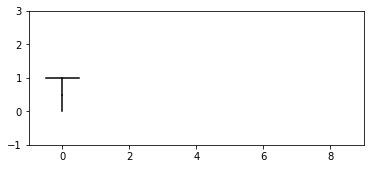

In [1165]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,9])
    ax.set_ylim([-1,3])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value - m.len[('leg',1)]*cos(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*sin(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB= m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value+m.q[i,'theta_ll'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb-m.len[('leg',2)]*cos(thB)    
    leg2_yb = leg1_yb-m.len[('leg',2)]*sin(thB)     
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [1094]:
for n in range(1,N+1):
    #print(m.dq[n,'x'].value)                  #velocity
    #print(m.dq[n,'y'].value)               #velocity
    #print(m.dq[n,'theta_b'].value)            #velocity
    #print(m.dq[n,'theta_lu'].value)          #velocity
    #print(m.dq[n,'theta_ll'].value)            #velocity
    

    #print(m.ddq[n,'x'].value)                  #acceleration
    #print(m.ddq[n,'y'].value)               #acceleration
    #print(m.ddq[n,'theta_b'].value)            #acceleration
    #print(m.ddq[n,'theta_lu'].value)          #acceleration
    #print(m.ddq[n,'theta_ll'].value)            #acceleration
    
    #print(m.tau_a[n].value)            #torque hip
    #print(m.tau_b[n].value)            #torque knee

1.349352579017108e-31
-6.0358603632990445e-18
-0.1840695736942578
0.08193219719112038
-0.10483362673257157
0.0029507571871746976
-0.11892889987713223
0.024002812332192418
0.04923392479799417
-0.15657443700200374
-0.12423972877439299
0.017857493935002
0.8355784135664208
-0.9047191808564219
-0.22928845976995416
0.1495467841906624
-0.1155712347764999
0.04382534161594394
-0.045288818098639556
-0.01844338035602699
-0.00905161567523142
-0.04665927580825557
-0.03420046649814762
-0.013528839752245699
-0.052793811494152756
0.013003956100823041
-0.03133060539200128
-0.016253401180855845
-0.02980403183635474
-0.021466554809409136
-0.1865310456519502
0.1326617229968986
-0.06466326618021638
0.005943825246948802
0.01760988275071494
-0.08489821851149496
0.10021496711656806
-0.175031847755834
-0.07009309543547029
-0.0088645562324666
1.9332517825826439
-1.999437077474553
-0.5228087239499849
0.4360692082069886
-0.10817966015525424
-0.01624617204435838
-0.06260841300961892
-0.056742904002720265
-0.068475

In [850]:
sym.printing.latex(EOM[1].simplify())

'- 1.0 G_{y} - 0.5 \\ddot{\\theta}_{body} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{body} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{body} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_lower} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} + 1.0 \\ddot{y} m_{body} + 1.0 \\ddot{y} m_{leg1} + 1.0 \\ddot{y} m_{leg2} + 0.5 \\dot{\\theta}_{body}^{2} l_{leg1} m_{leg1} \\sin{\\left(\\theta_{body}